In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches


In [ ]:
# Import the input-output table, with multi-indices for both index and columns: one for country, another for sector
input_output = pd.read_csv("input_output.csv", index_col = [0,1], header = [0,1])




In [3]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        total = df[feature_name].sum()
        if total == 0:
            result = result.drop(feature_name,1)
            result = result.drop(feature_name,0)
        else: 
            result[feature_name] = df[feature_name] / total
    return result 



In [ ]:
input_output_norm = normalize(input_output)
input_output_norm[input_output_norm<0.2] = 0

input_output_matrix = input_output_norm.as_matrix()
G = nx.from_numpy_matrix(input_output_matrix)

In [14]:

index_cnt = input_output_norm.loc['FRA']
sing_cnt = index_cnt['FRA']
sing_cnt = sing_cnt.as_matrix()
#sing_cnt
#S = nx.DiGraph(sing_cnt)
S = nx.Graph(sing_cnt)

In [15]:
#outdegree list
out_ = np.sum(input_output_norm, axis=1)

#add attributes of country and sector to each node
for node in G.nodes():
    G.node[node]['country'] = list(input_output_norm.index[node])[0]
    G.node[node]['sector'] = list(input_output_norm.index[node])[1]
    G.node[node]['outdegree'] = out_[node]

In [35]:
#prepare the sample network object
#France, Britain, Germany, Spain, Romania, cyprus

smpl_cntrs = ['FRA','GBR','DEU','ESP', 'ROU', 'CYP']
#smpl_cntrs = ['FRA','GBR','DEU']
#smpl_cntrs = ['FRA', 'GBR']
index_sample = input_output_norm.loc[smpl_cntrs]
col_idx_sample = index_sample[smpl_cntrs]
sample_matrix = col_idx_sample.as_matrix()

sample_out = np.sum(col_idx_sample, axis=1) 
sample_betweeness_centrality = nx.edge_betweenness_centrality(G)

#D = nx.DiGraph(sample_matrix)
D = nx.Graph(sample_matrix)

for node in D.nodes():
    D.node[node]['country'] = list(col_idx_sample.index[node])[0]
    D.node[node]['sector'] = list(col_idx_sample.index[node])[1]
    D.node[node]['outdegree'] = sample_out[node]
    D.node[node]['betweeness_centrality'] = sample_betweeness_centrality.values()[node]

In [7]:
weights = nx.get_edge_attributes(D, 'weight').values()
color_map = {'FRA':'b', 'GBR':'#FF0099', 'DEU':'#660066', 'ESP': '#FF33CC', 'ROU':'r', 'CYP':'#996600'} 

#color_map = {'FRA':'b', 'GBR':'#FF0099', 'DEU':'#660066' }
d = nx.degree(D)

plt.figure(figsize = (120,120))

nx.draw(D, width = weights*20, node_color = [color_map[D.node[node]['country']] for node in D],node_size=[v * 100 for v in d.values()])
plt.title('Global Value Chains Sample Network')

france = mpatches.Patch(color = 'b', label = 'France')
britain =  mpatches.Patch(color = '#FF0099', label = 'Great Britain')
germany =  mpatches.Patch(color = '#660066', label = 'Germany')

plt.legend(handles=[france, britain, germany], prop={'size':200})
plt.show()

/home/frank/.local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/frank/.local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

In [4]:
#girvan newman allgorythm

def girvan_newman(G, most_valuable_edge=None, min_edges = 0):
# If the graph is already empty, simply return its connected
    # components.
    if G.number_of_edges() == 0:
        yield tuple(nx.connected_components(G))
        return
    # If no function is provided for computing the most valuable edge,
    # use the edge betweenness centrality.
    if most_valuable_edge is None:
        def most_valuable_edge(G):
            """Returns the edge with the highest betweenness centrality
            in the graph `G`.

            """
            # We have guaranteed that the graph is non-empty, so this
            # dictionary will never be empty.
            betweenness = nx.edge_betweenness_centrality(G)
            return max(betweenness, key=betweenness.get)
    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    # Self-loops must be removed because their removal has no effect on
    # the connected components of the graph.
    g.remove_edges_from(g.selfloop_edges())
    while g.number_of_edges() > min_edges:
        yield _without_most_central_edges(g, most_valuable_edge)

        
def _without_most_central_edges(G, most_valuable_edge):
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    while num_new_components <= original_num_components:
        edge = most_valuable_edge(G)
        G.remove_edge(*edge)
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)
    return new_components


In [7]:
def create_graph_for_year(year):
    input_output = pd.read_csv("~/Documents/networks/ICIO_data/ICIO2016_" + str(year) + ".csv", index_col = [0,1], header = [0,1])
    input_output_norm = input_output
    input_output_norm[input_output_norm < 50000] = 0
    #input_output_norm = normalize(input_output)
    #input_output_norm[input_output_norm<0.2] = 0
    #prepare the sample network object
    #France, Britain, Germany, Spain, Romania, cyprus
    smpl_cntrs = ['FRA','GBR','DEU','ESP', 'ROU', 'CYP']
    #smpl_cntrs = ['FRA','GBR']
    index_sample = input_output_norm.loc[smpl_cntrs]
    col_idx_sample = index_sample[smpl_cntrs]
    sample_matrix = col_idx_sample.as_matrix()
    D = nx.DiGraph(sample_matrix)
    for node in D.nodes():
        D.node[node]['country'] = list(col_idx_sample.index[node])[0]
        D.node[node]['sector'] = list(col_idx_sample.index[node])[1]
    return D

In [8]:
D = create_graph_for_year(2011)

In [10]:
gn_partition = girvan_newman(D, min_edges = 20)
gn_partitions = list(gn_partition)
community_index = [i for i in gn_partitions[1] if len(i) > 2]
avg_distinct_countries = []
for comm in community_index:
    subgraph_nodes = []
    for n in comm:
        subgraph_nodes.append(n)
    community = D.subgraph(subgraph_nodes)
    community.edges(data = True)
    old_nodes = community.nodes()
    new_nodes = list(range(len(community.nodes())))
    relabel_mapping = dict(zip(old_nodes, new_nodes))
    community = nx.relabel_nodes(community, relabel_mapping)
    out_nodes = [link[0] for link in community.edges()]
    in_nodes = [link[1] for link in community.edges()]
    in_countries = [nx.get_node_attributes(community, 'country')[node] for node in in_nodes]
    out_countries = [nx.get_node_attributes(community, 'country')[node] for node in out_nodes]
    distincts= []
    for outs,ins in zip(out_countries,in_countries):
        distincts.append(outs!=ins)
    distincts = sum(distincts)/len(community.edges())
    print(distincts)
    print(len(community.nodes()))

IndexError: list index out of range

In [37]:
betweenness = nx.edge_betweenness_centrality(G)
max(betweenness, key=betweenness.get)

nx.number_connected_components(G)

1425

In [38]:
D.number_of_edges()

106

In [39]:
gn_partition = girvan_newman(D)
gn_partitions = list(gn_partition)

In [40]:
[community for community in gn_partitions[1] if len(community) >= 3]

[{0, 2, 33, 36, 68, 99, 120, 152, 153, 167},
 {11, 43, 76, 110},
 {13, 26, 27, 28, 29, 60, 93, 94, 126, 127},
 {18, 39, 51, 84, 117, 133, 138, 139, 150, 166, 183, 185},
 {19,
  24,
  25,
  52,
  57,
  58,
  59,
  61,
  65,
  85,
  90,
  91,
  92,
  98,
  118,
  123,
  124,
  131,
  151,
  156,
  158,
  159,
  160,
  164,
  189,
  190,
  191},
 {20, 54, 132, 134, 165, 172, 173, 175, 178},
 {22, 55, 88, 121, 154, 171, 180, 181},
 {23, 53, 56, 69, 86, 89, 122, 188},
 {37, 70, 103, 136},
 {38, 71, 104, 137},
 {63, 96, 162, 197}]

In [ ]:
[i for i in gn_partitions[1] if len(i) > 2]

In [122]:
community_index = gn_partitions[1]
sectors = nx.get_node_attributes(D, 'sector').values()
country = nx.get_node_attributes(D, 'country').values()

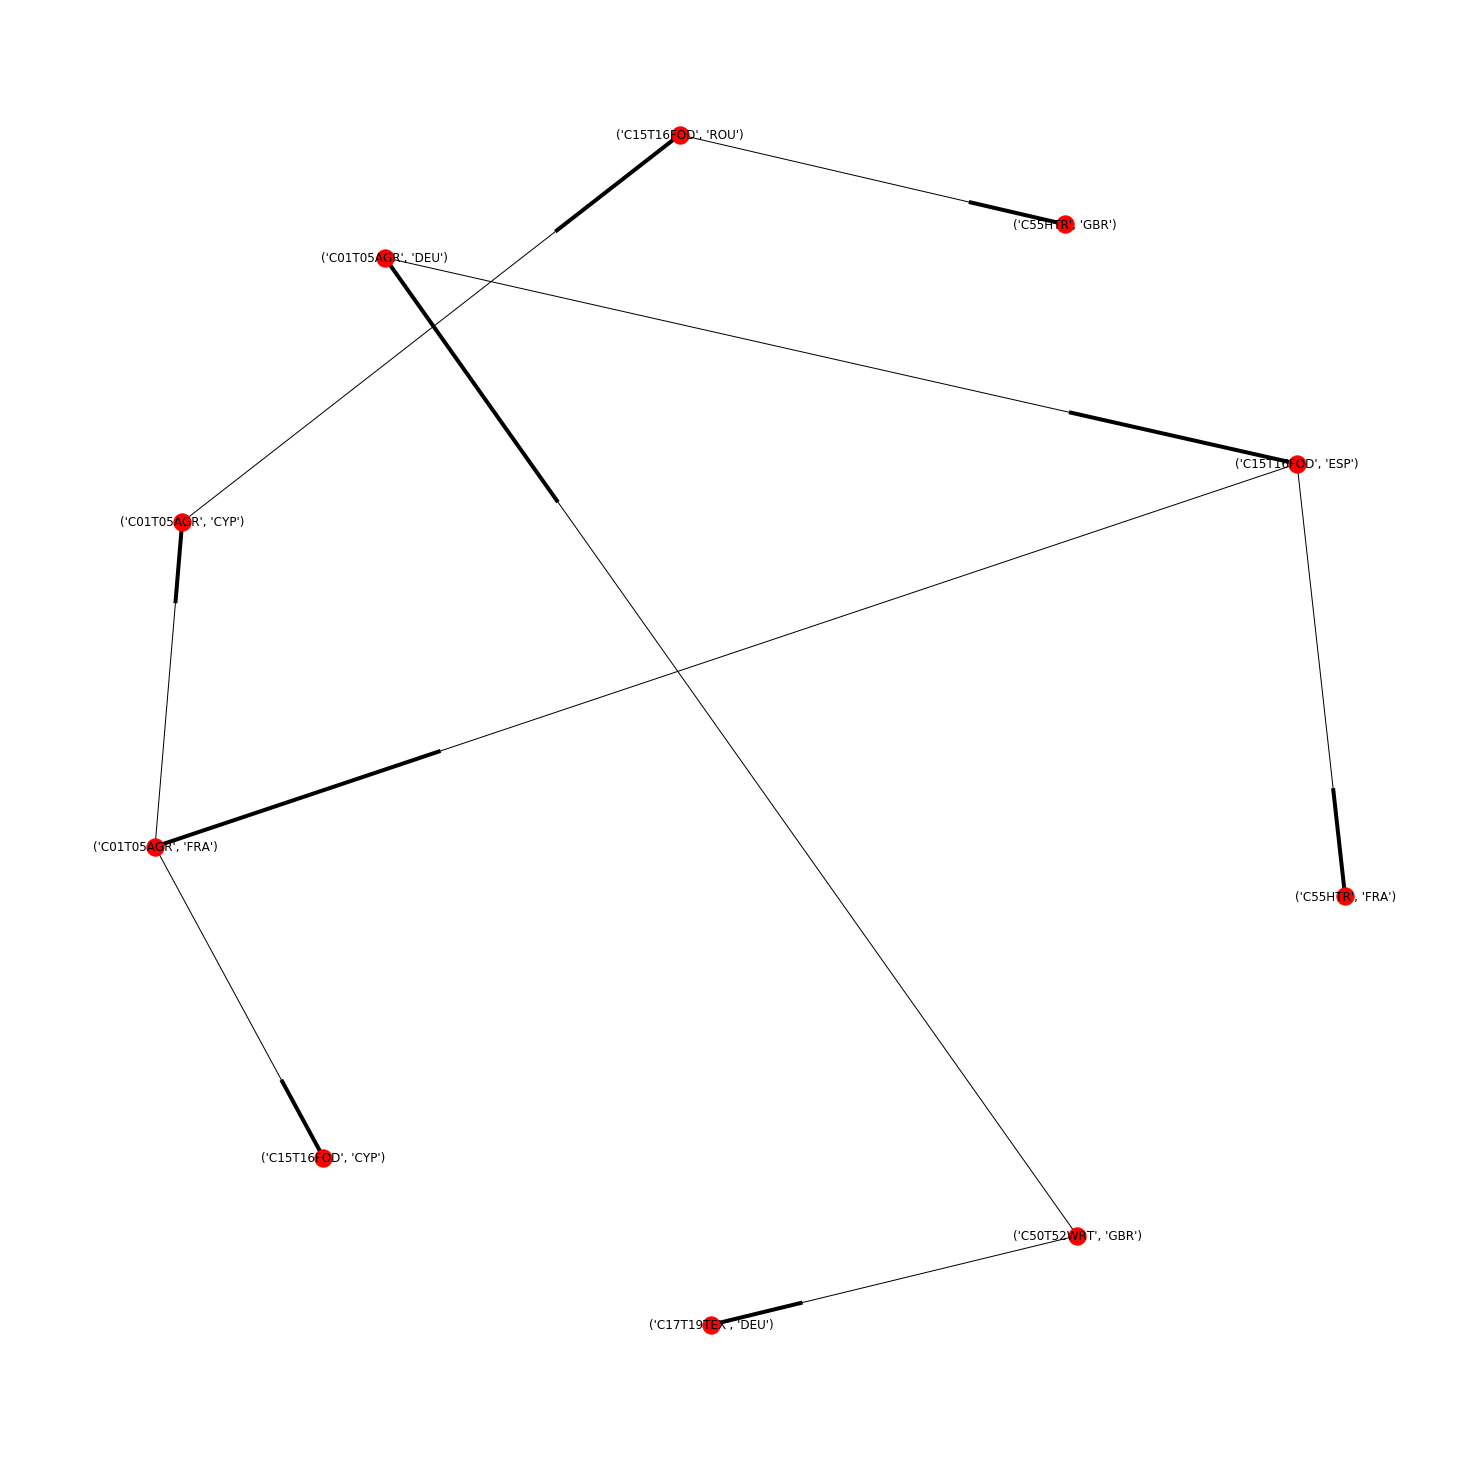

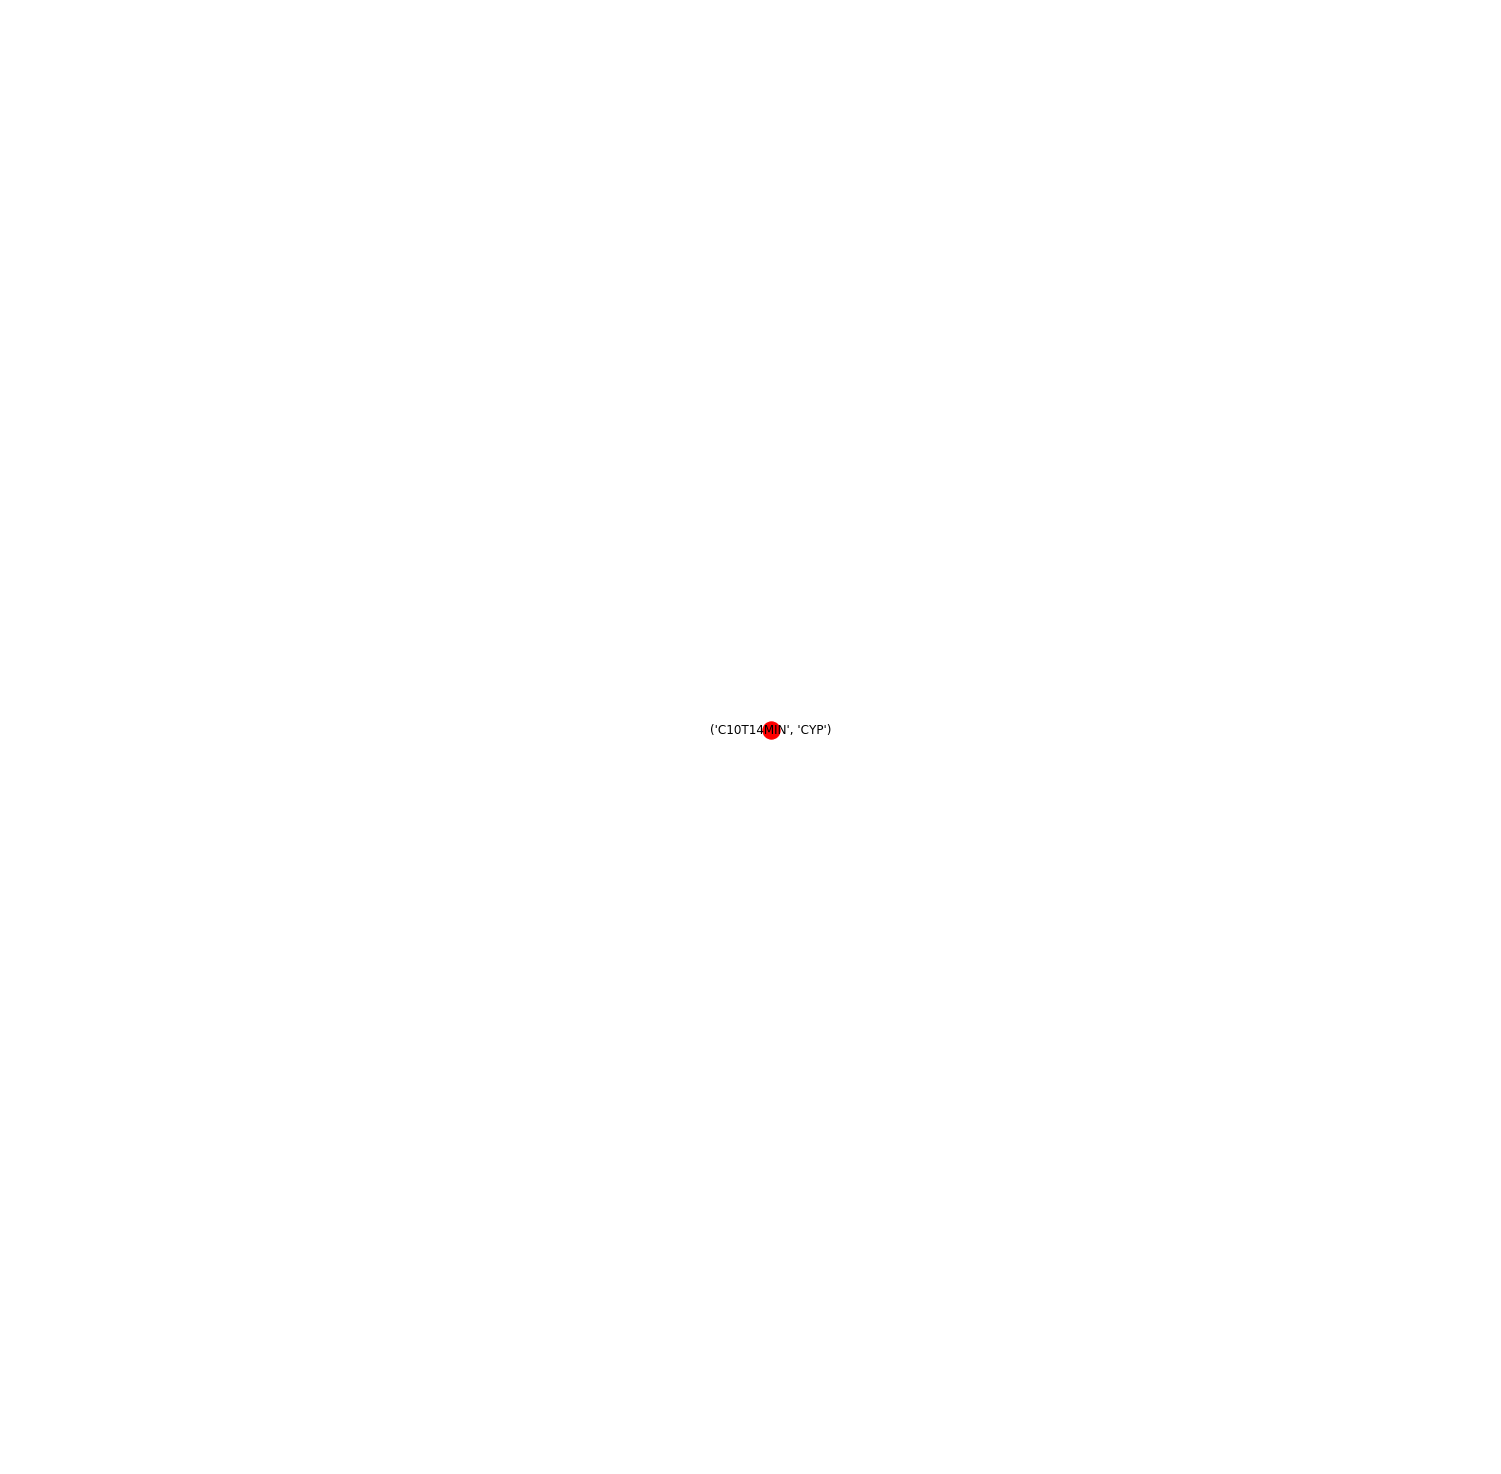

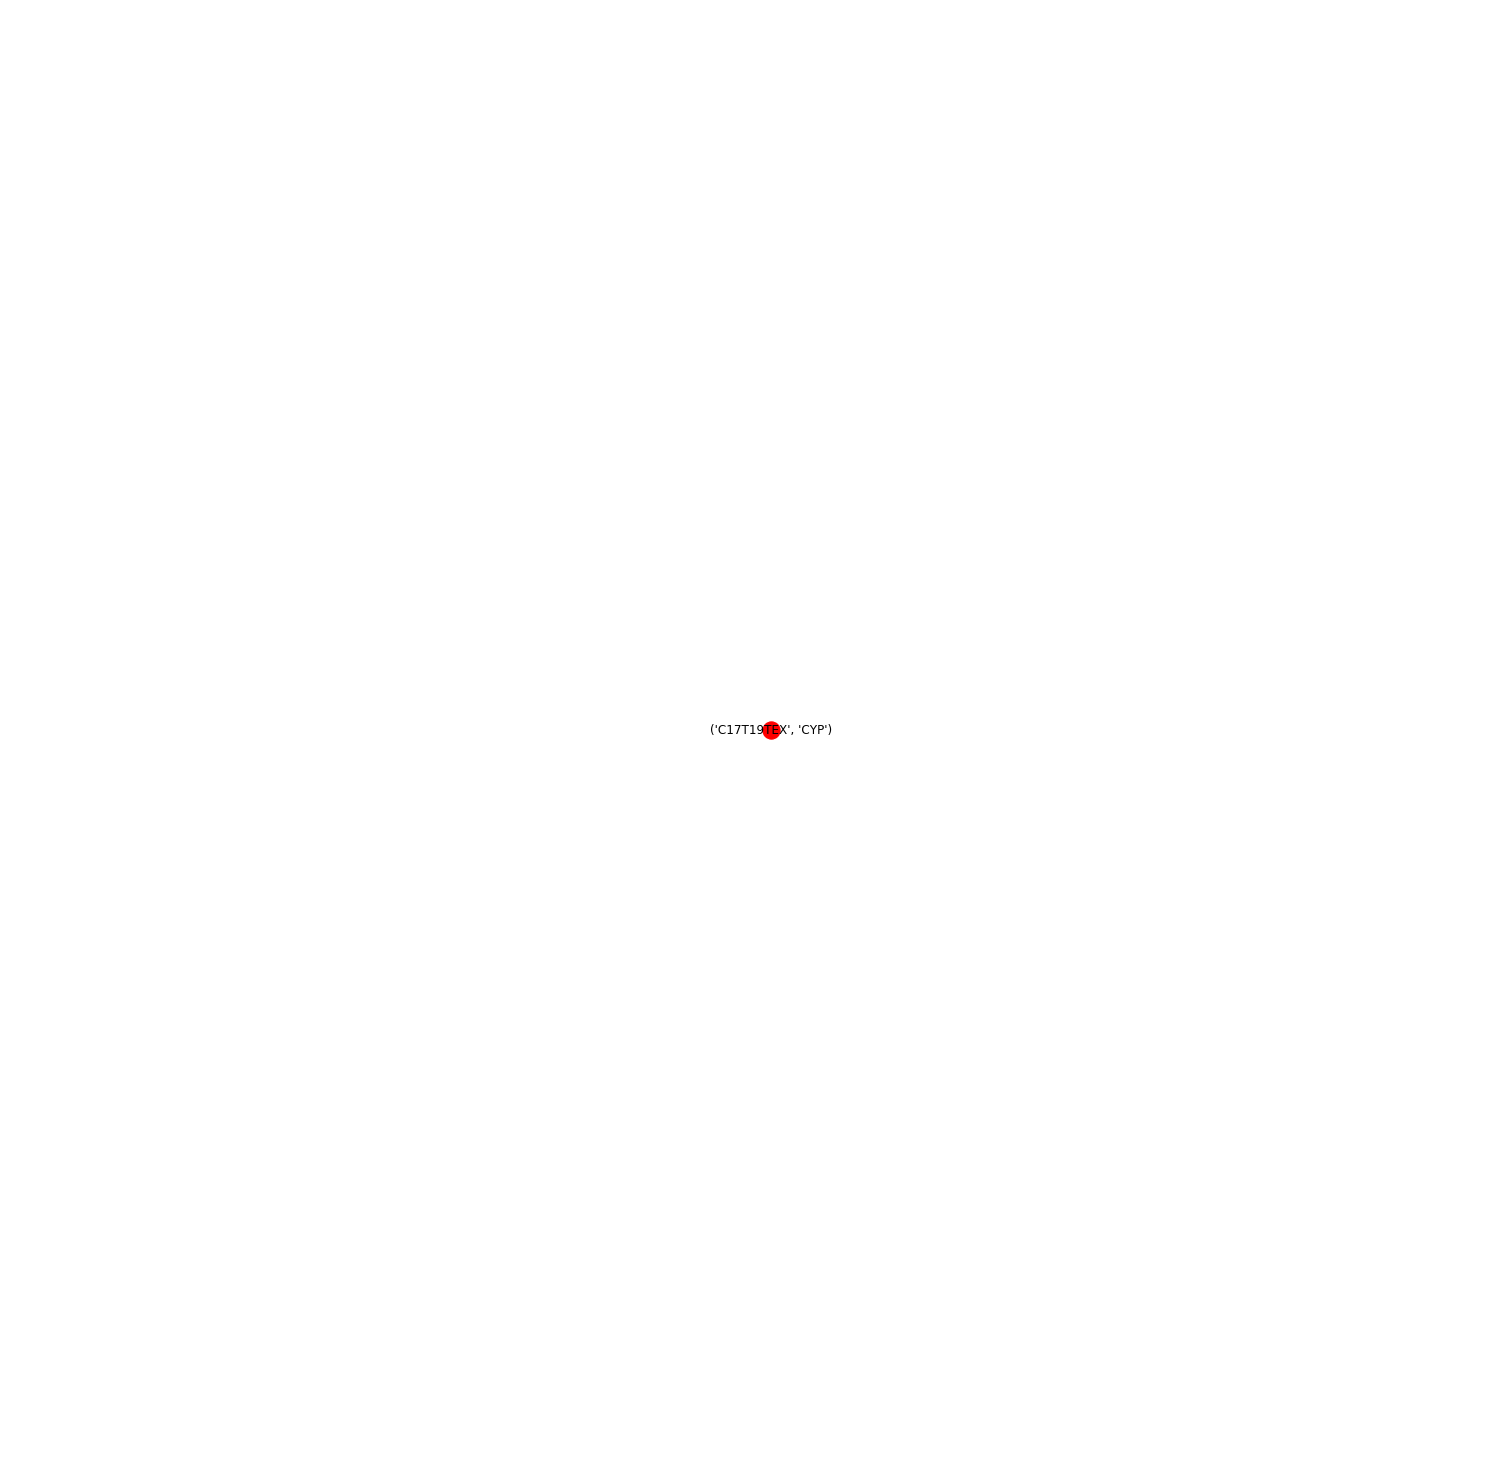

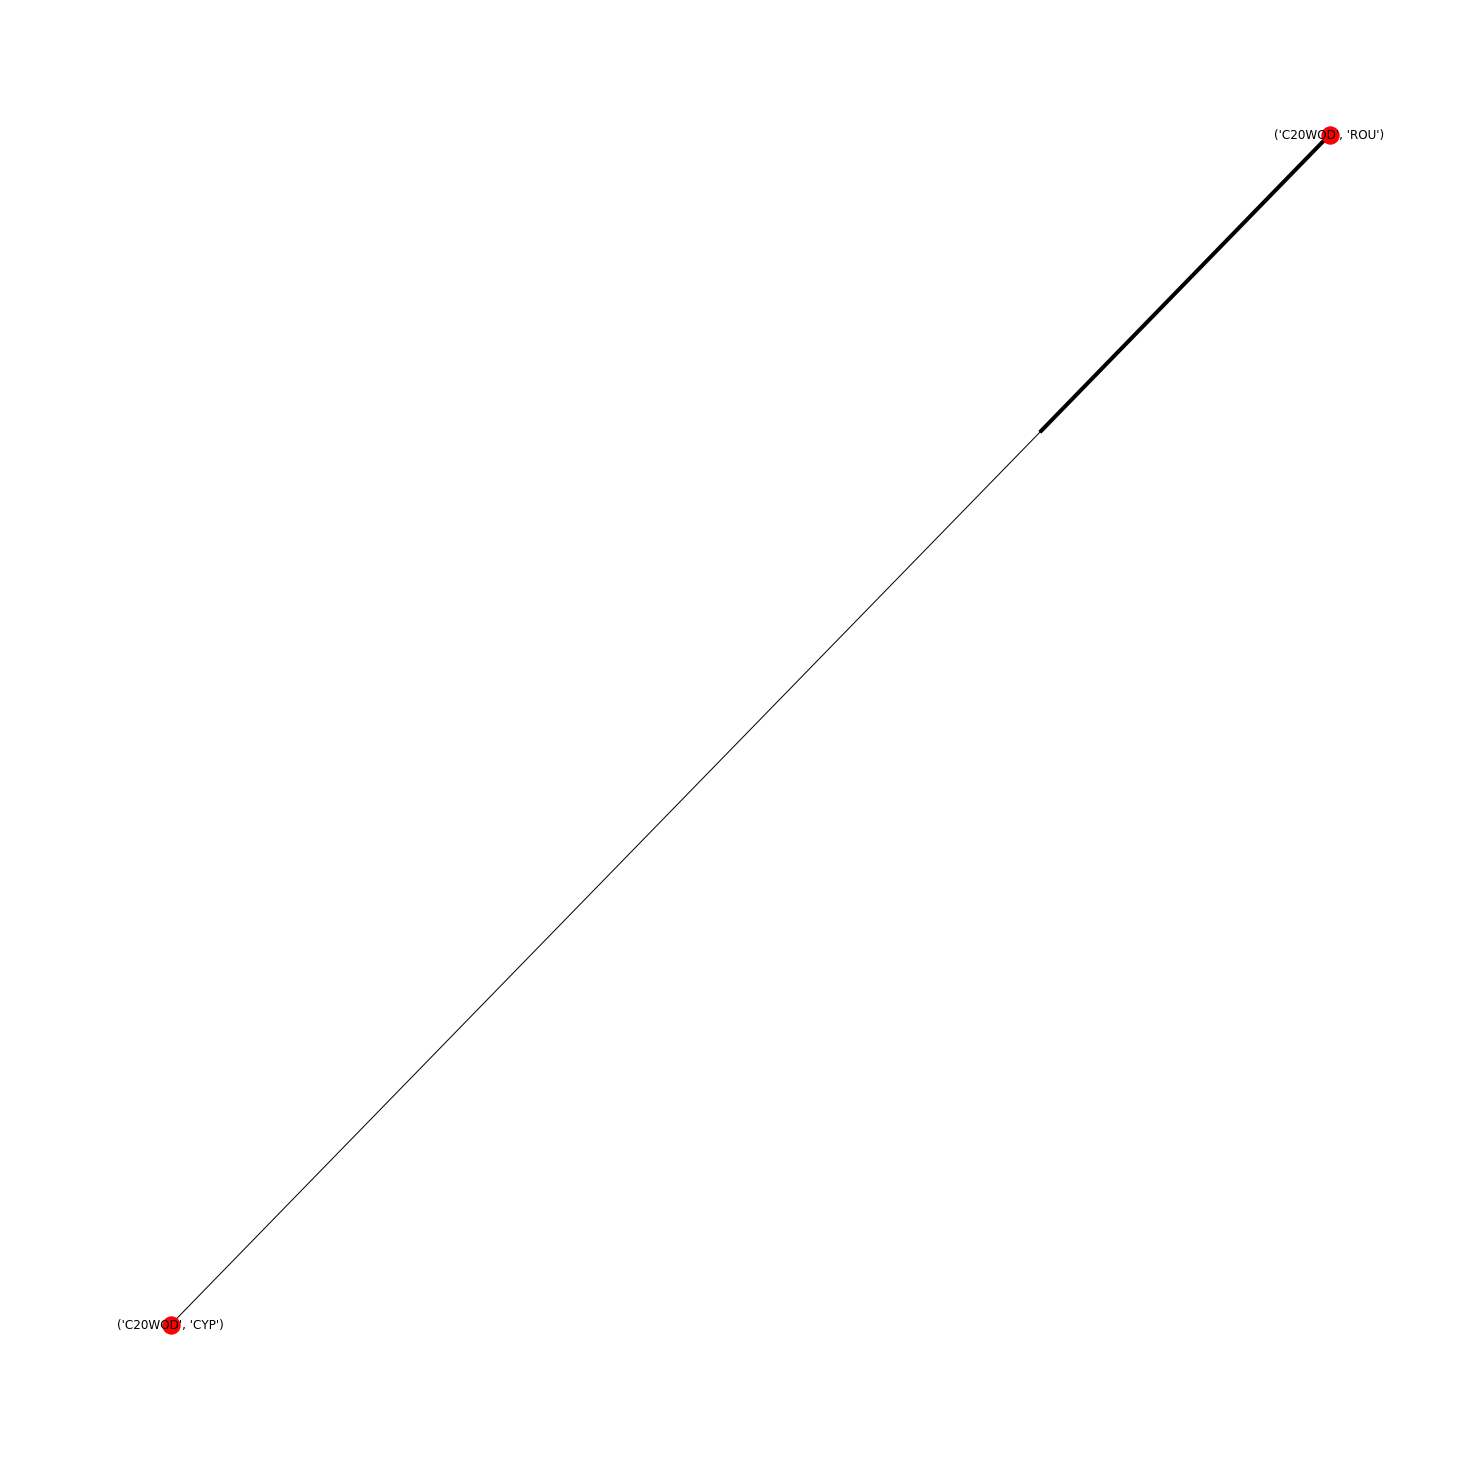

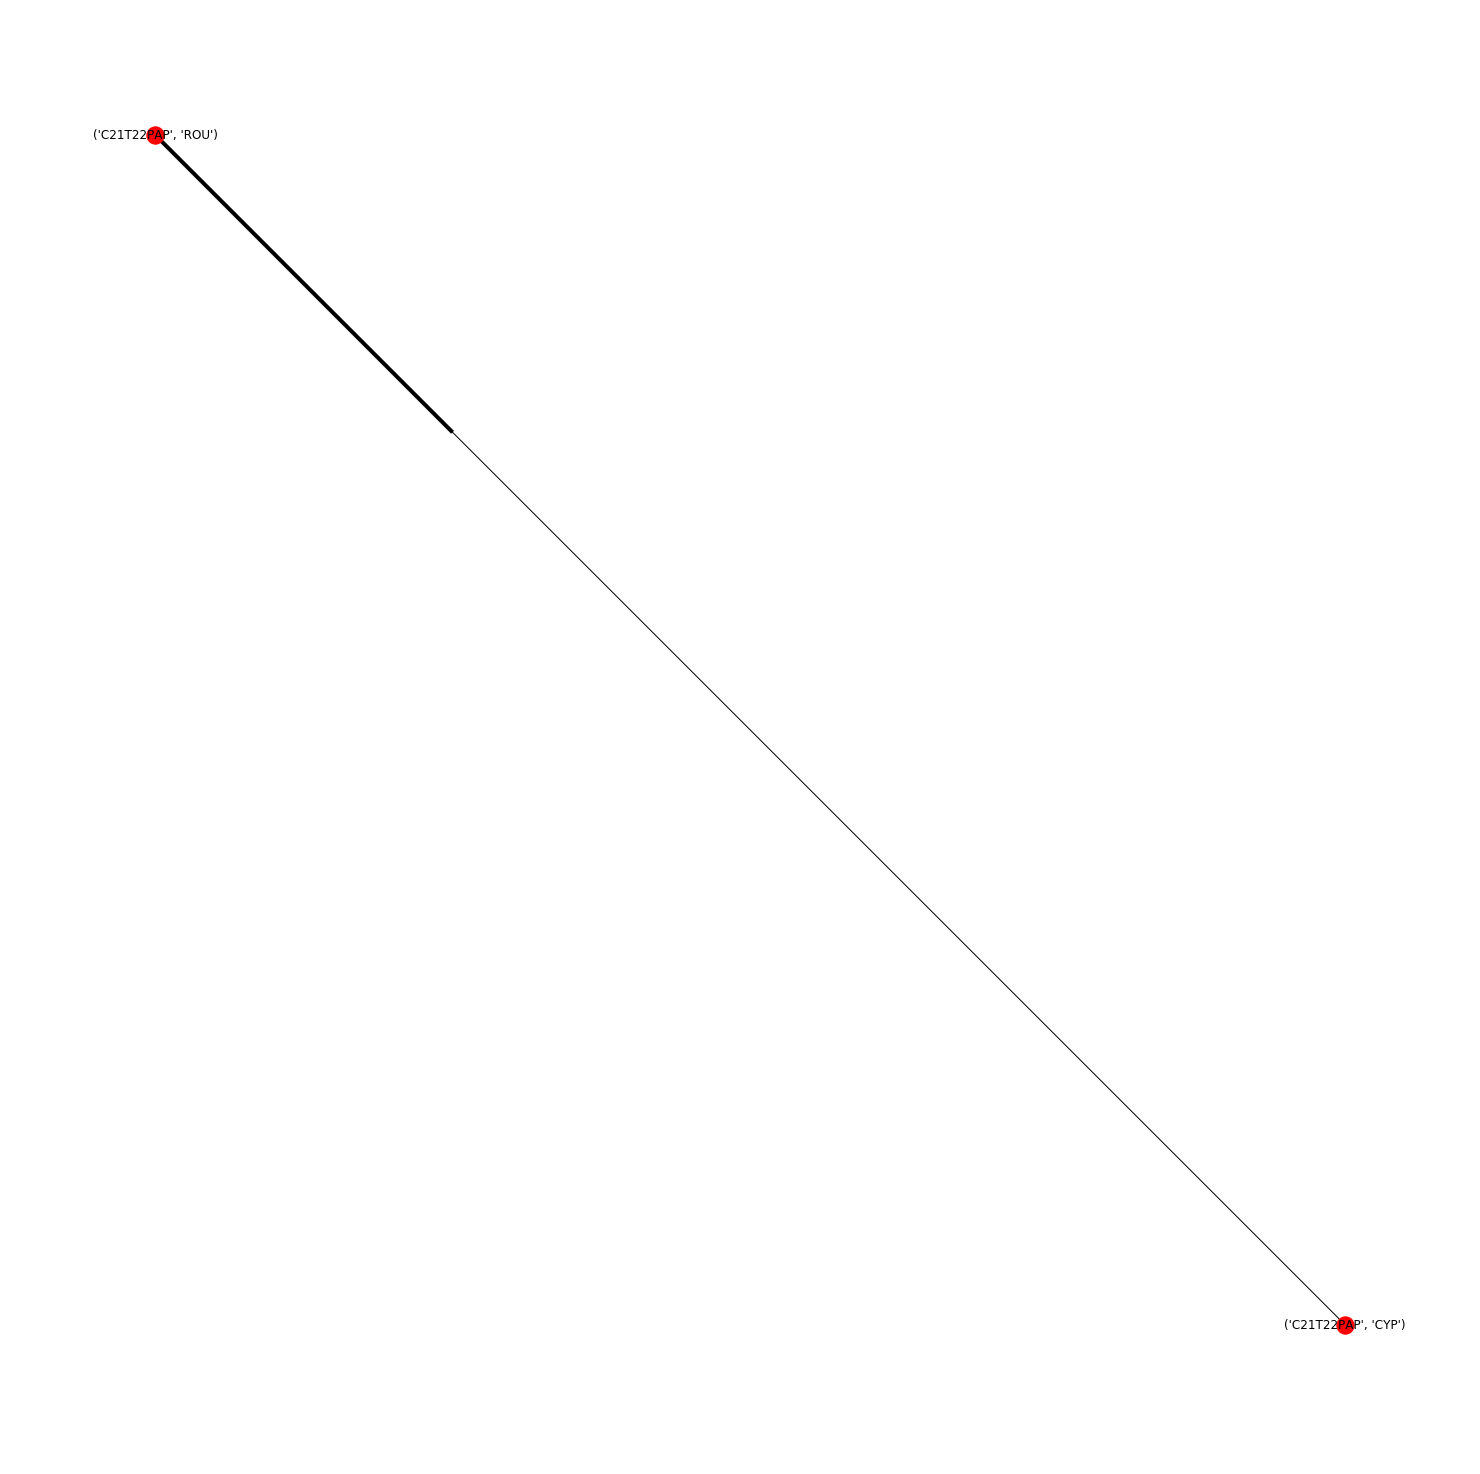

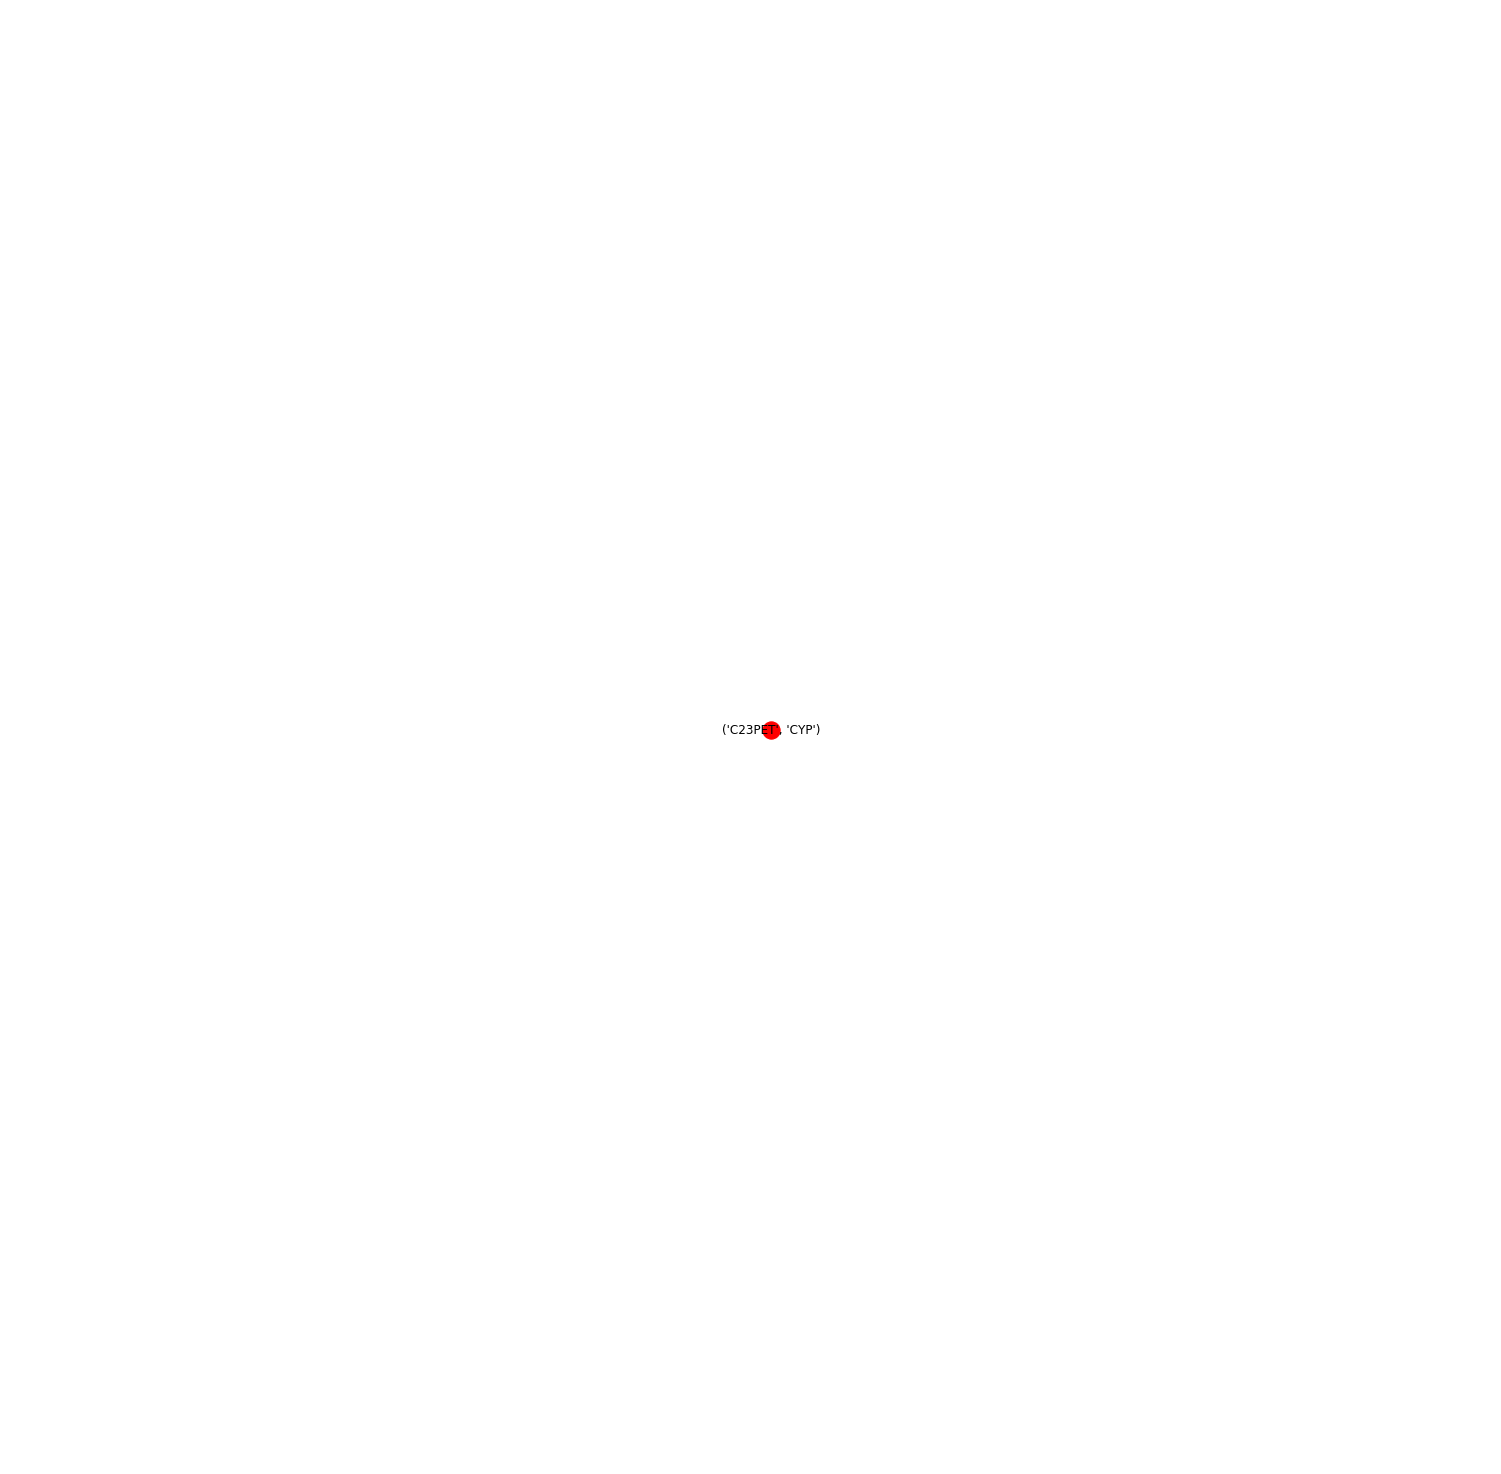

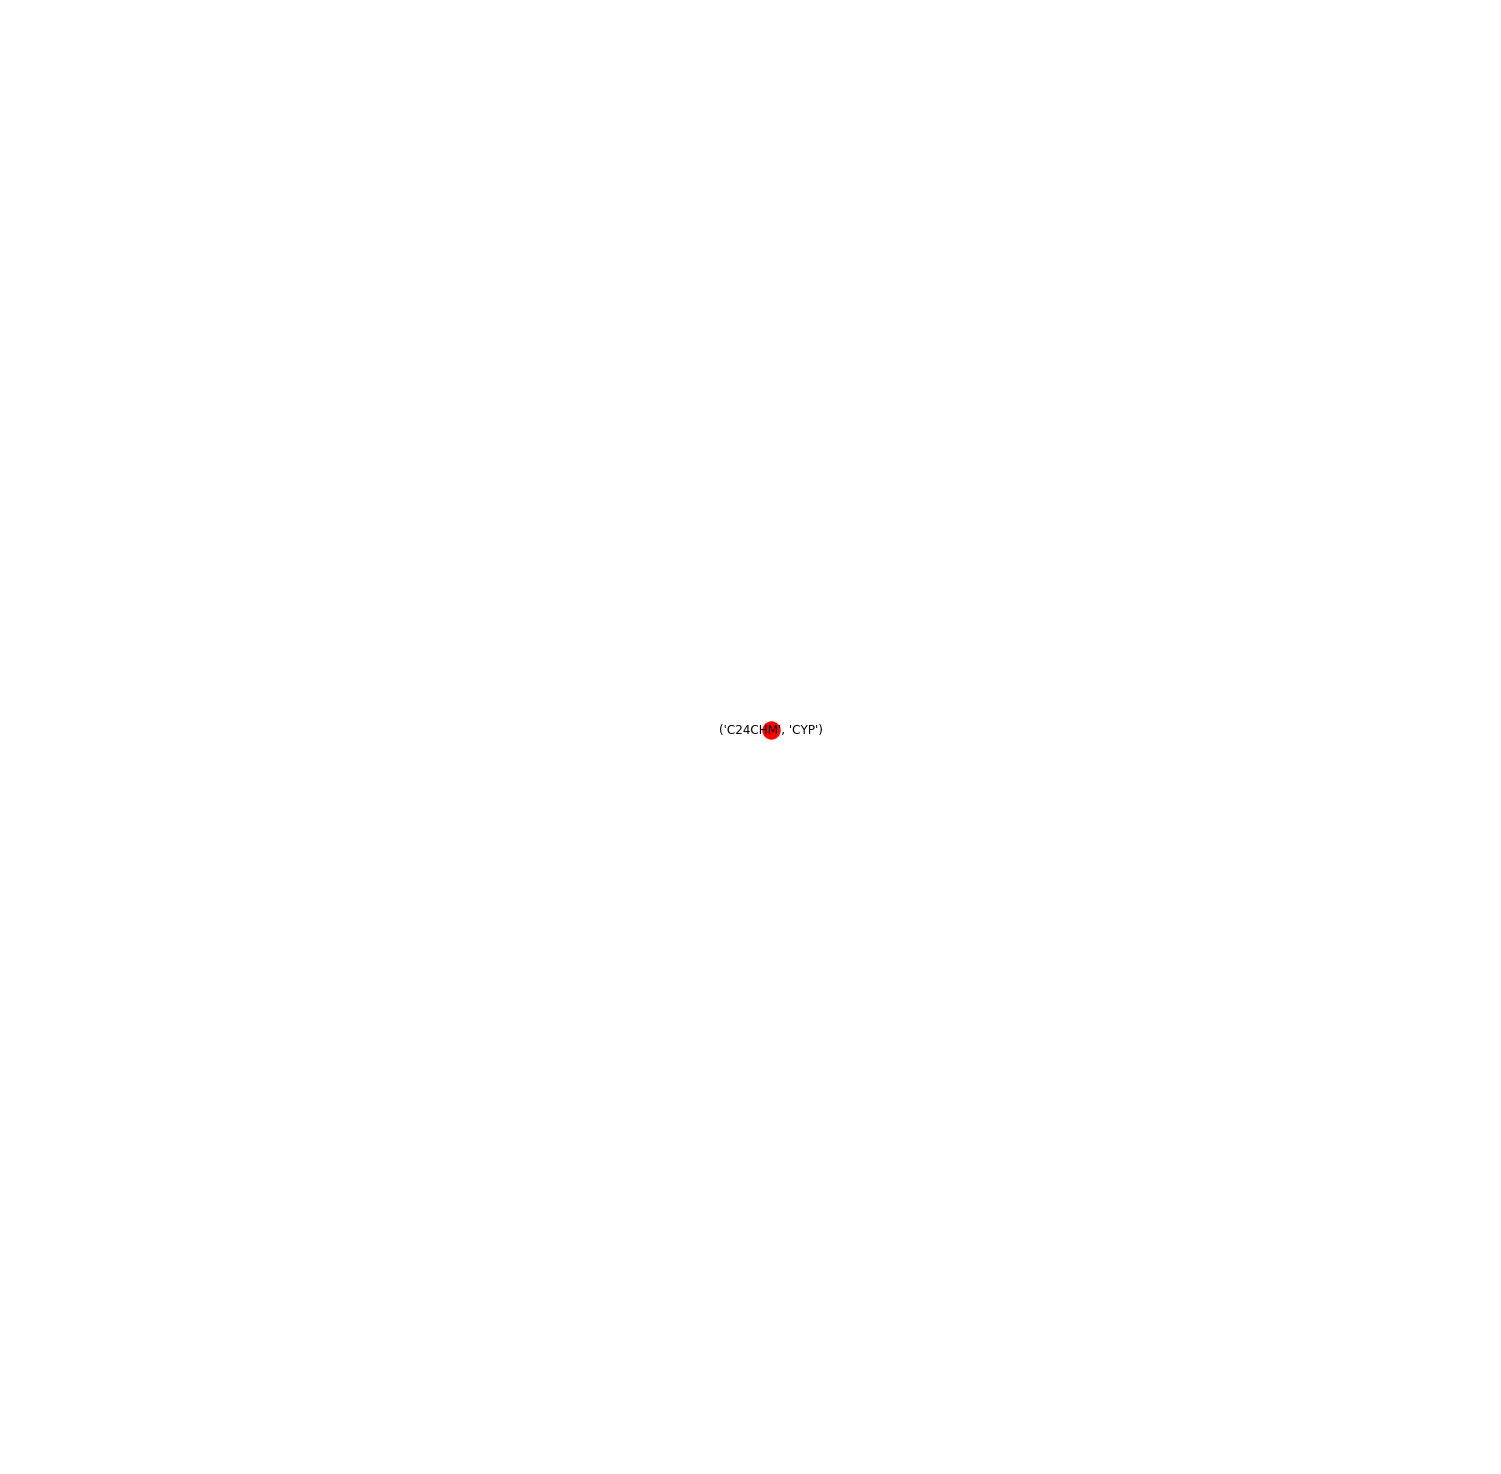

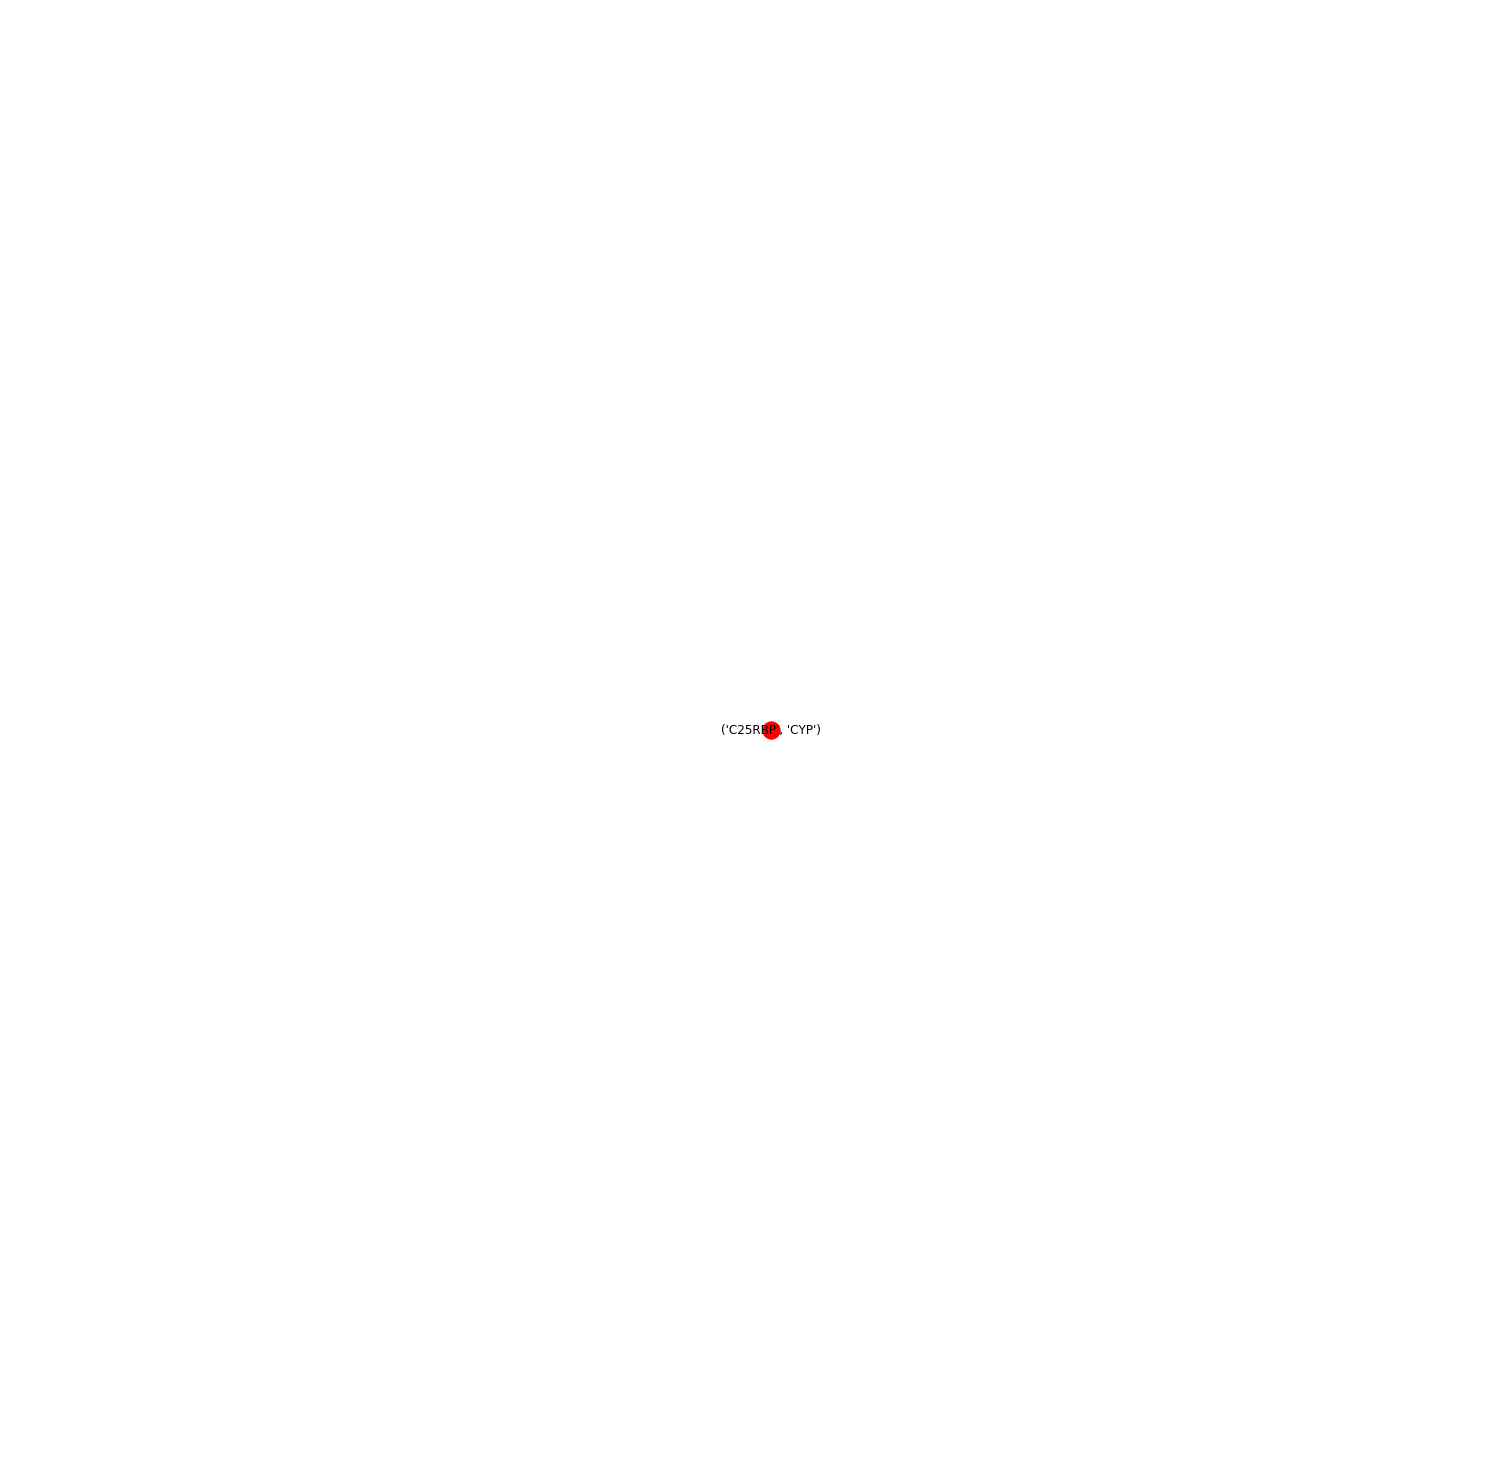

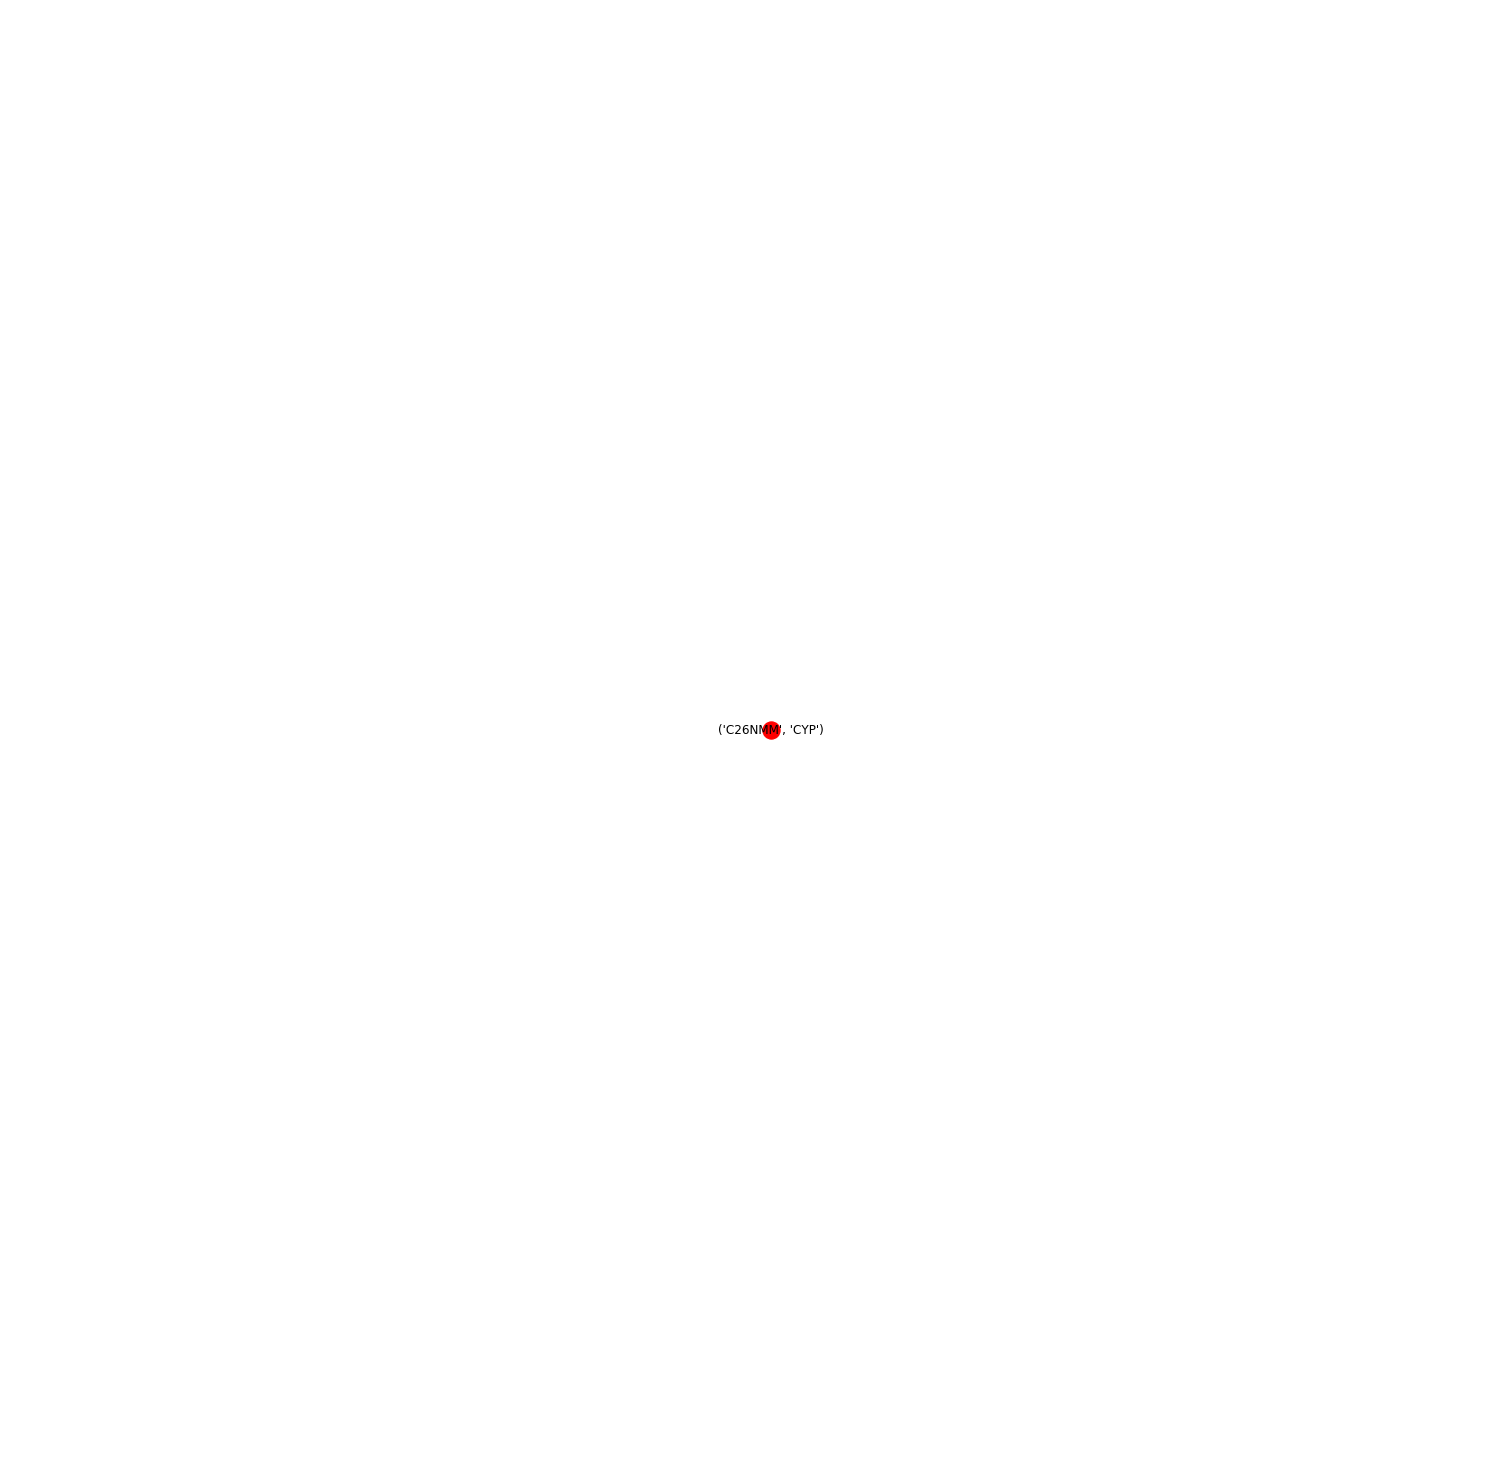

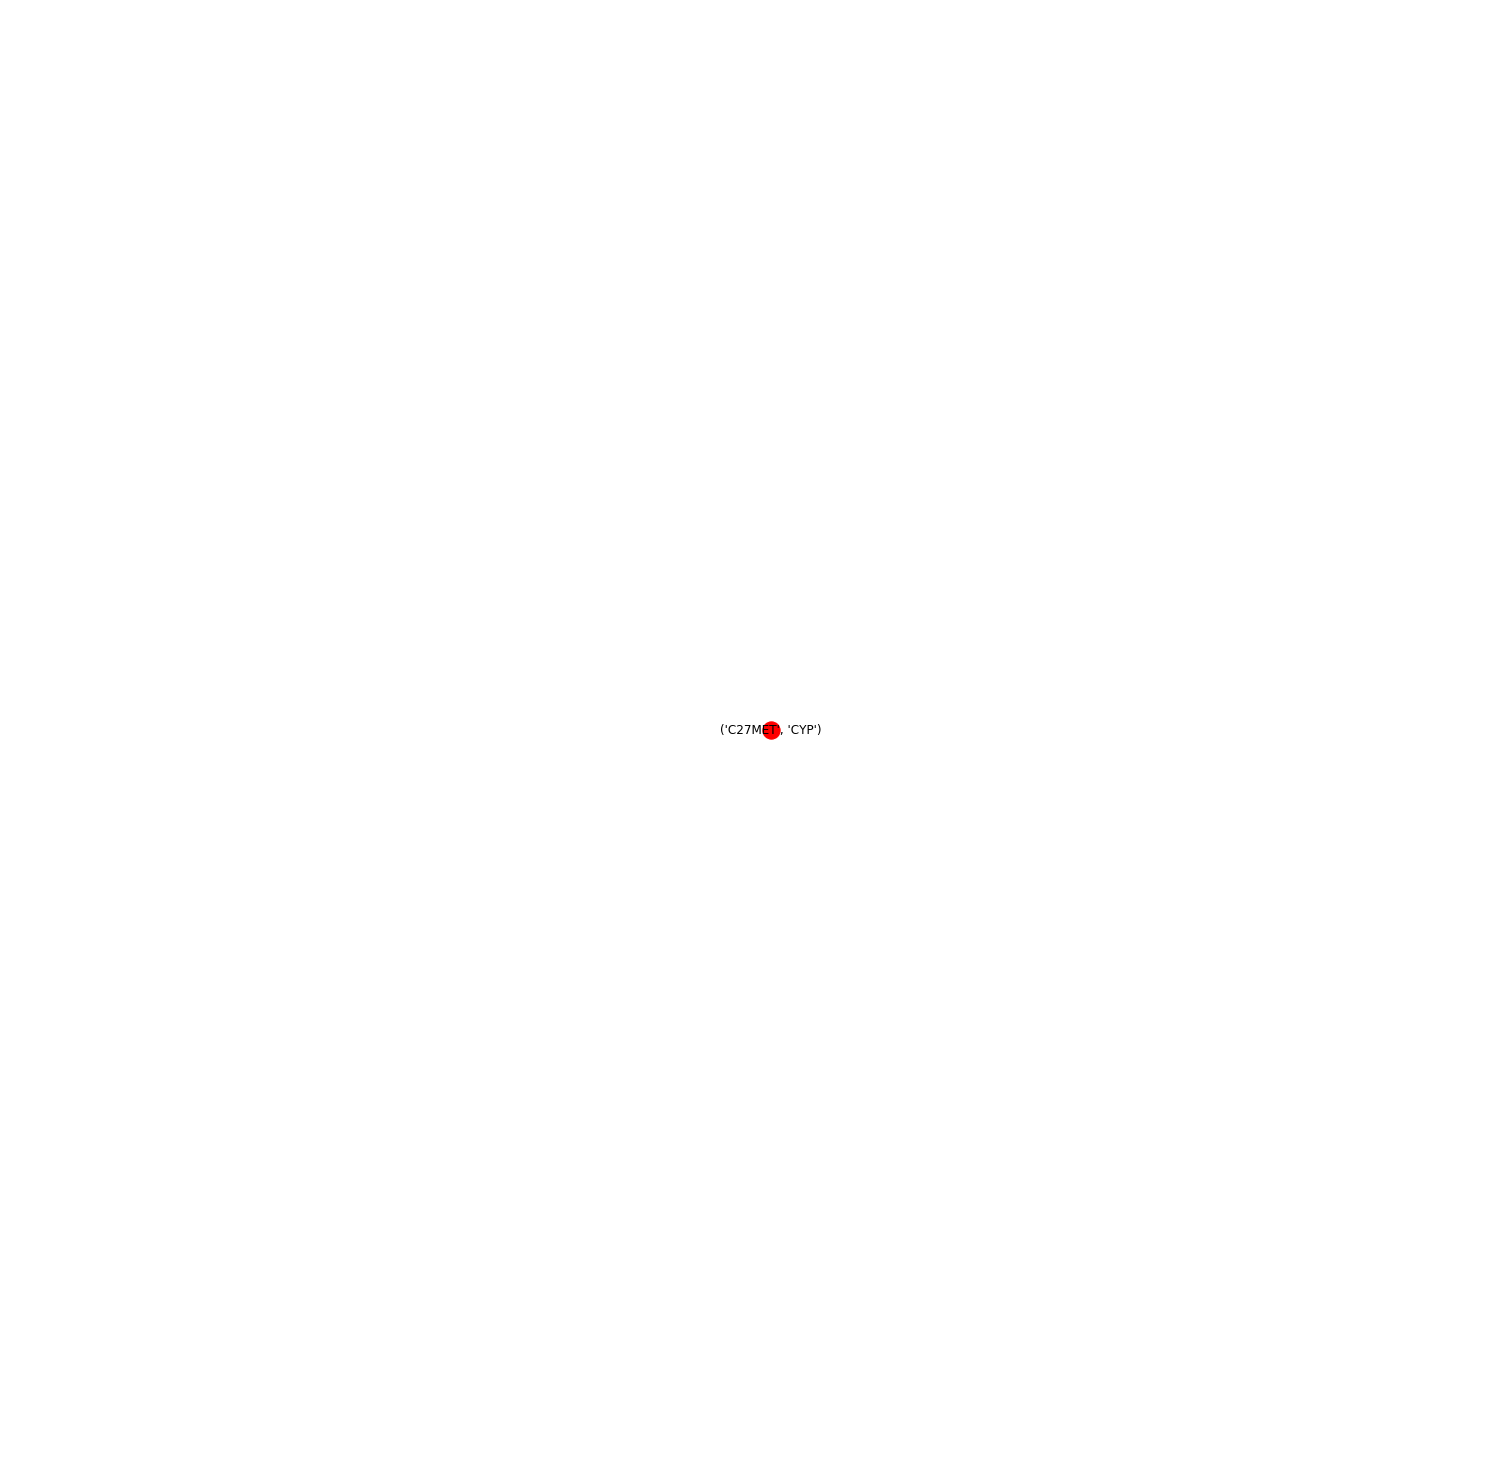

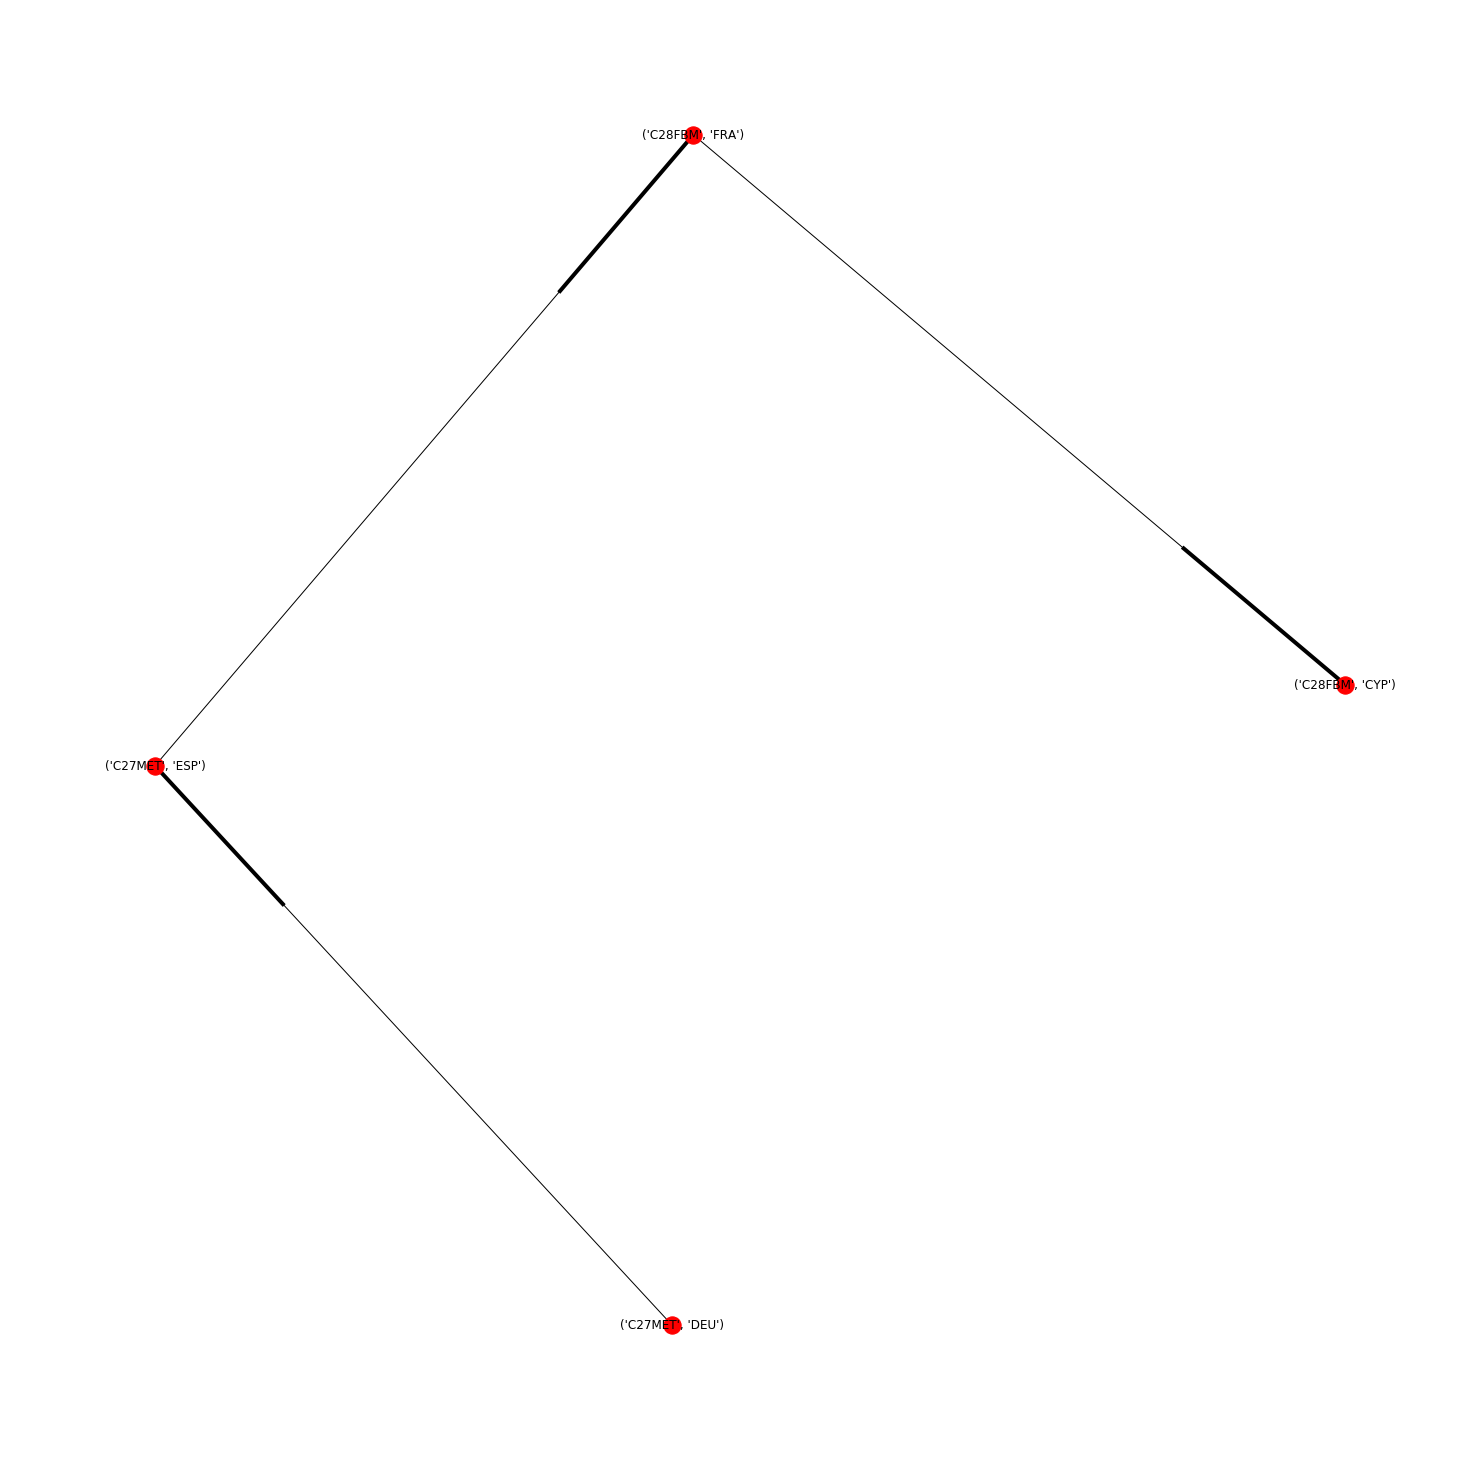

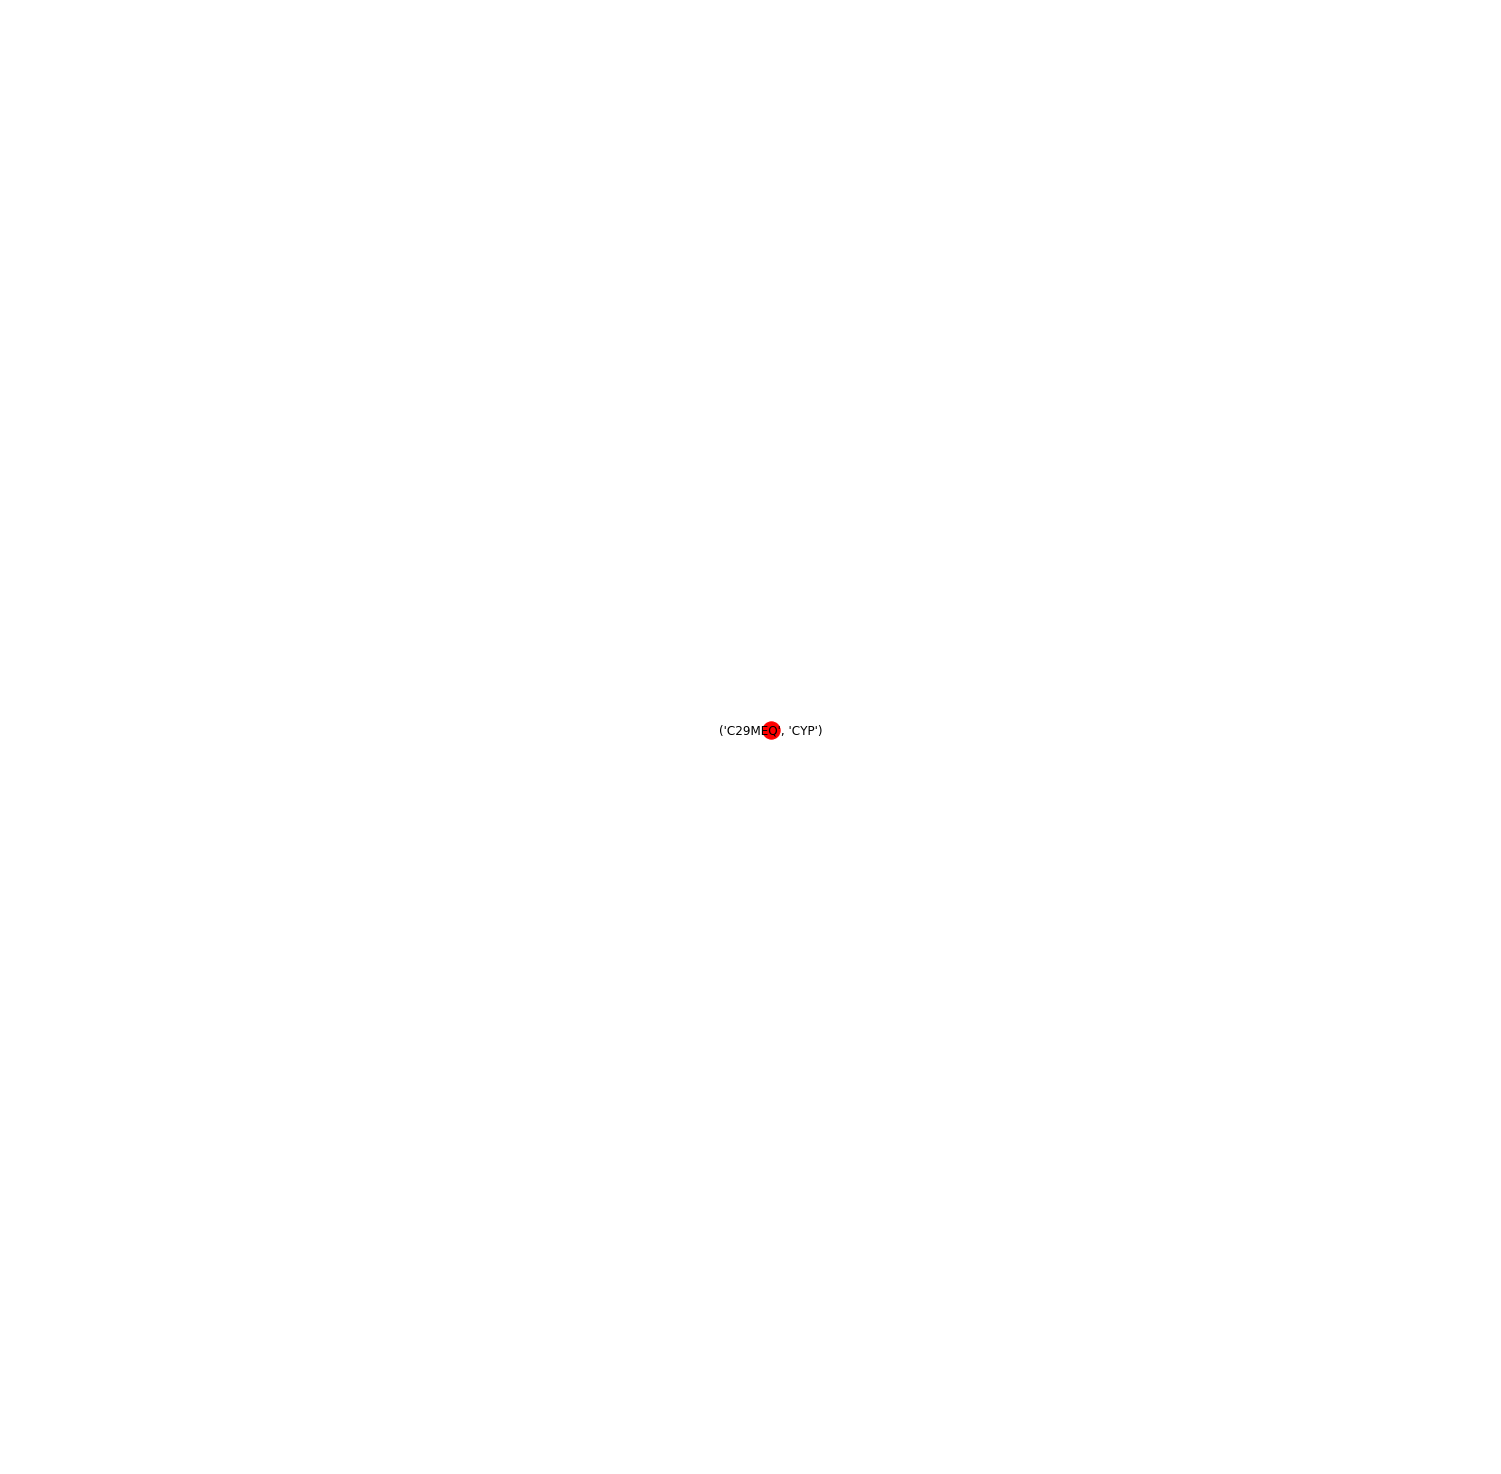

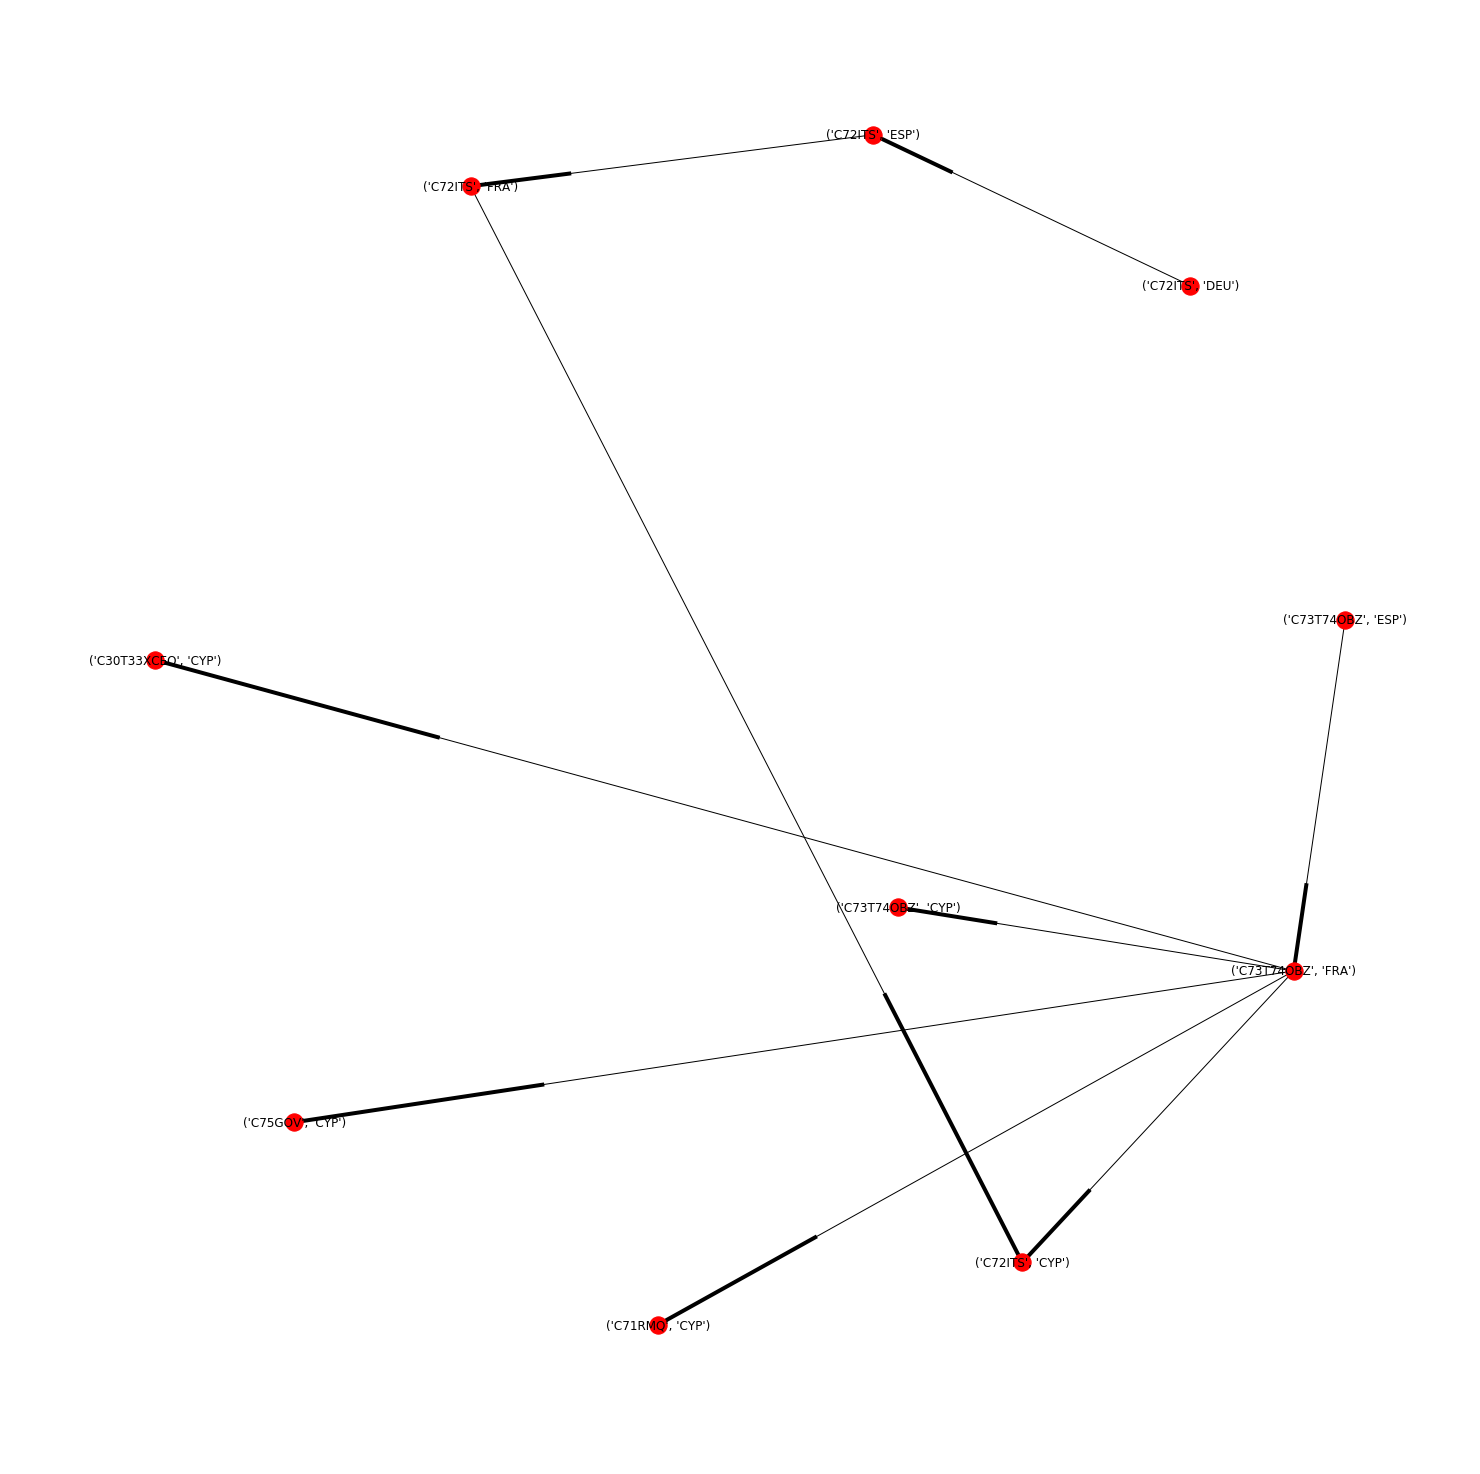

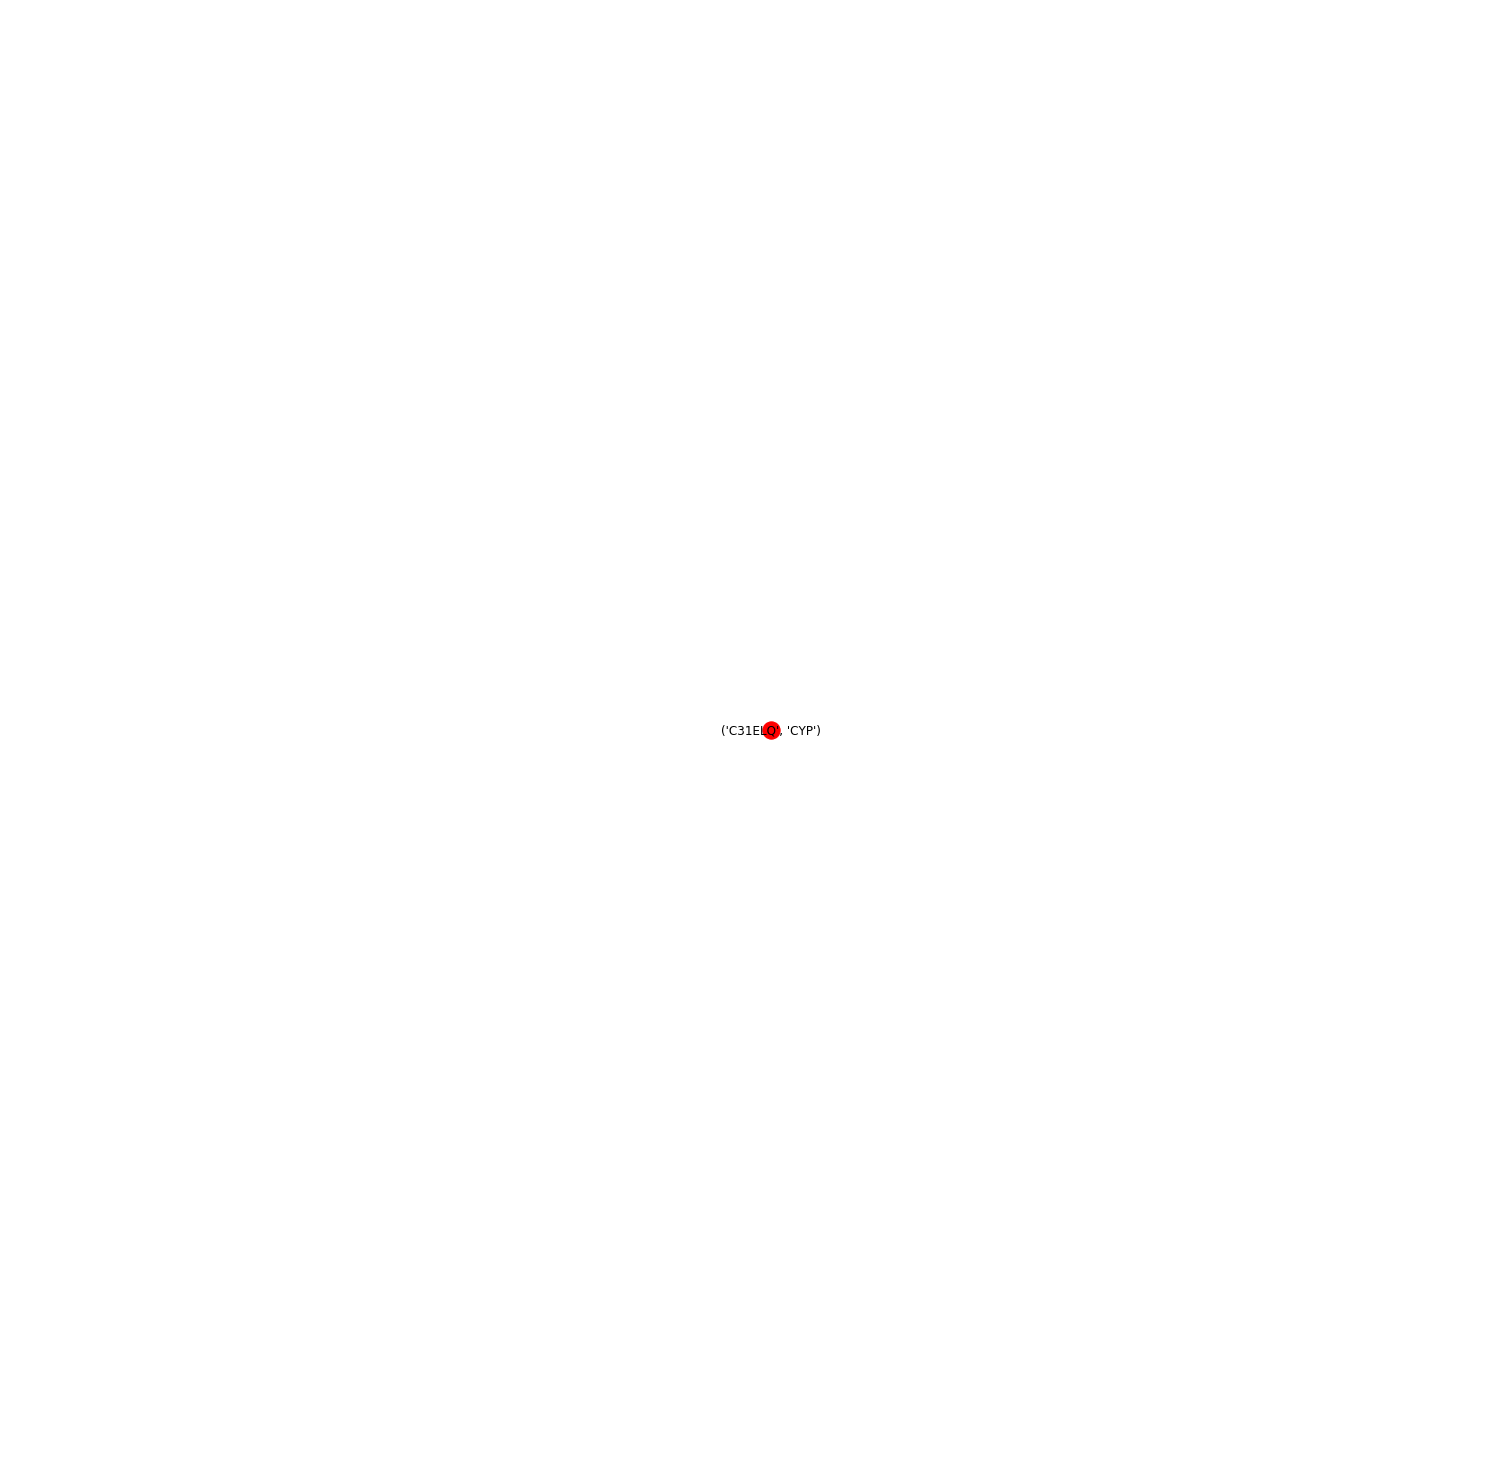

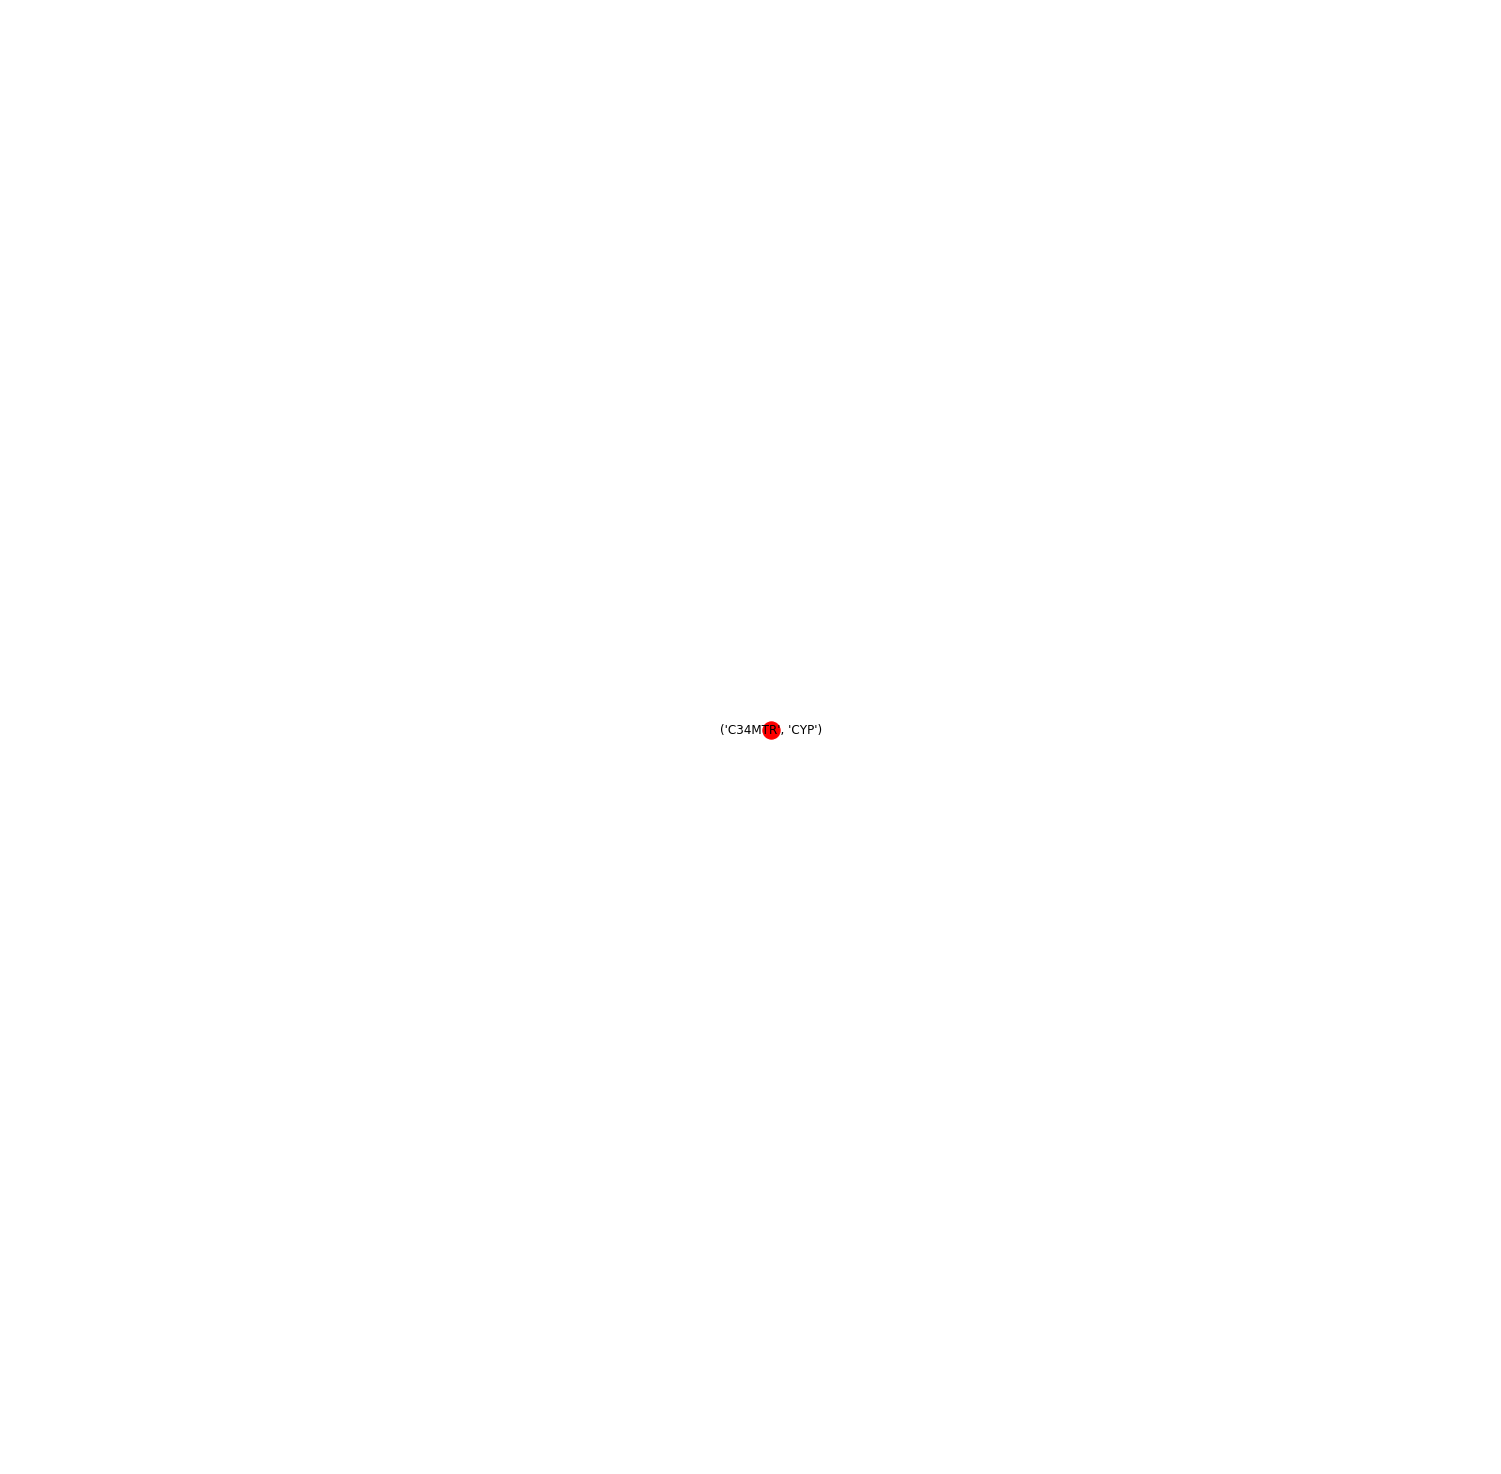

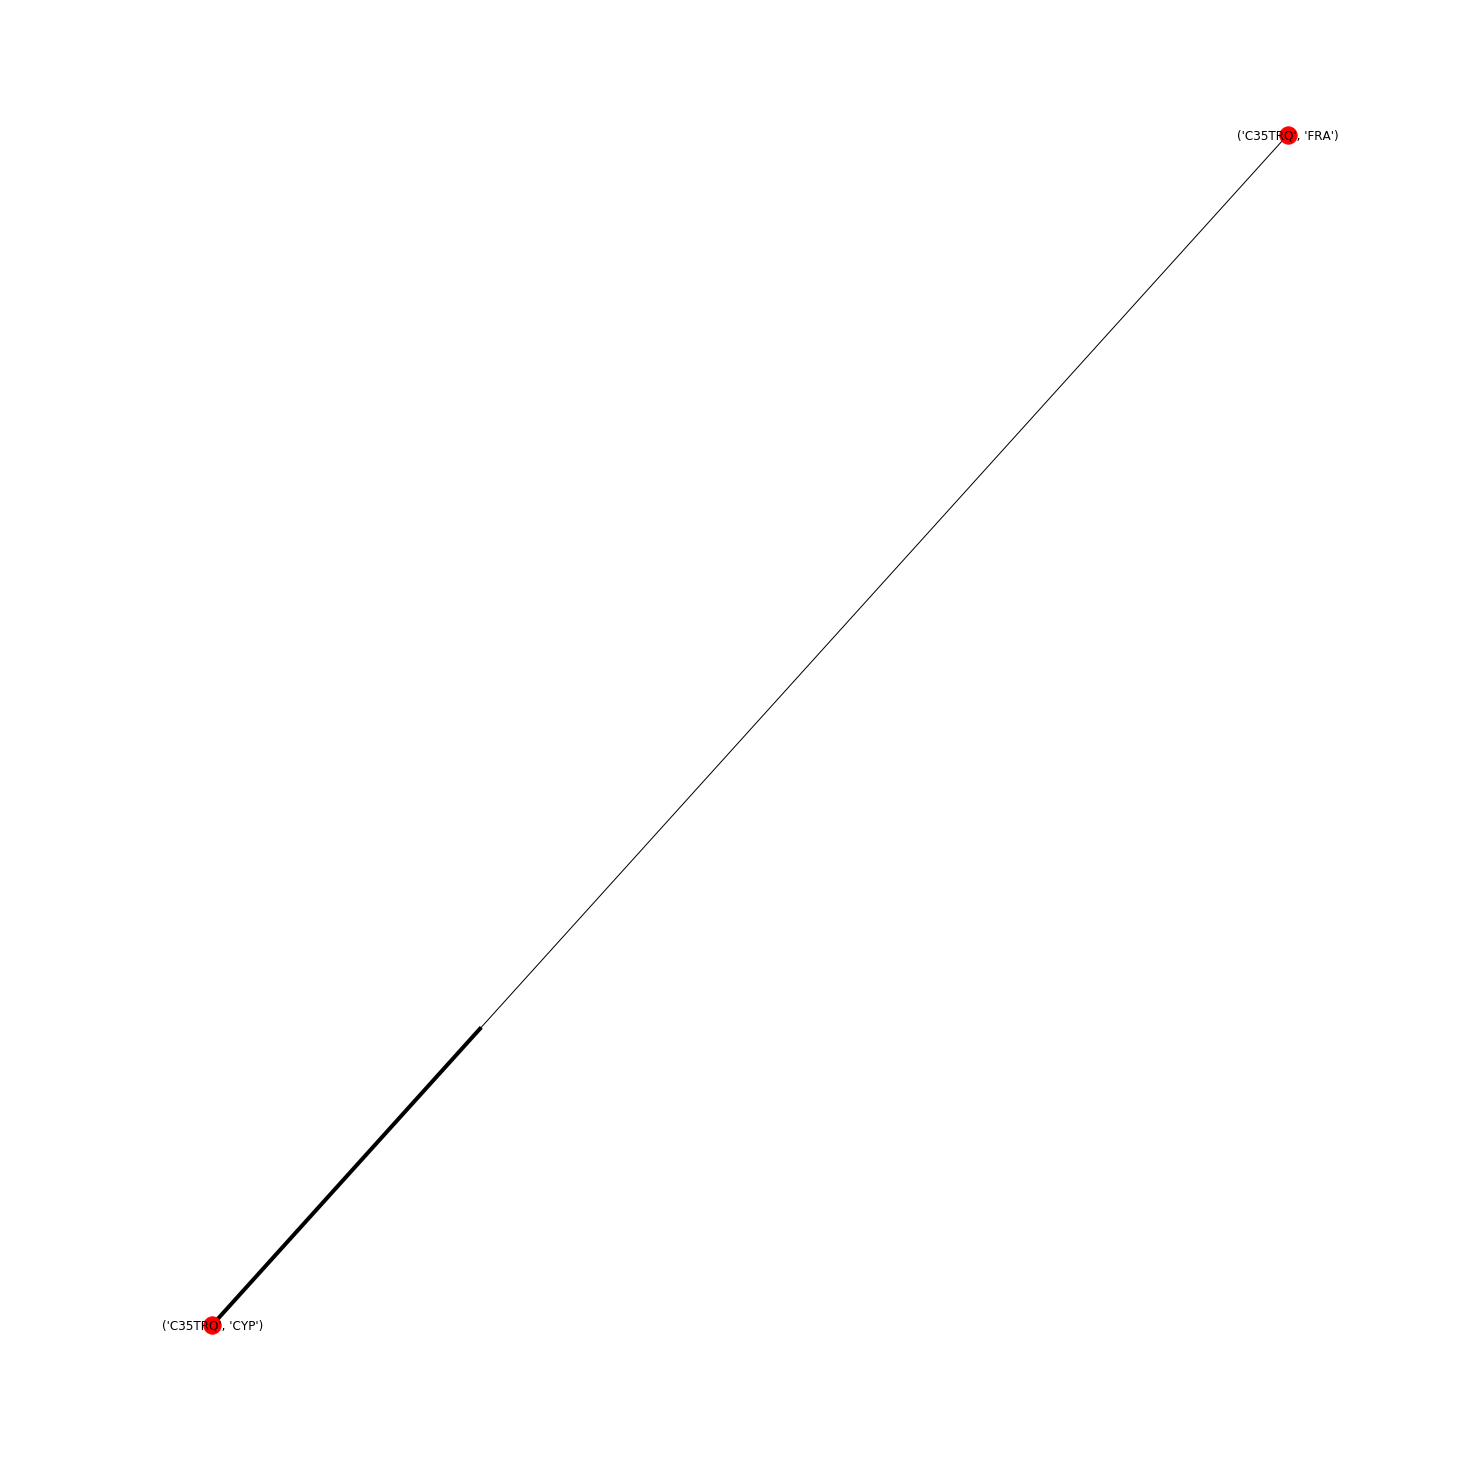

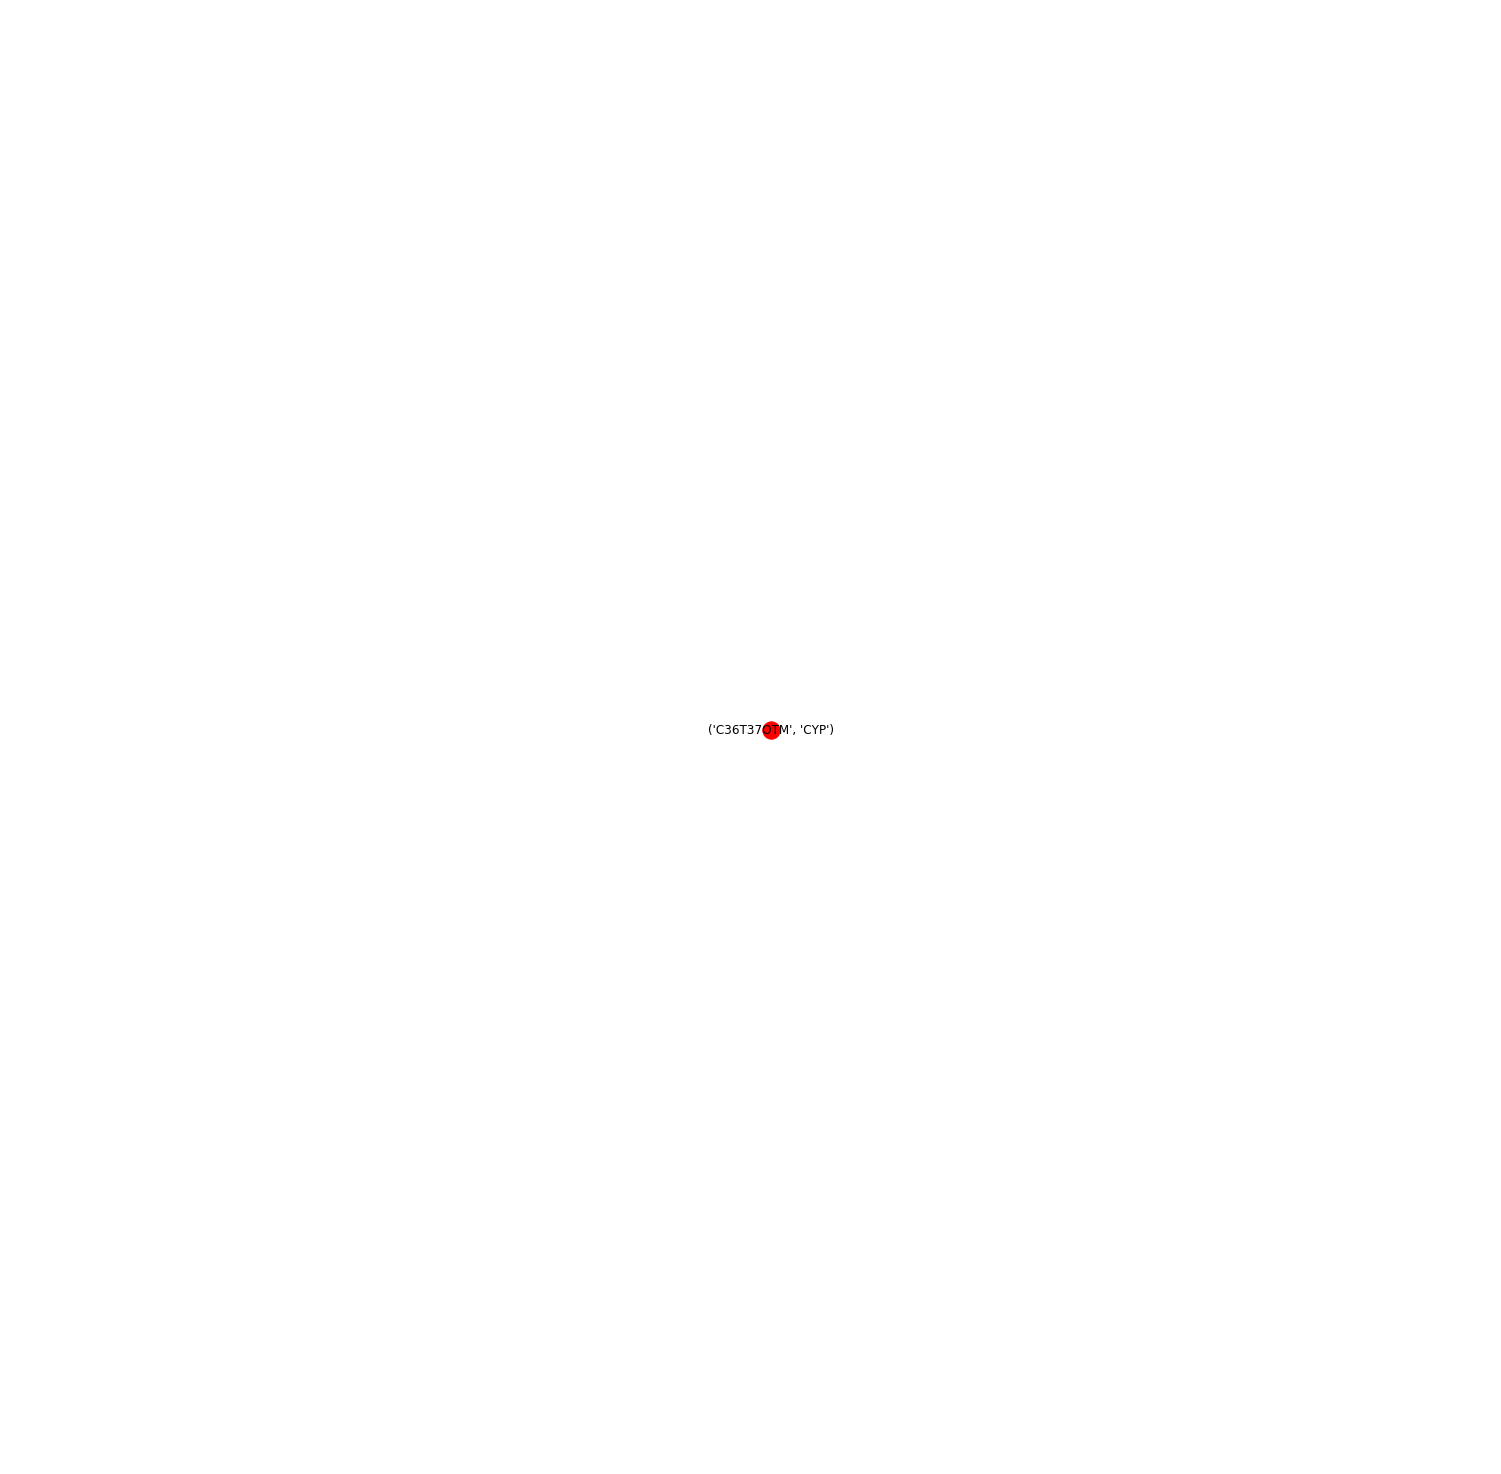

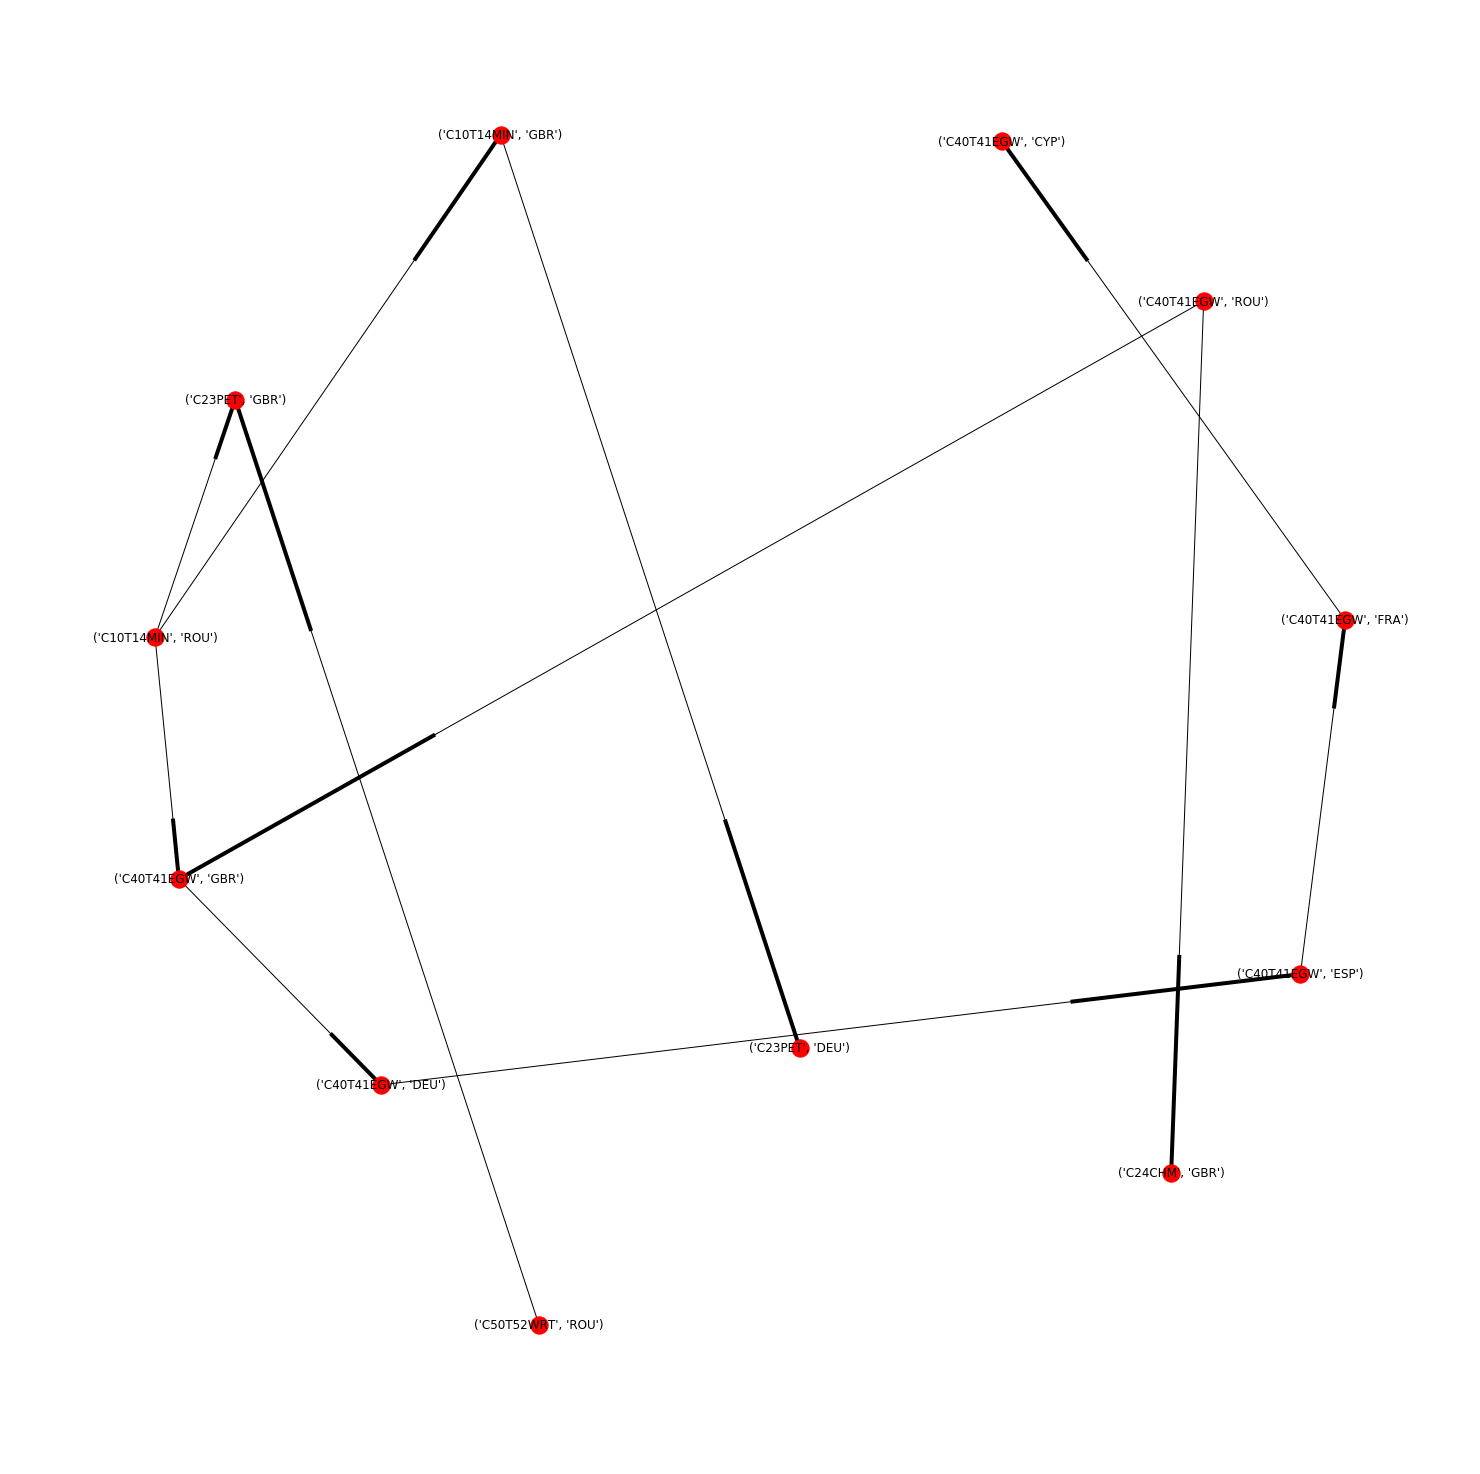

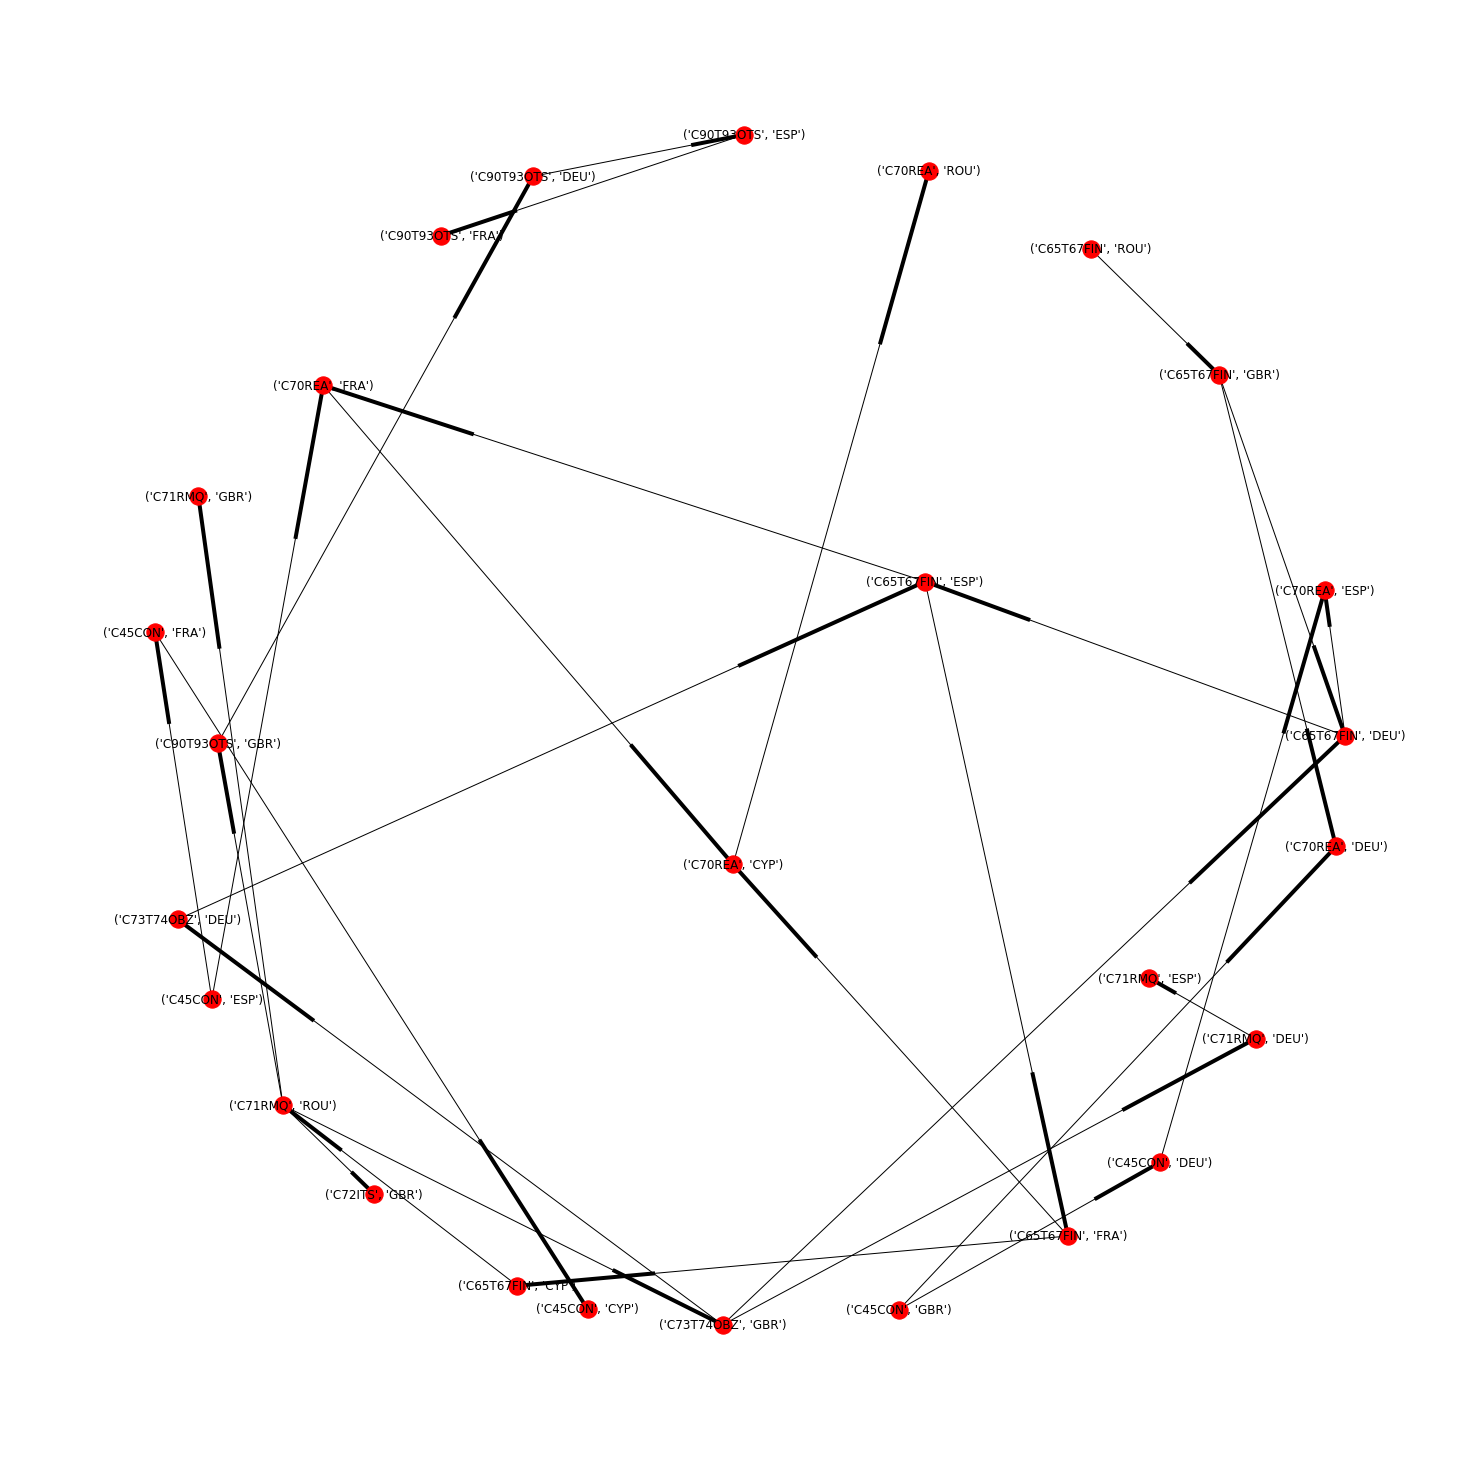

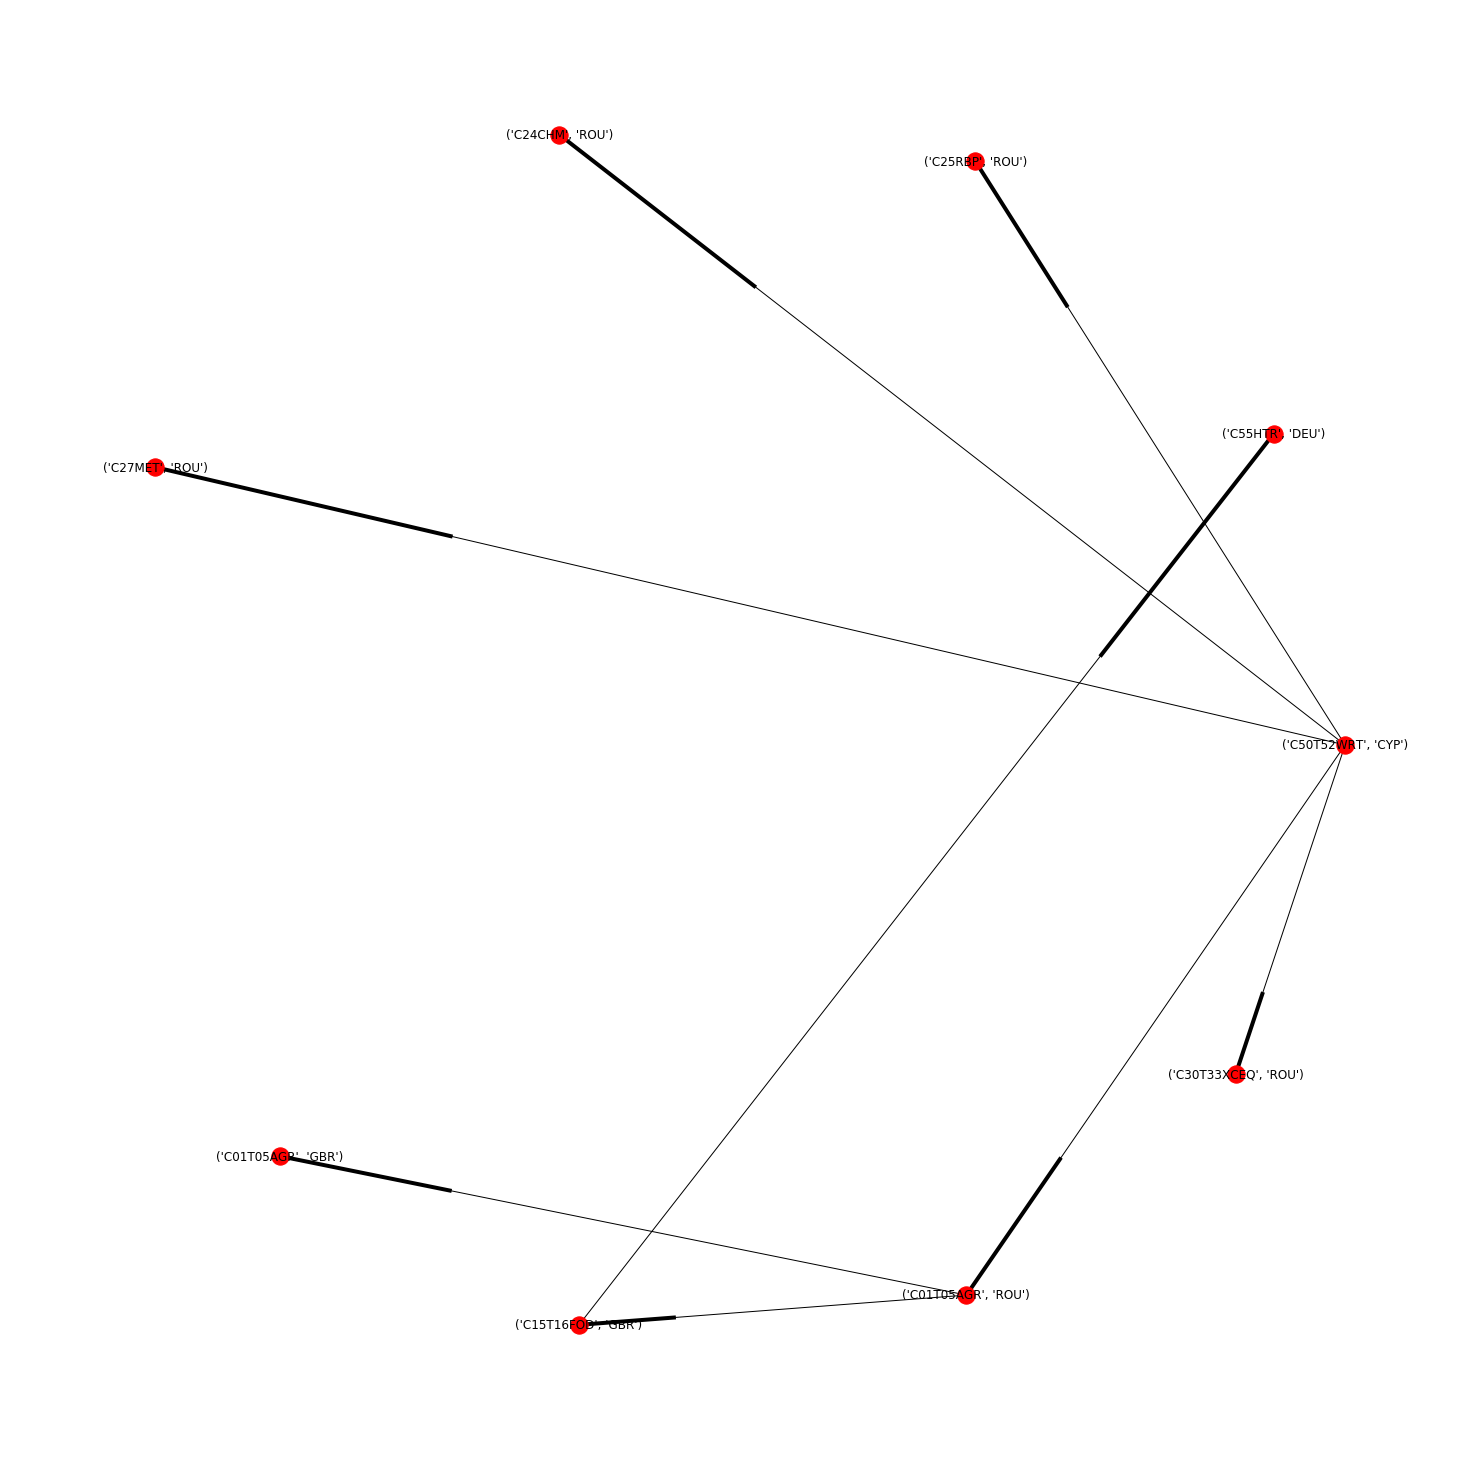

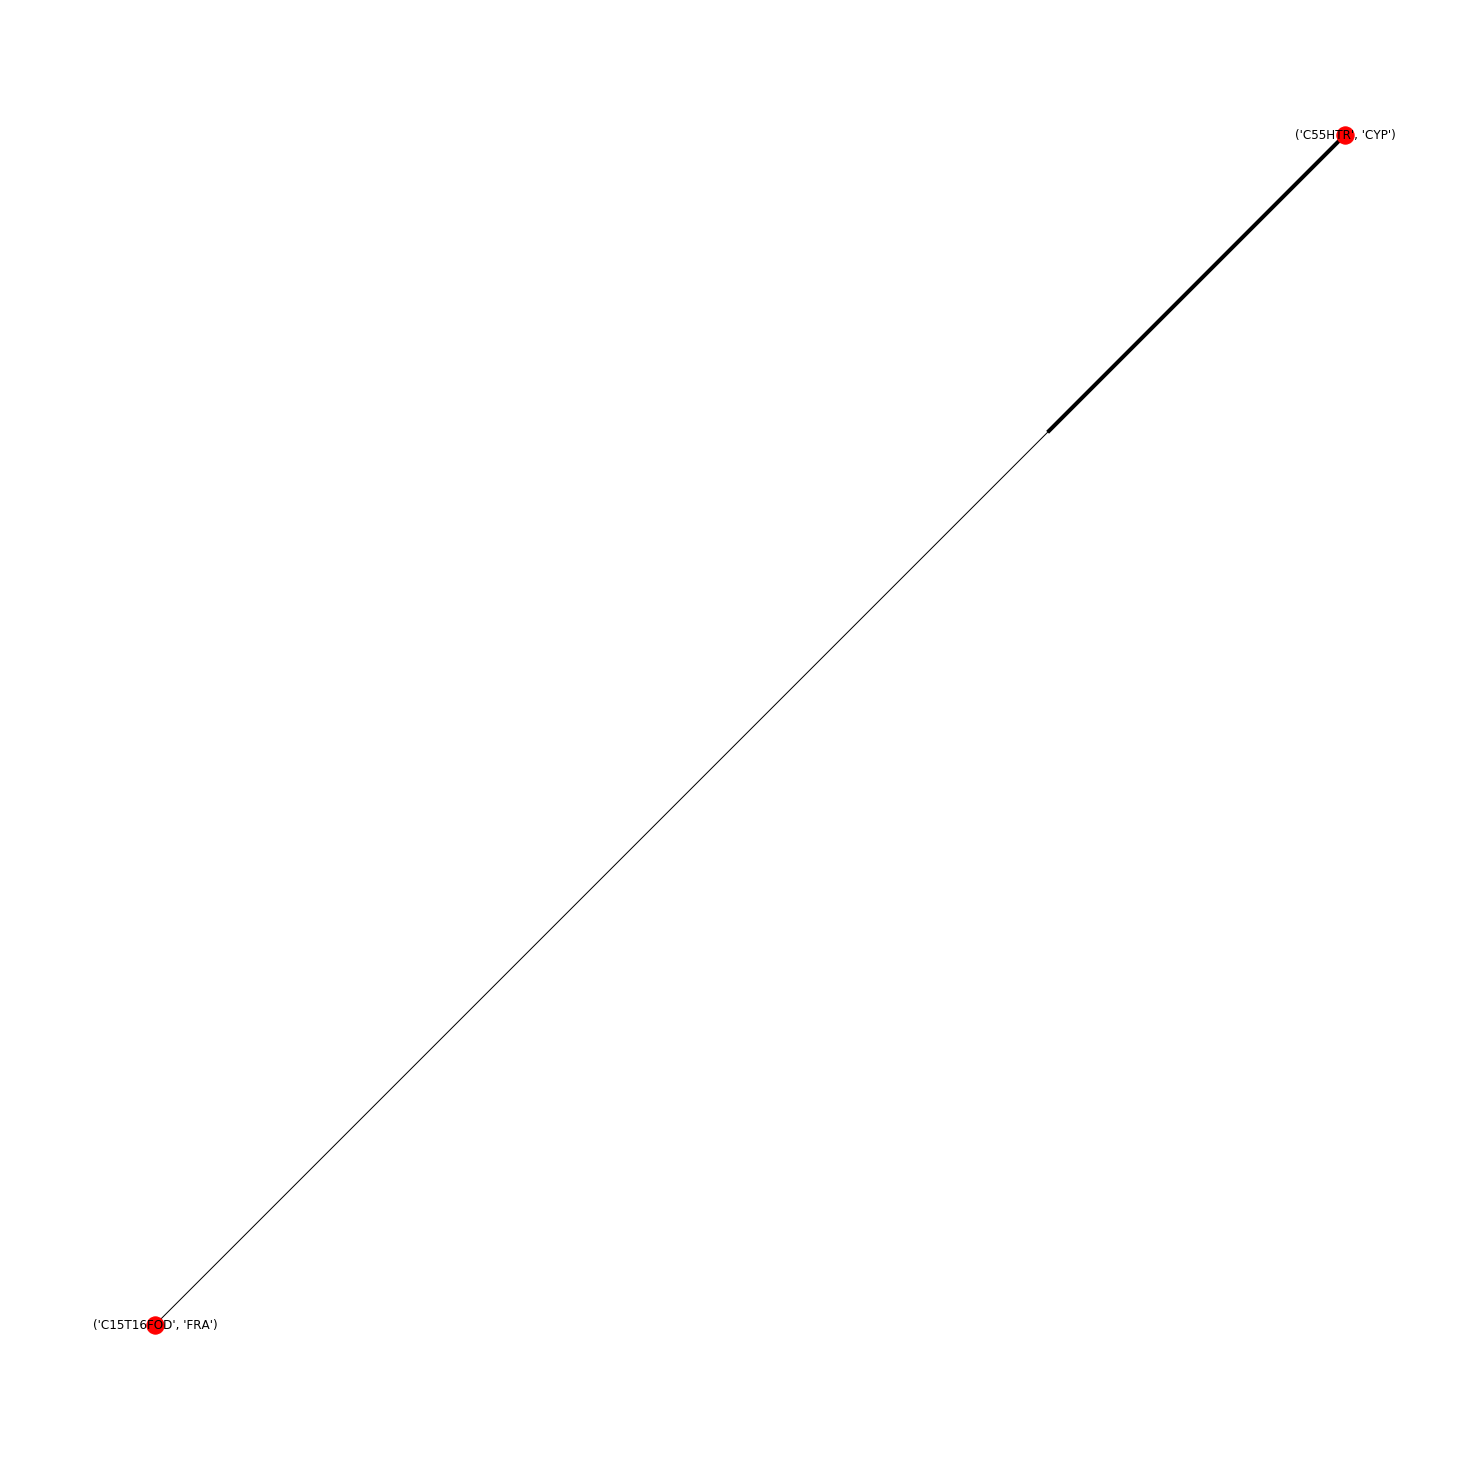

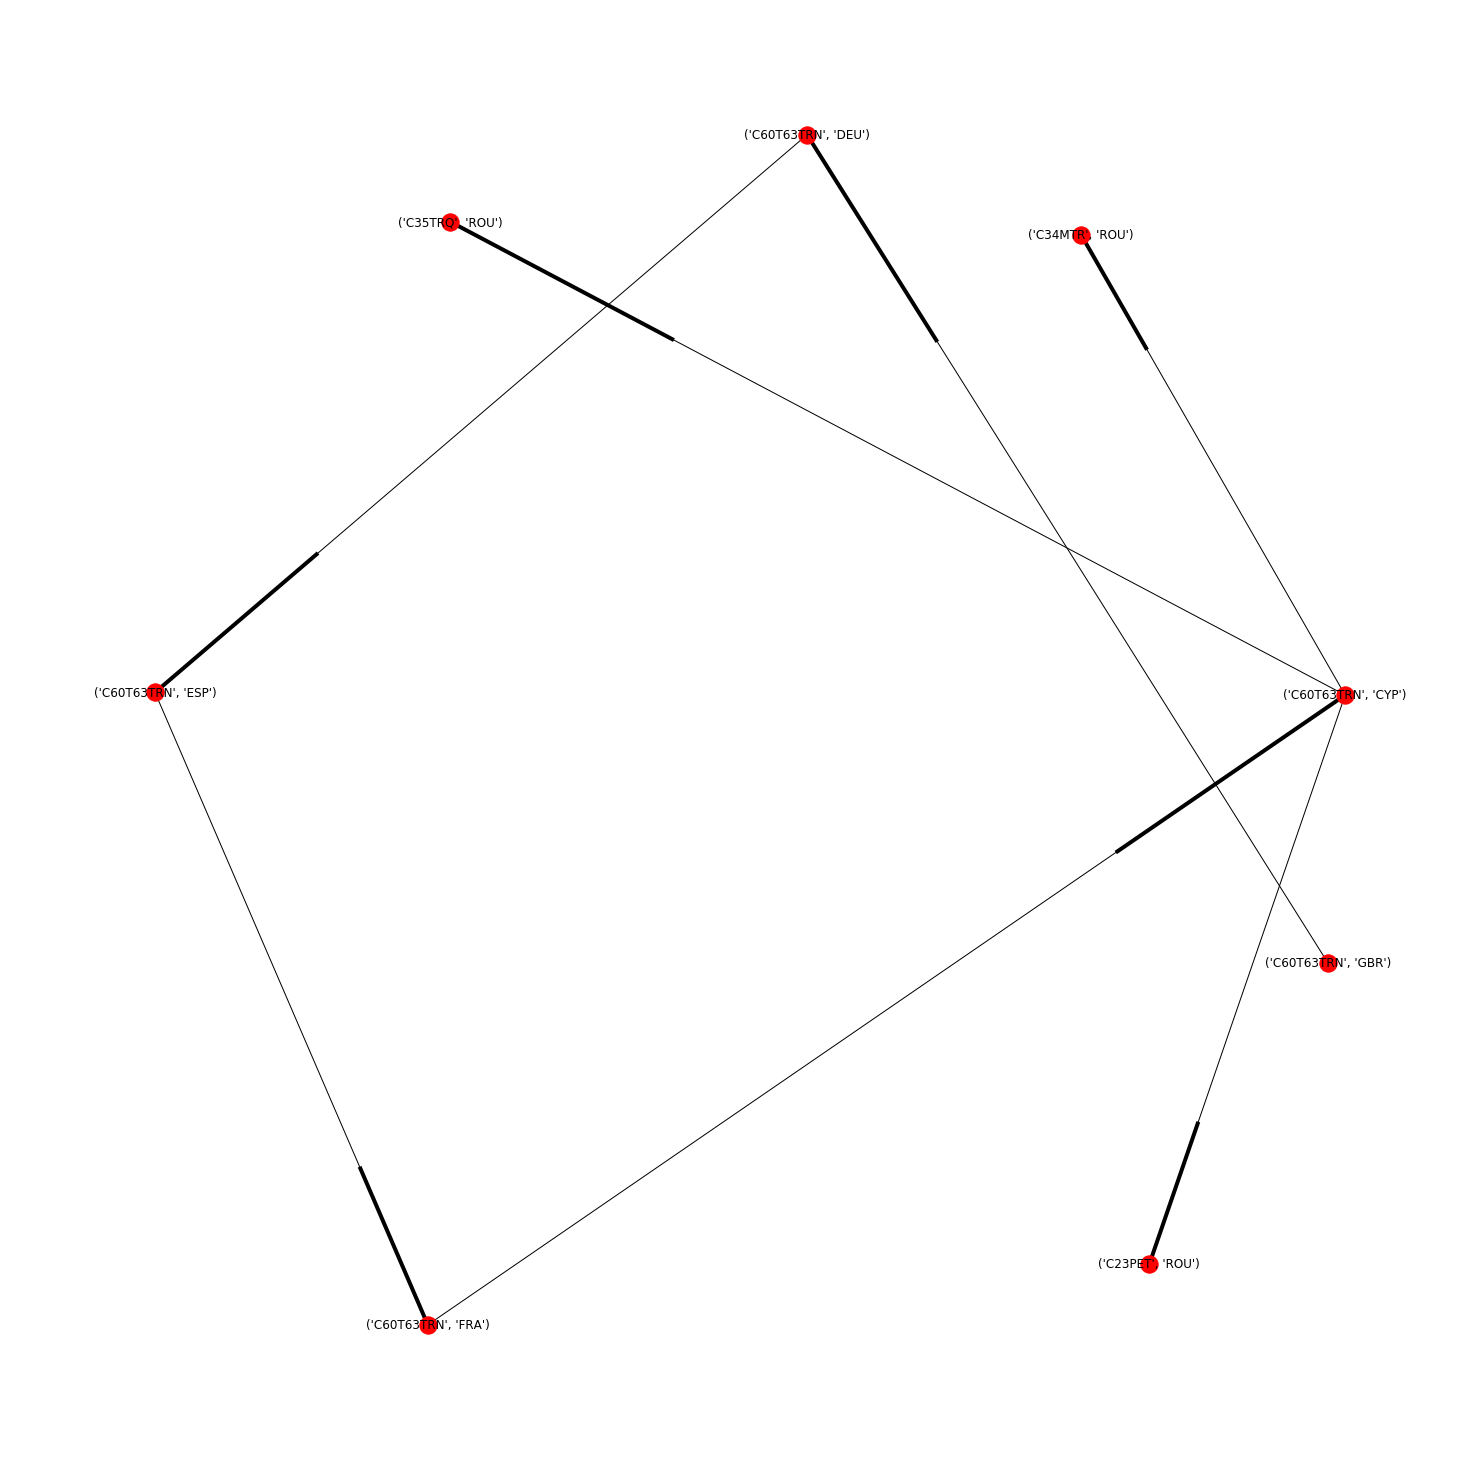

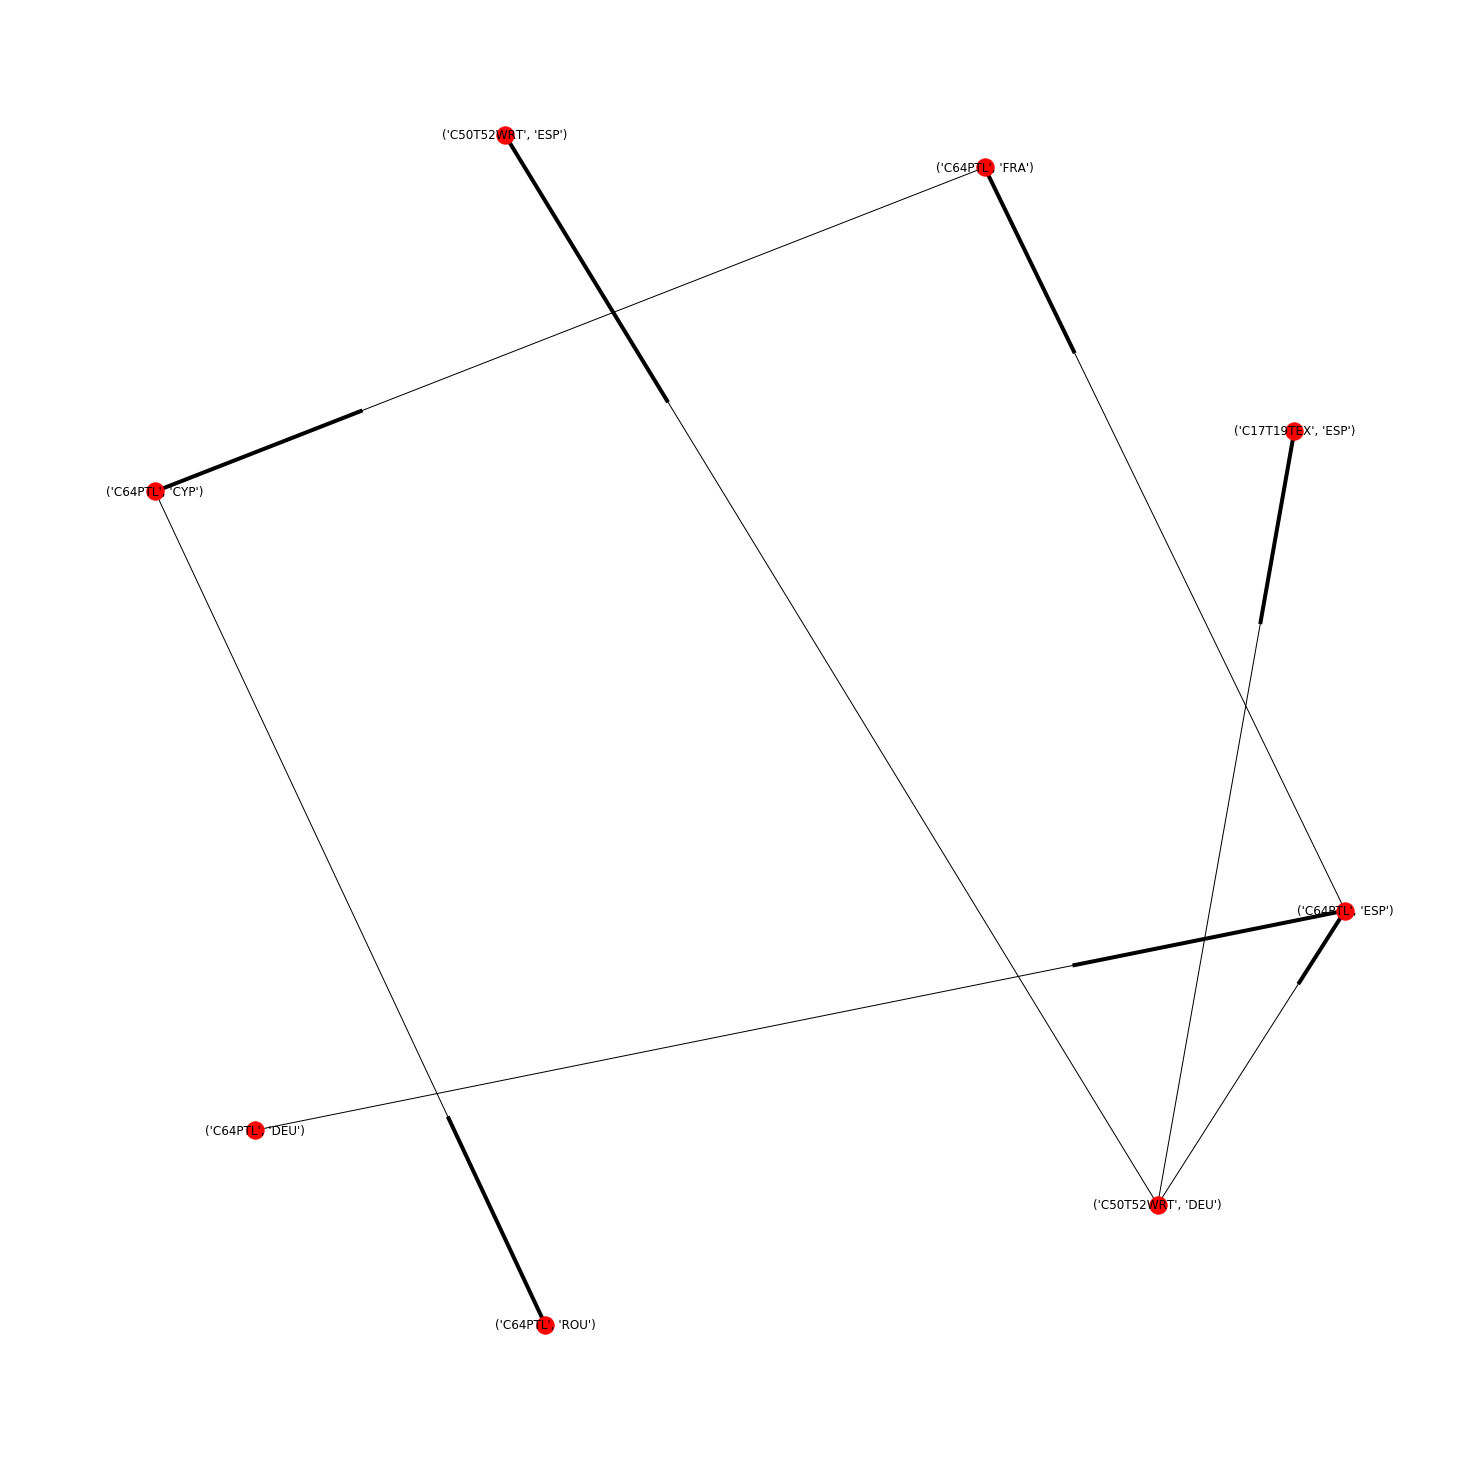

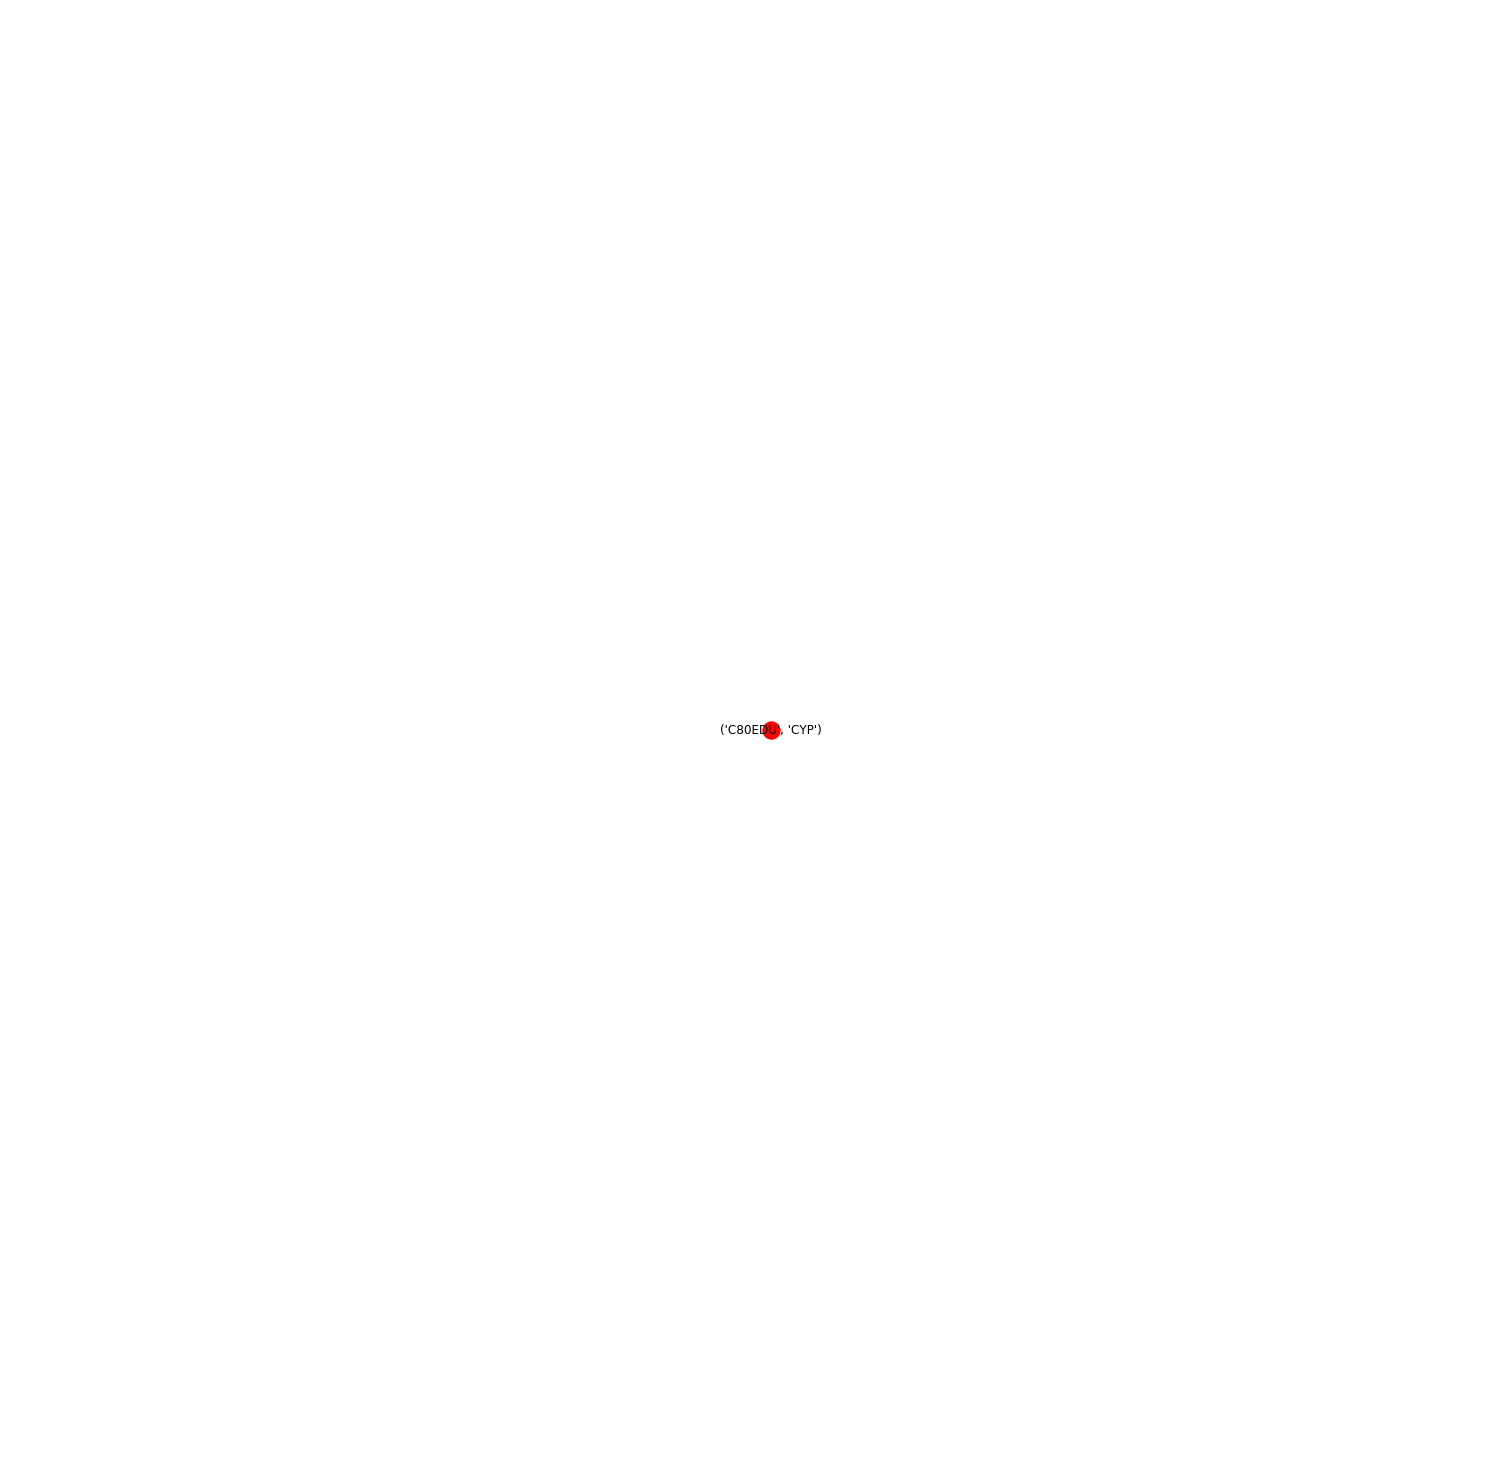

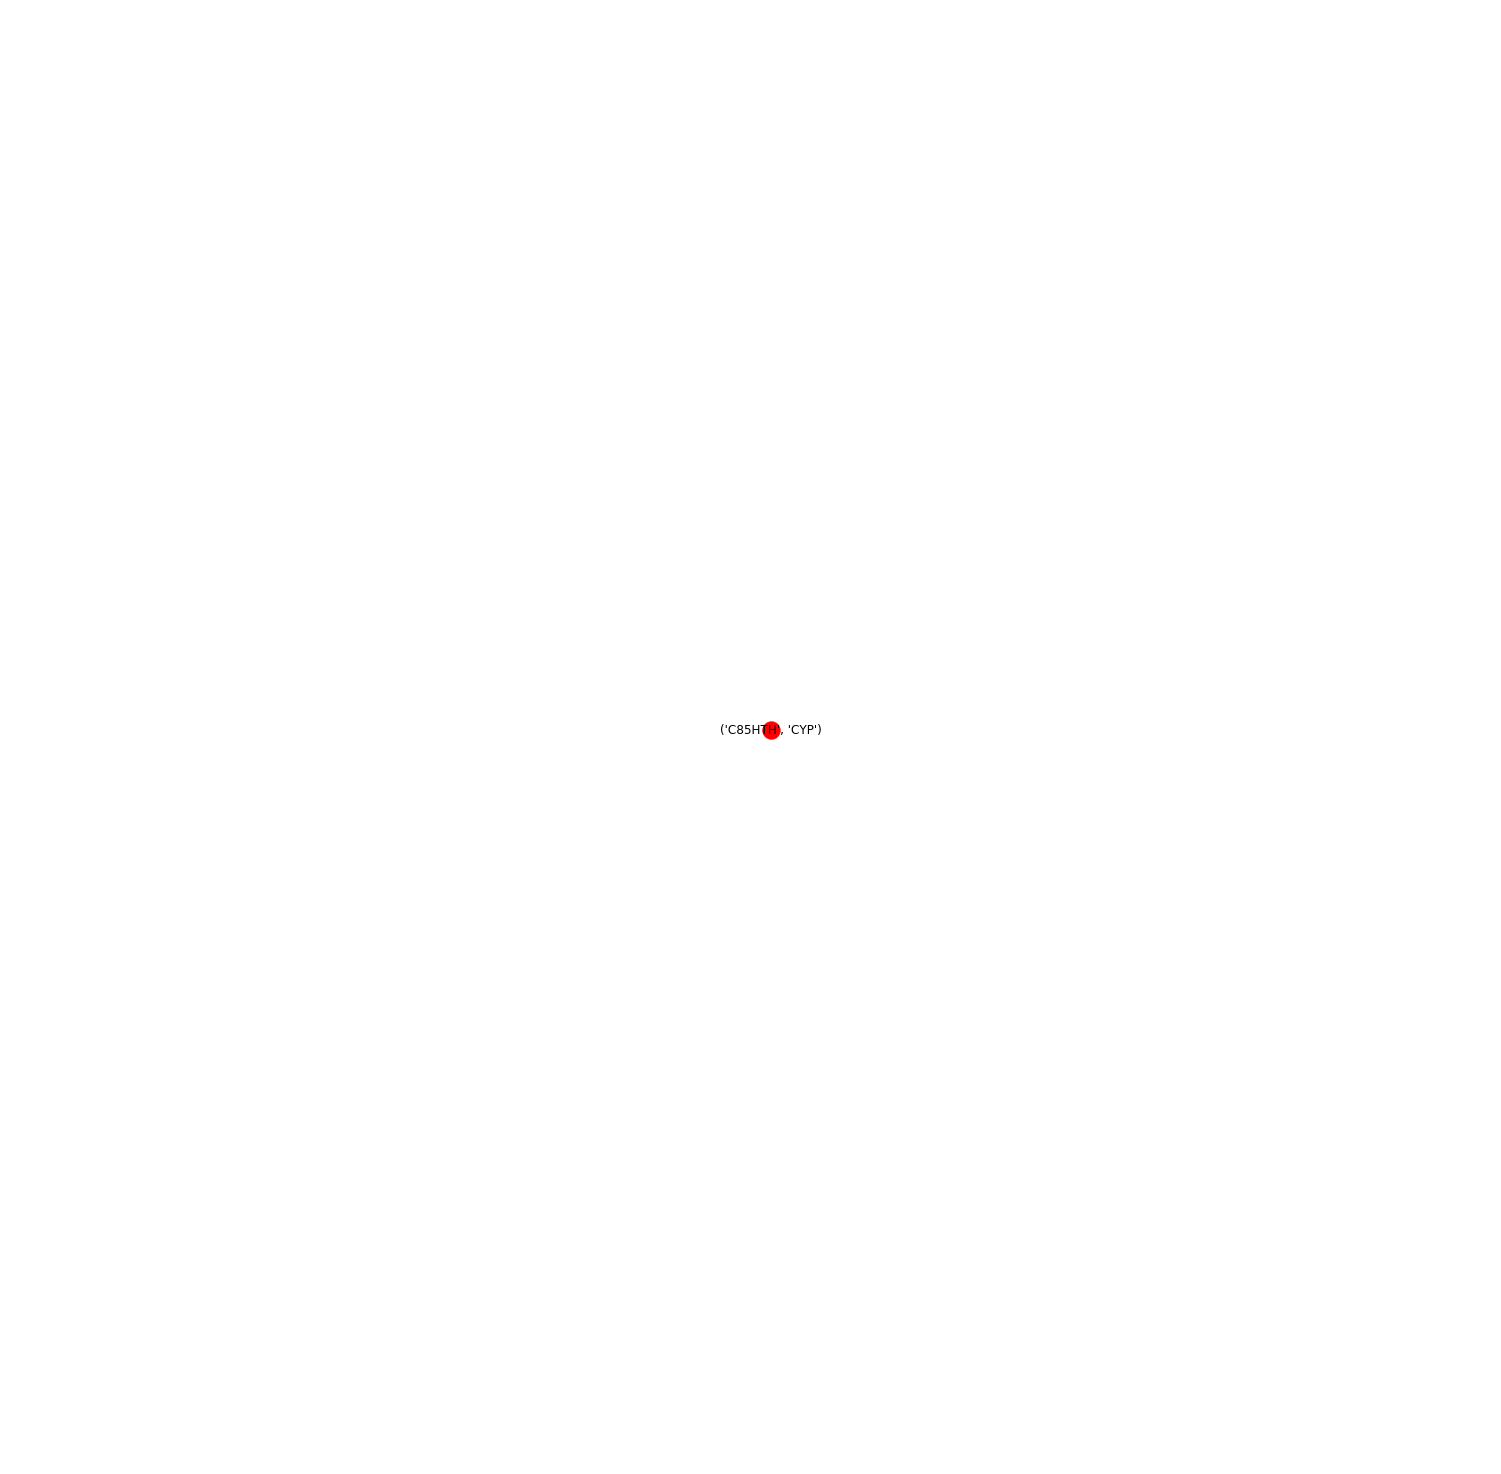

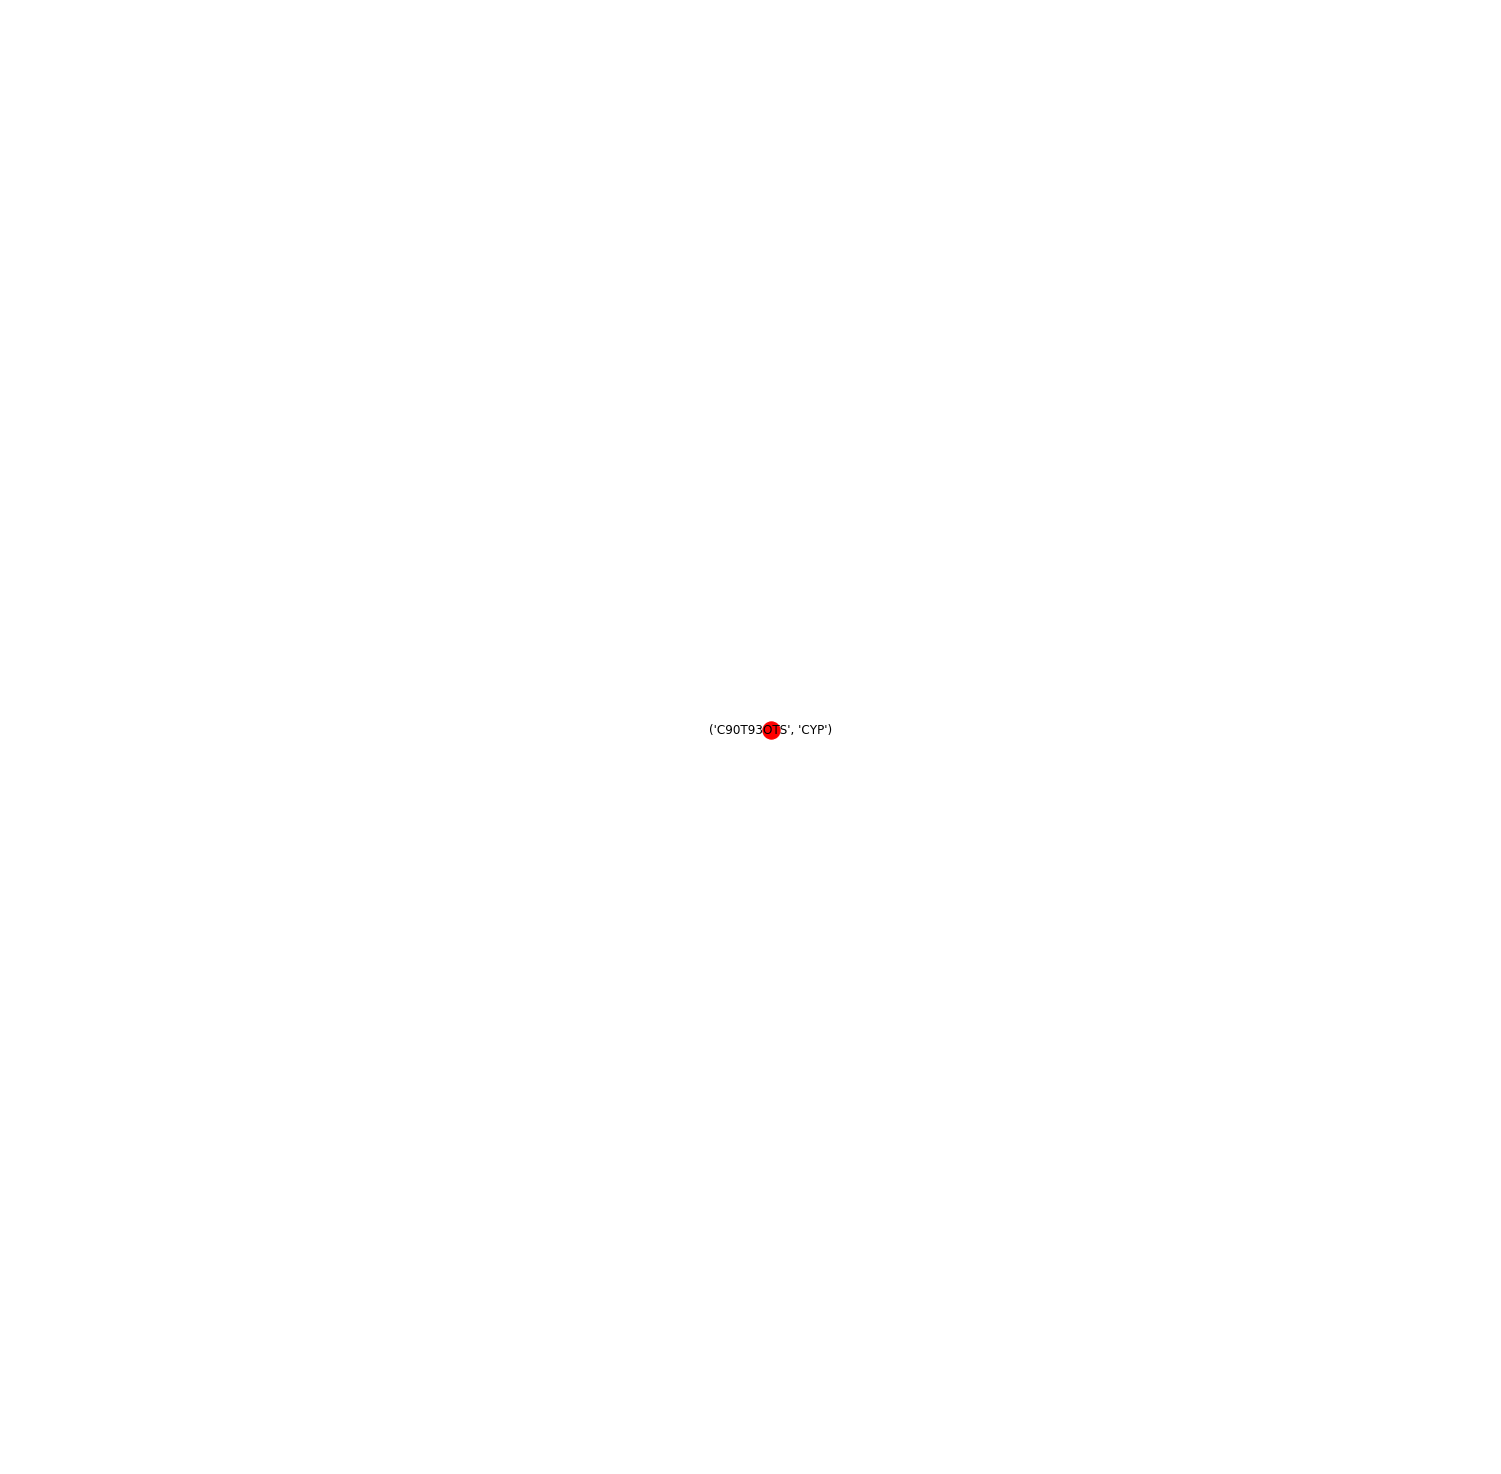

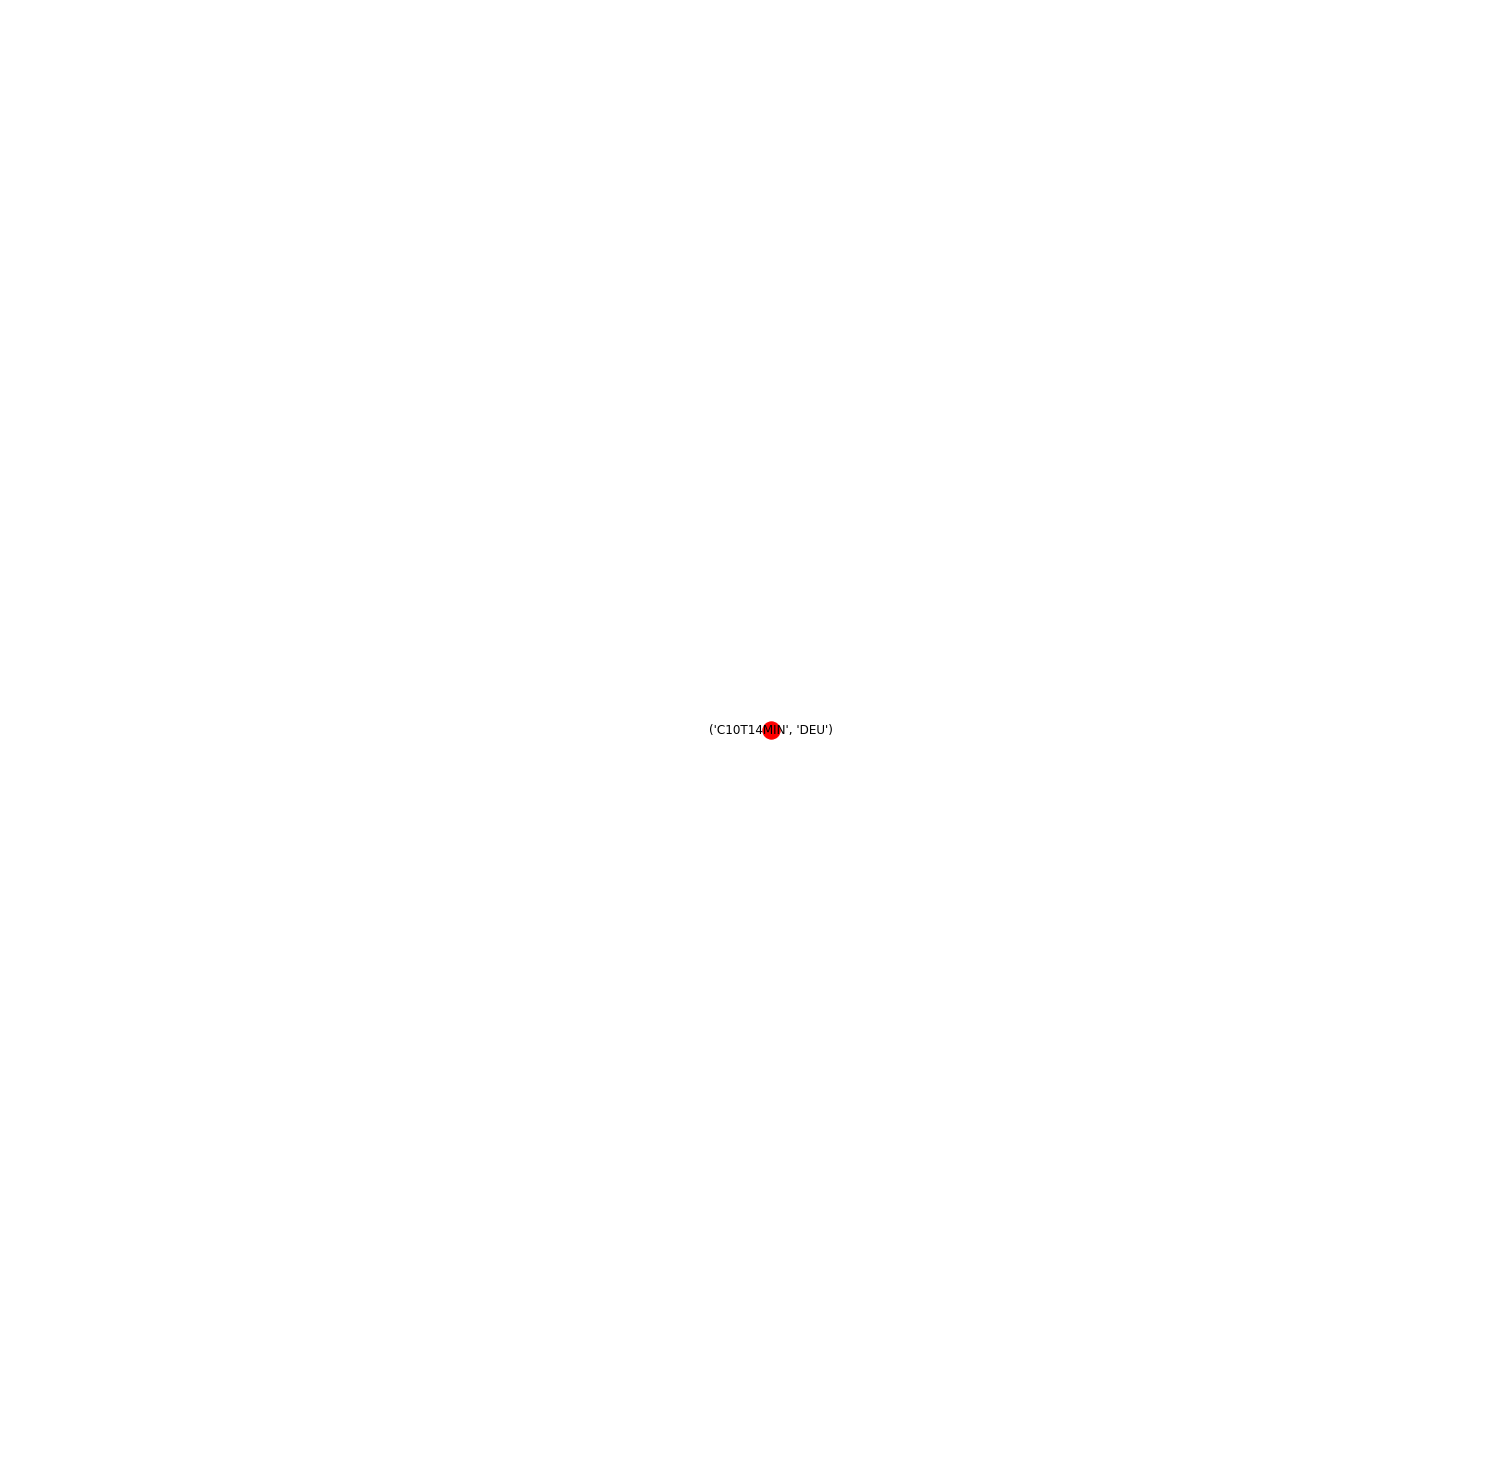

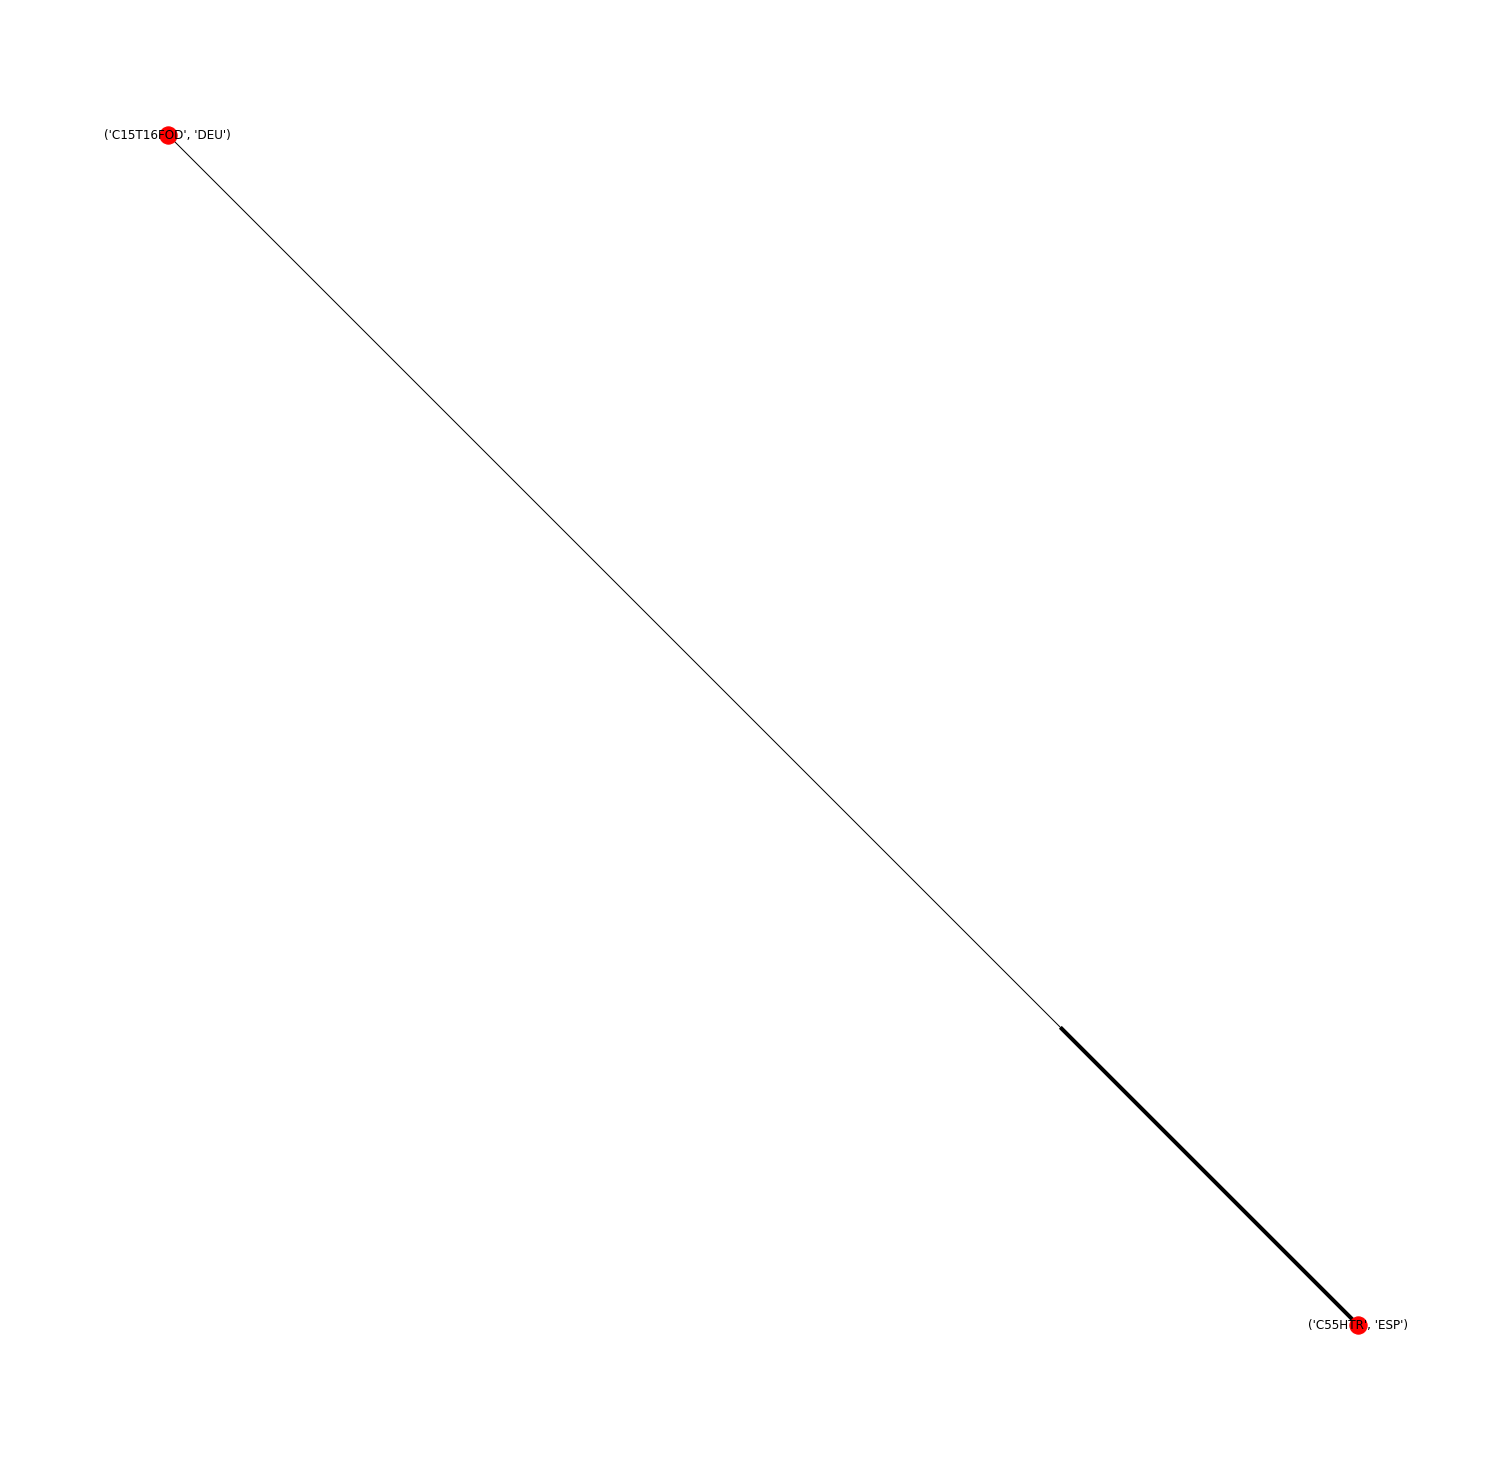

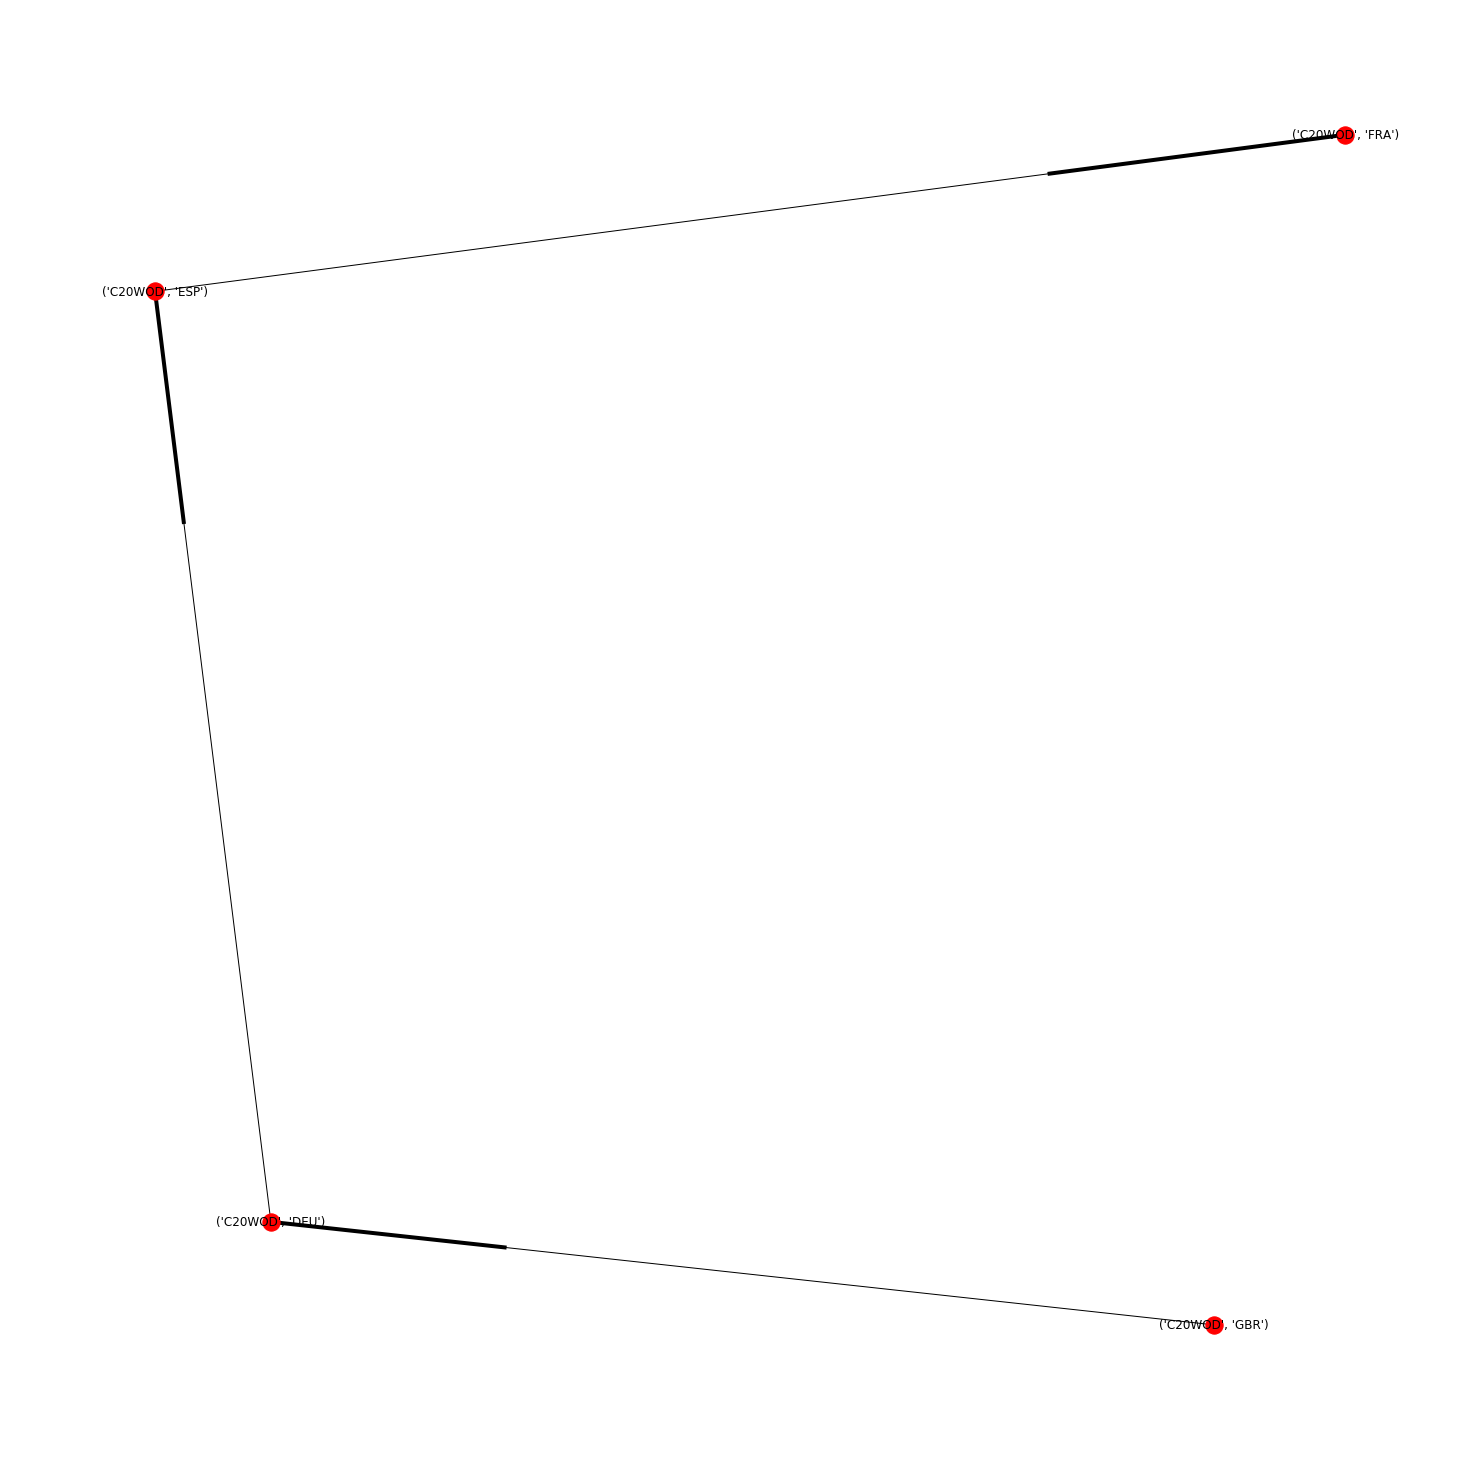

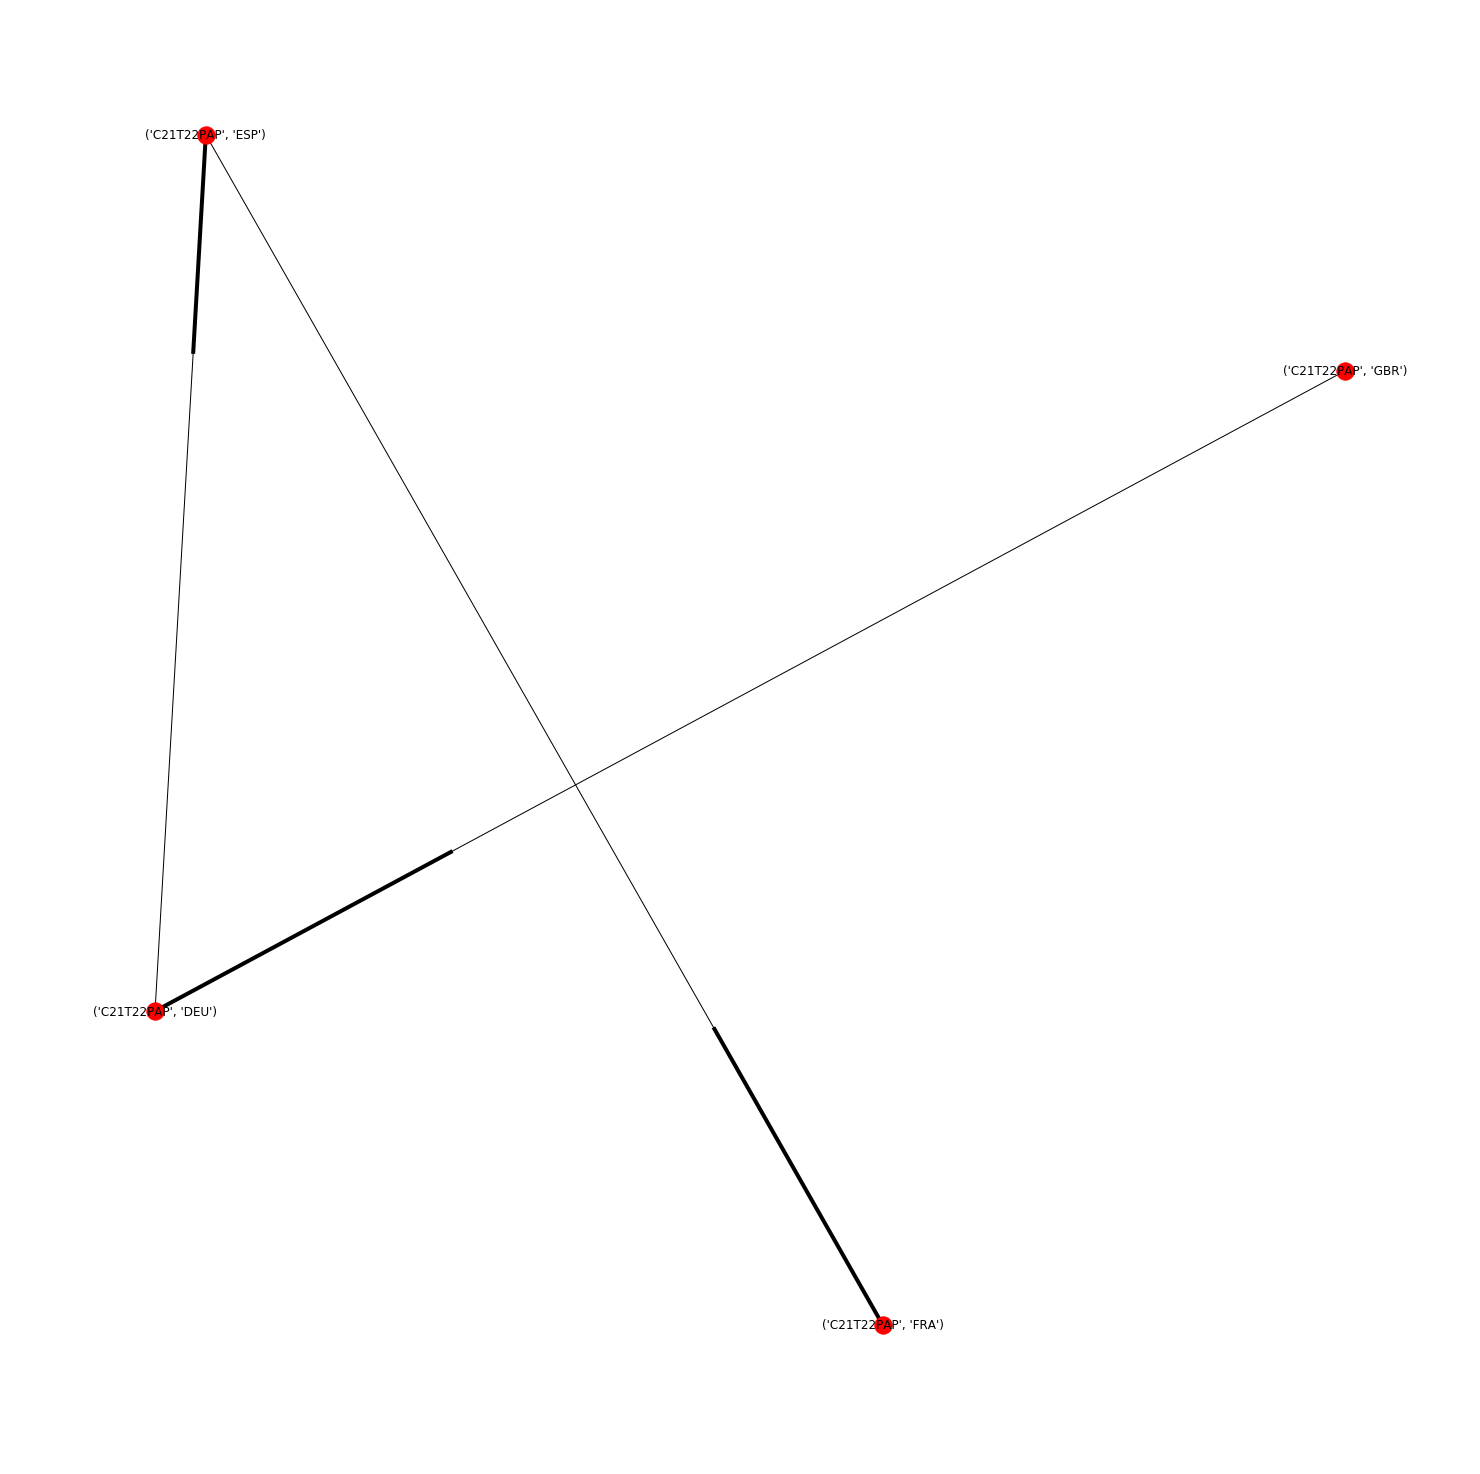

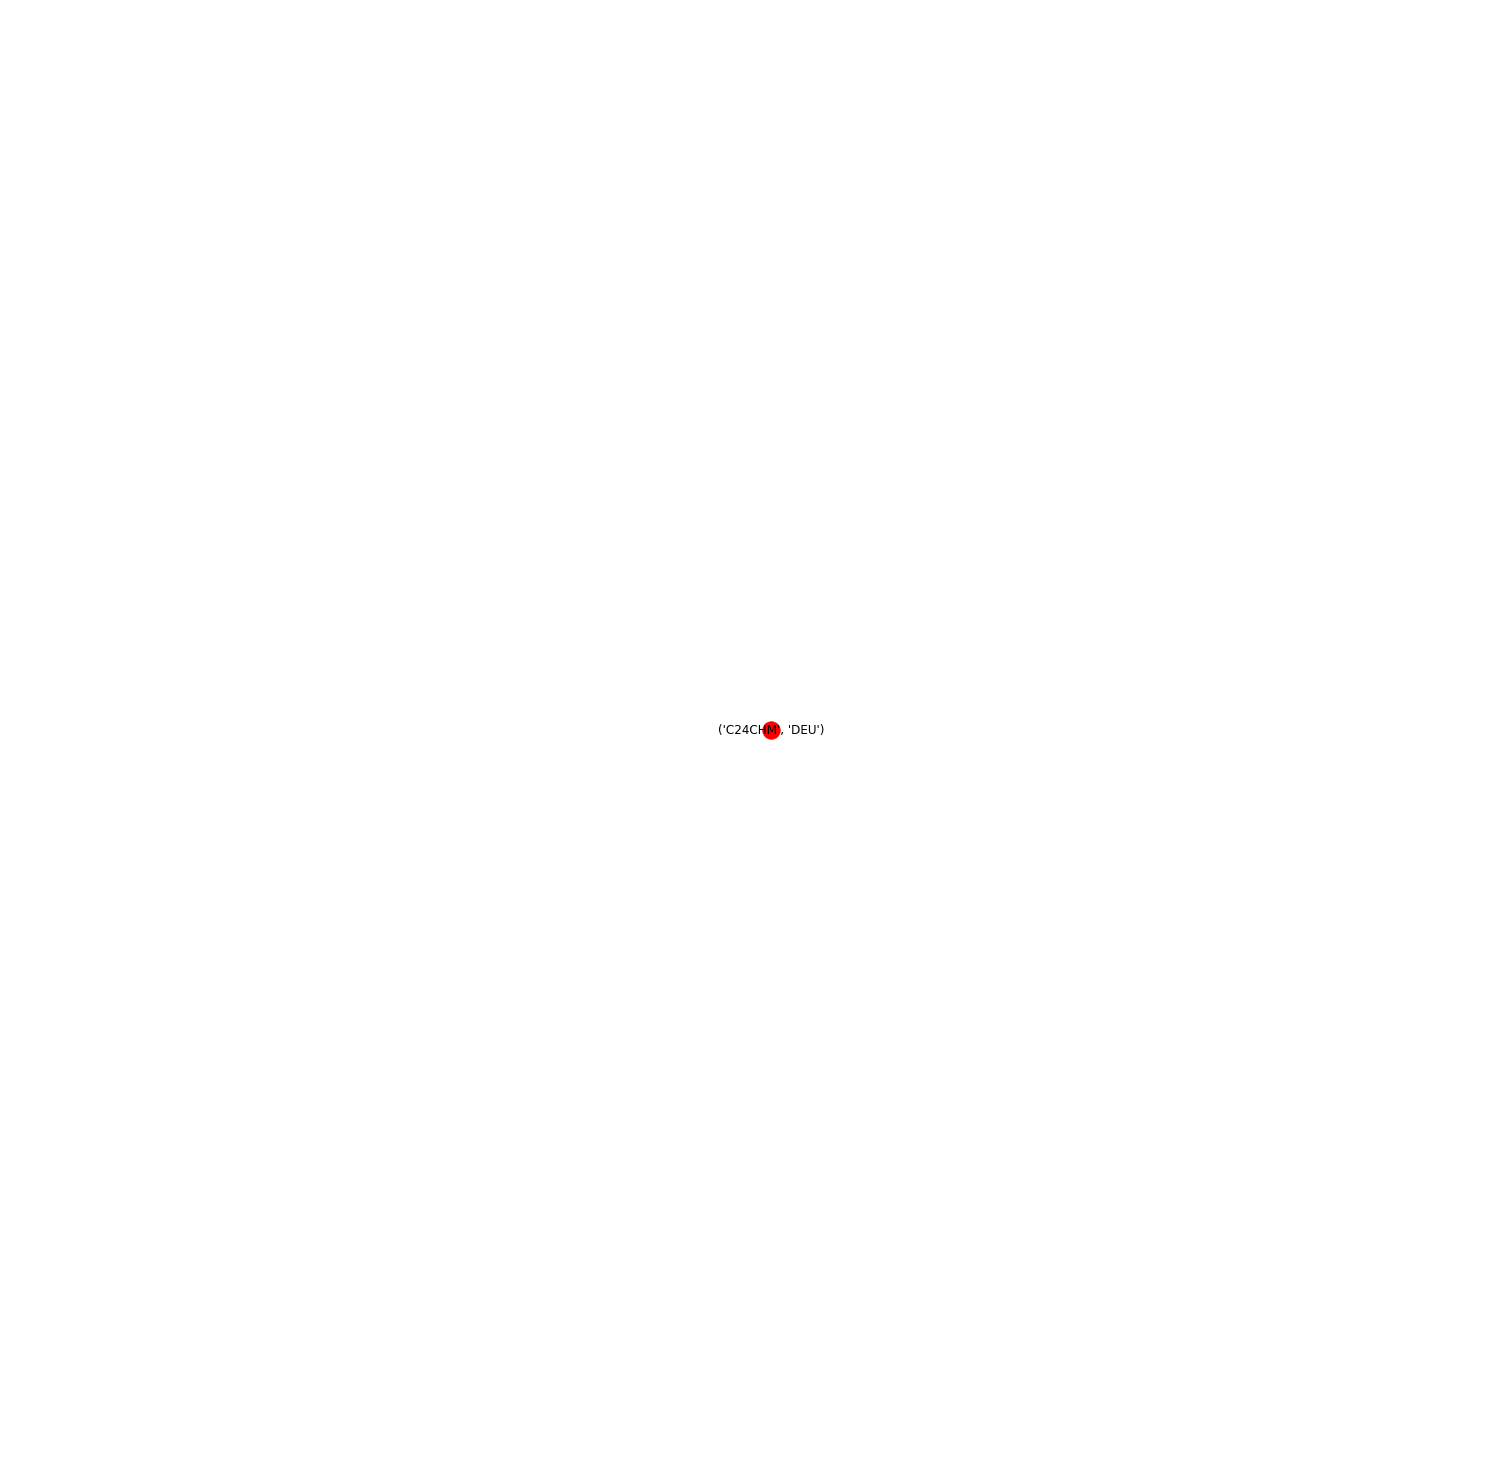

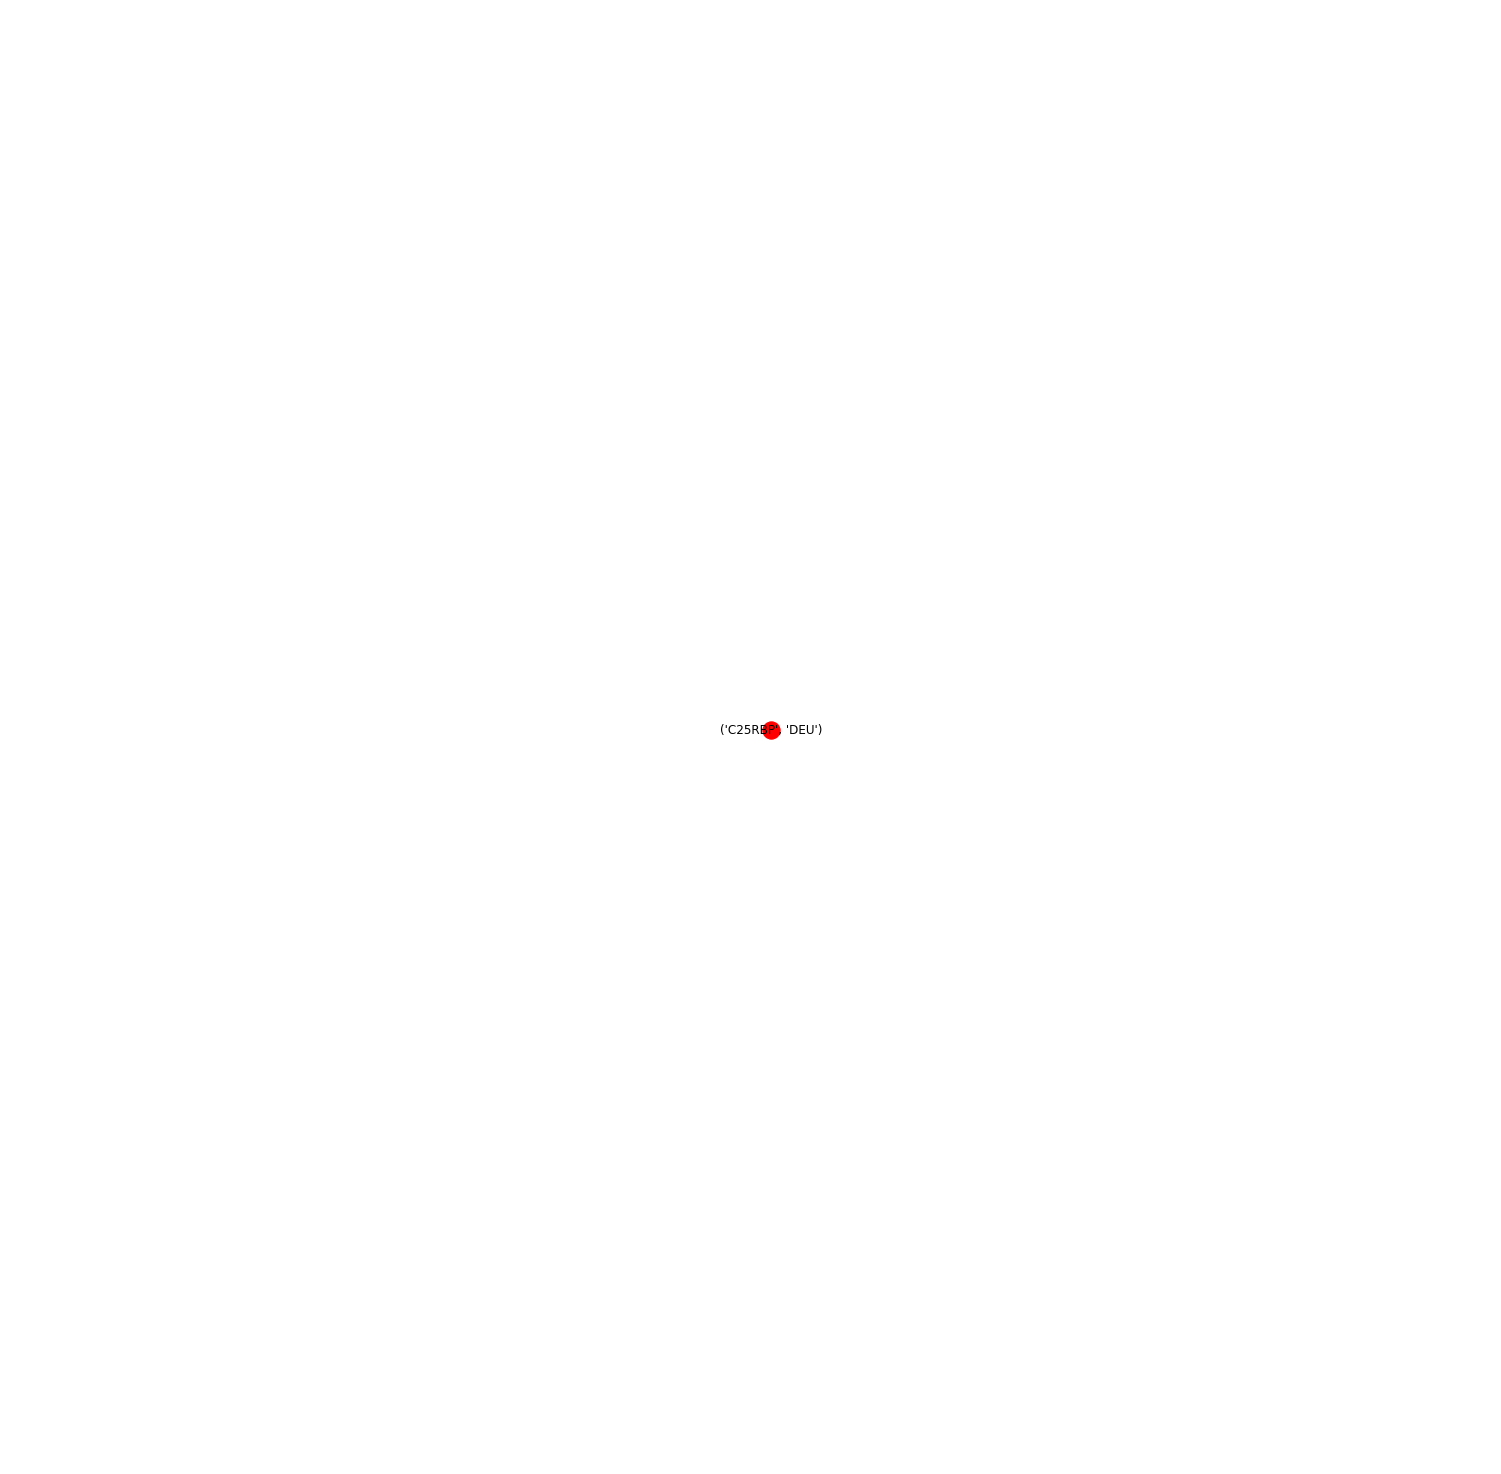

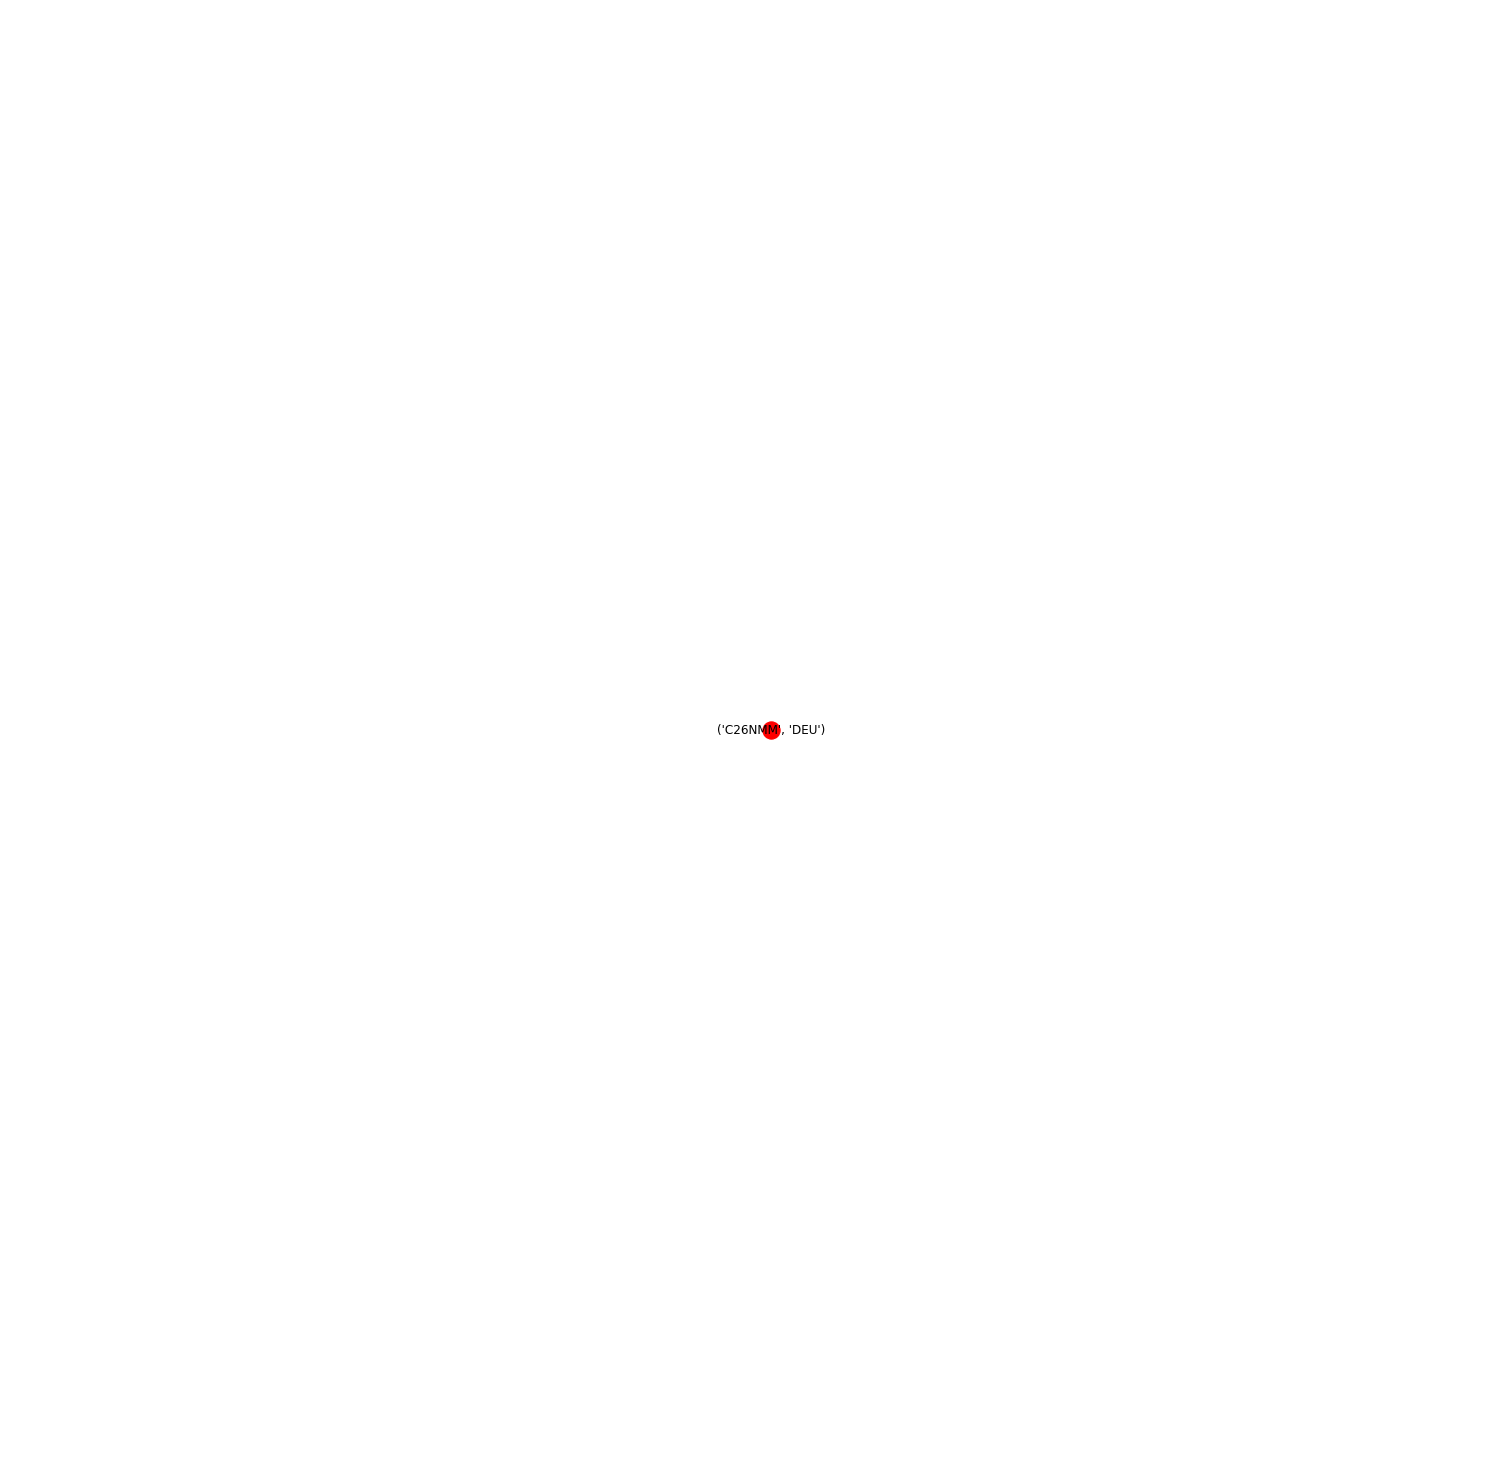

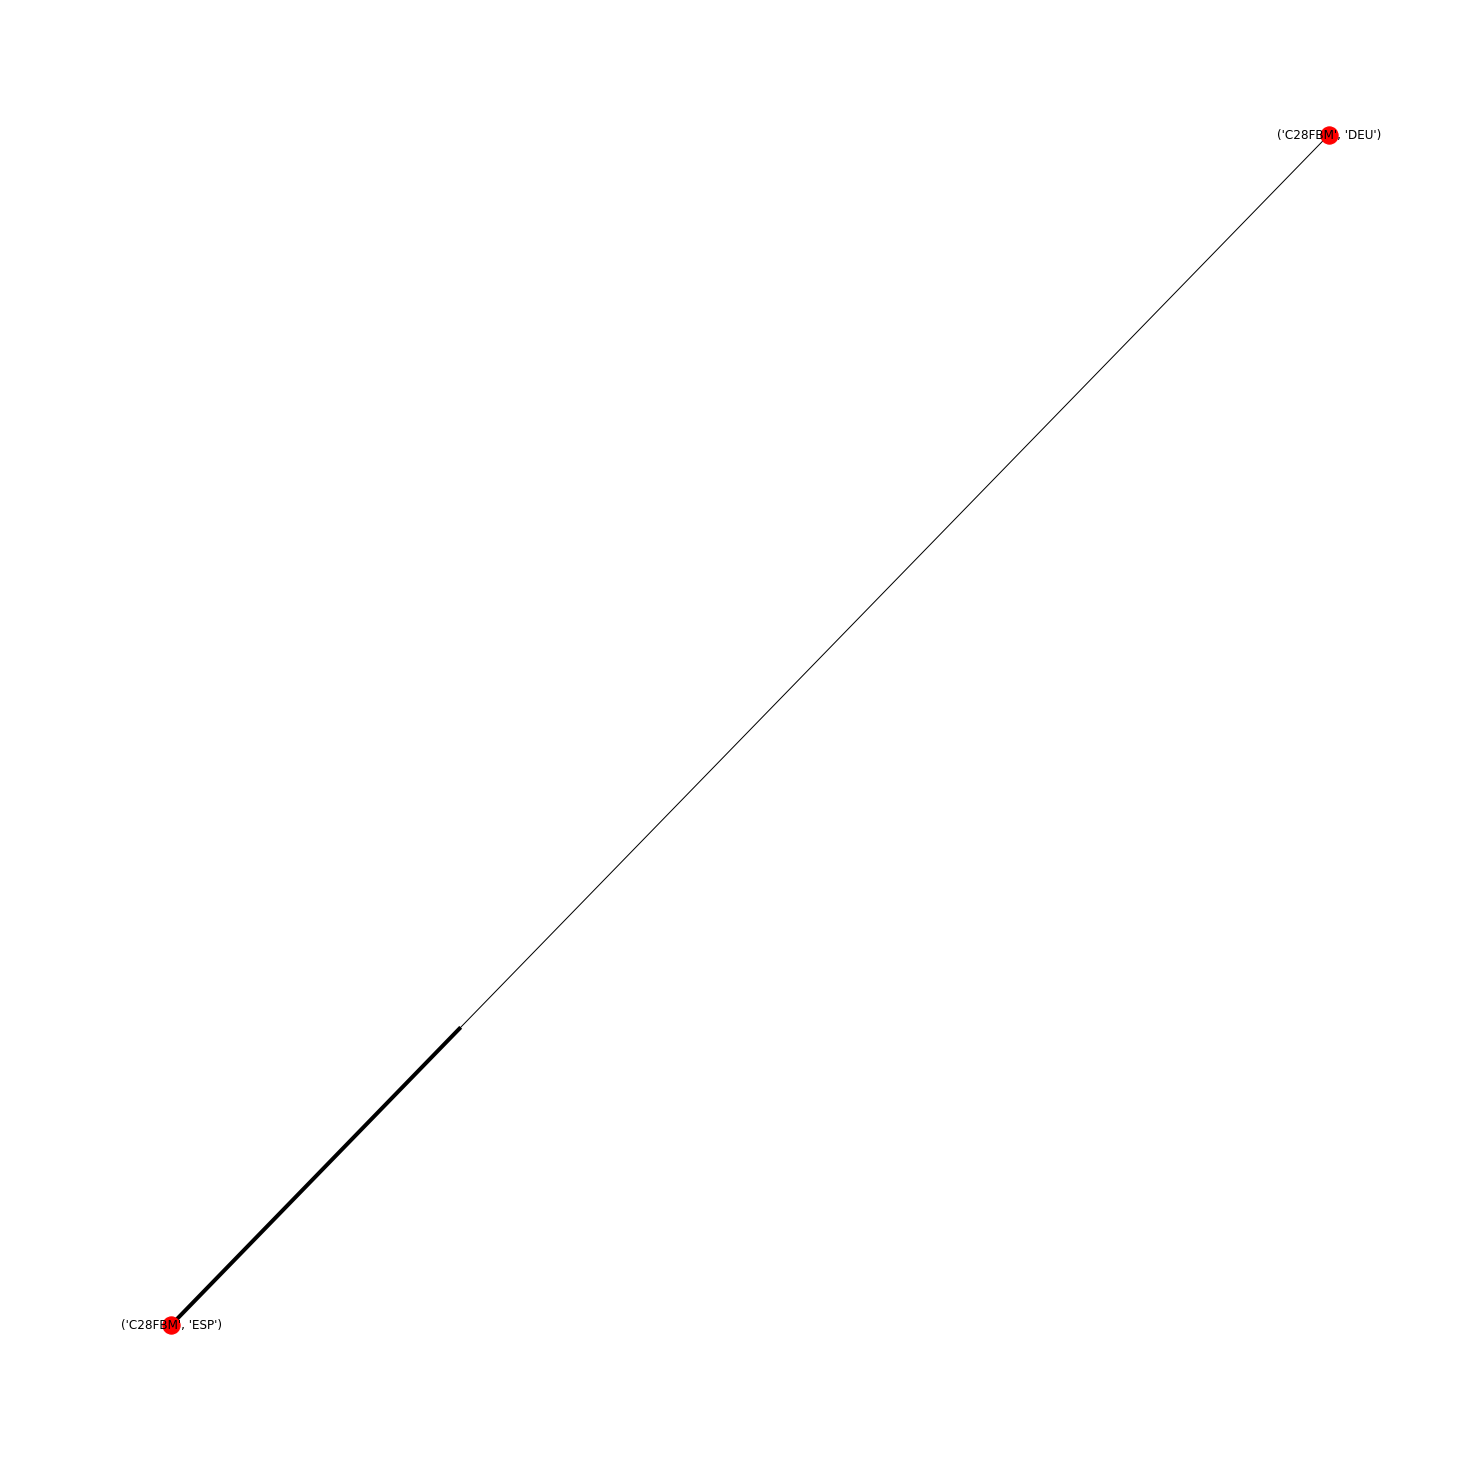

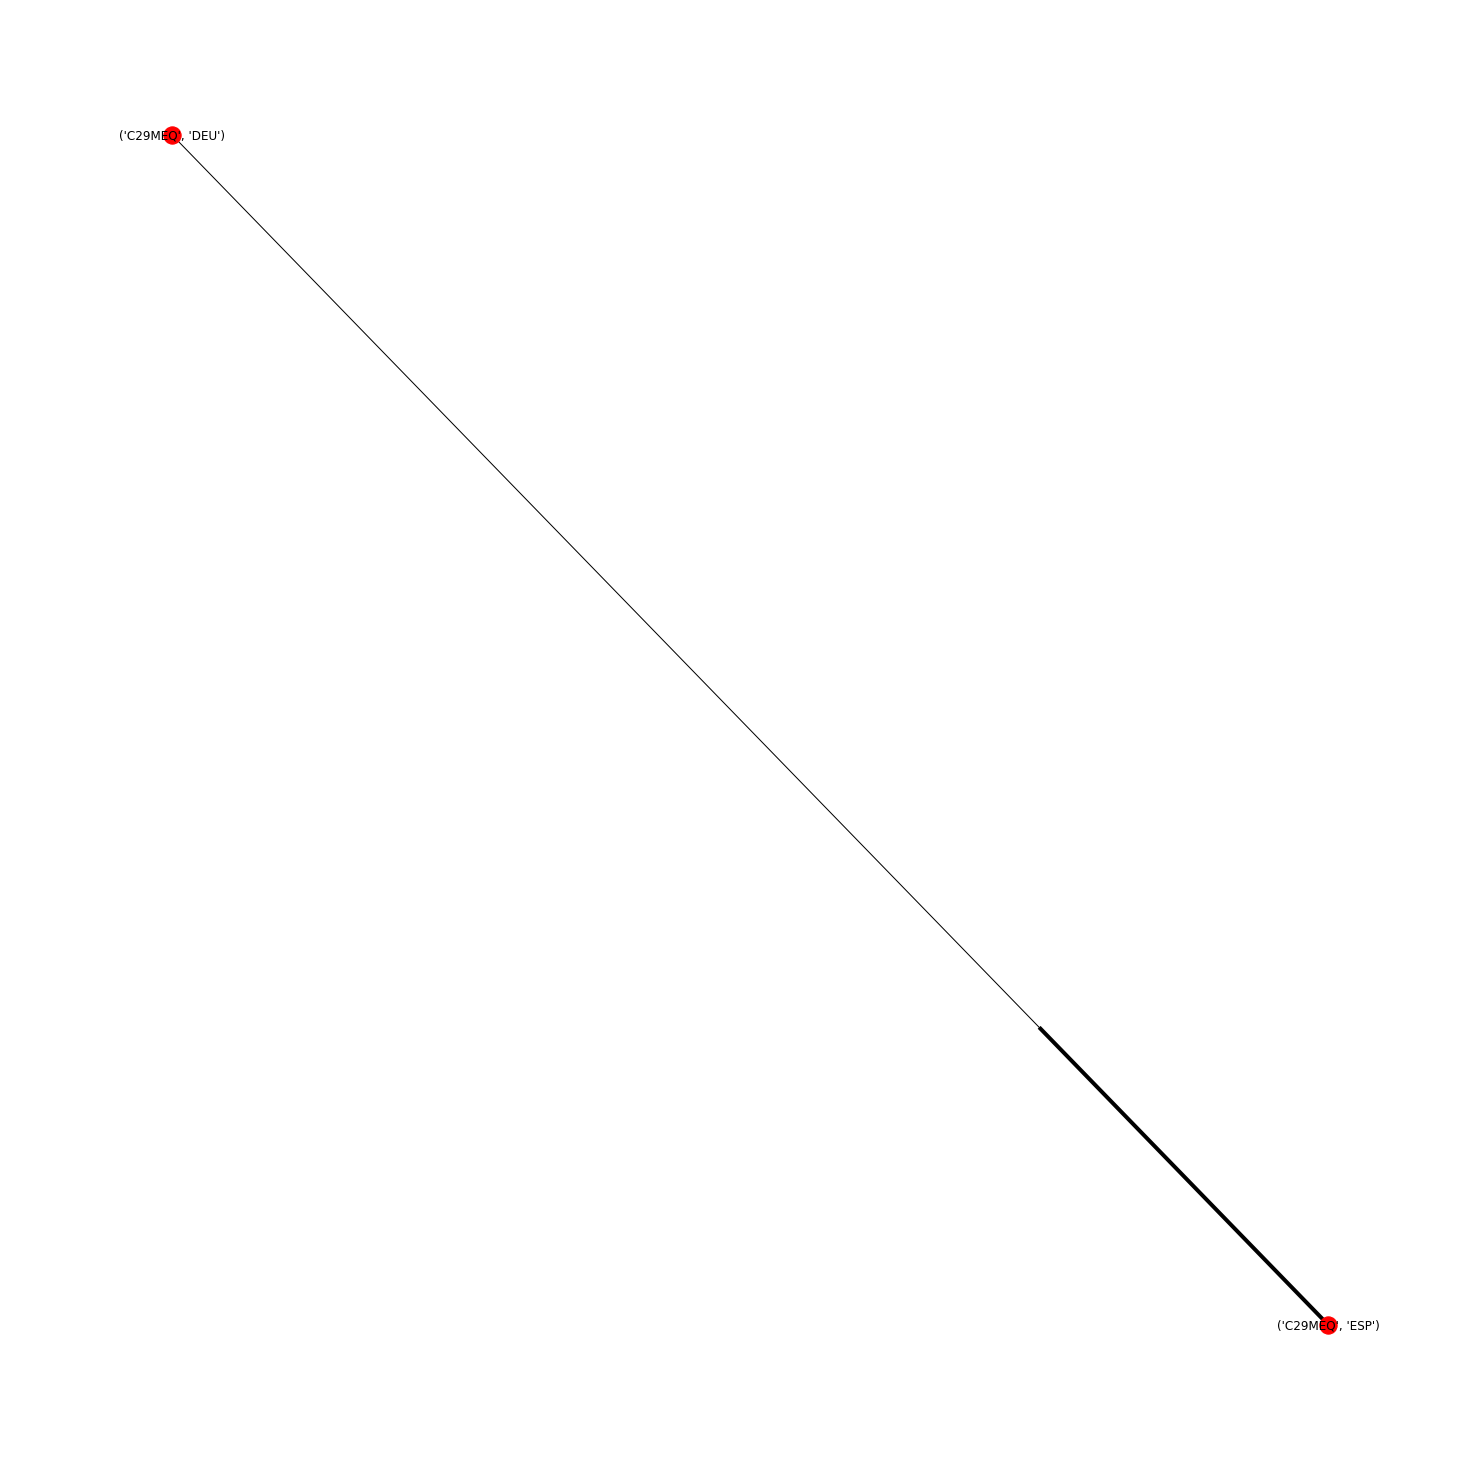

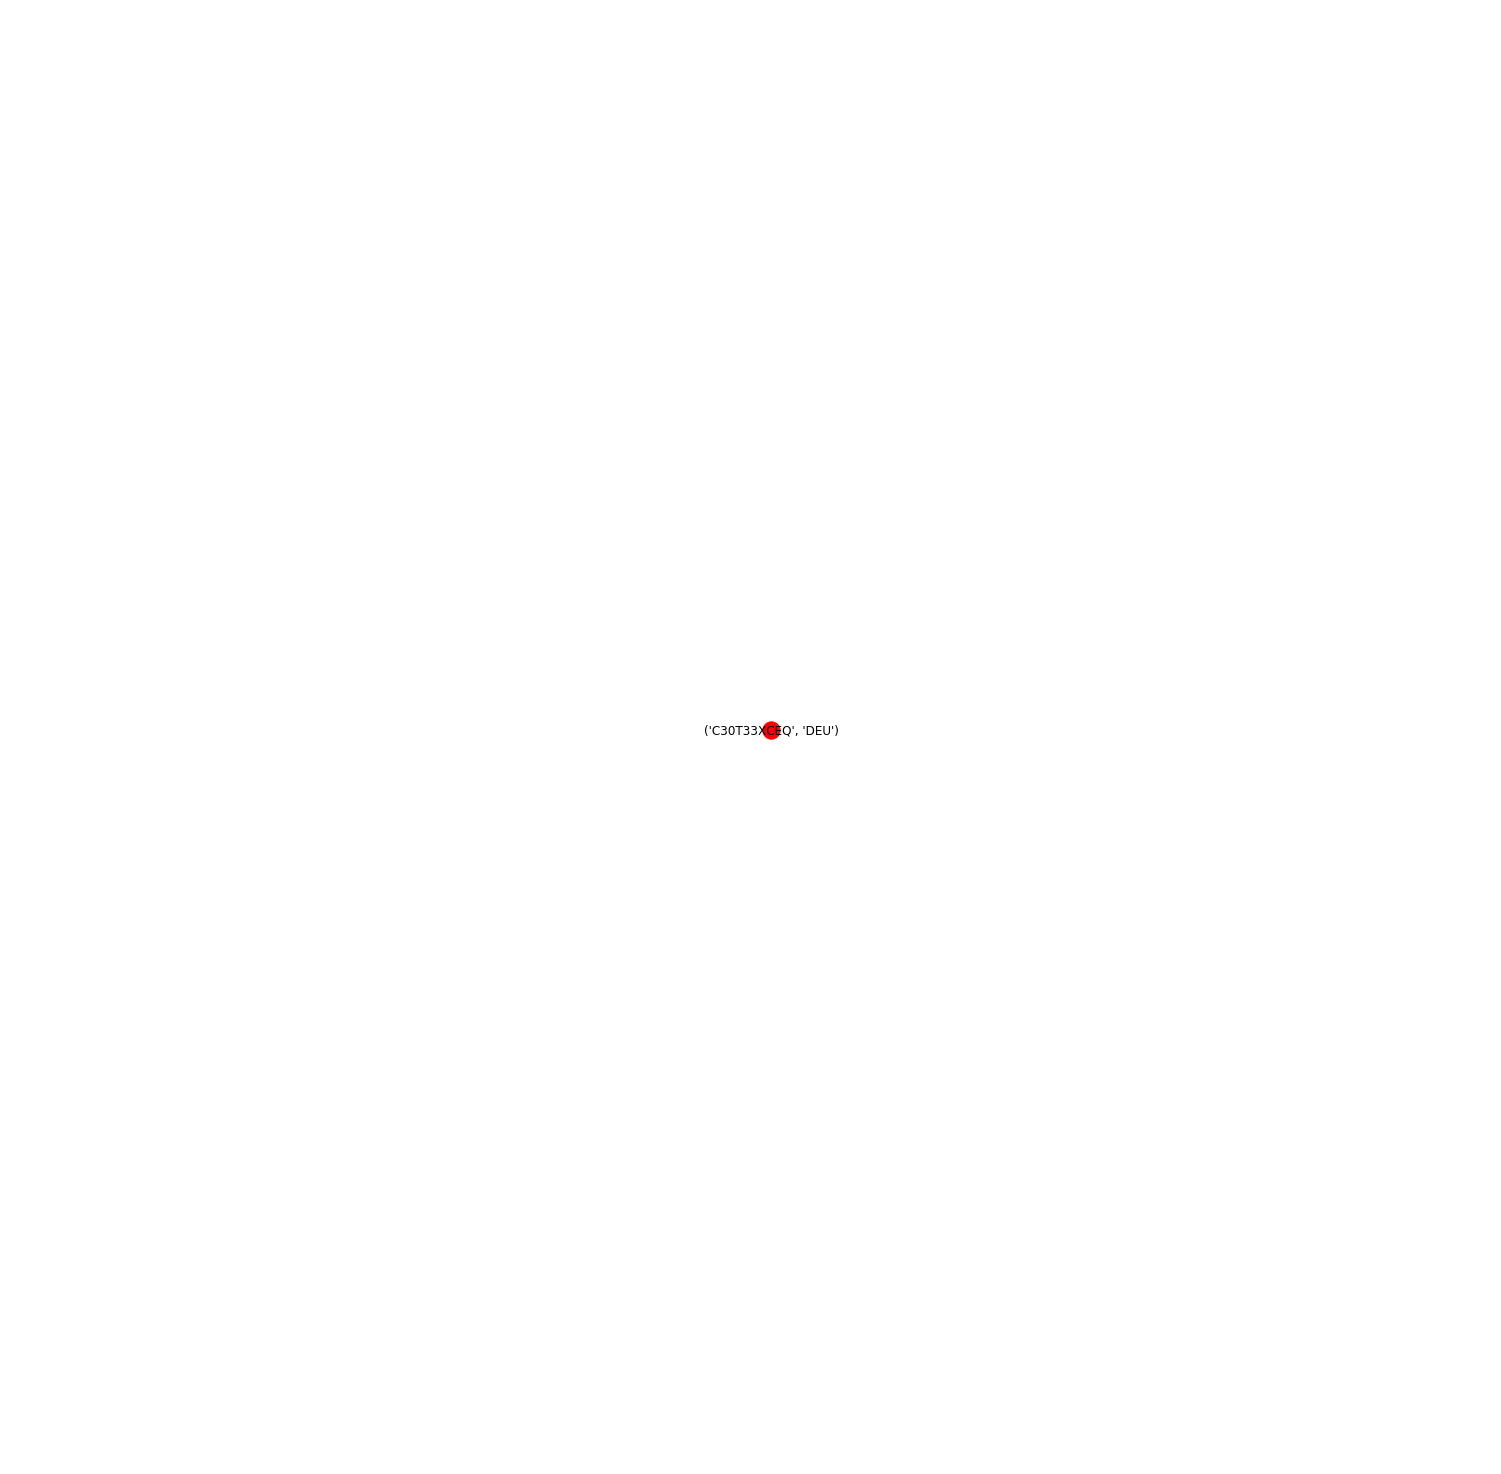

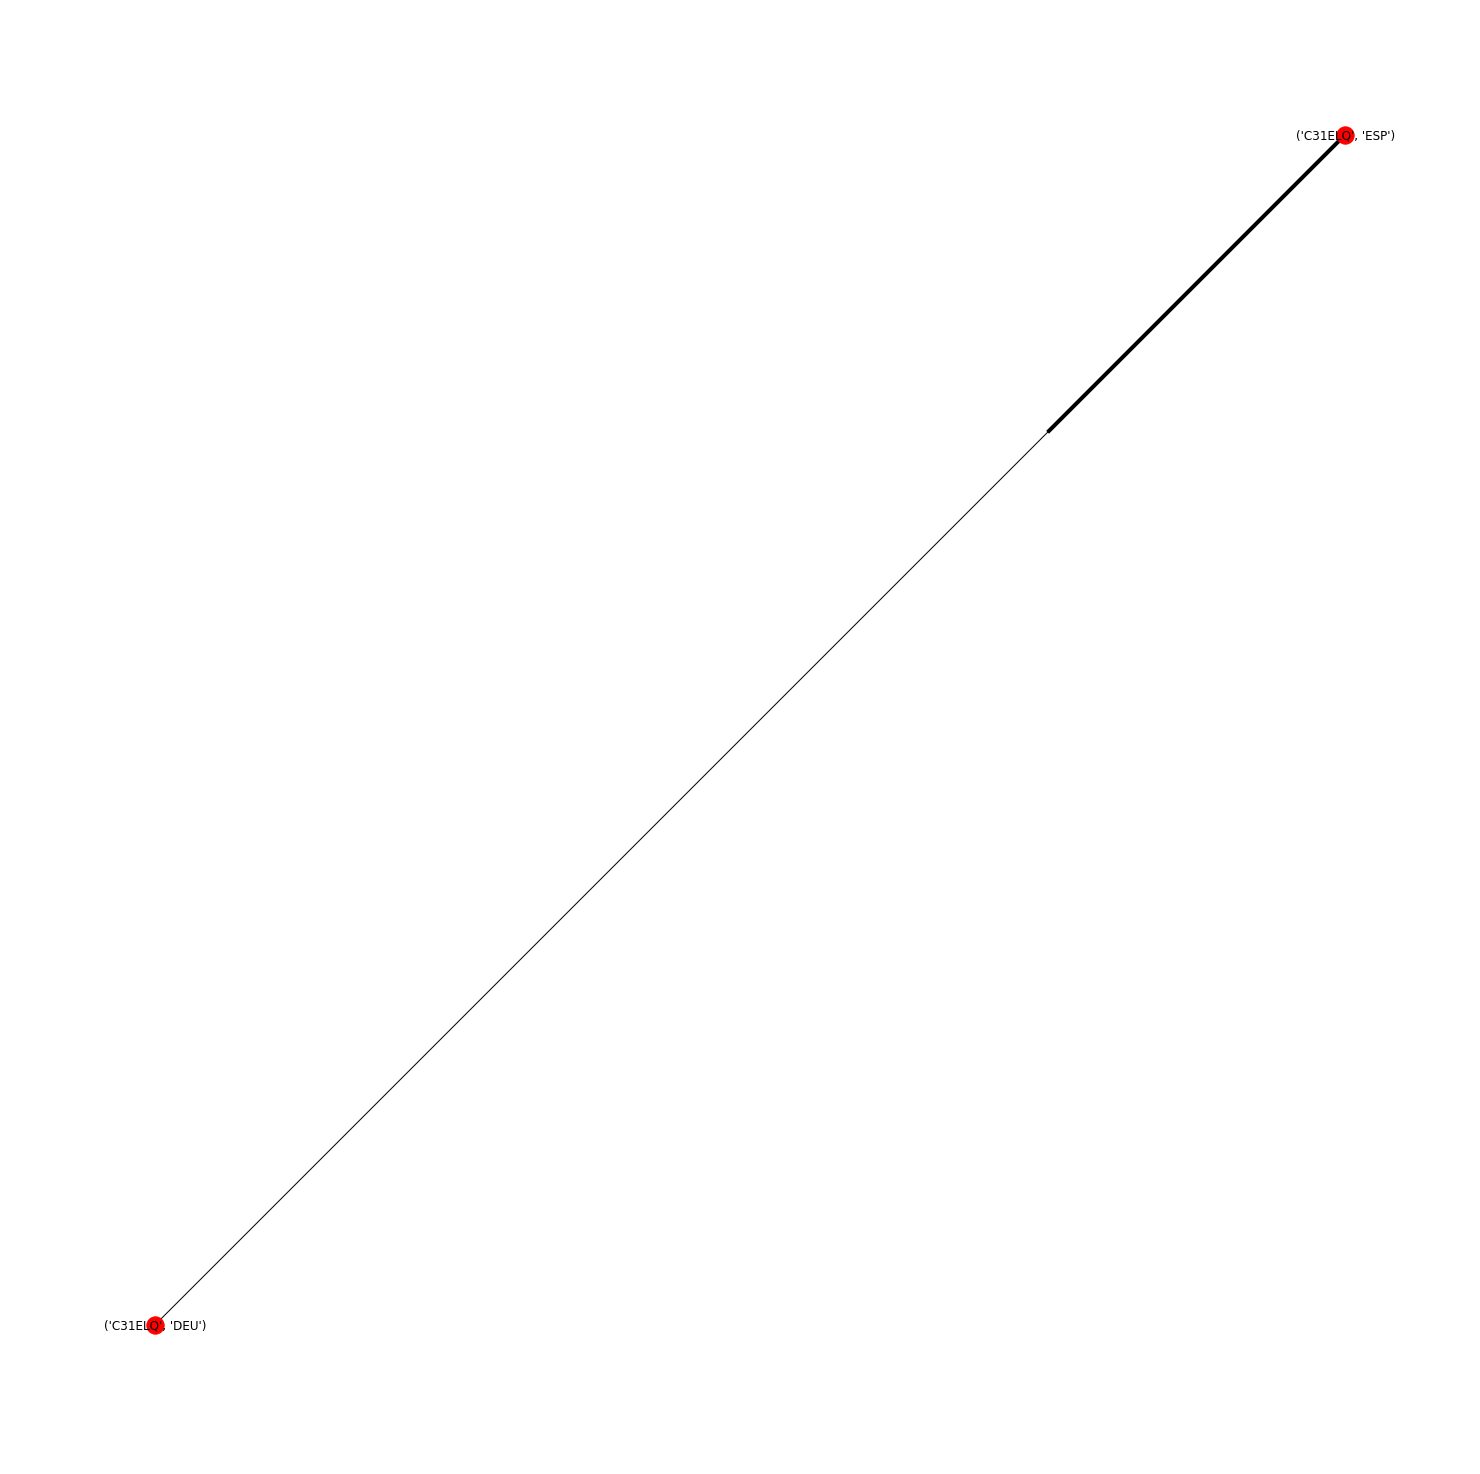

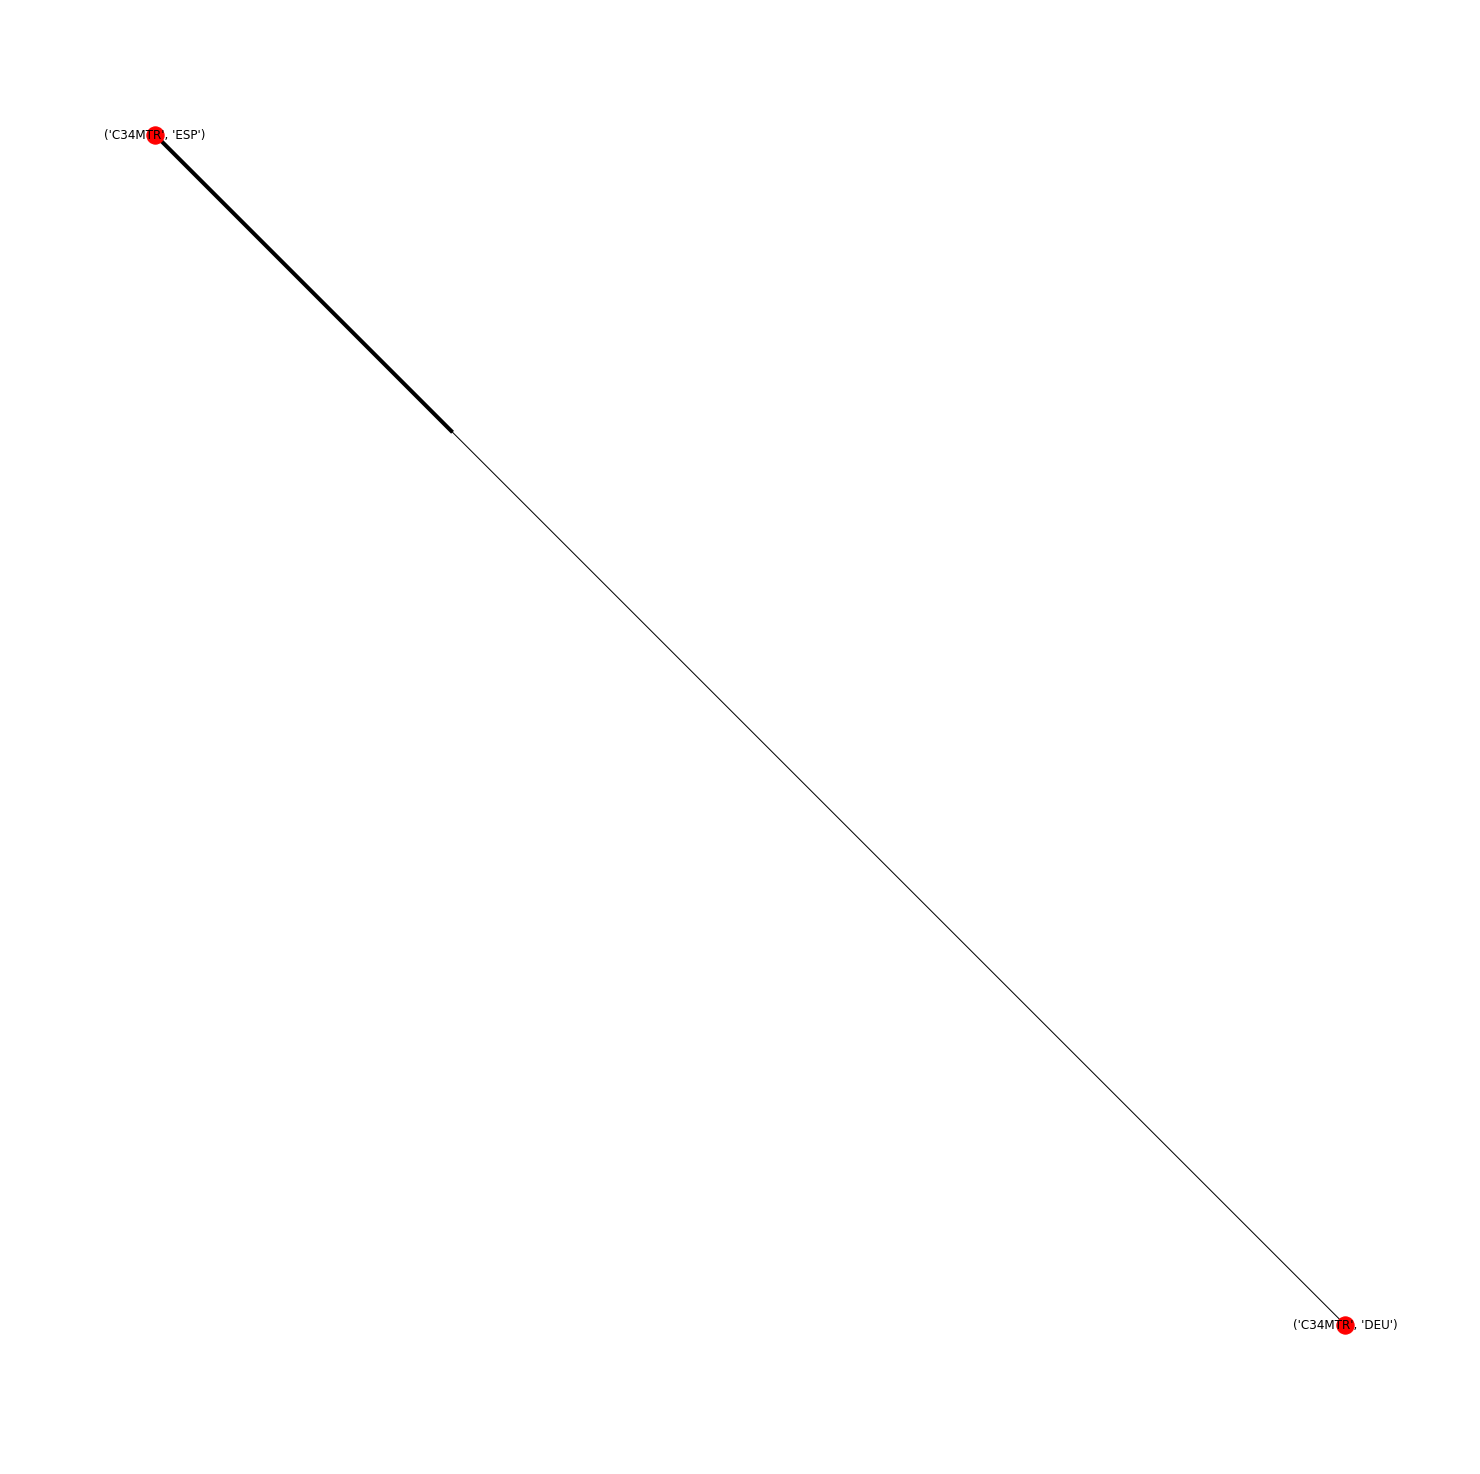

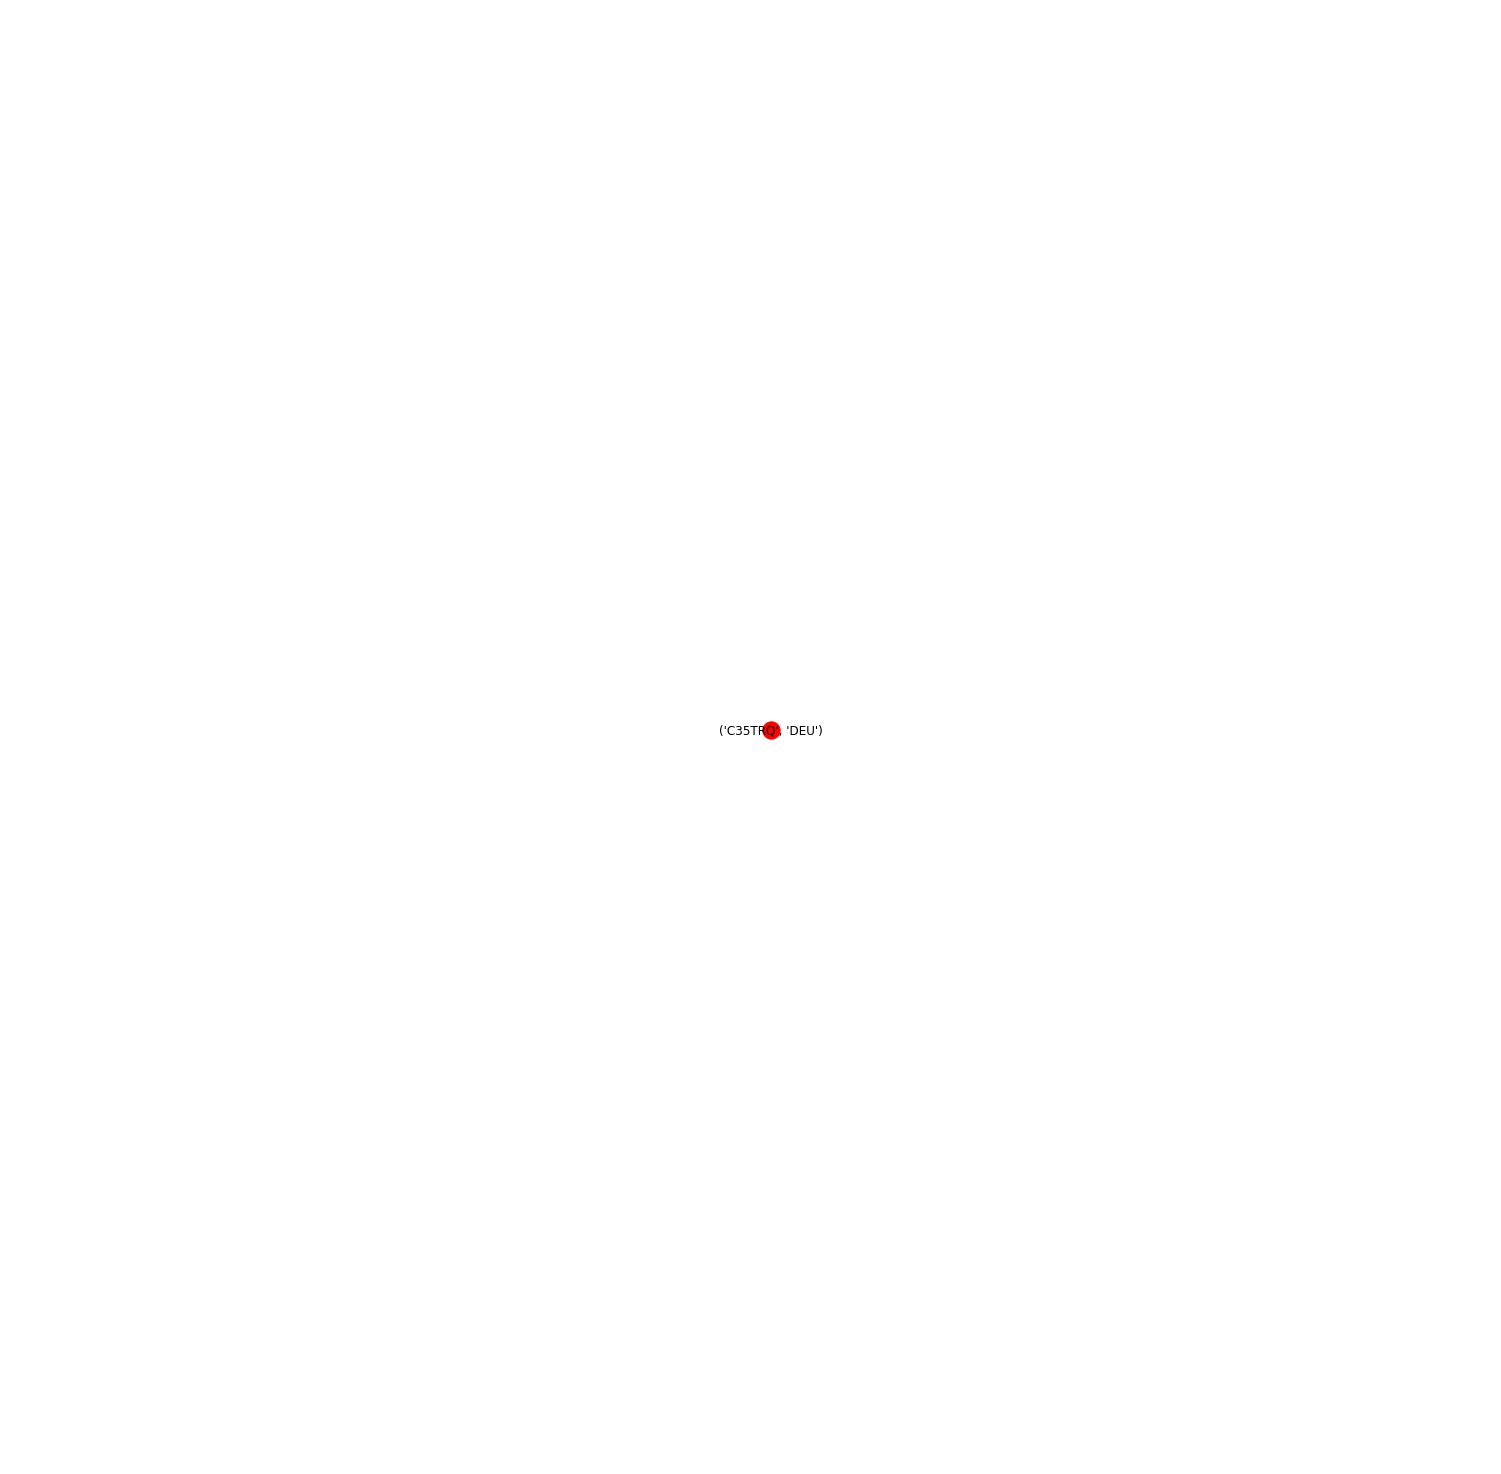

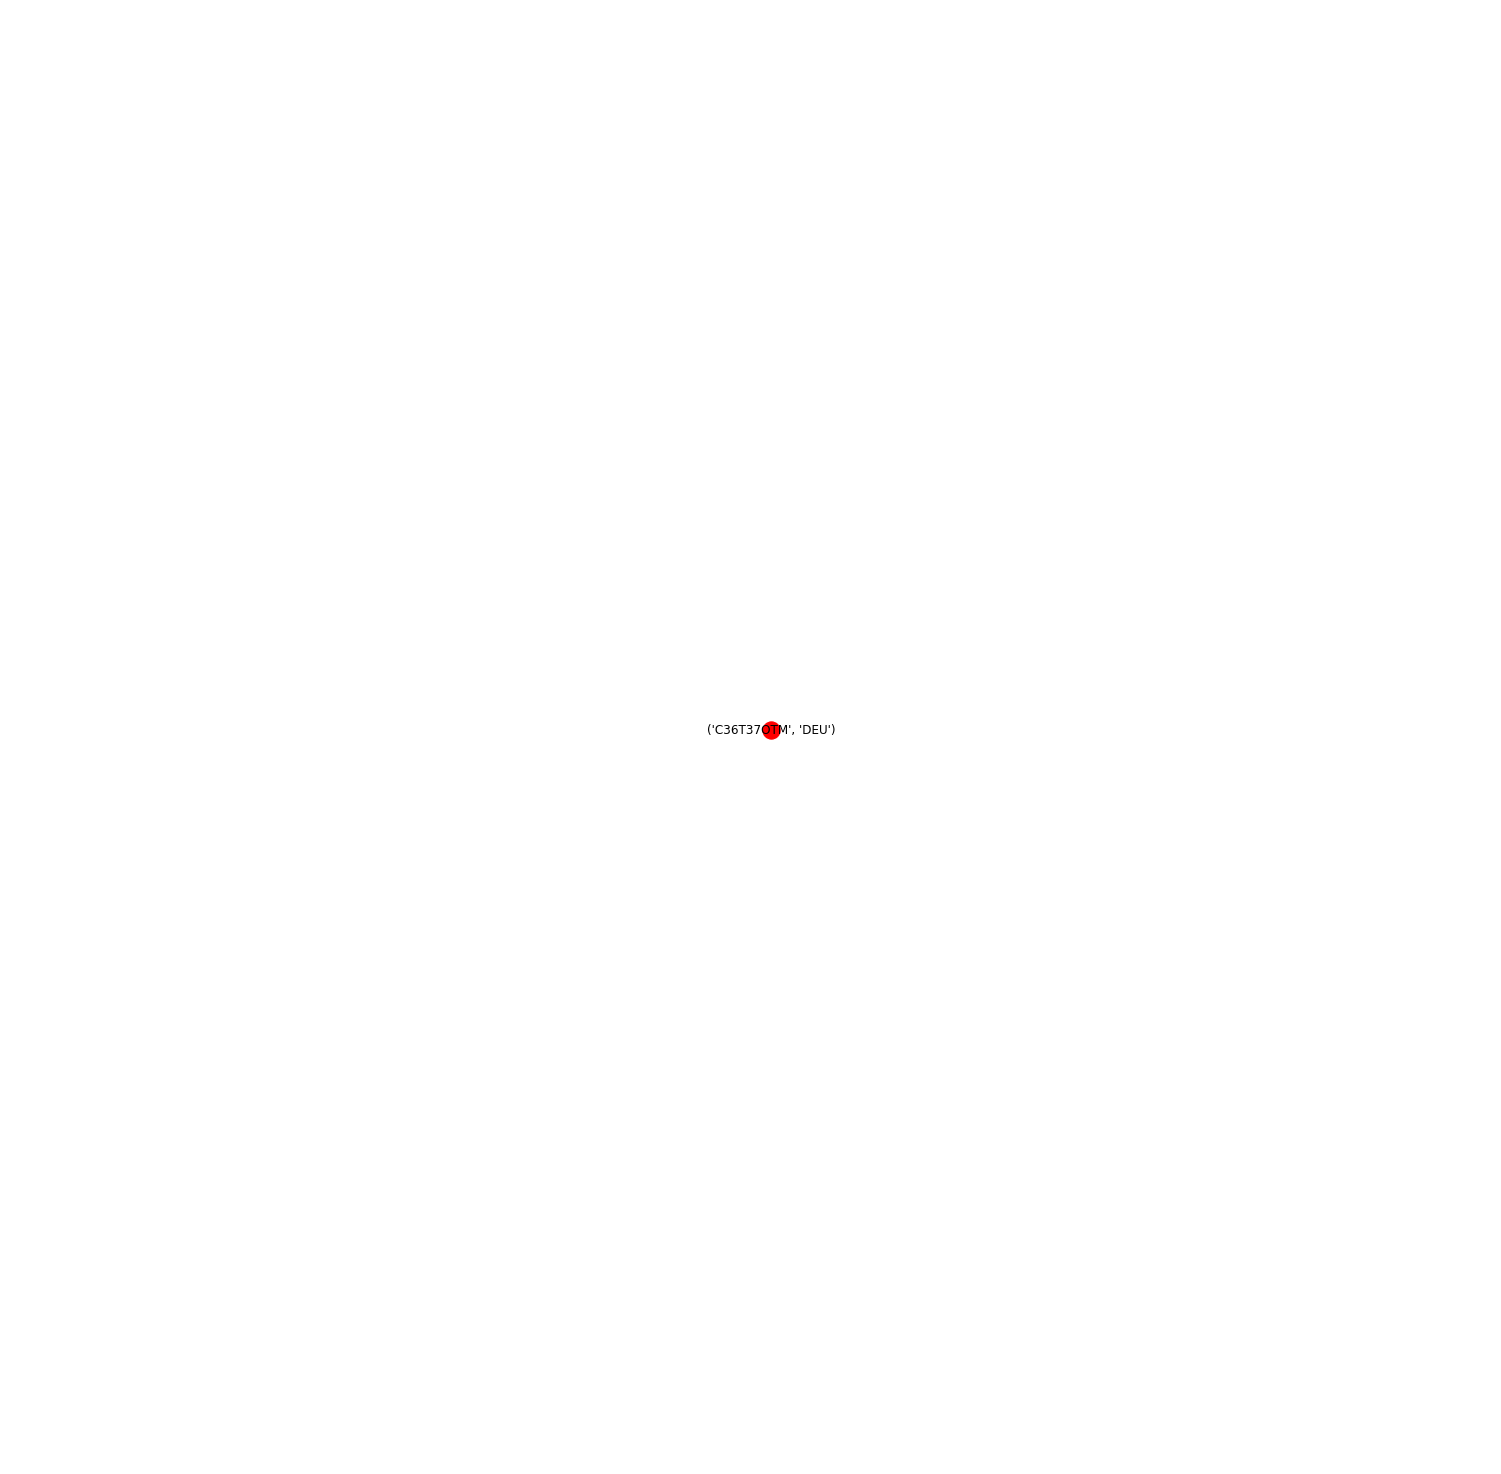

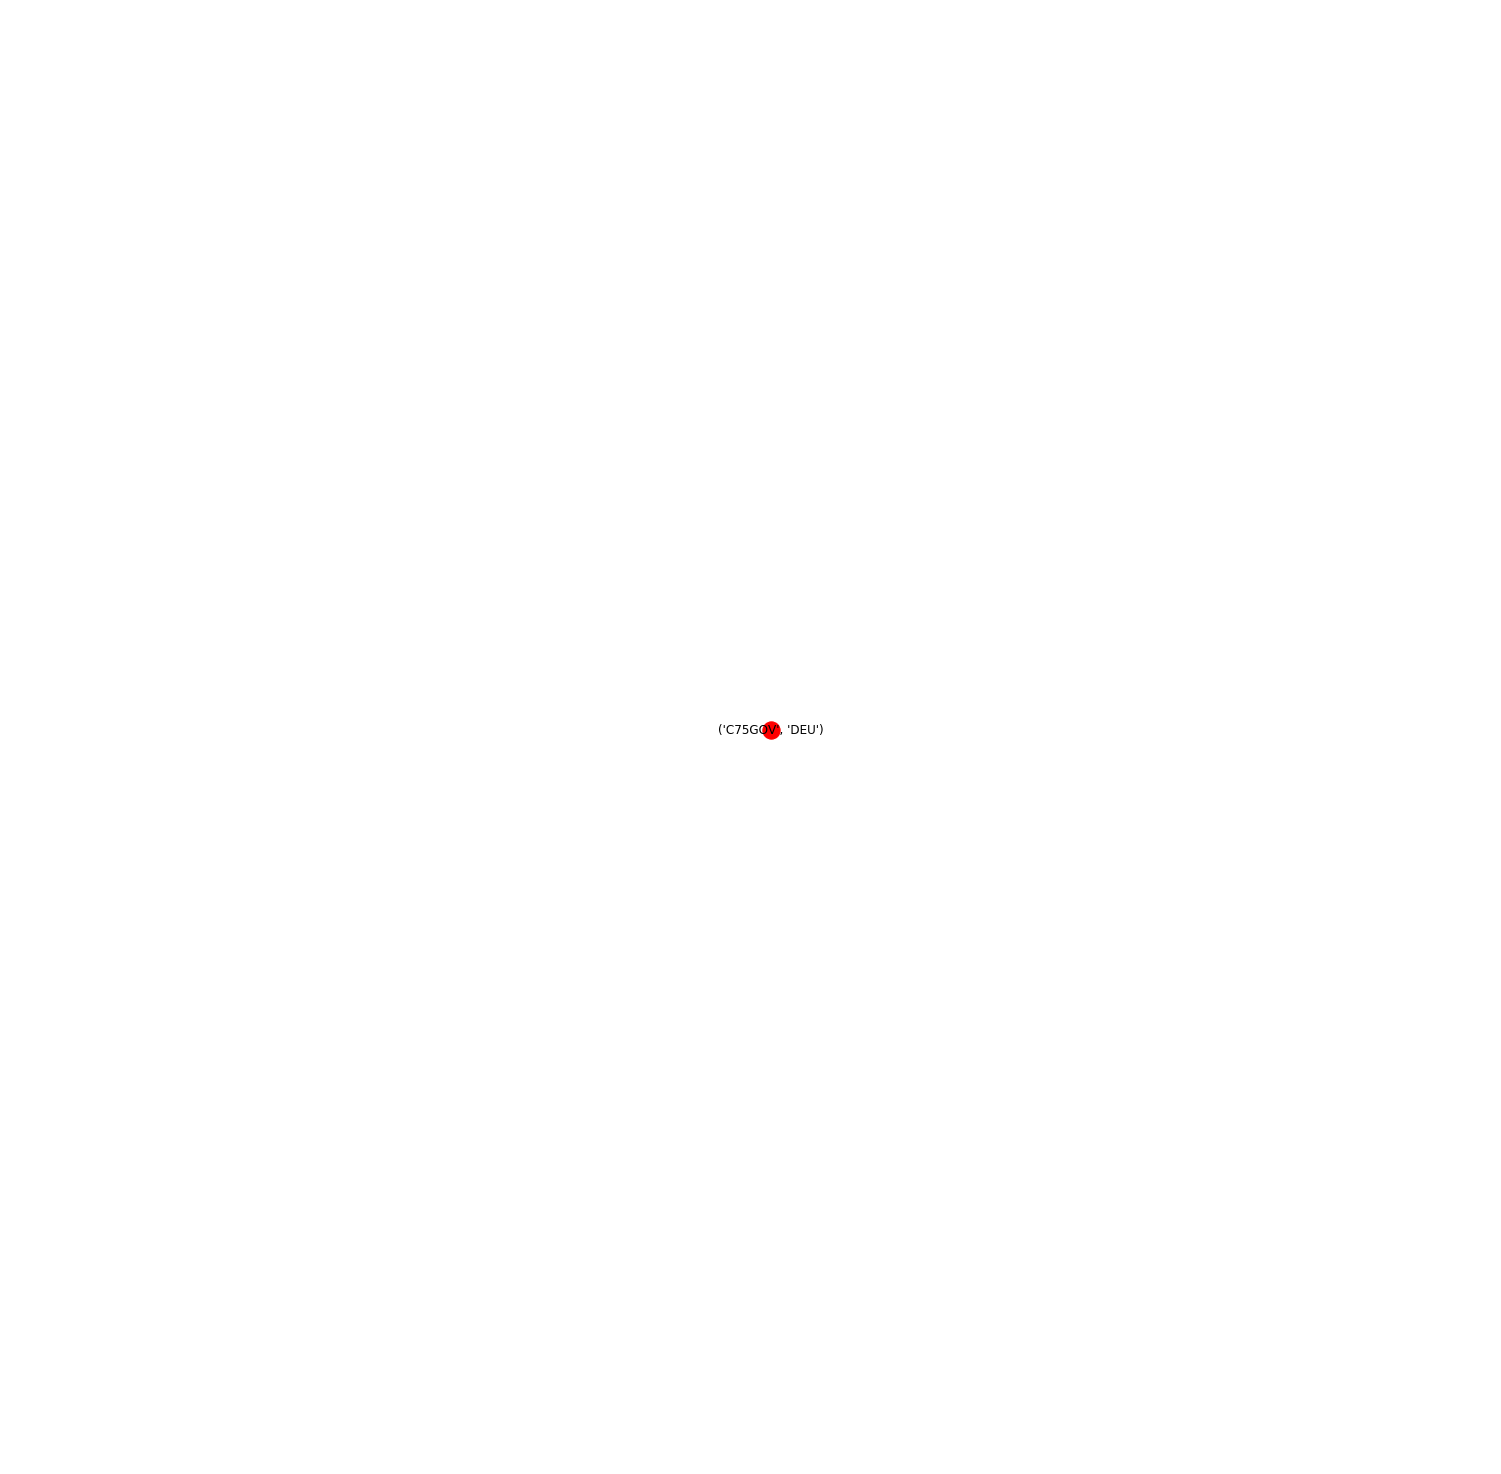

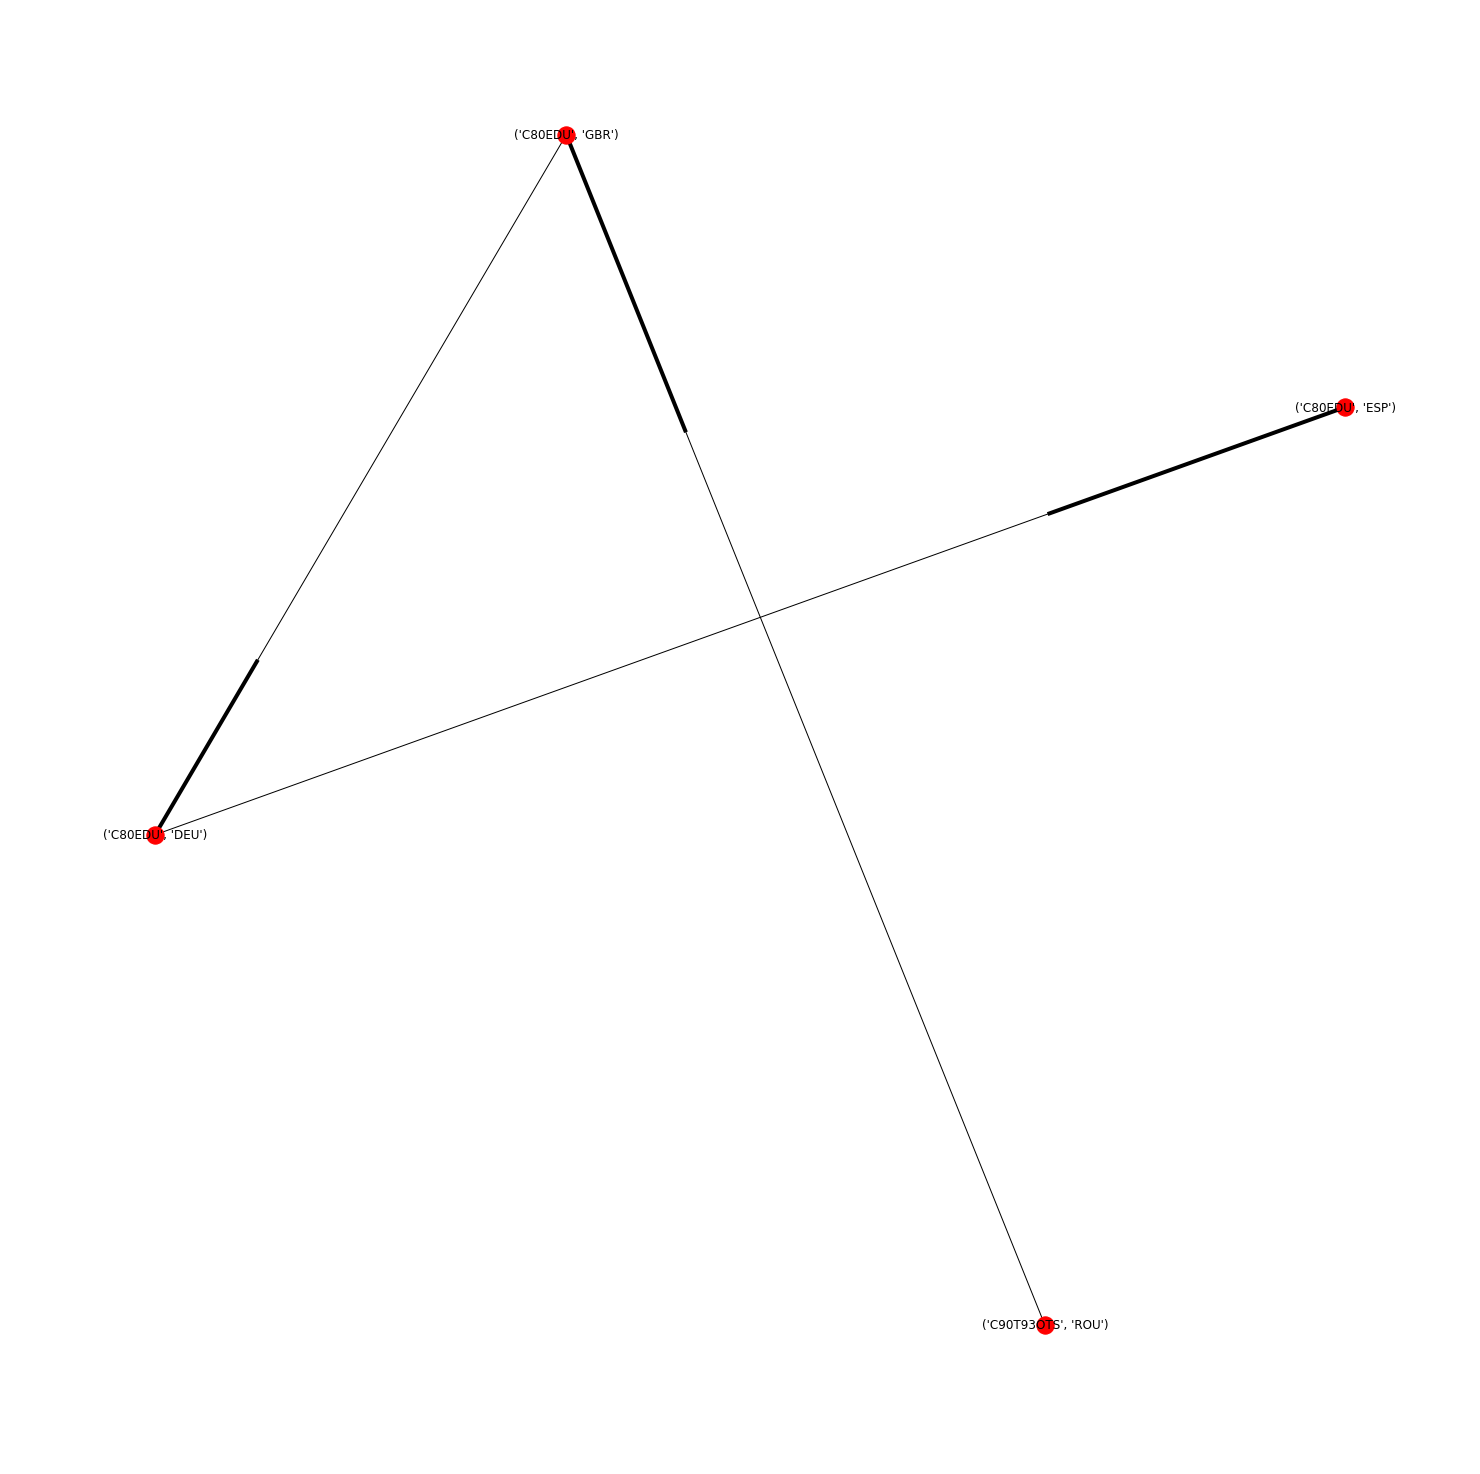

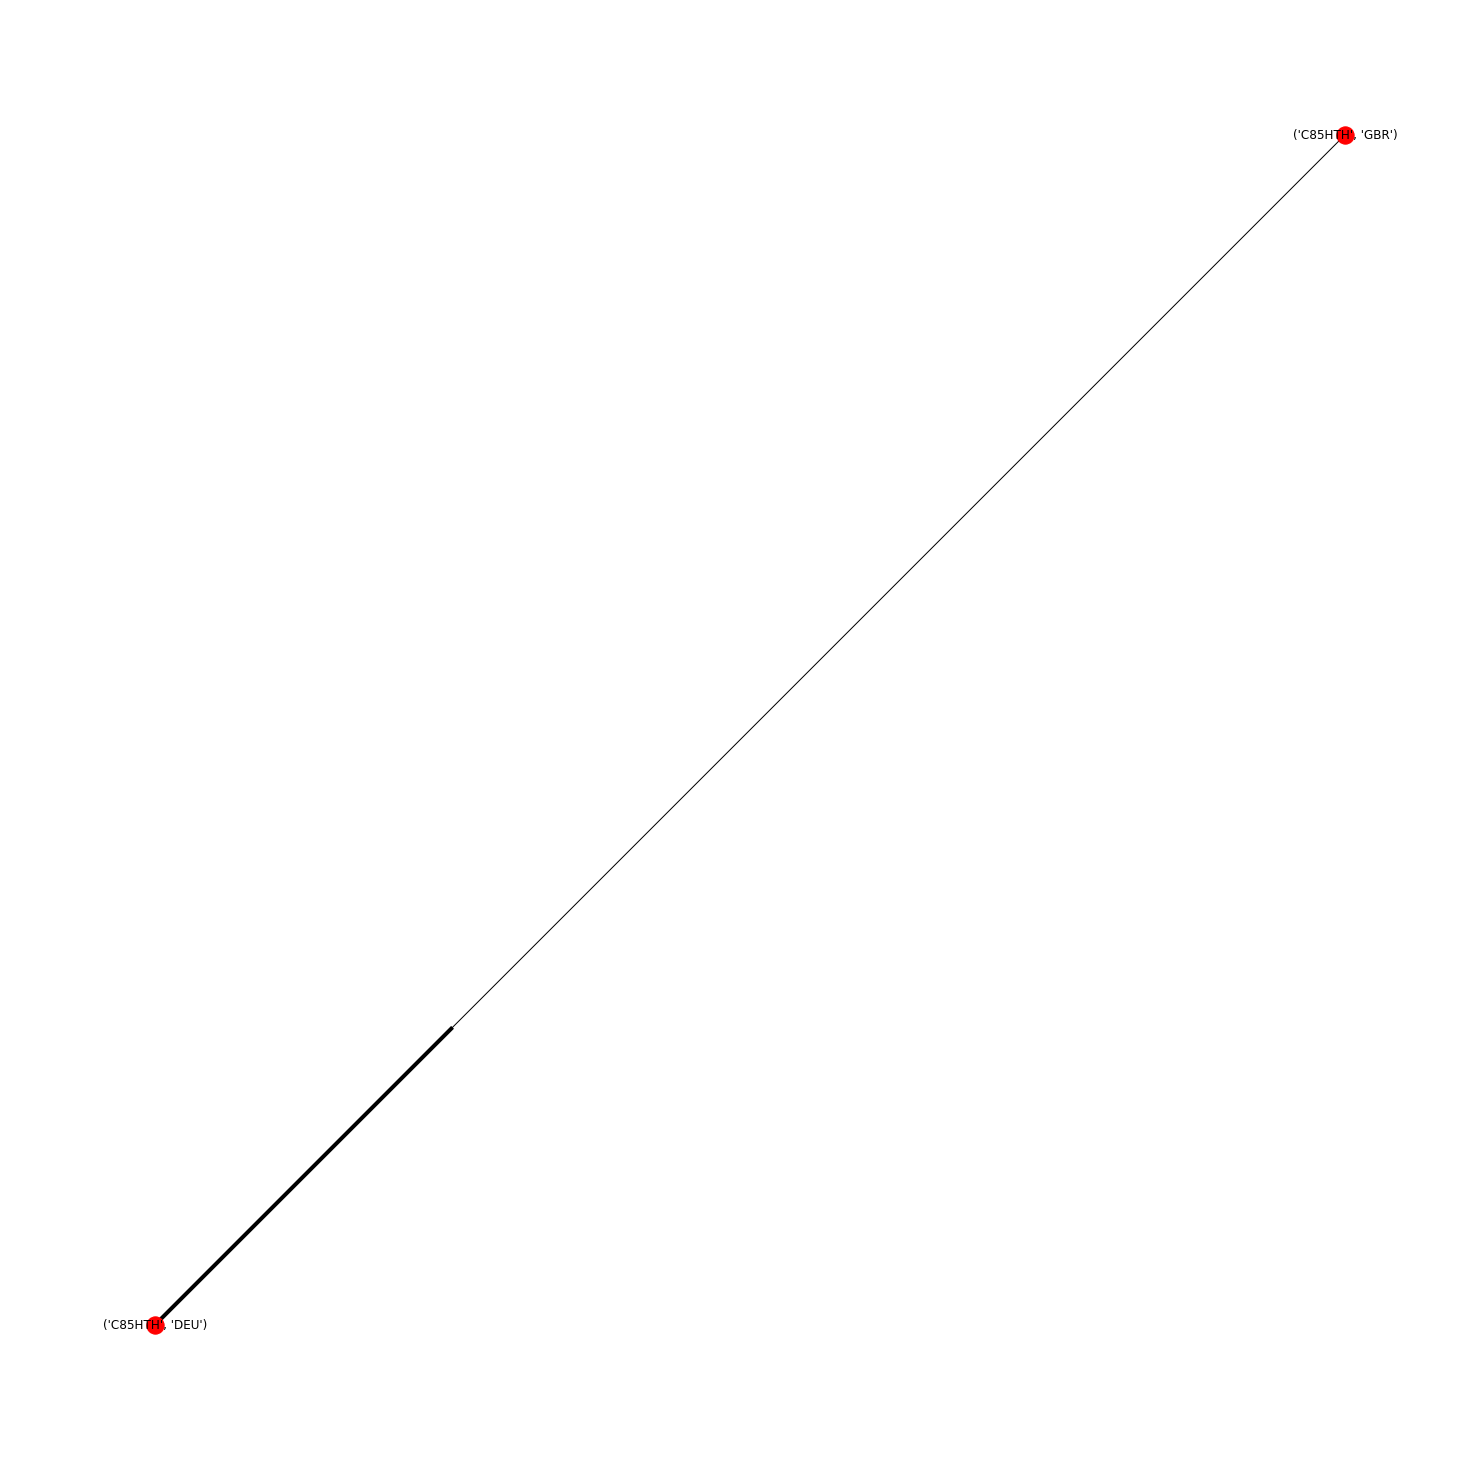

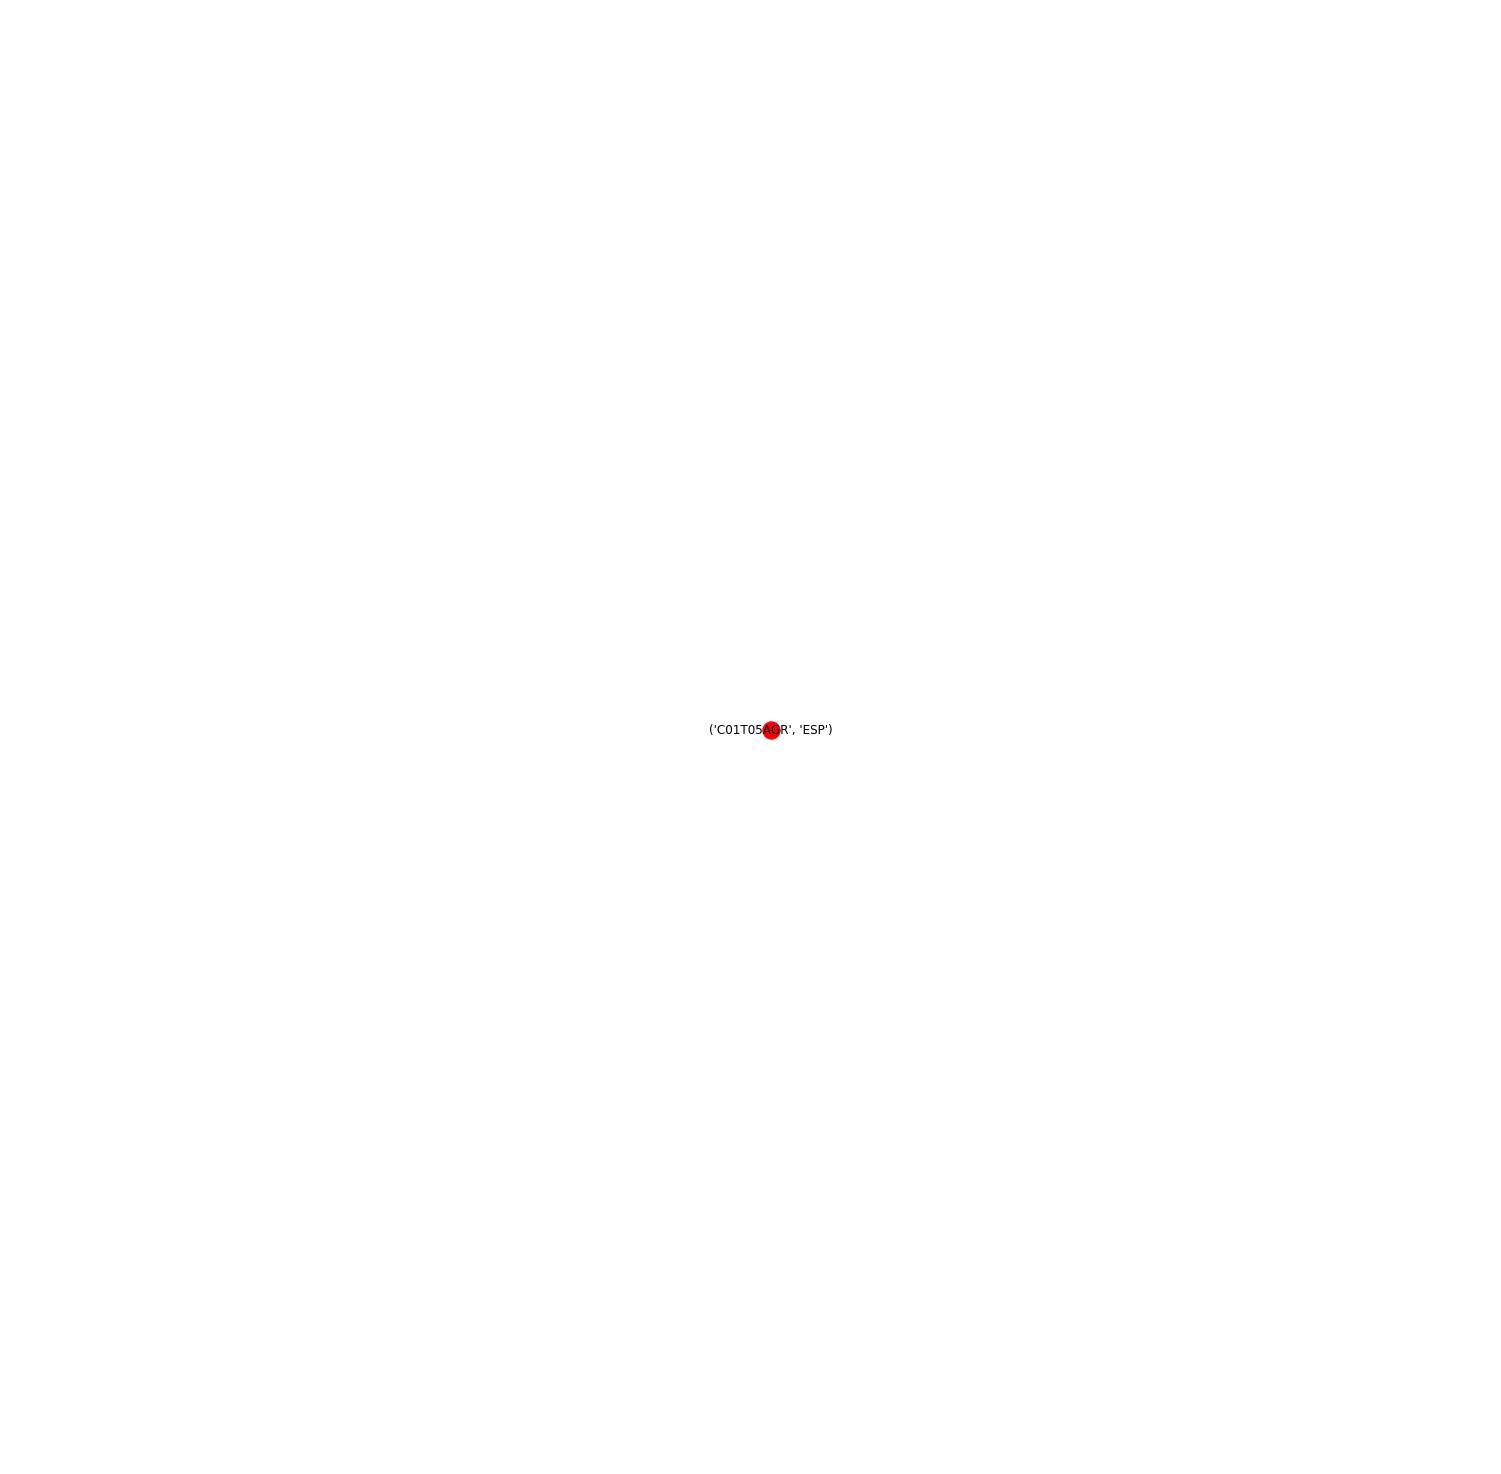

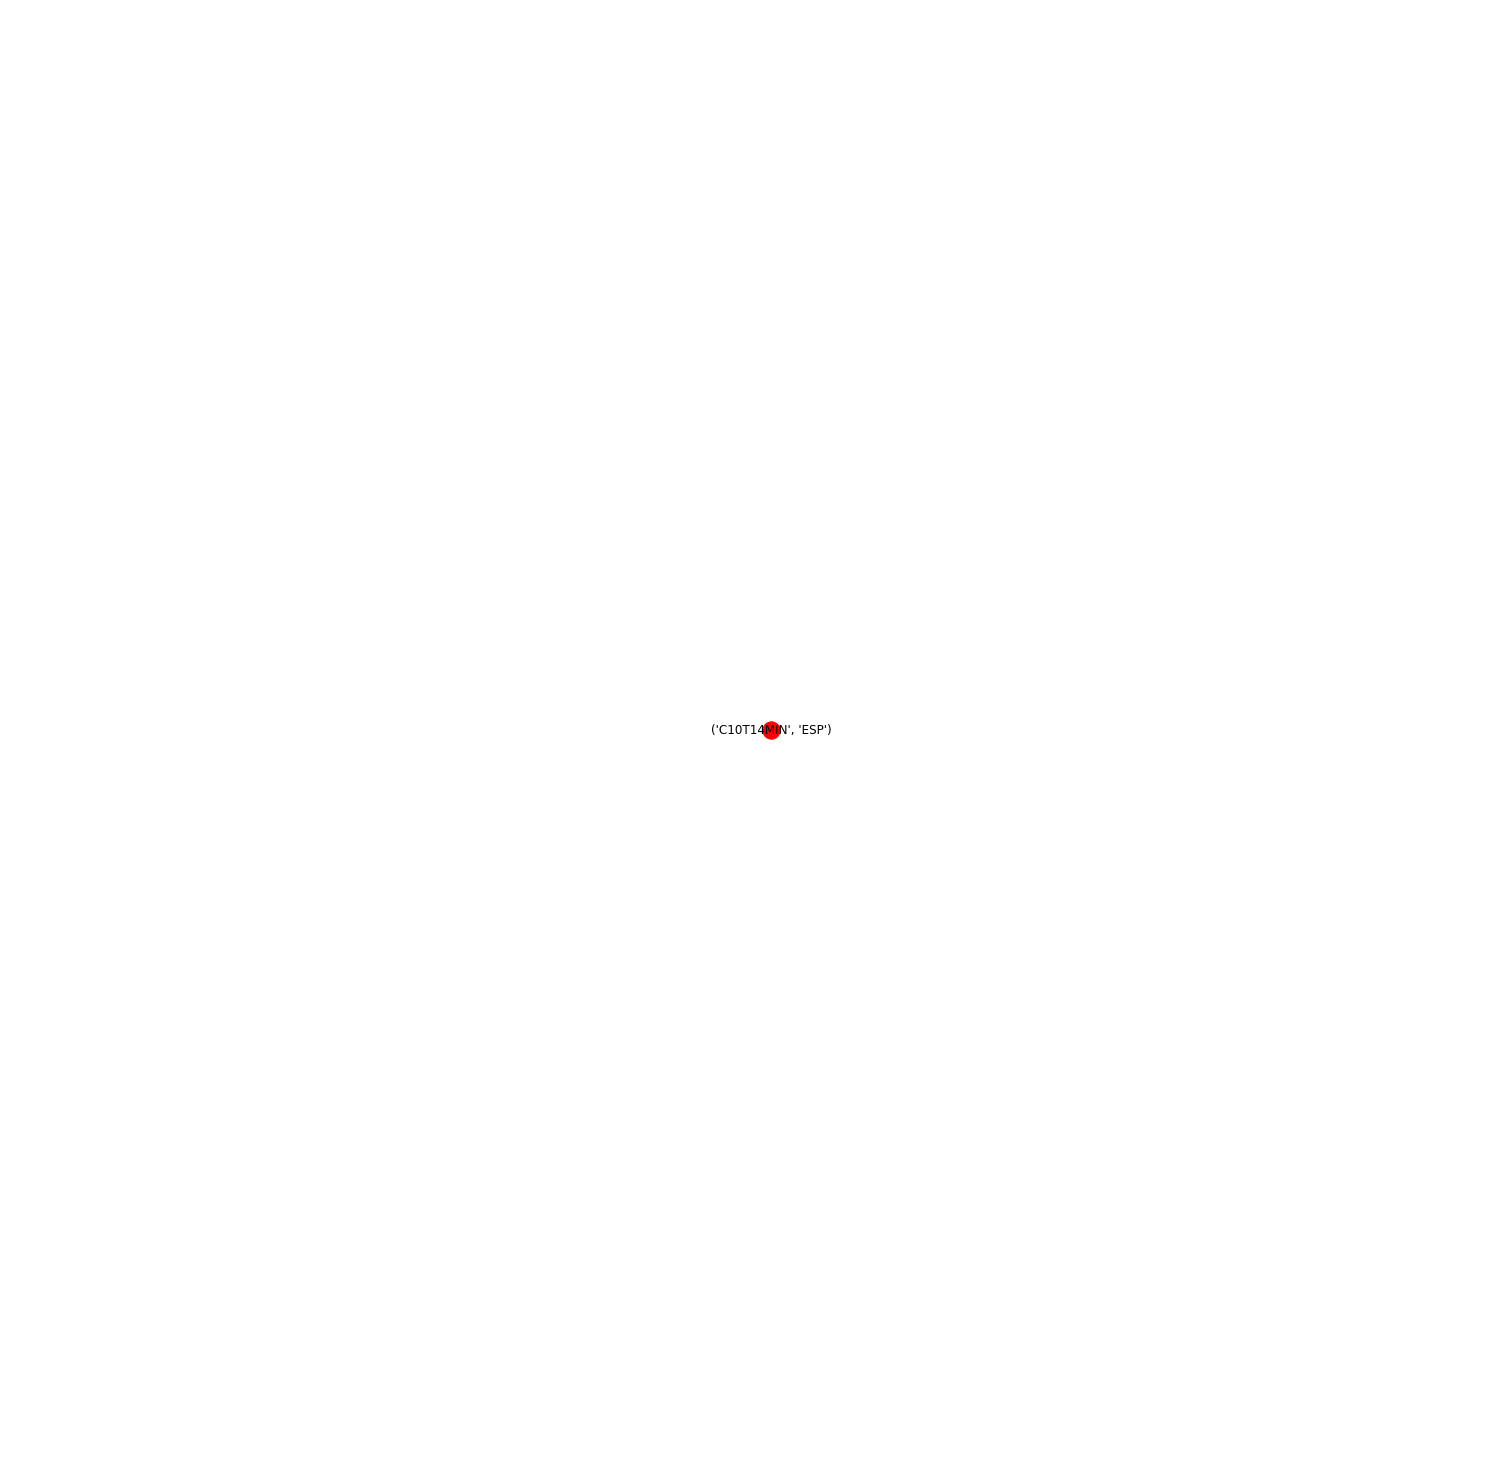

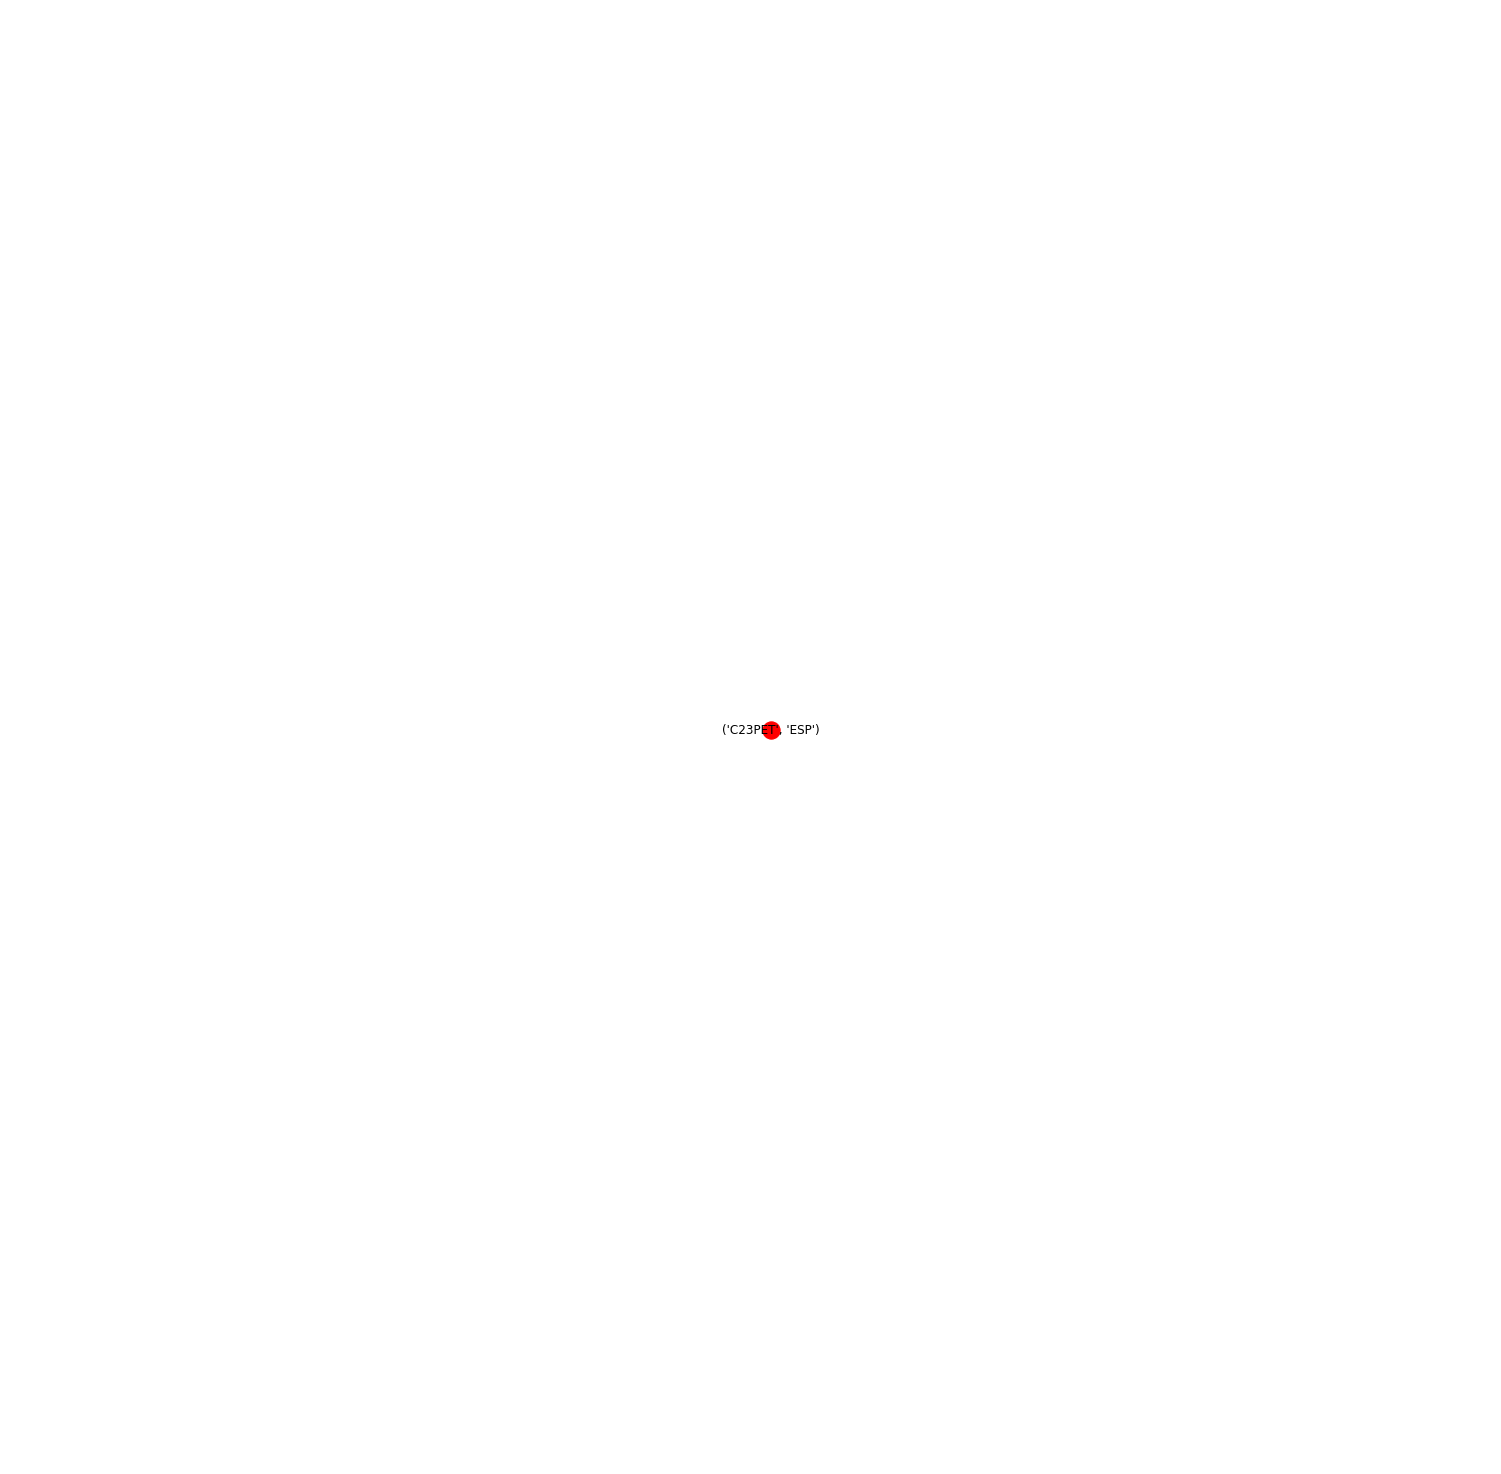

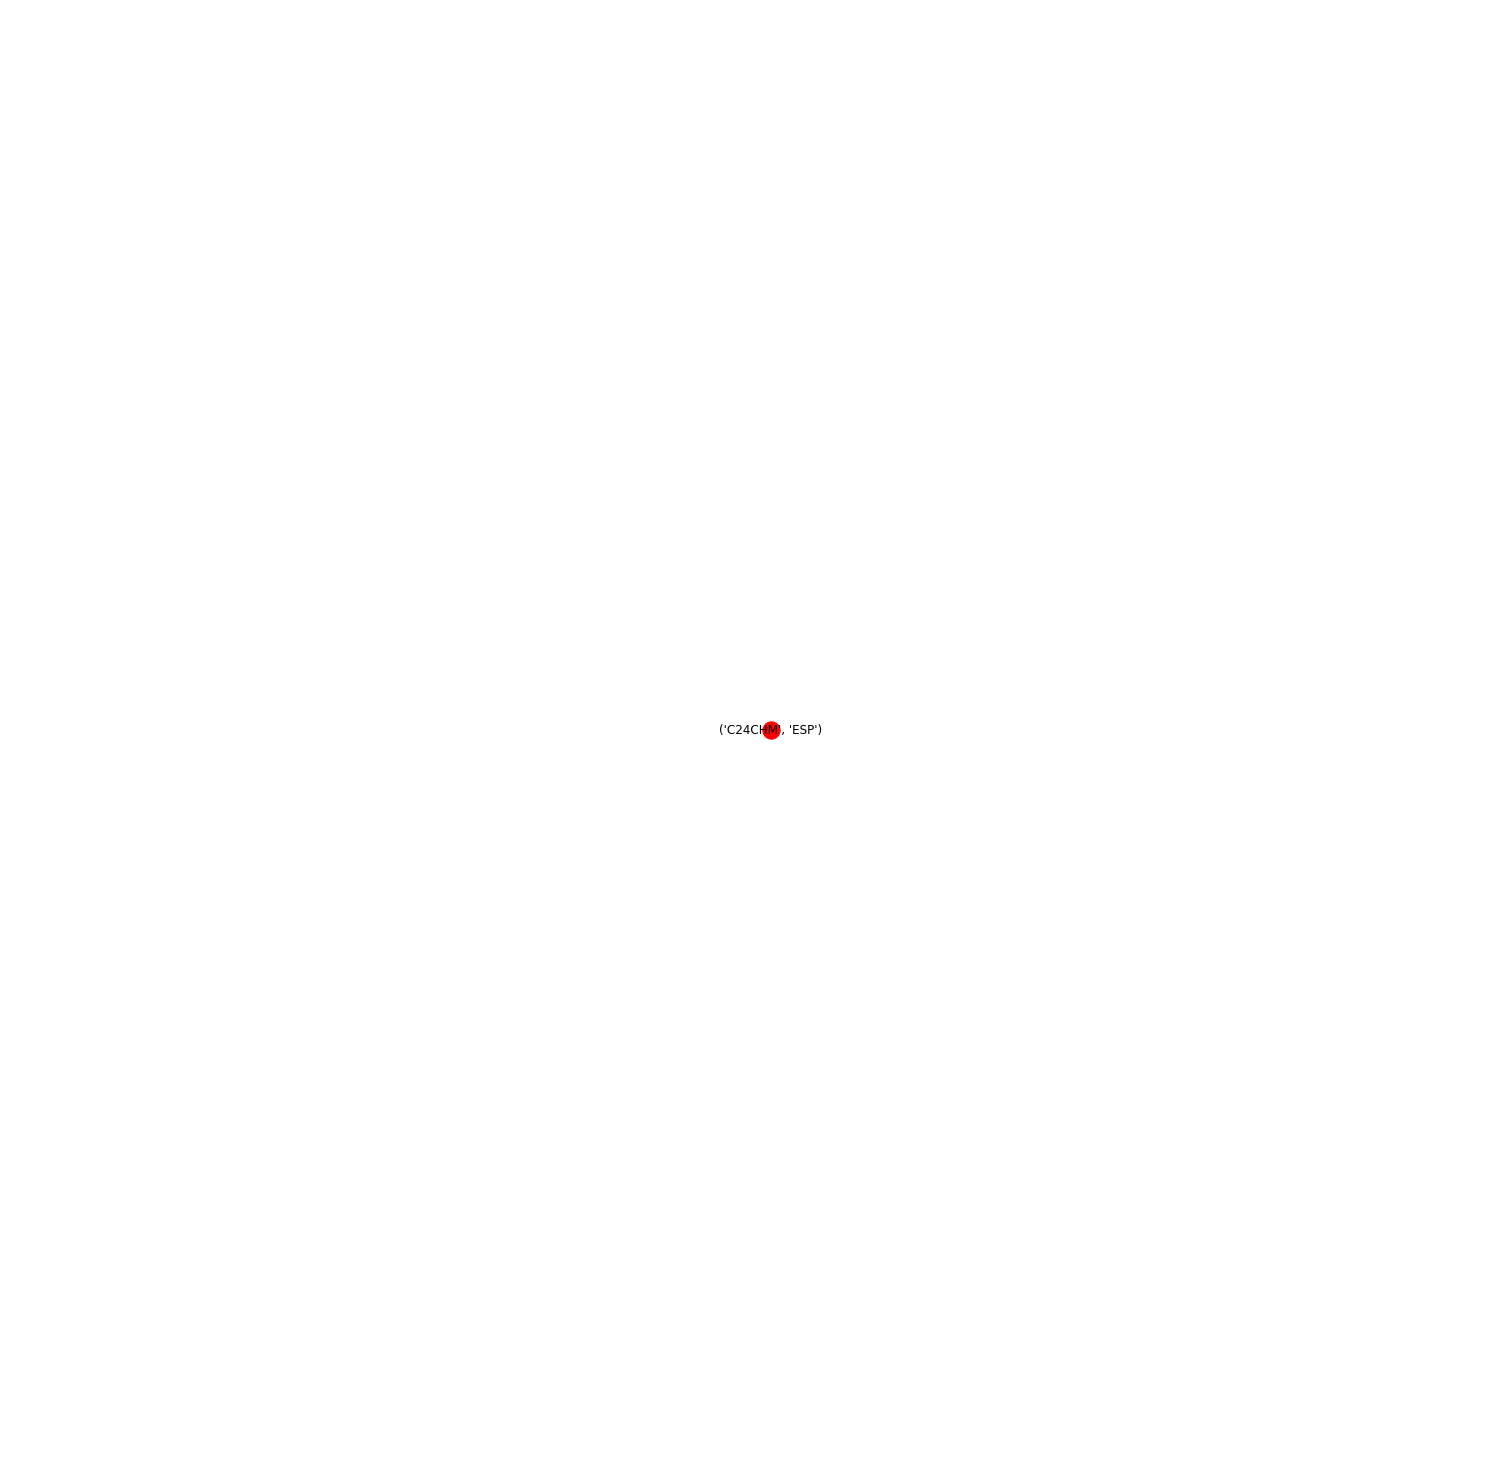

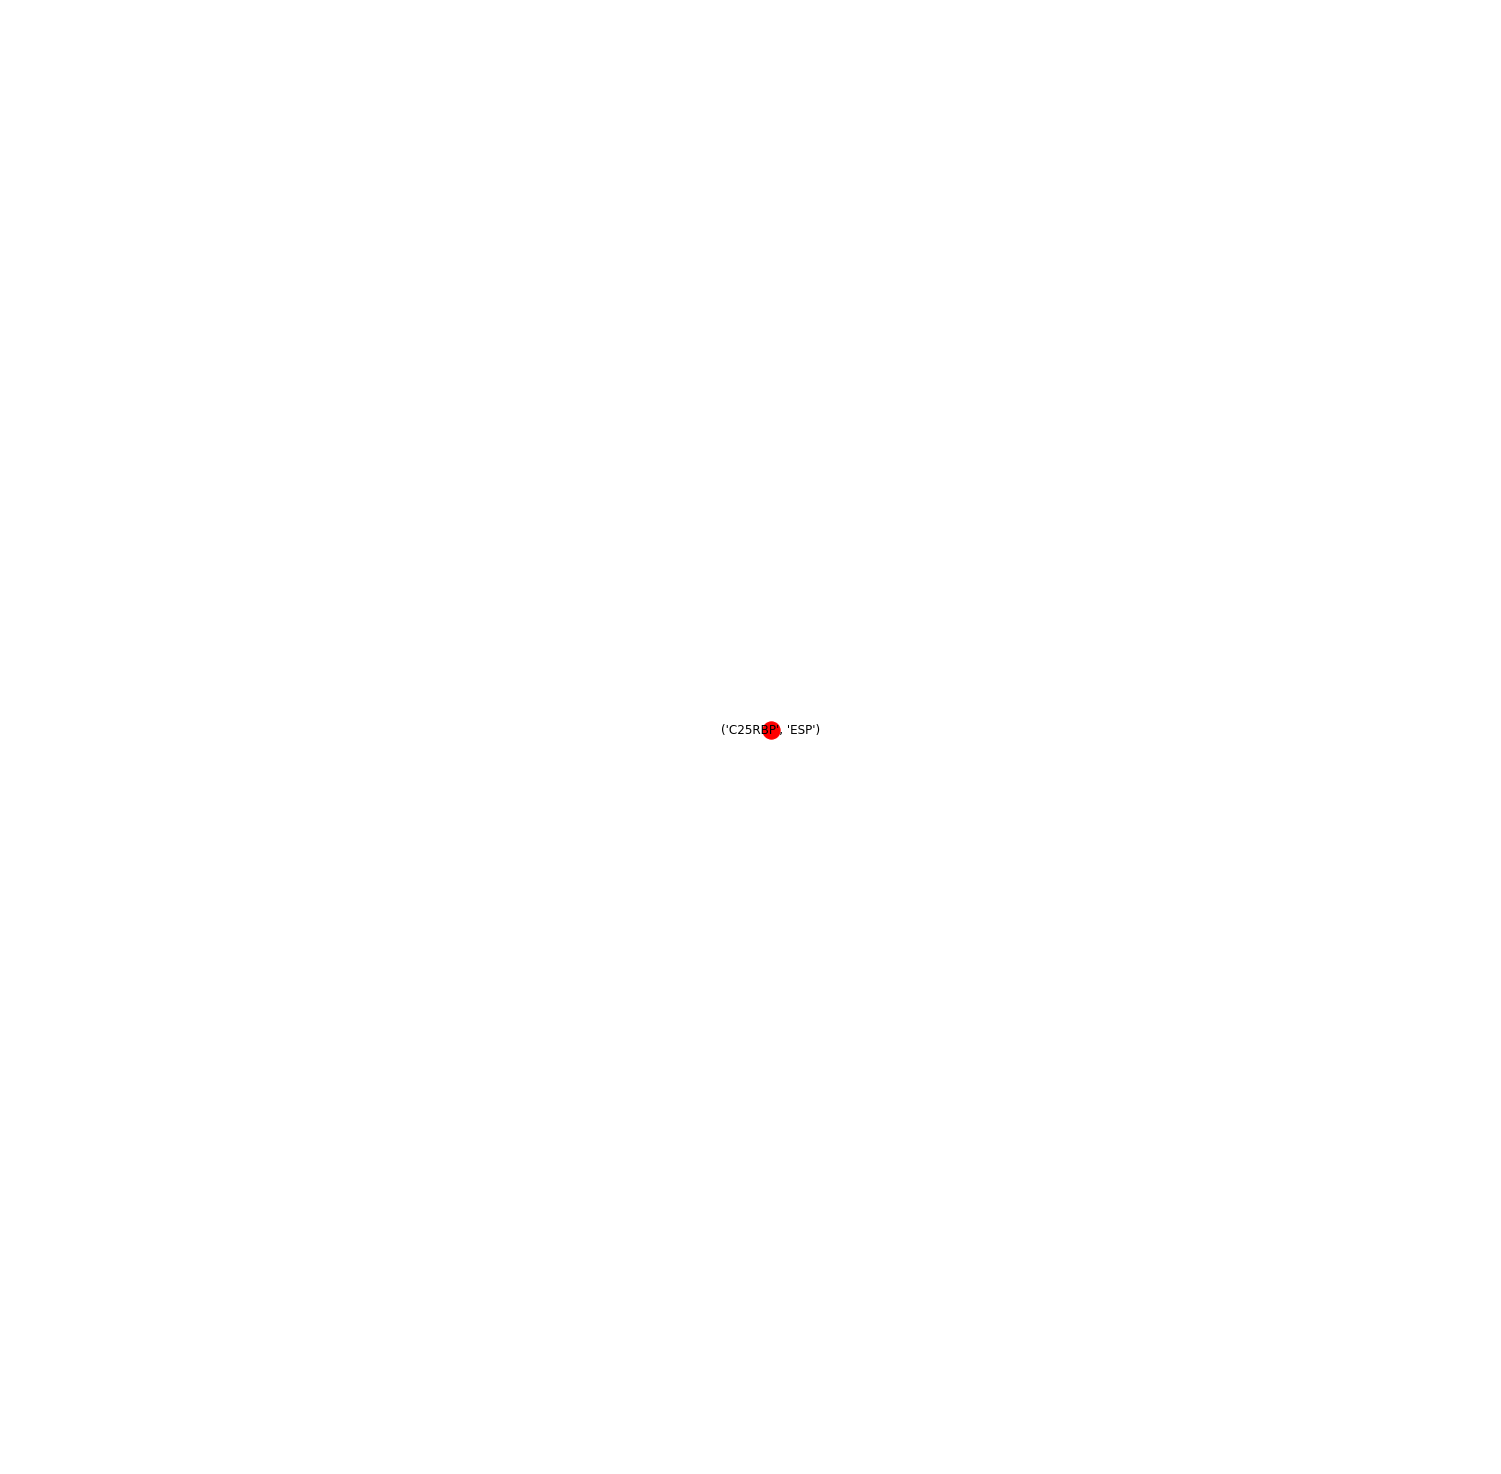

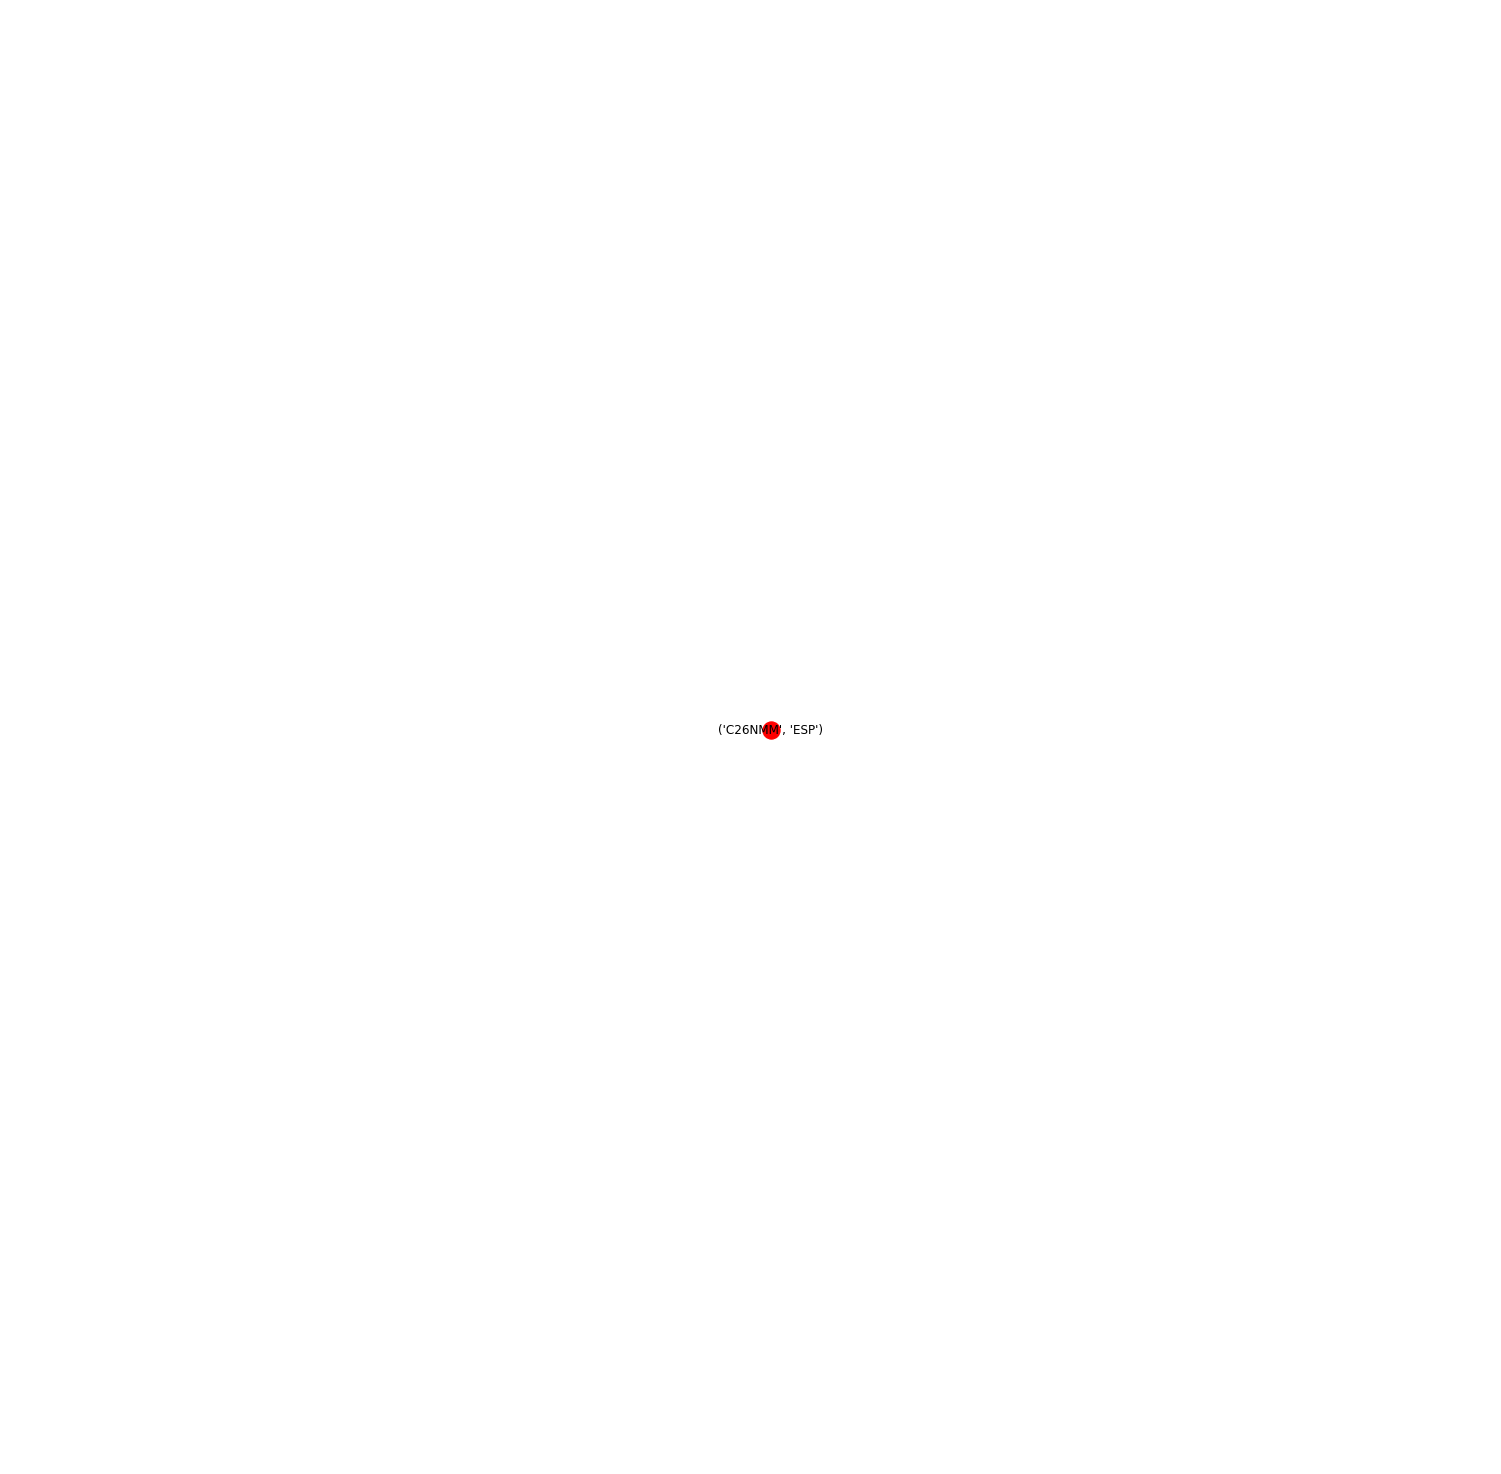

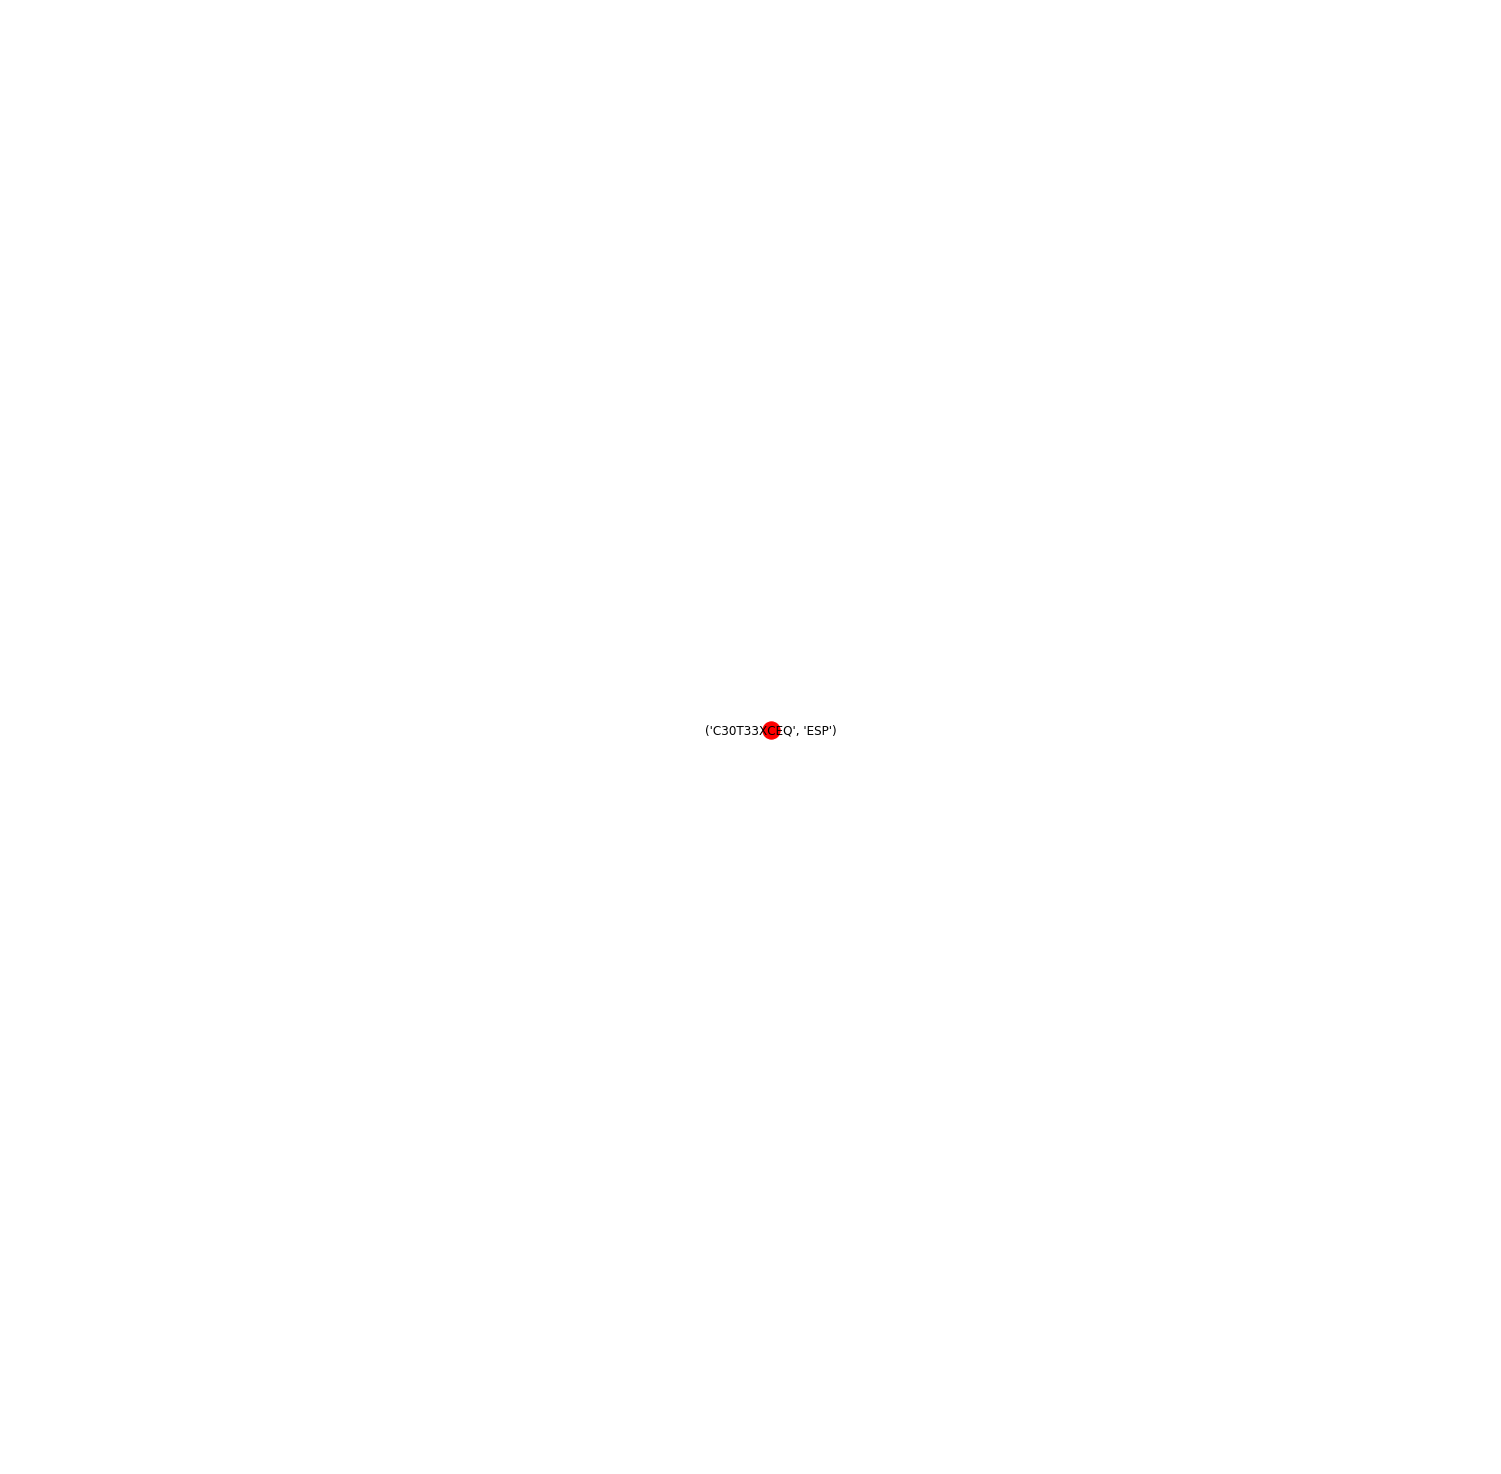

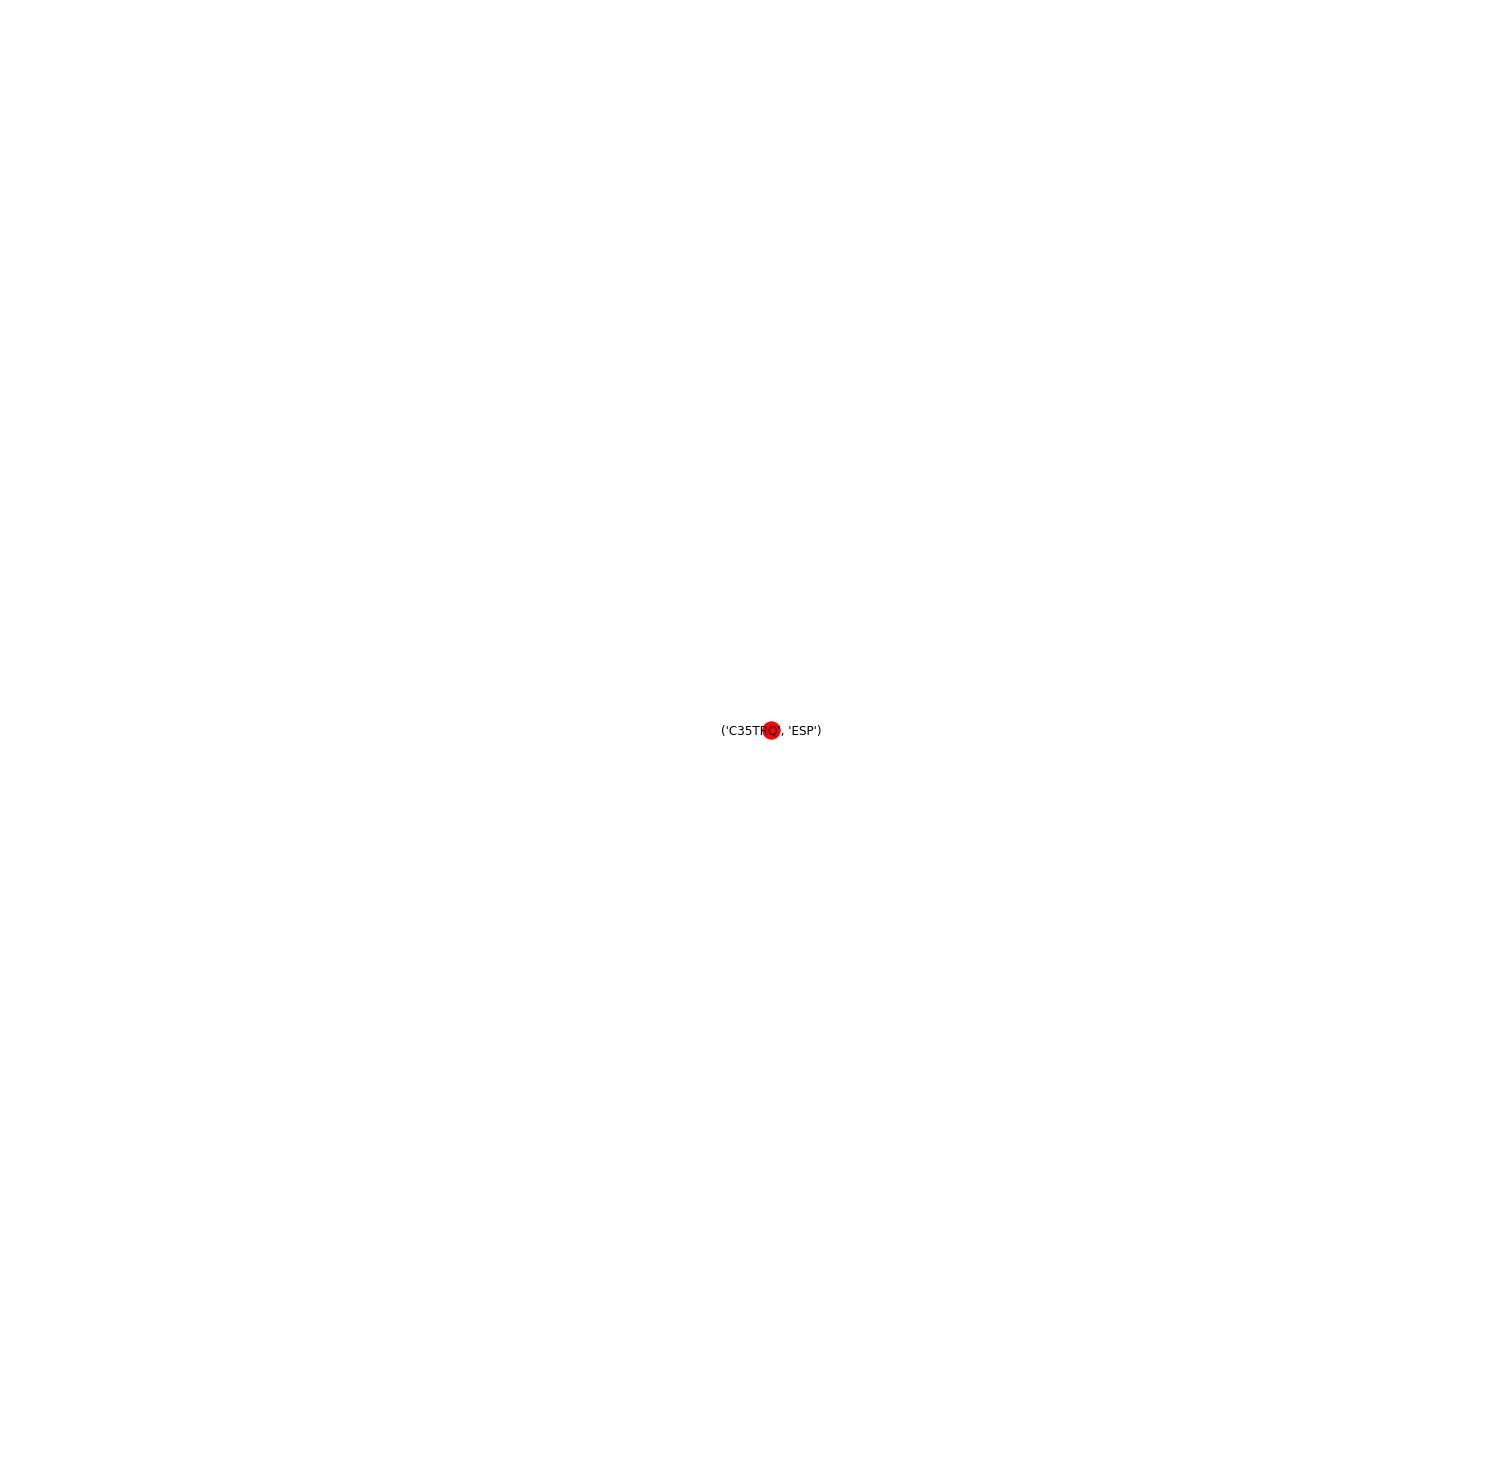

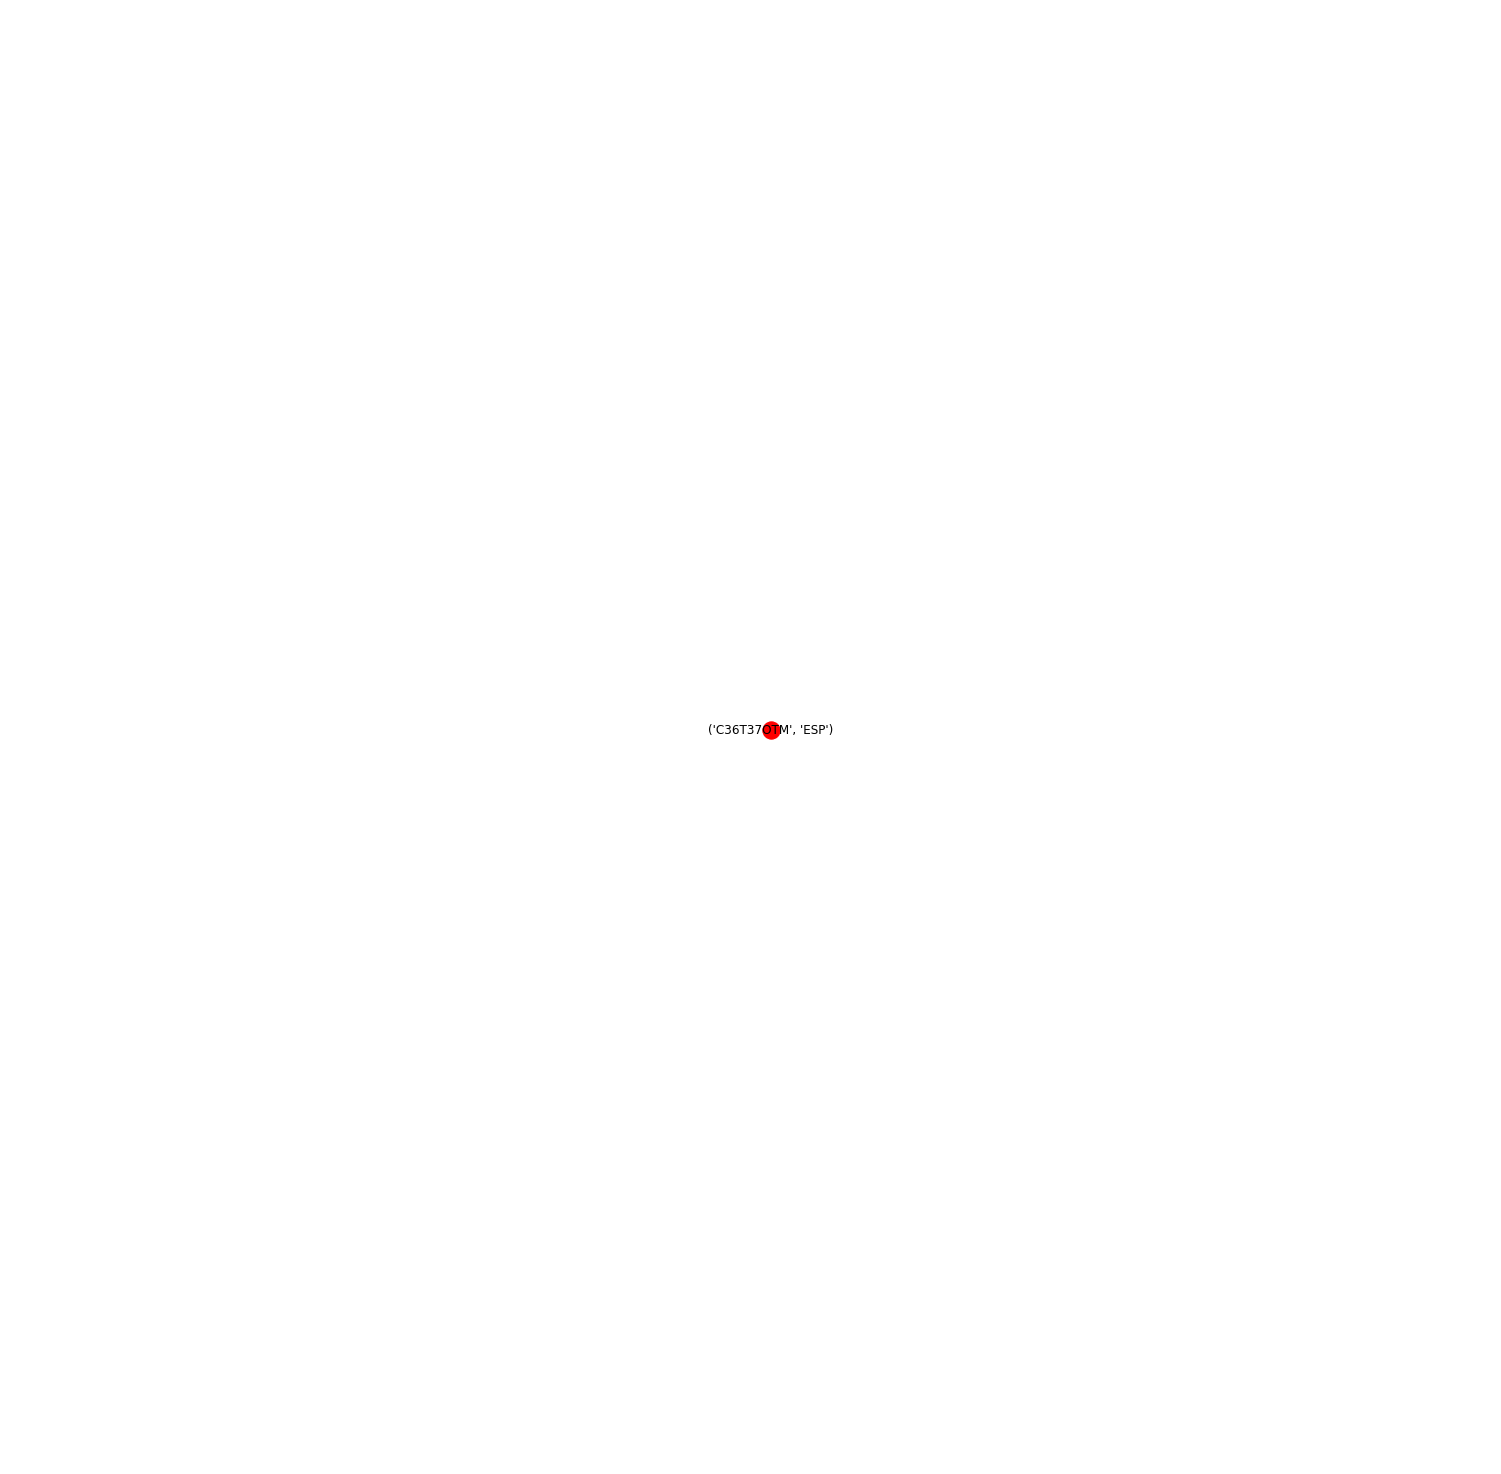

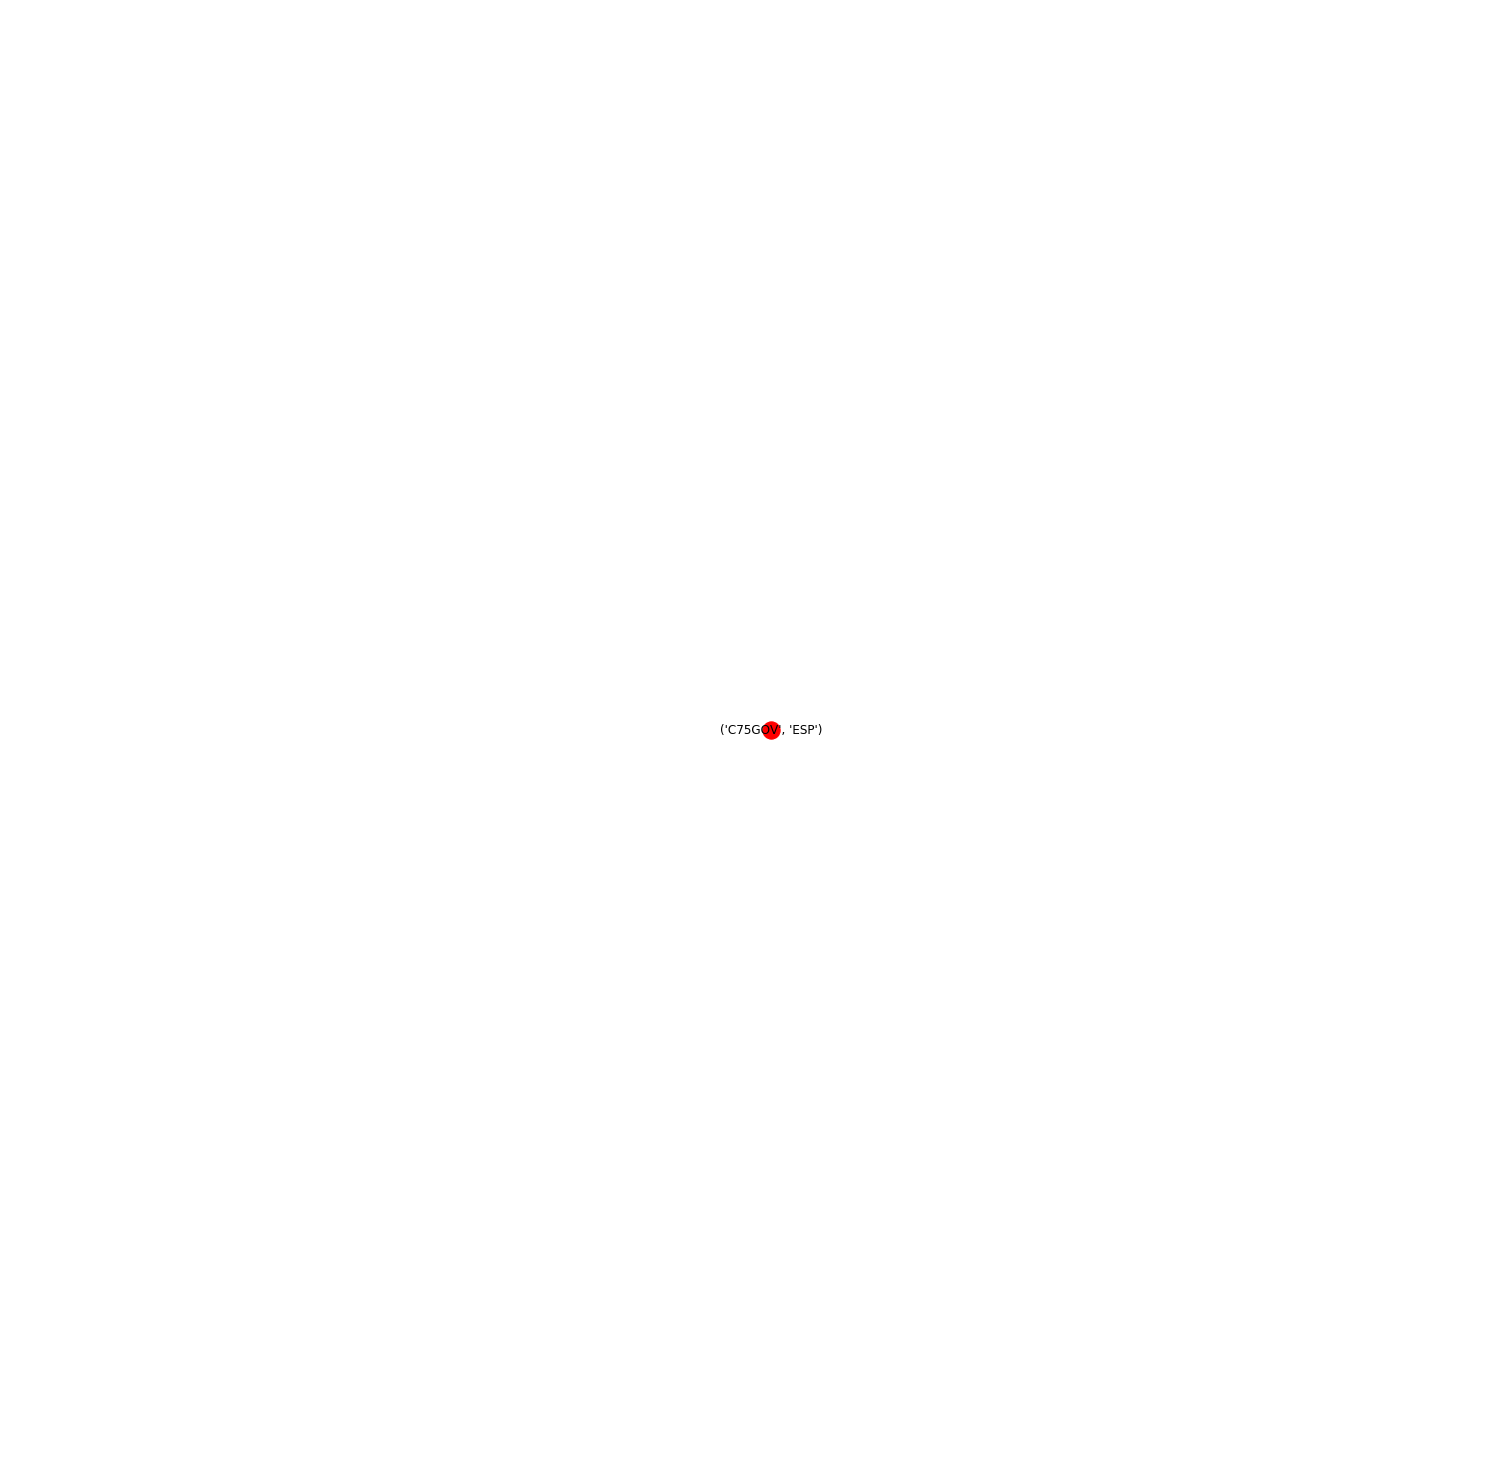

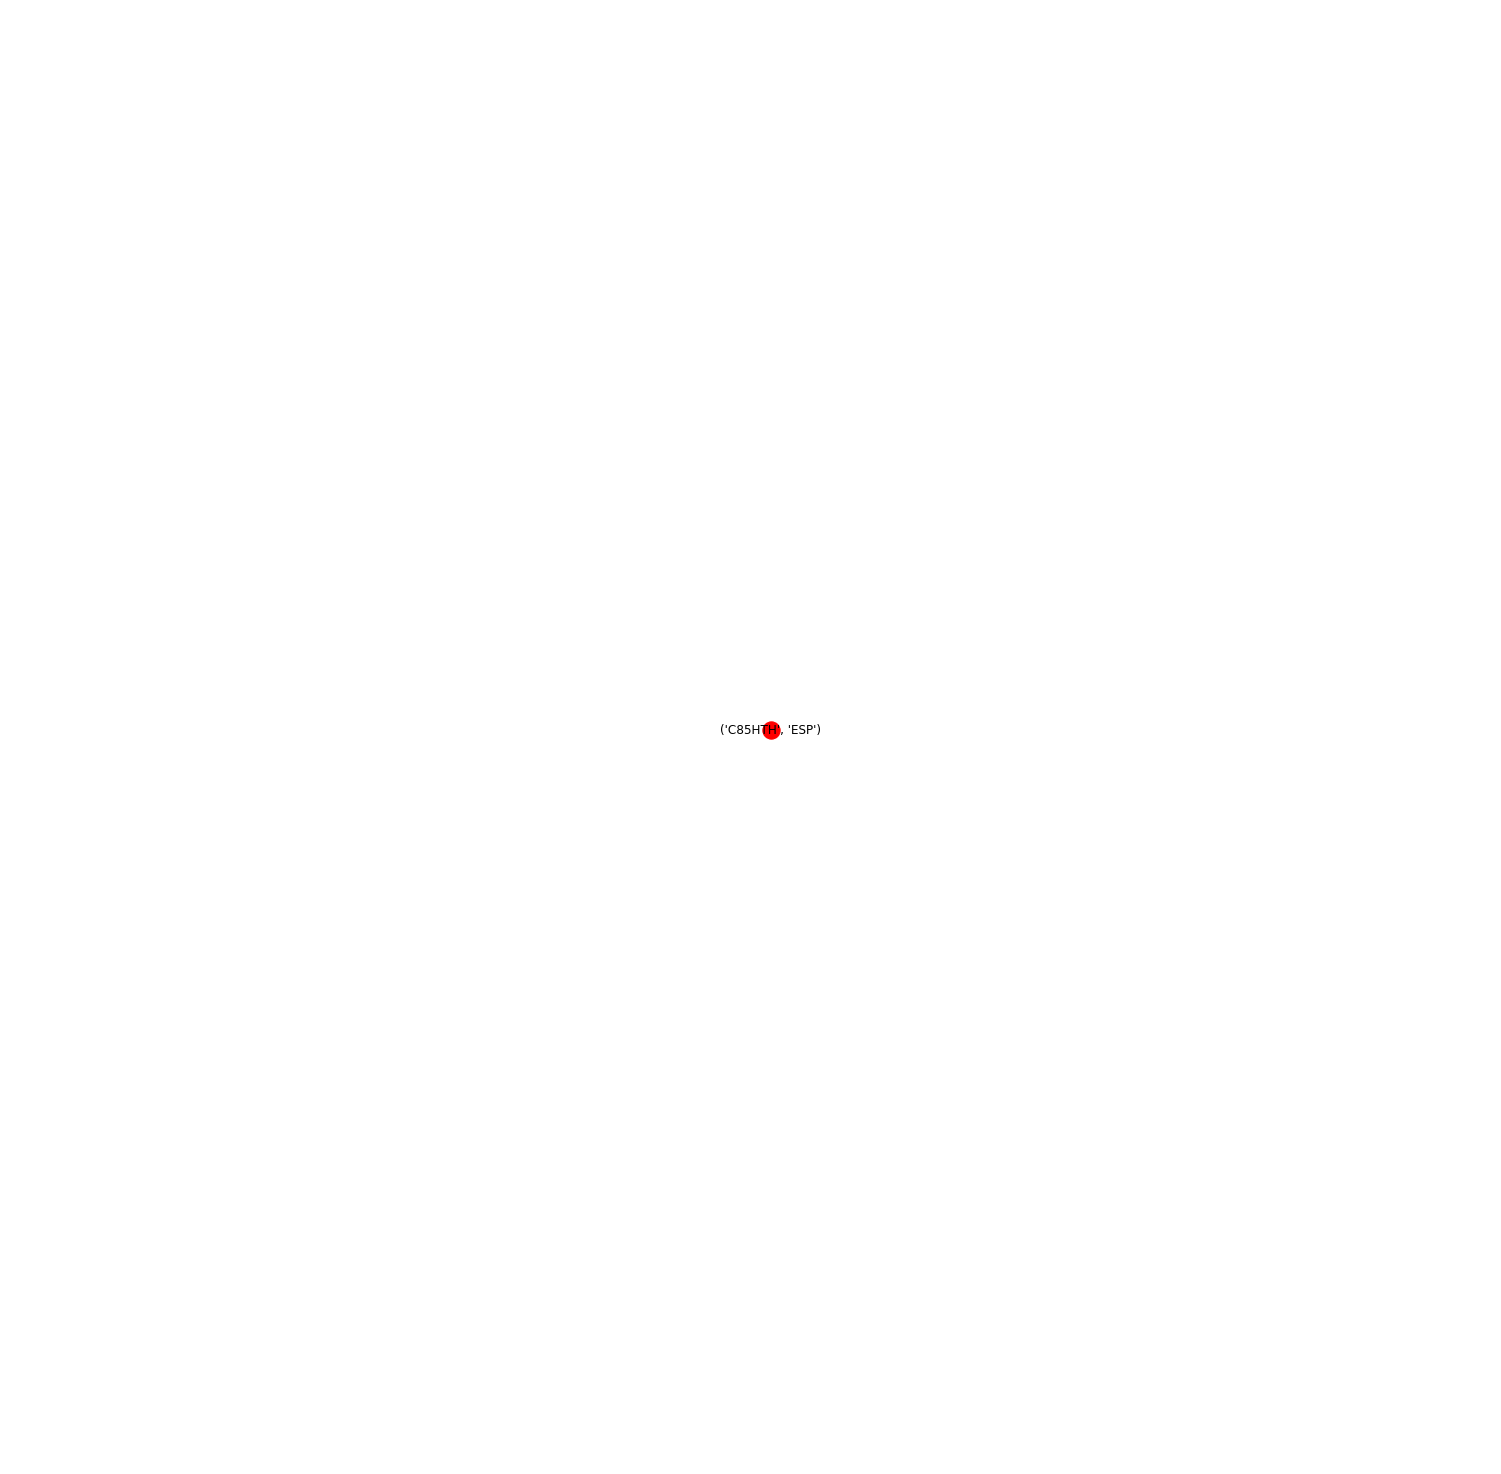

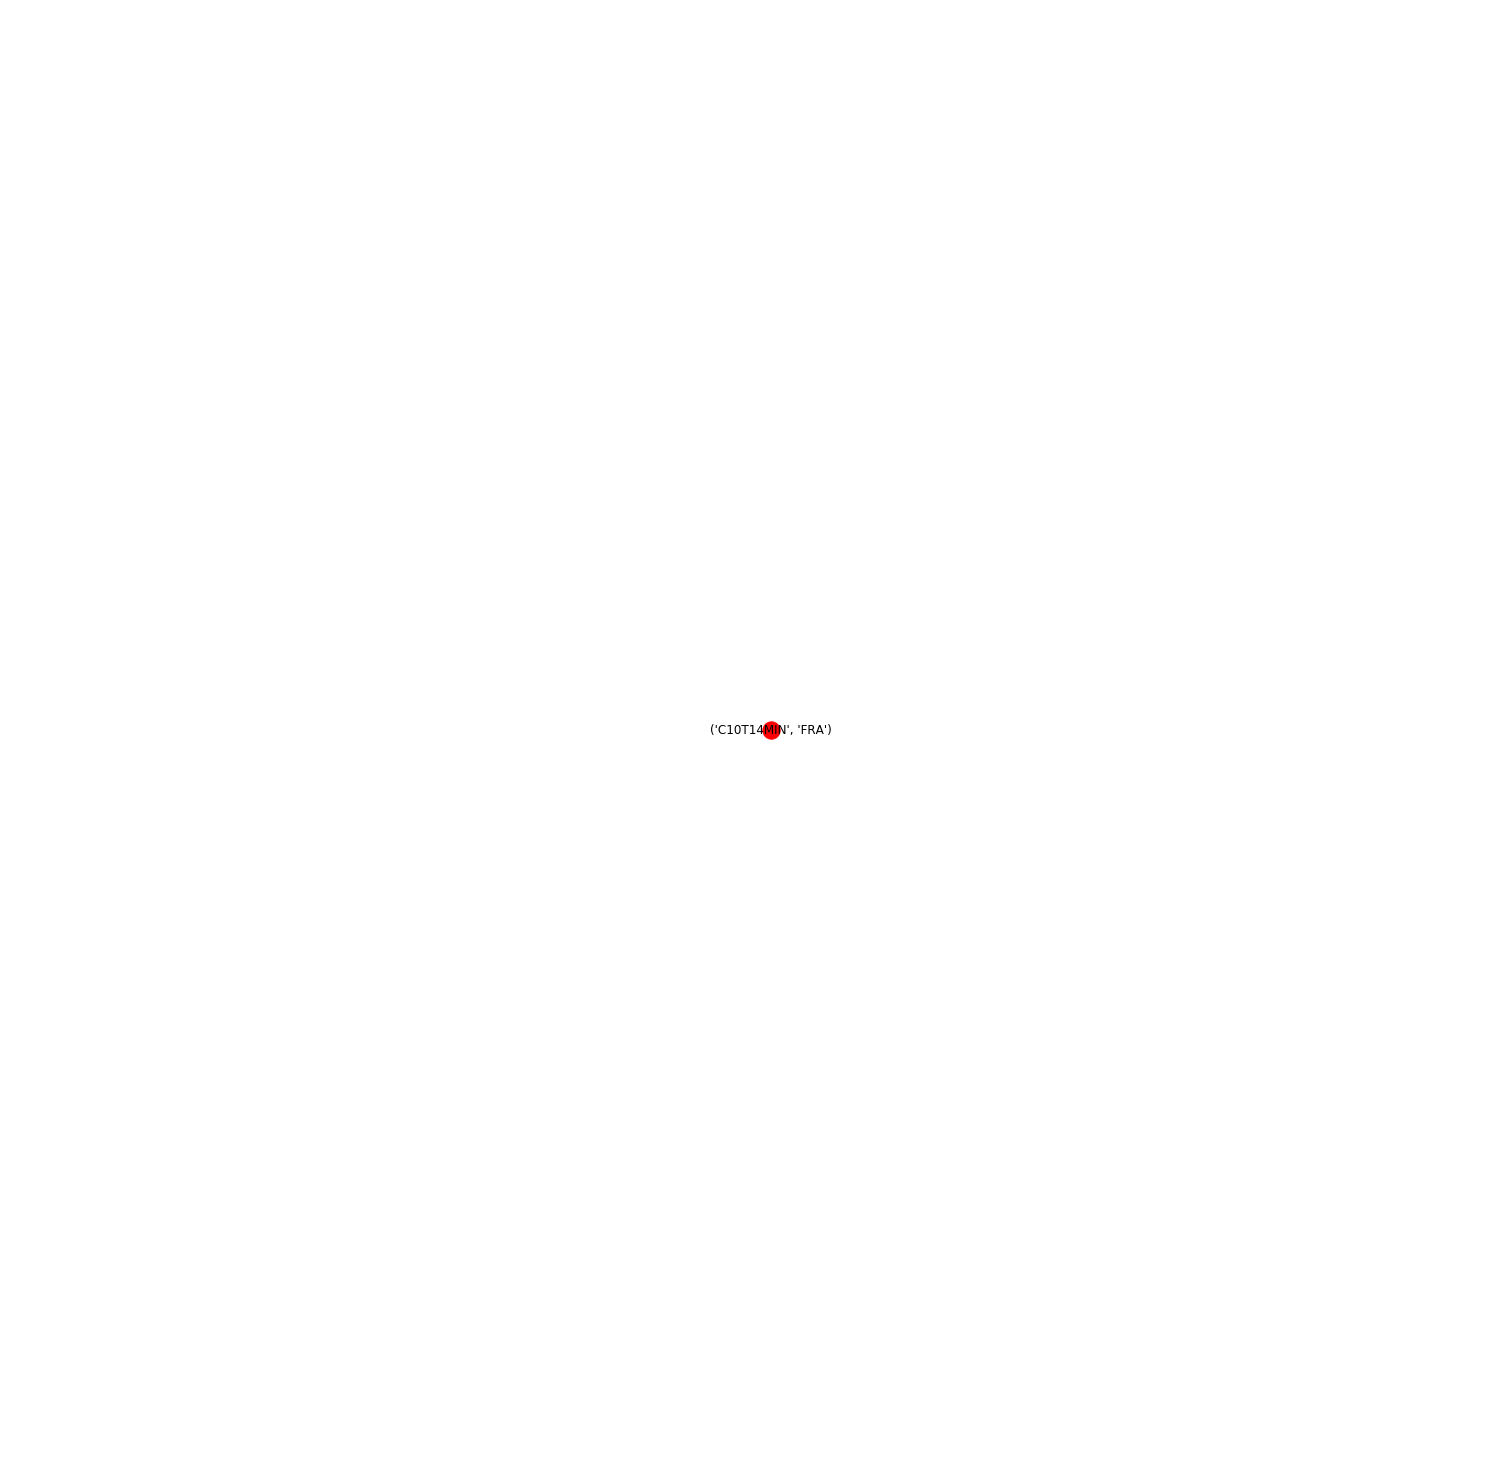

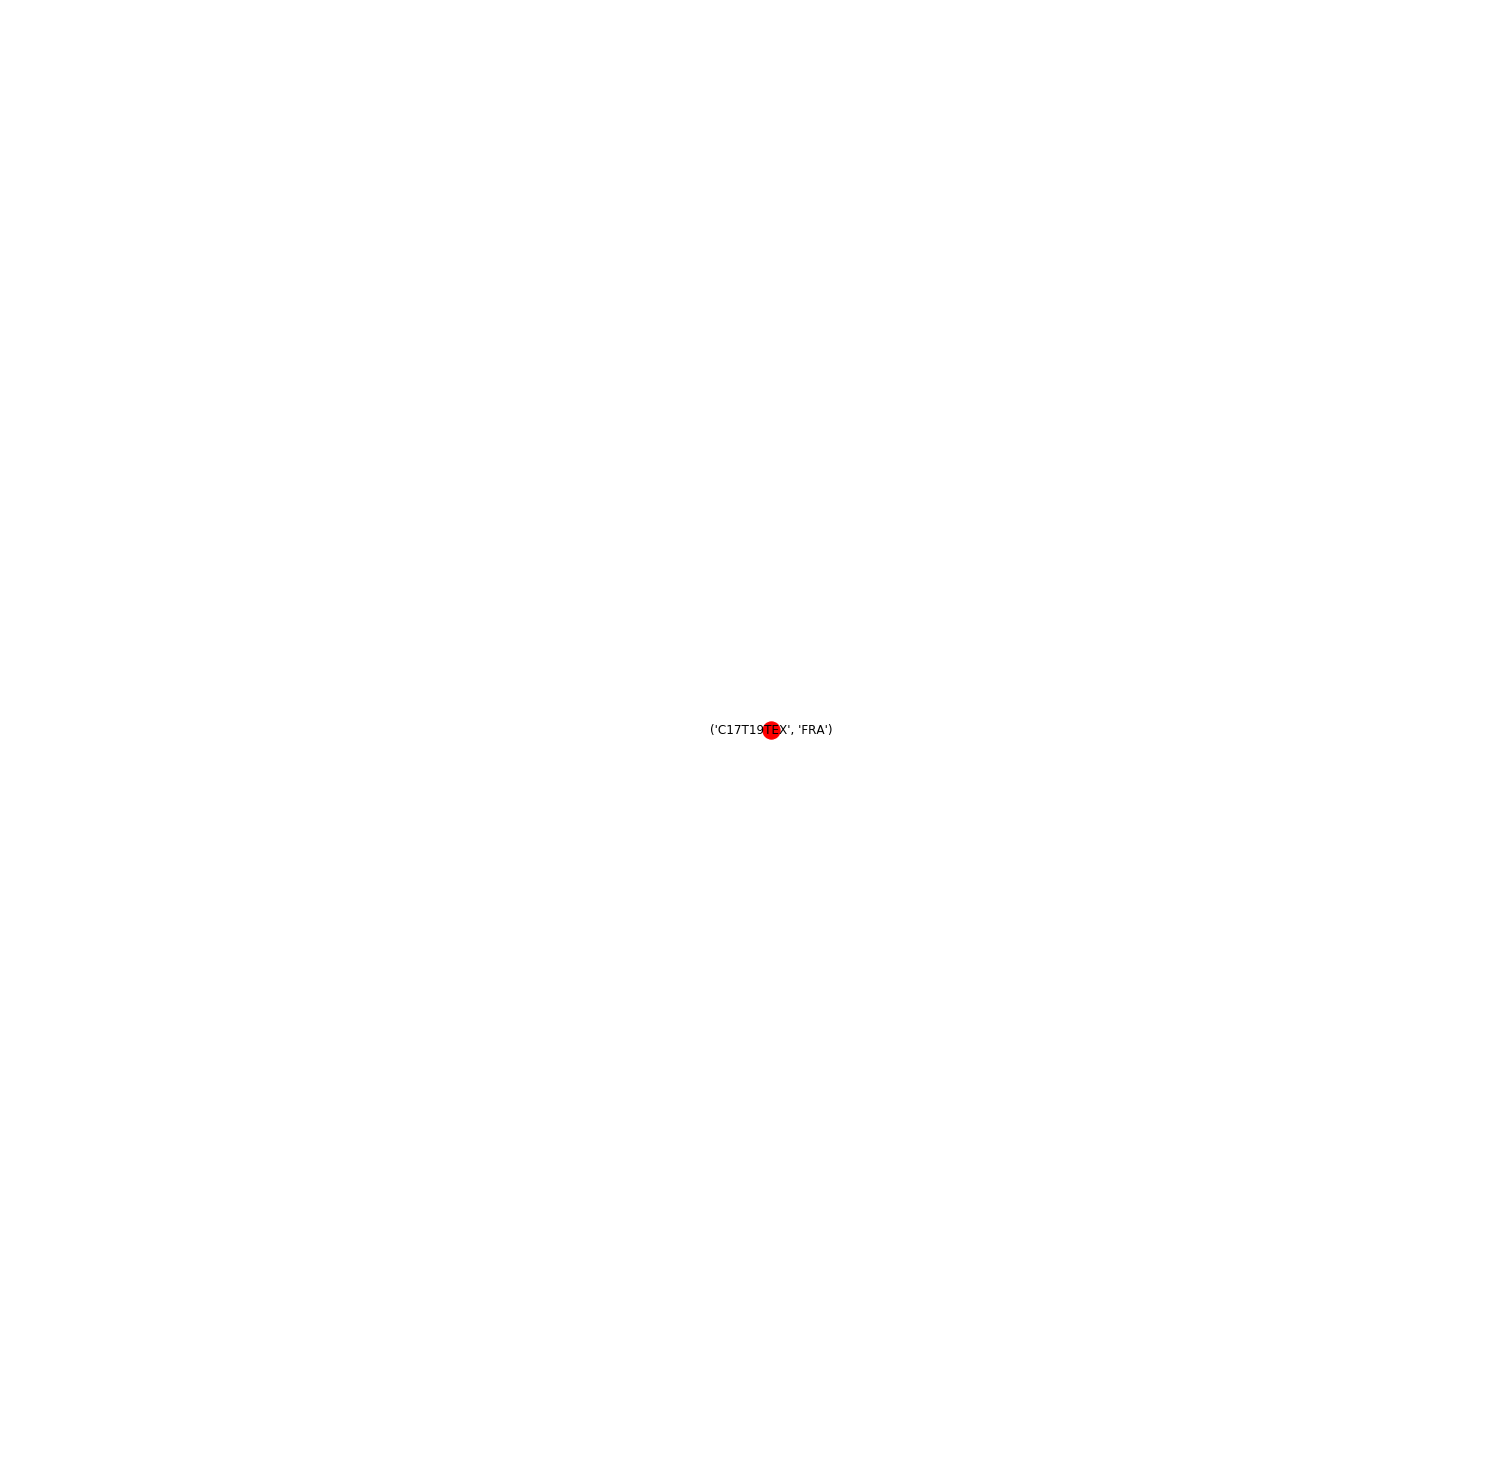

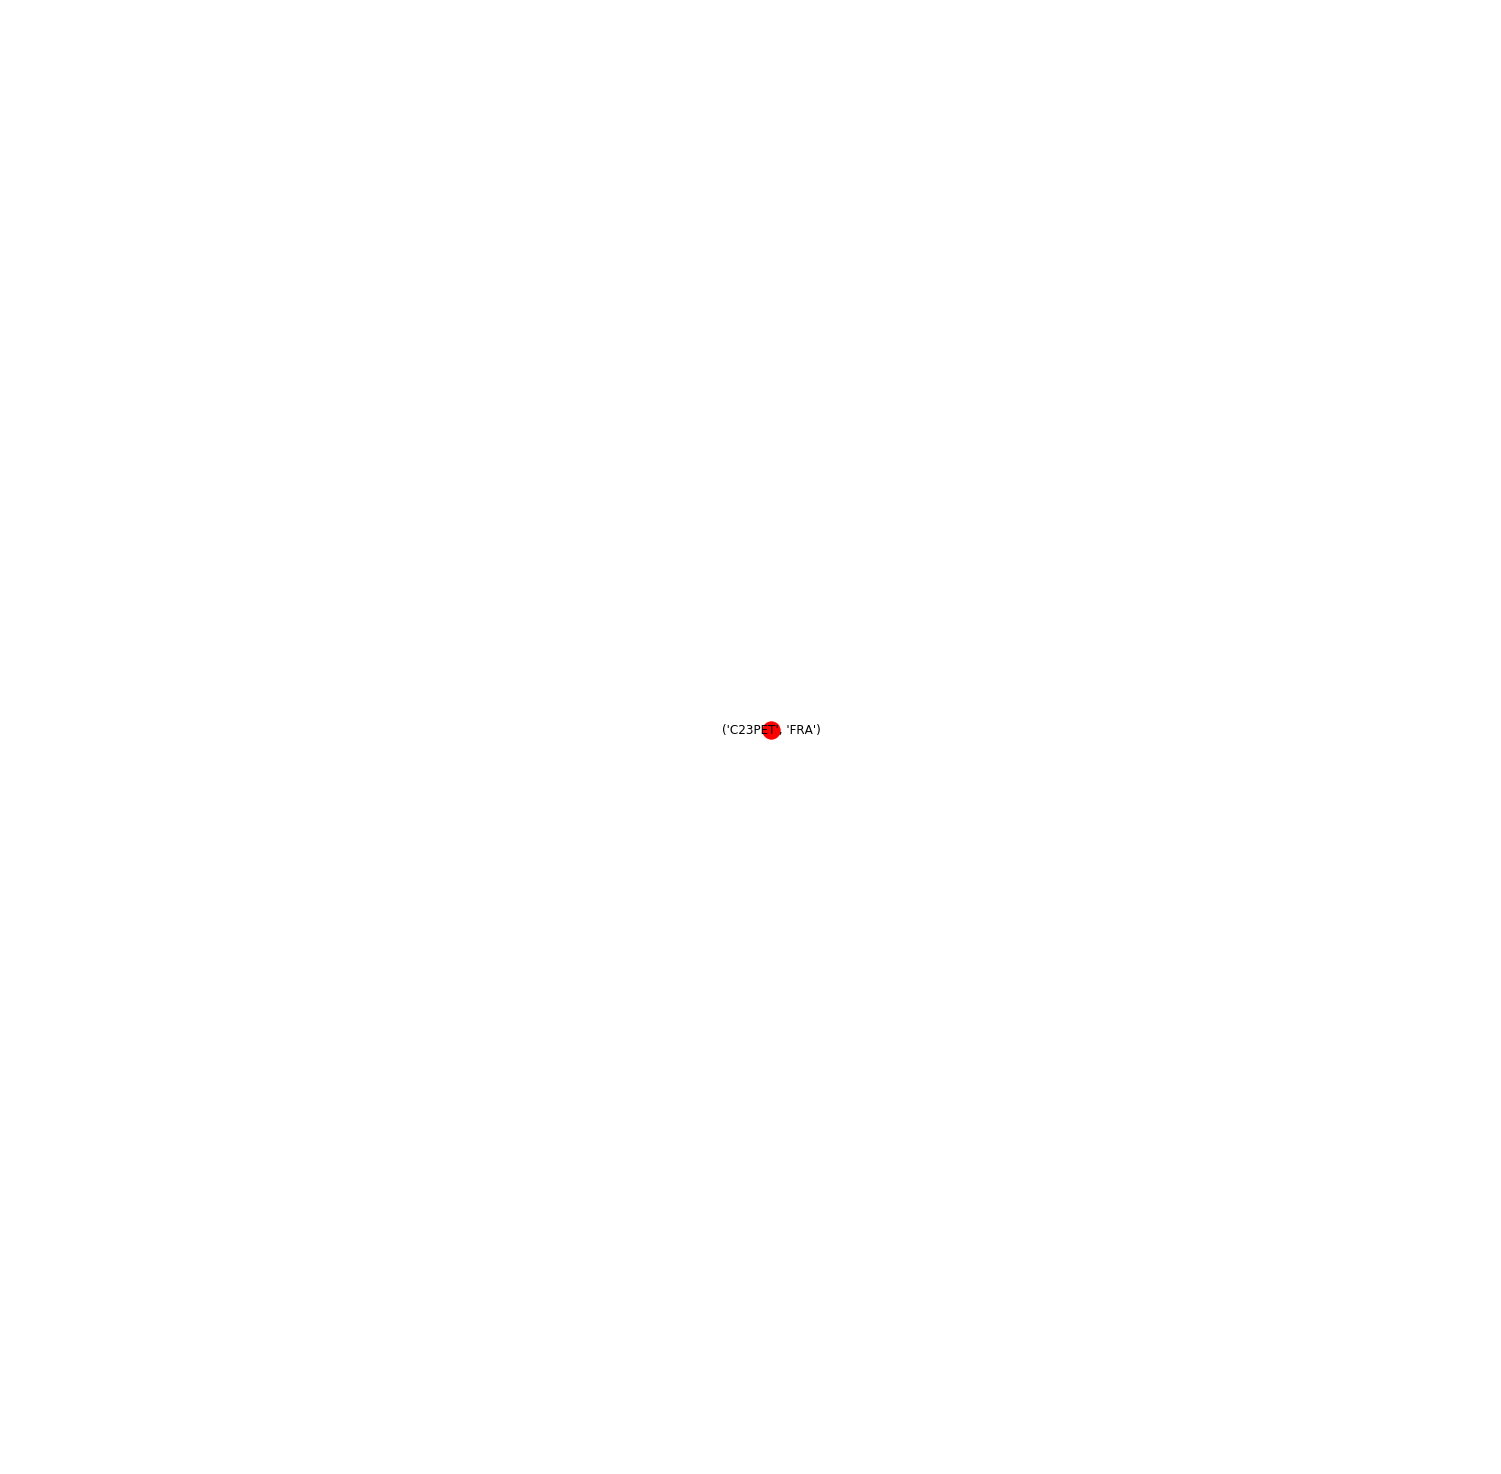

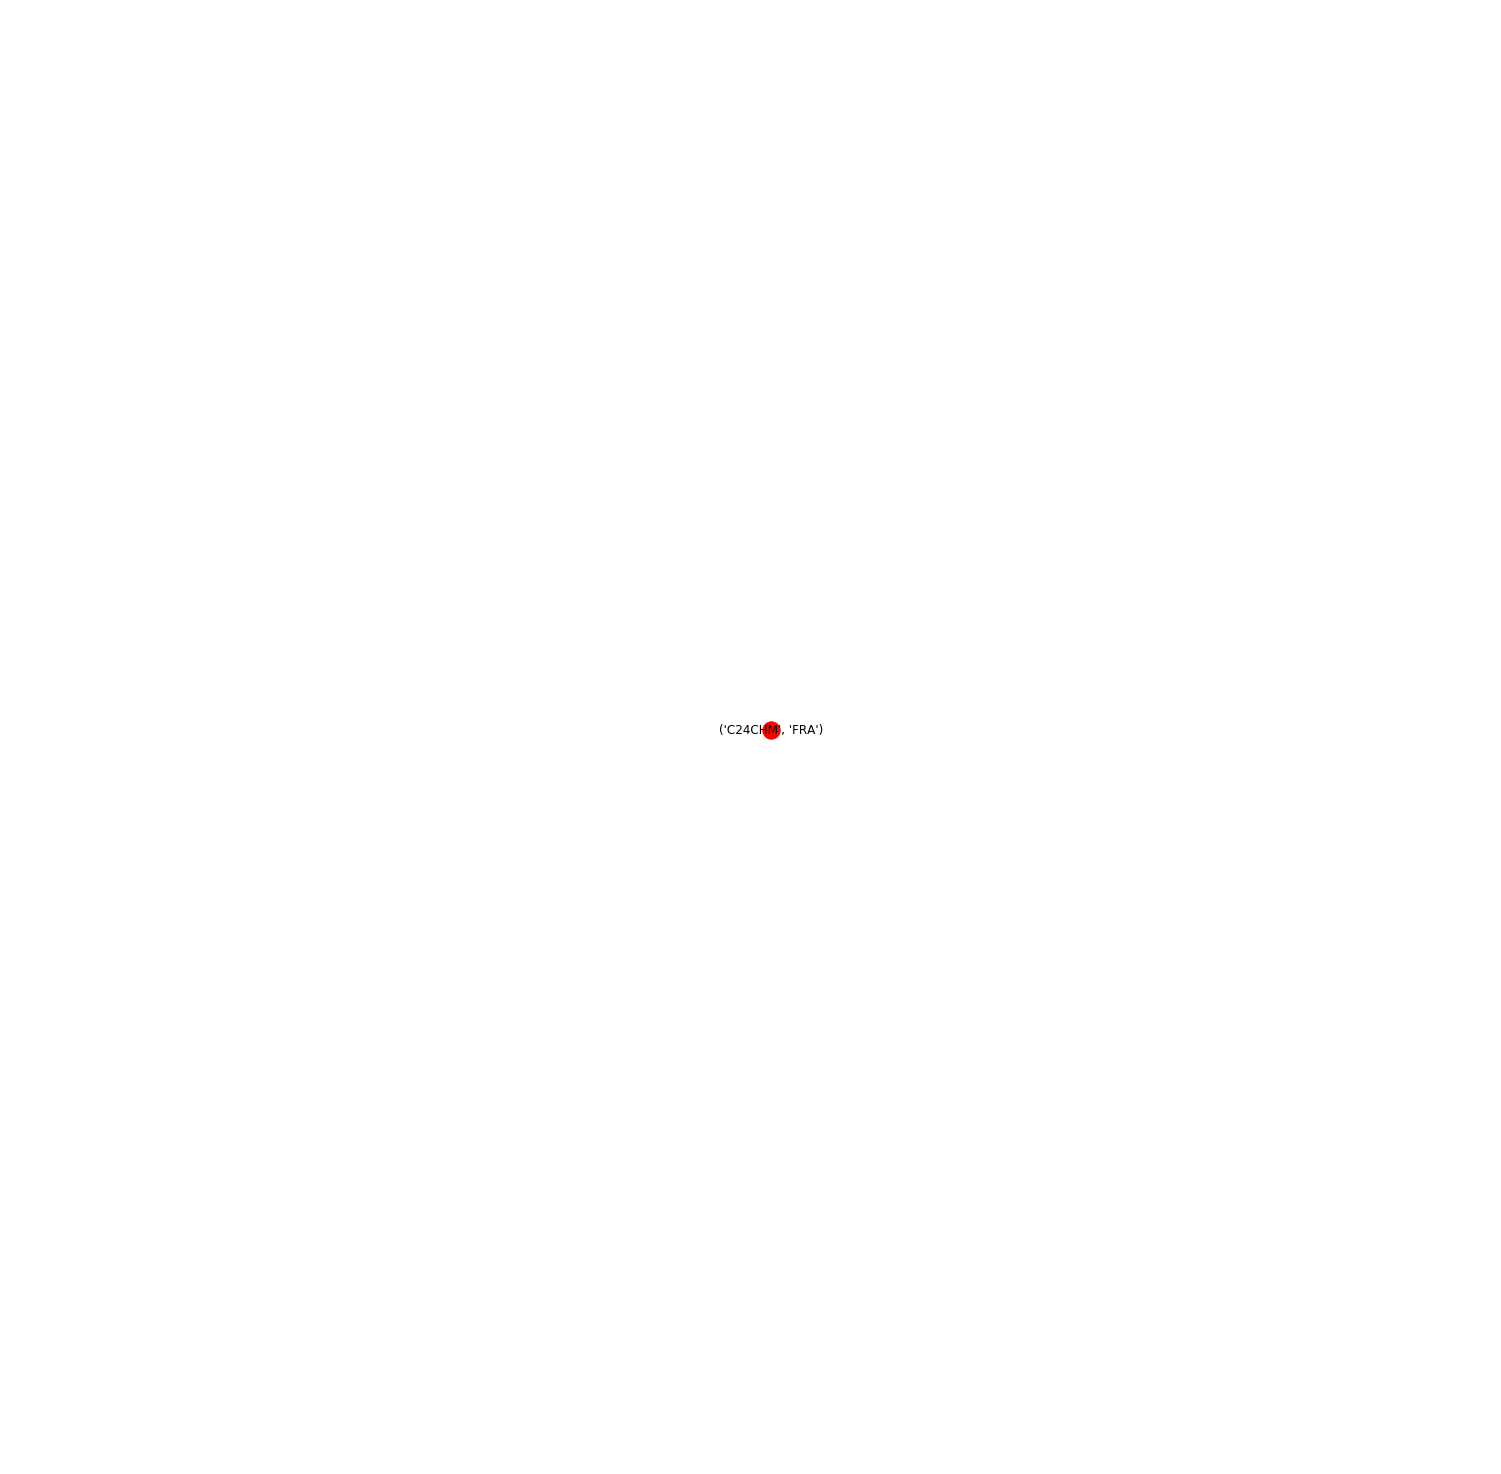

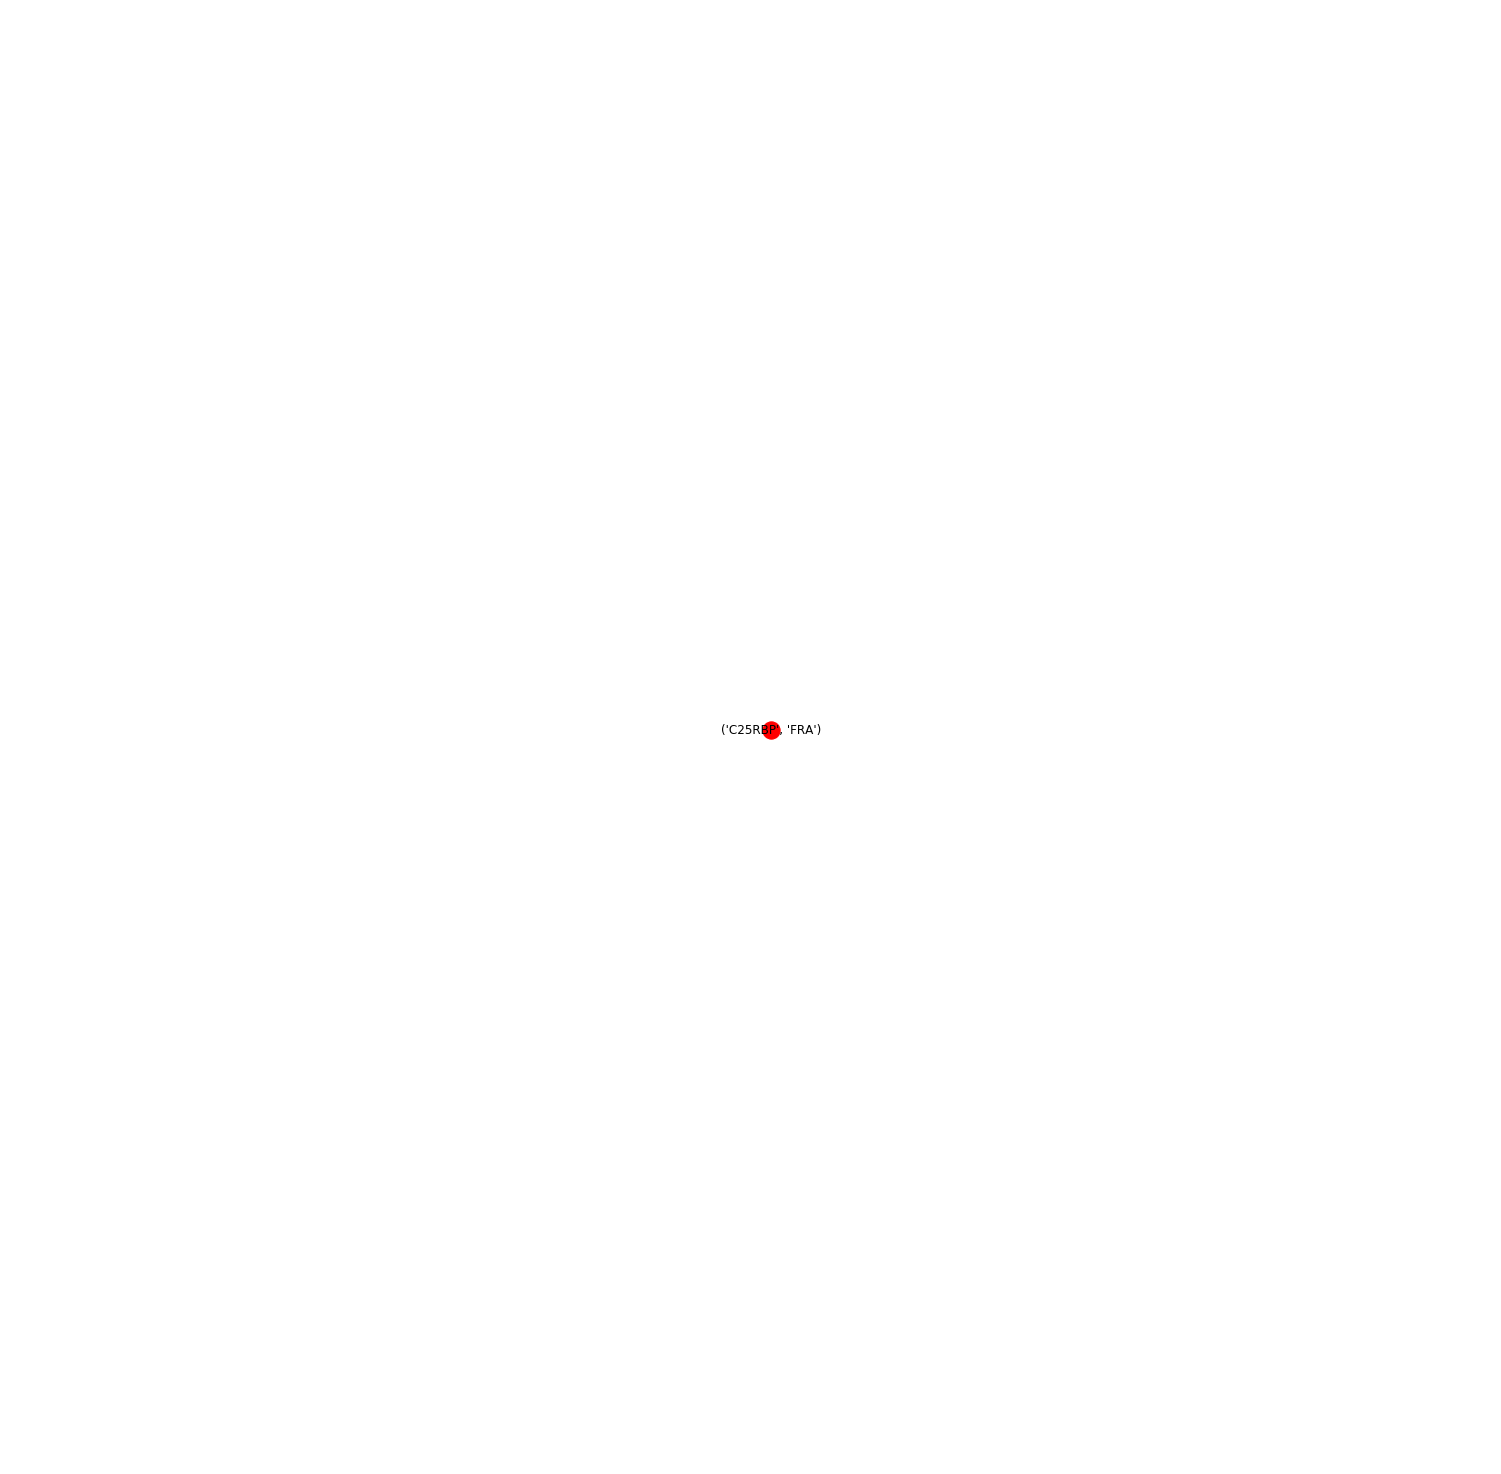

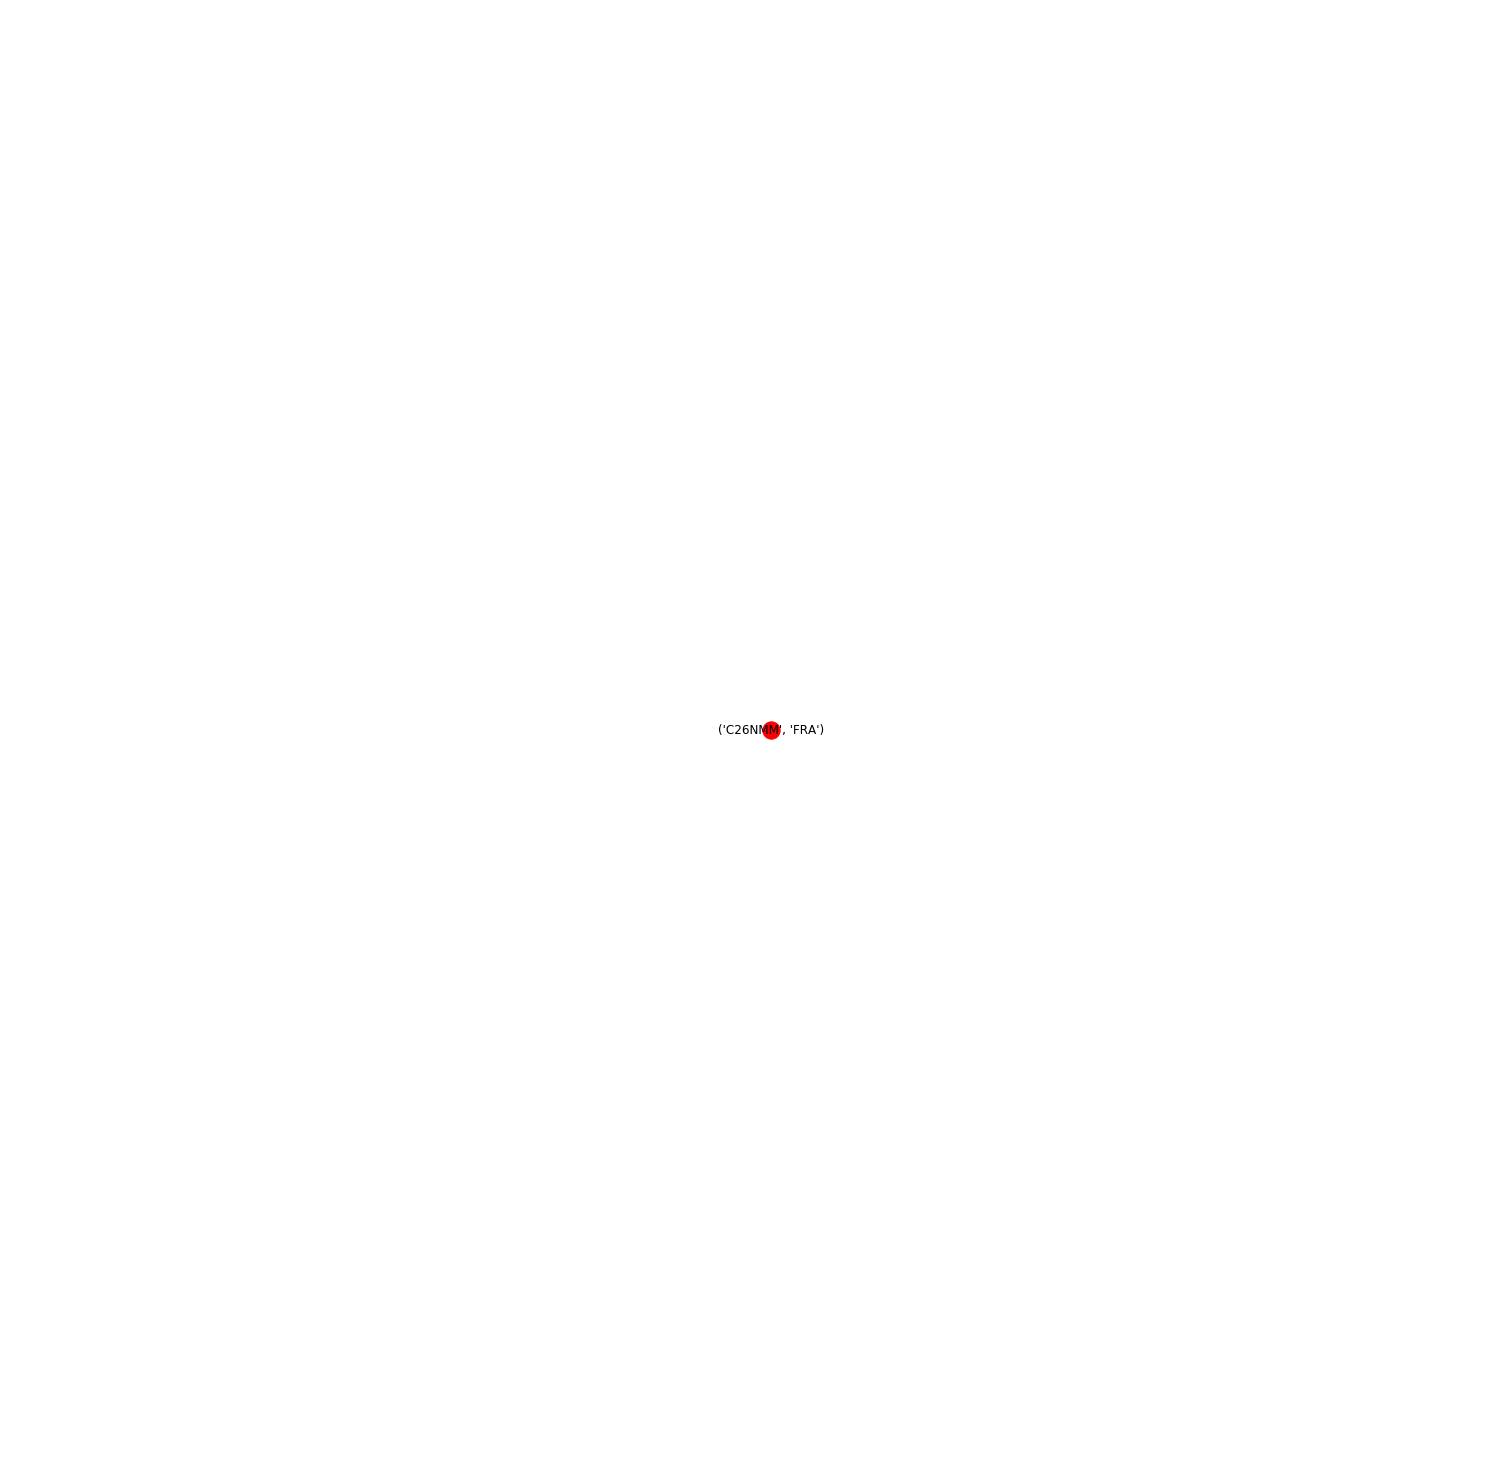

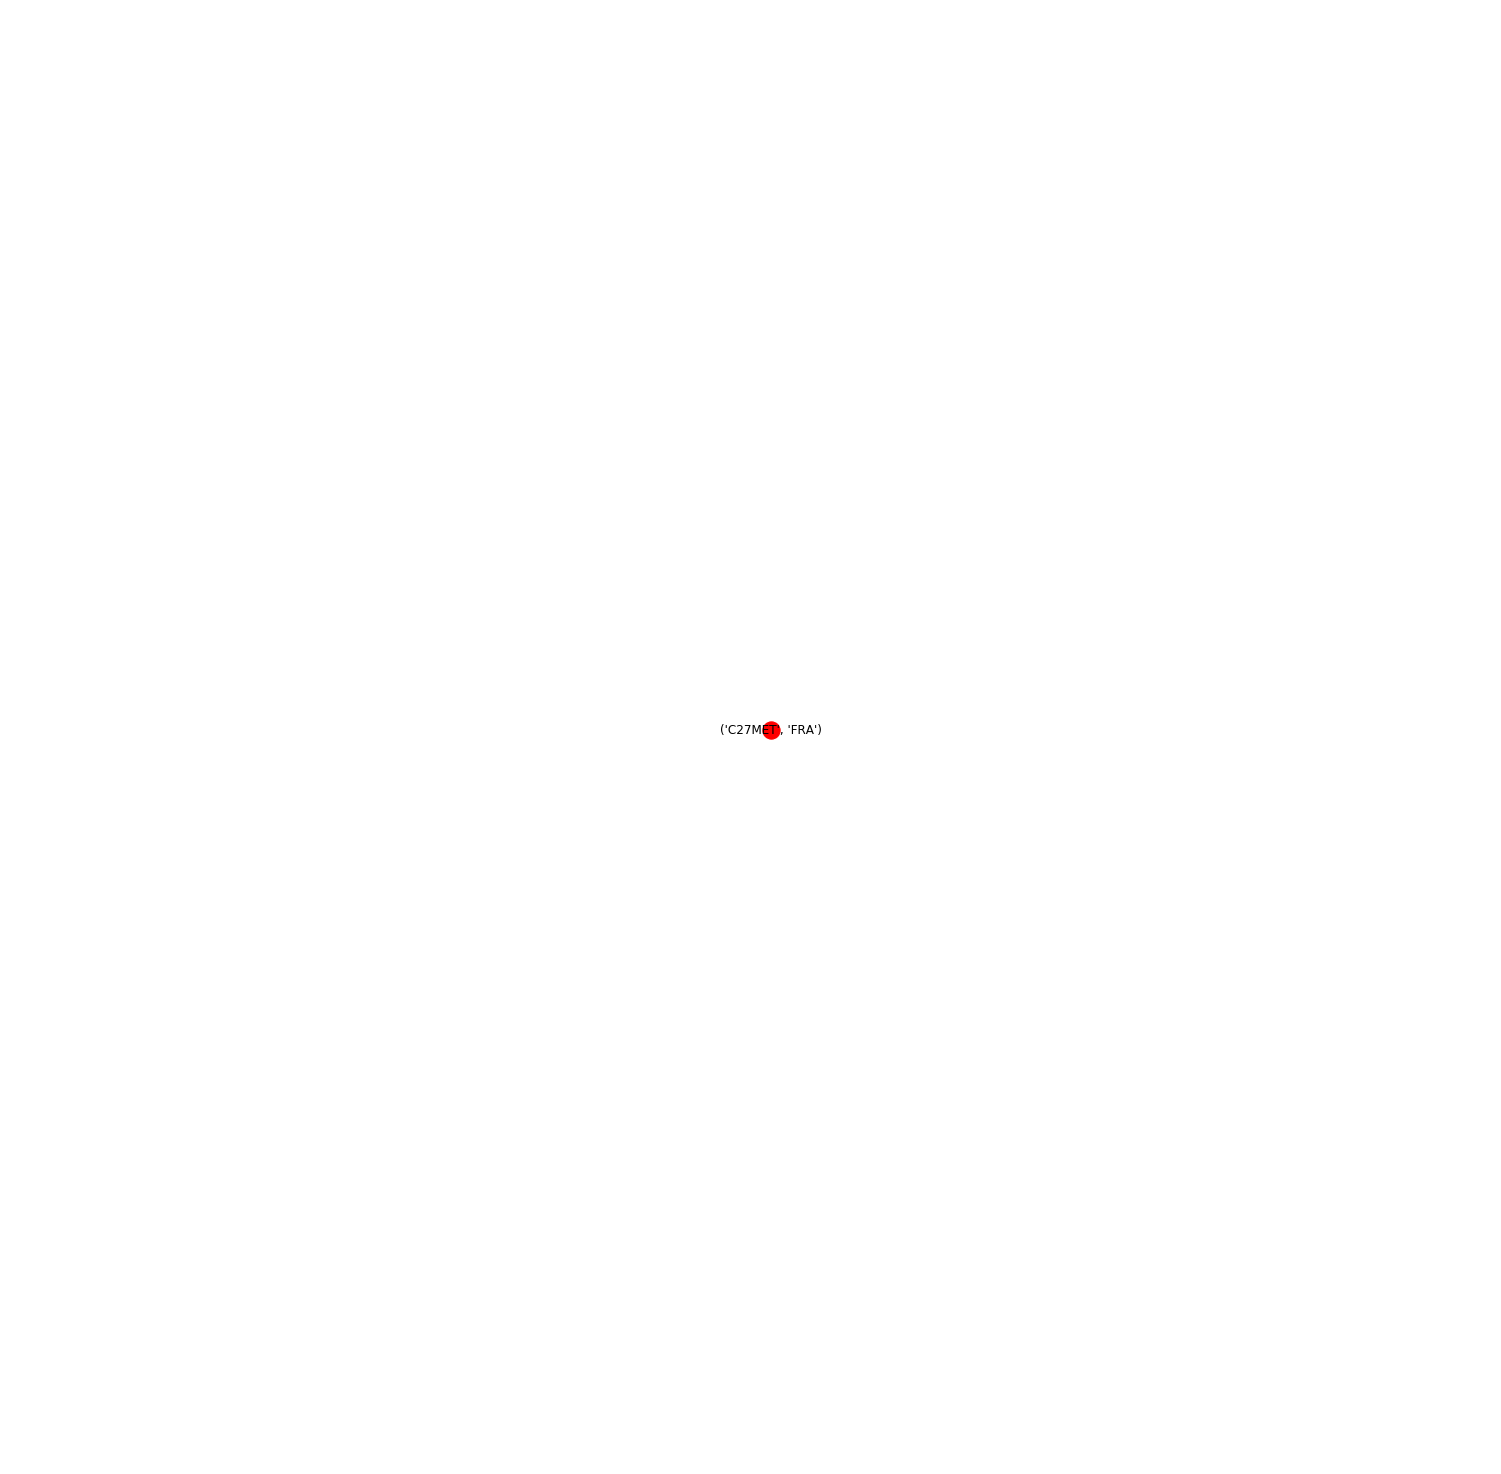

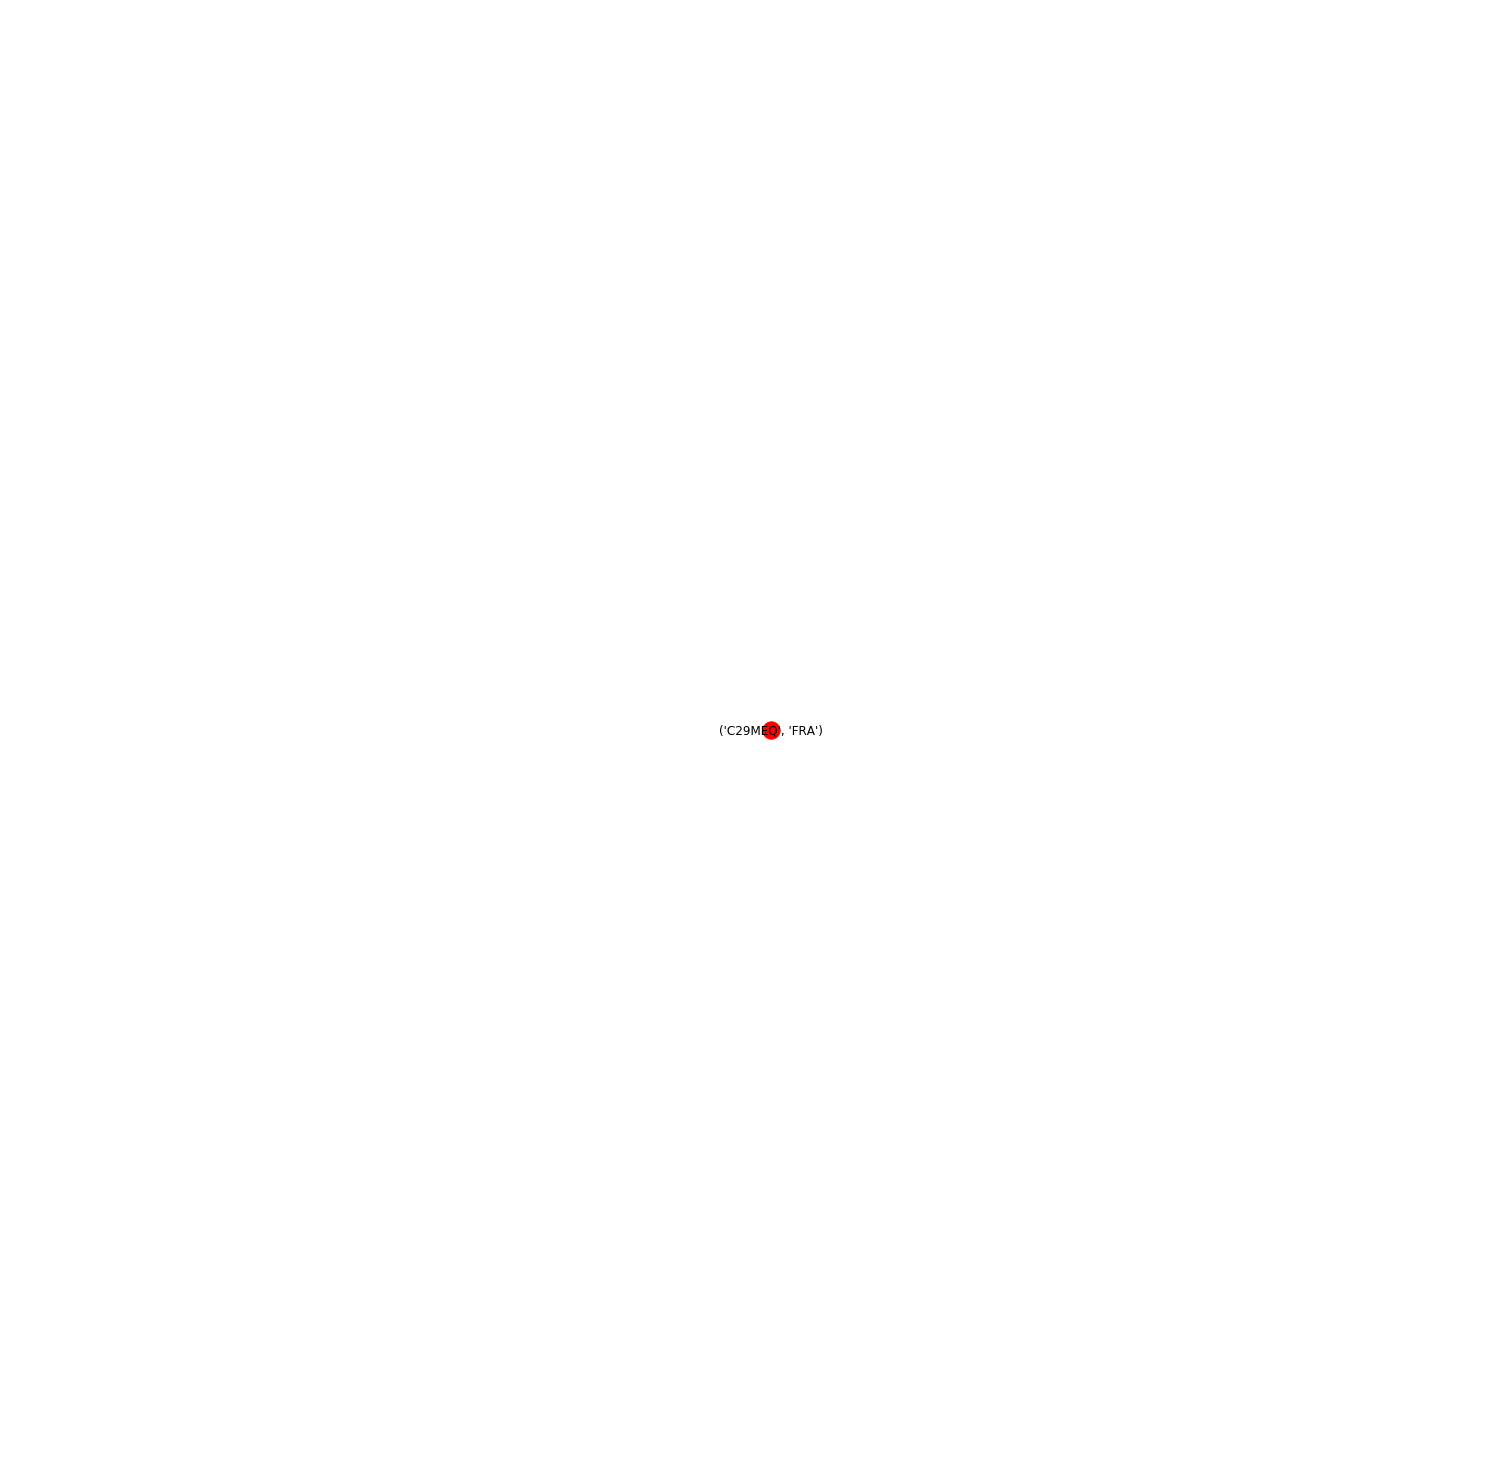

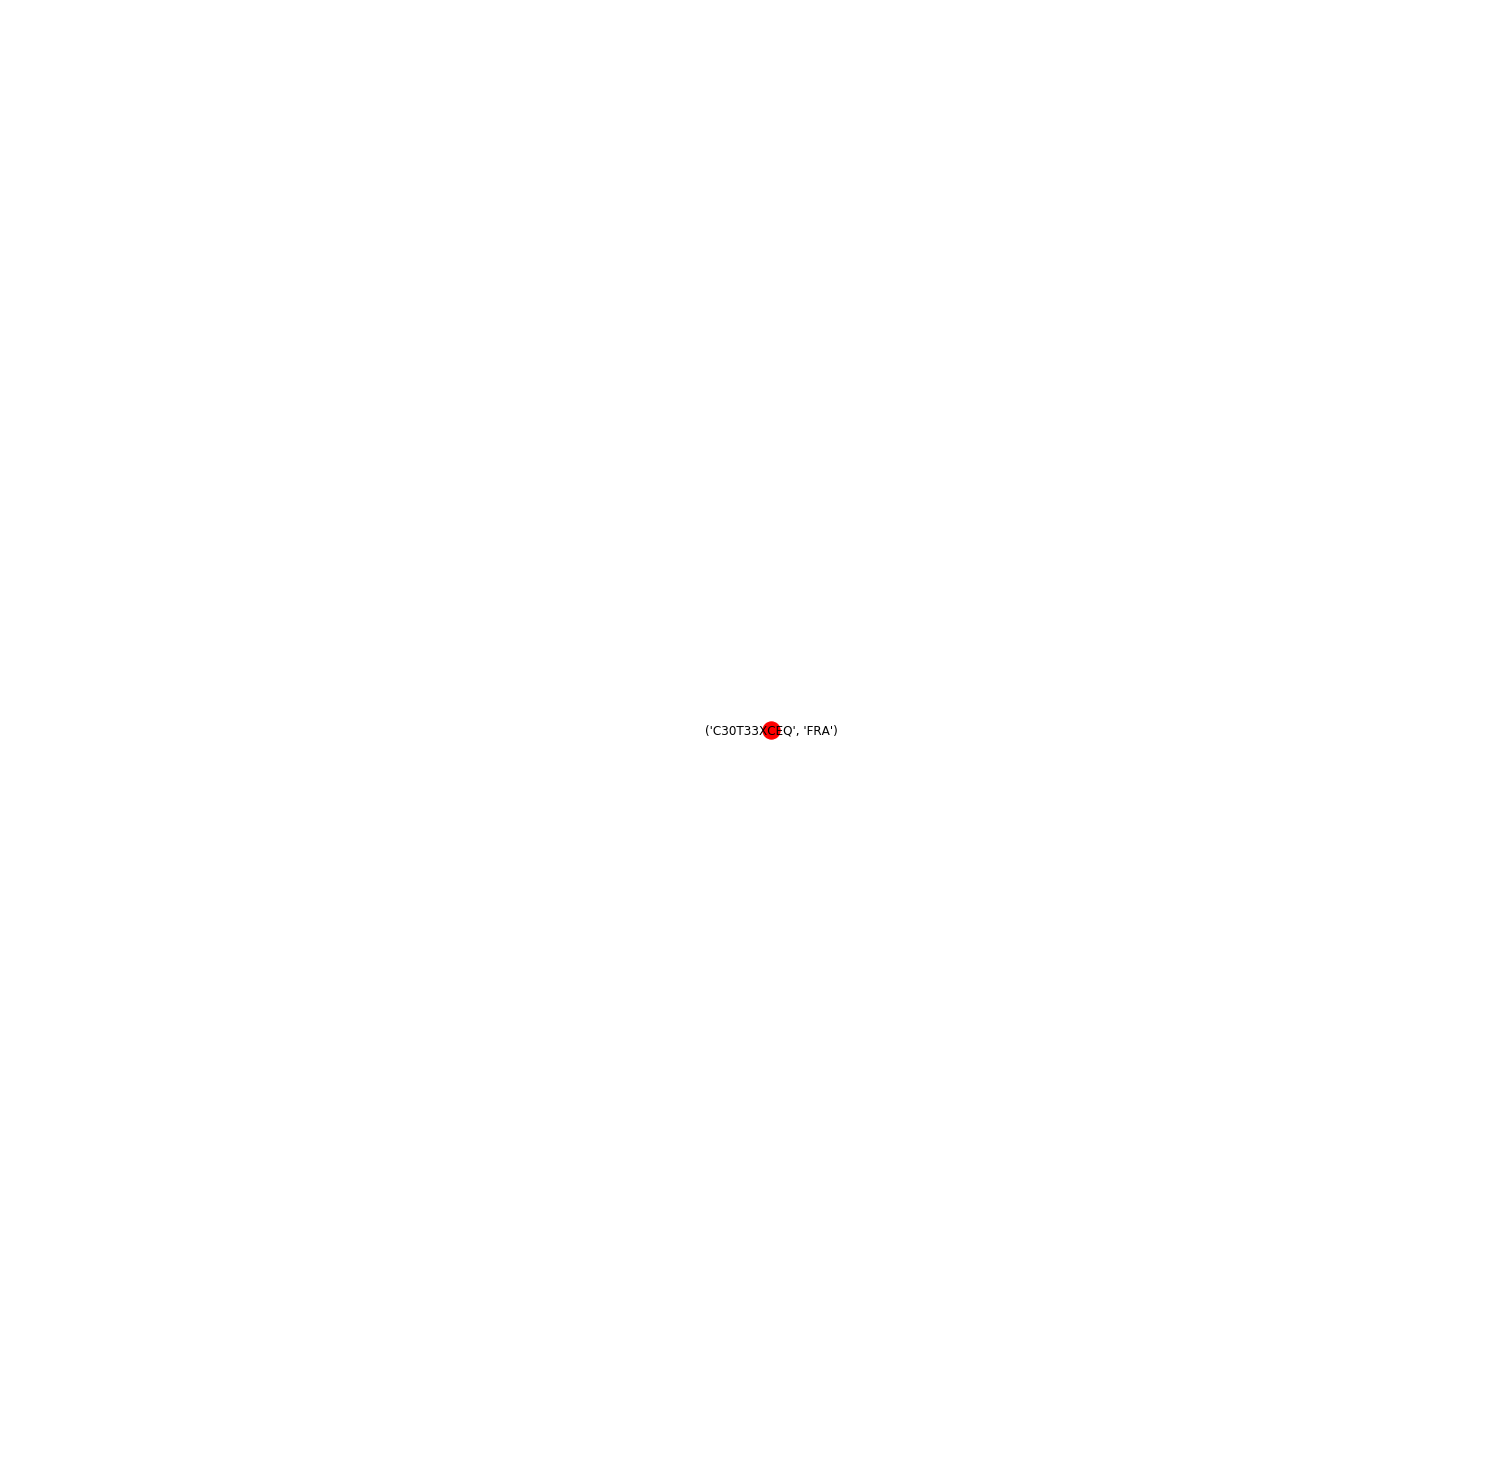

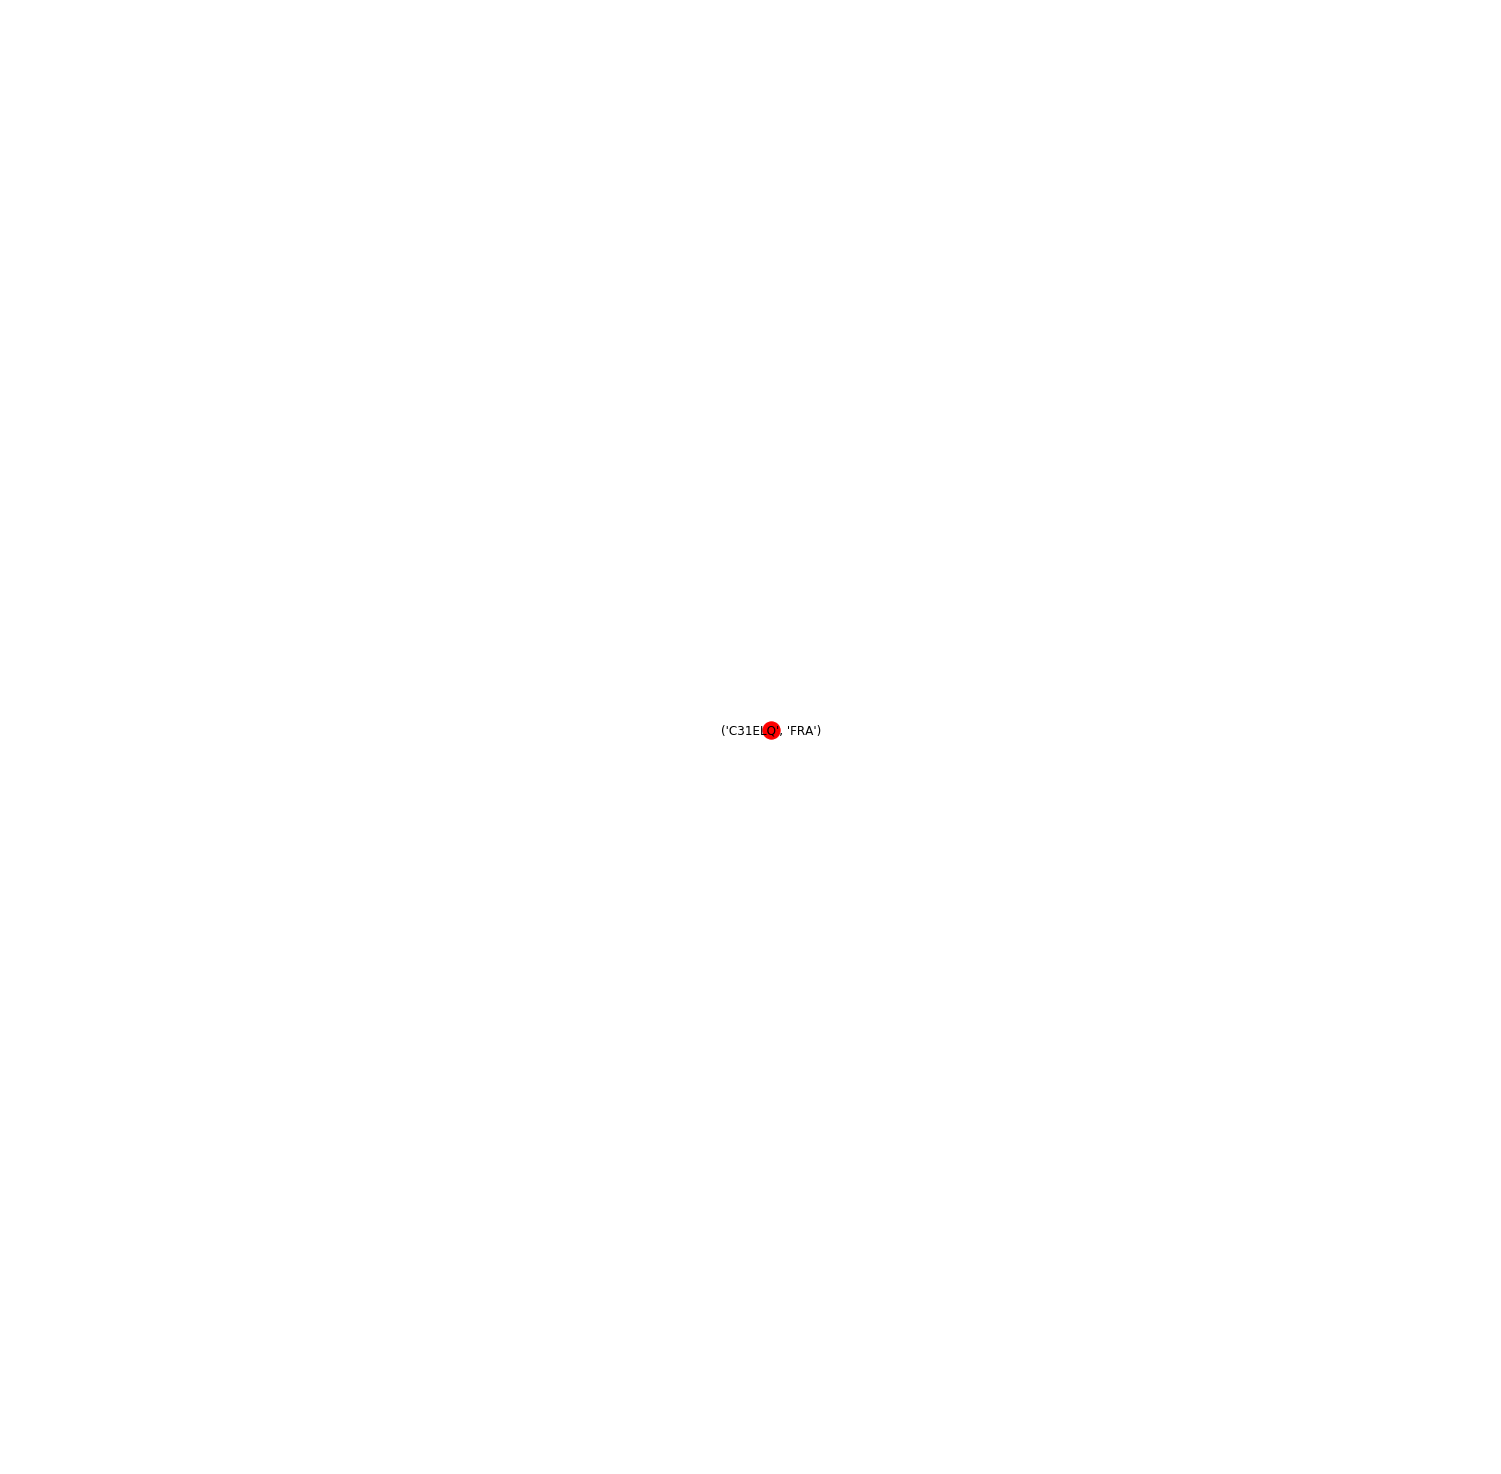

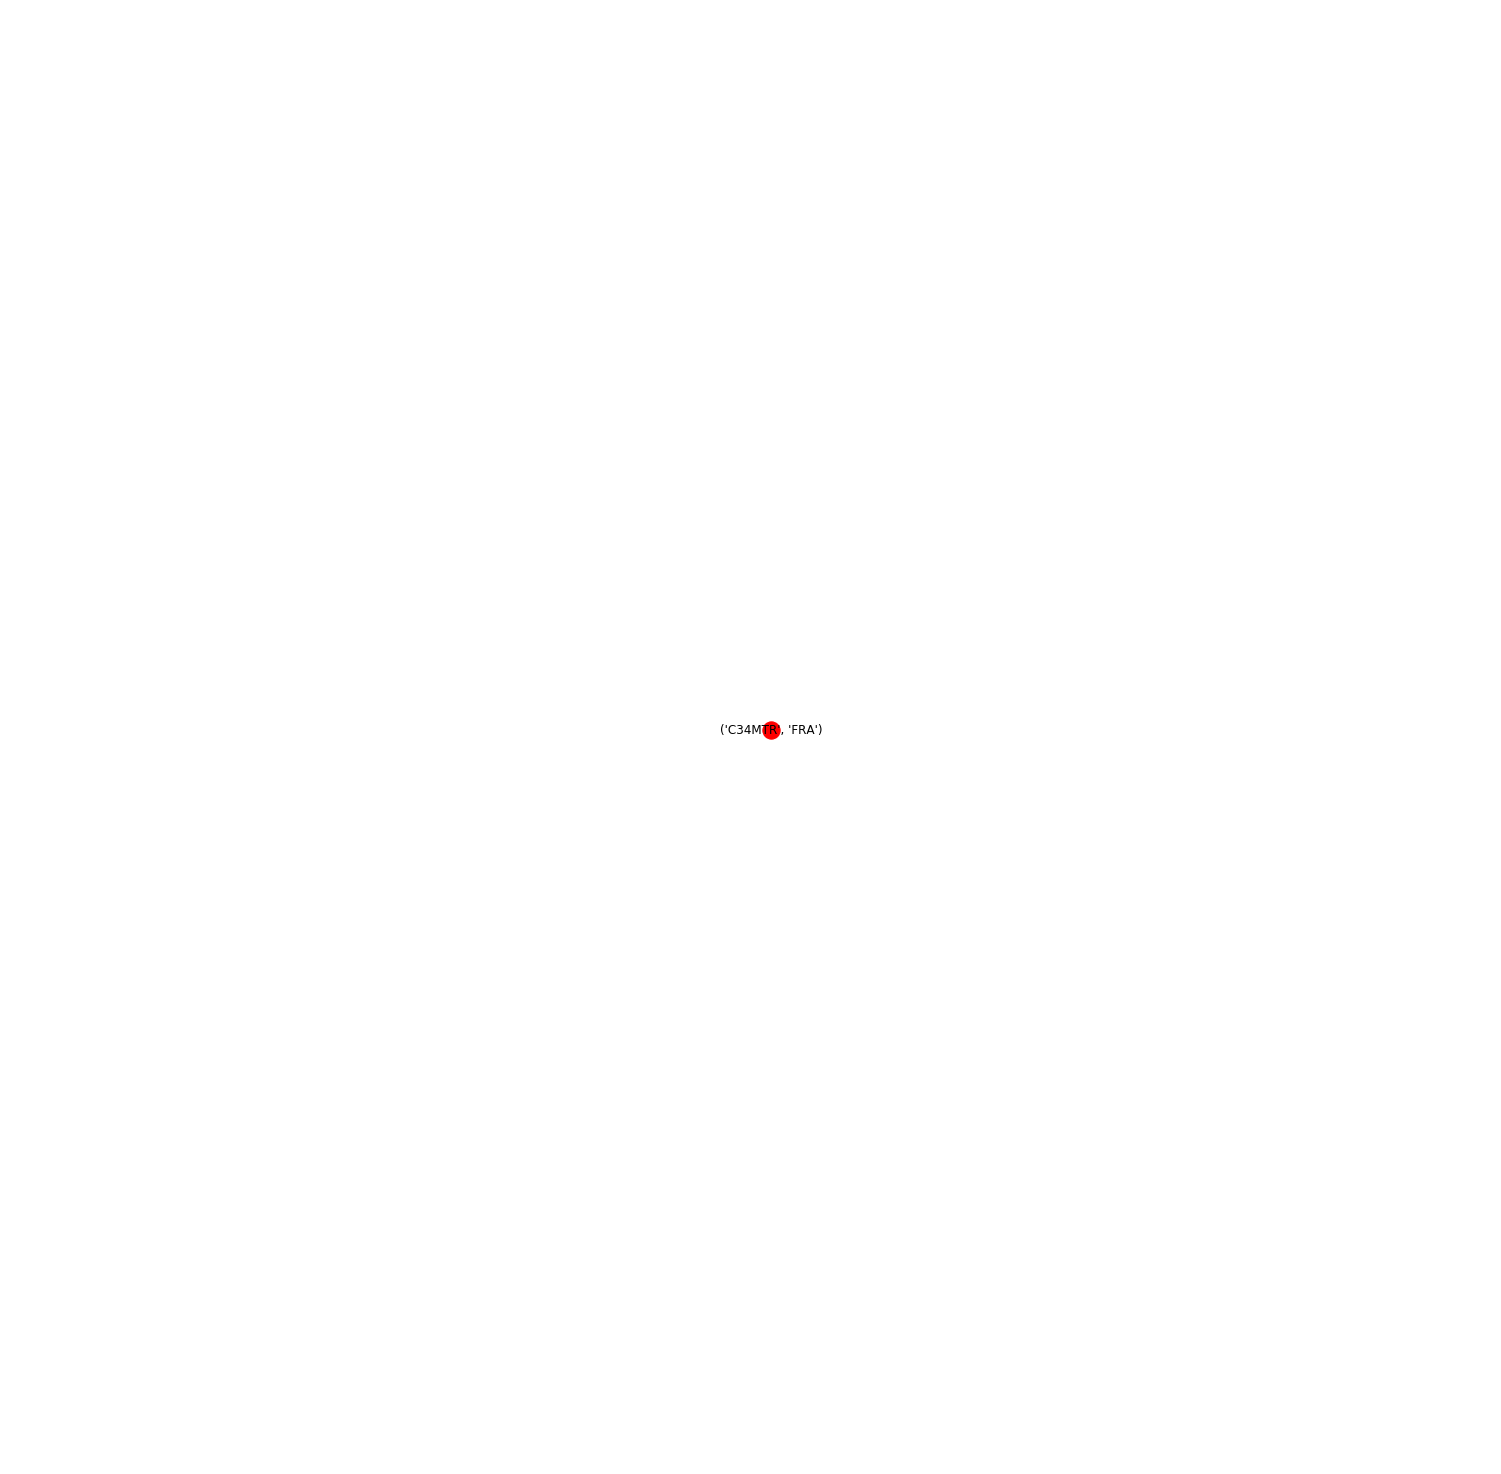

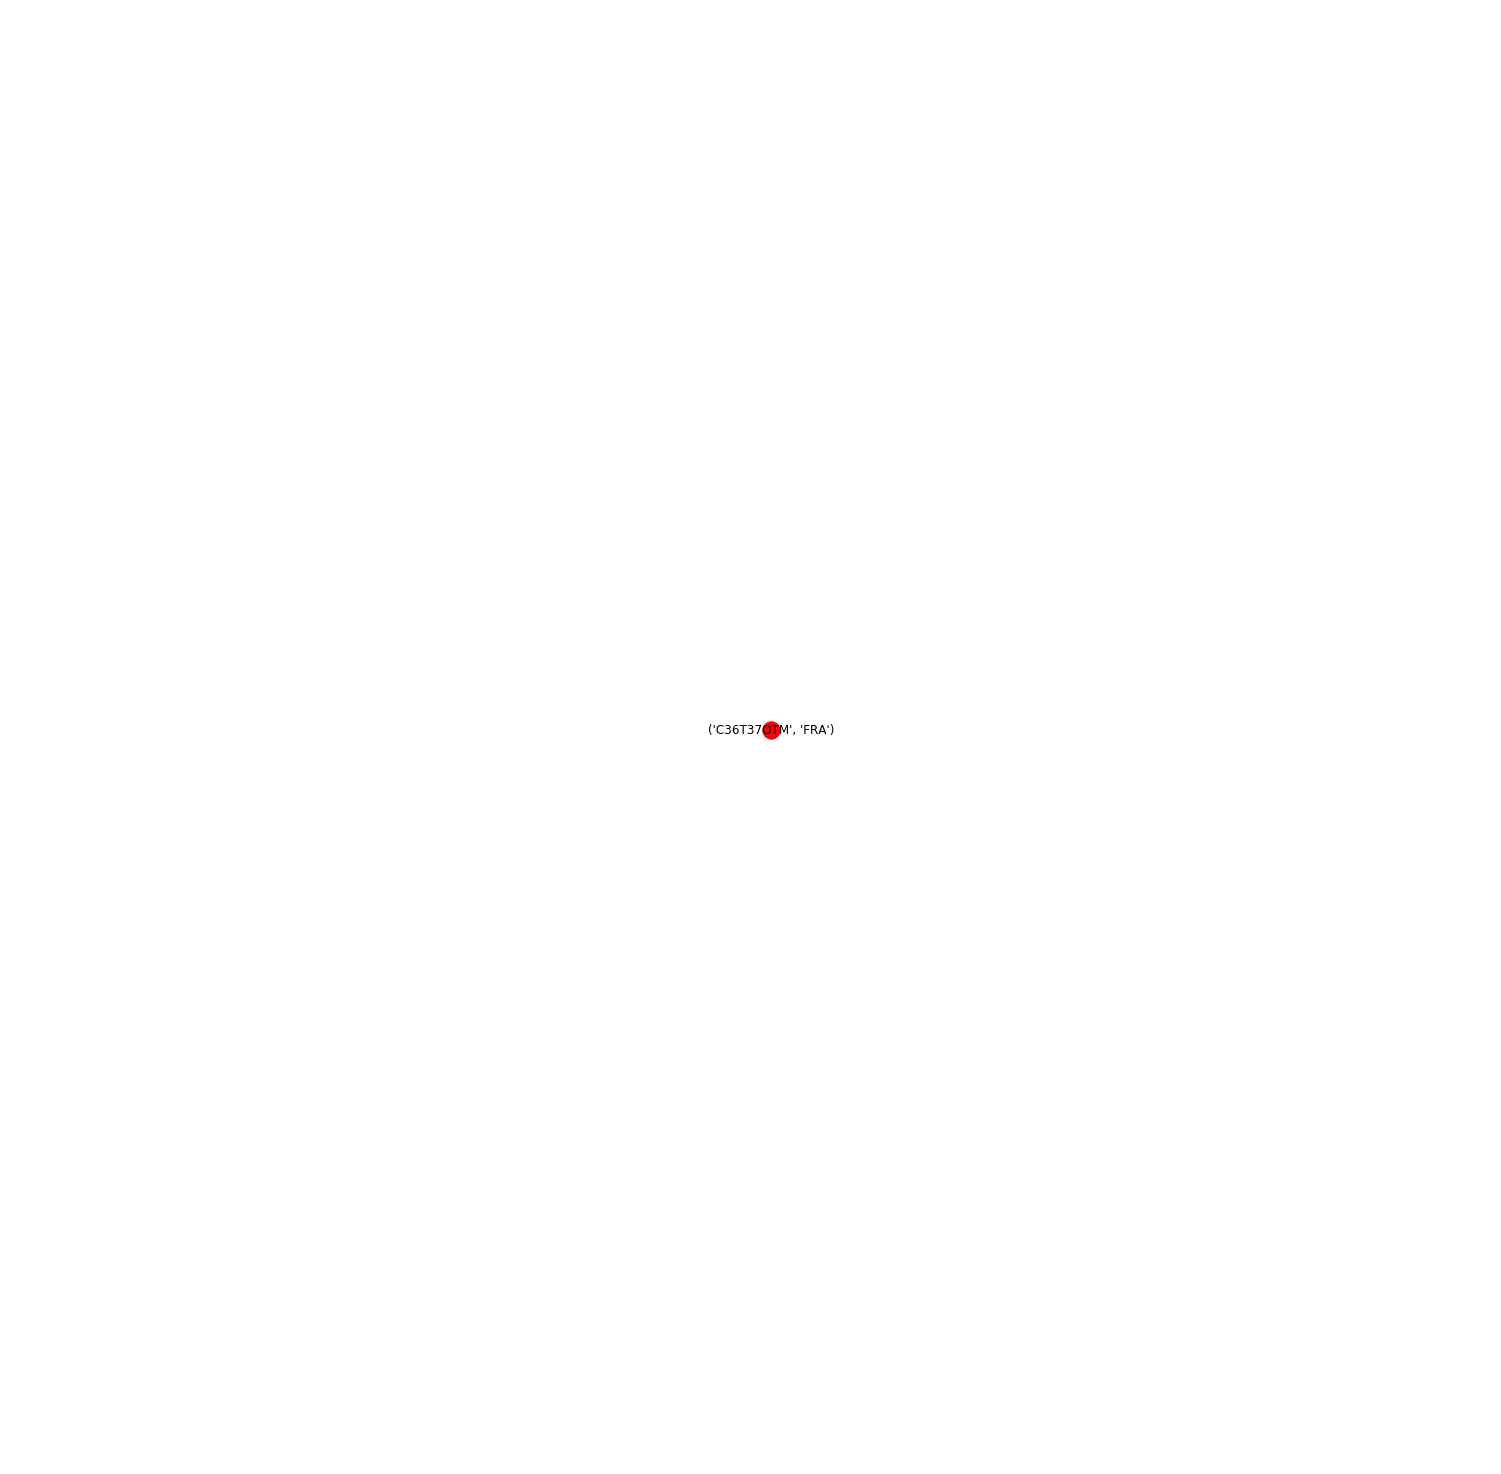

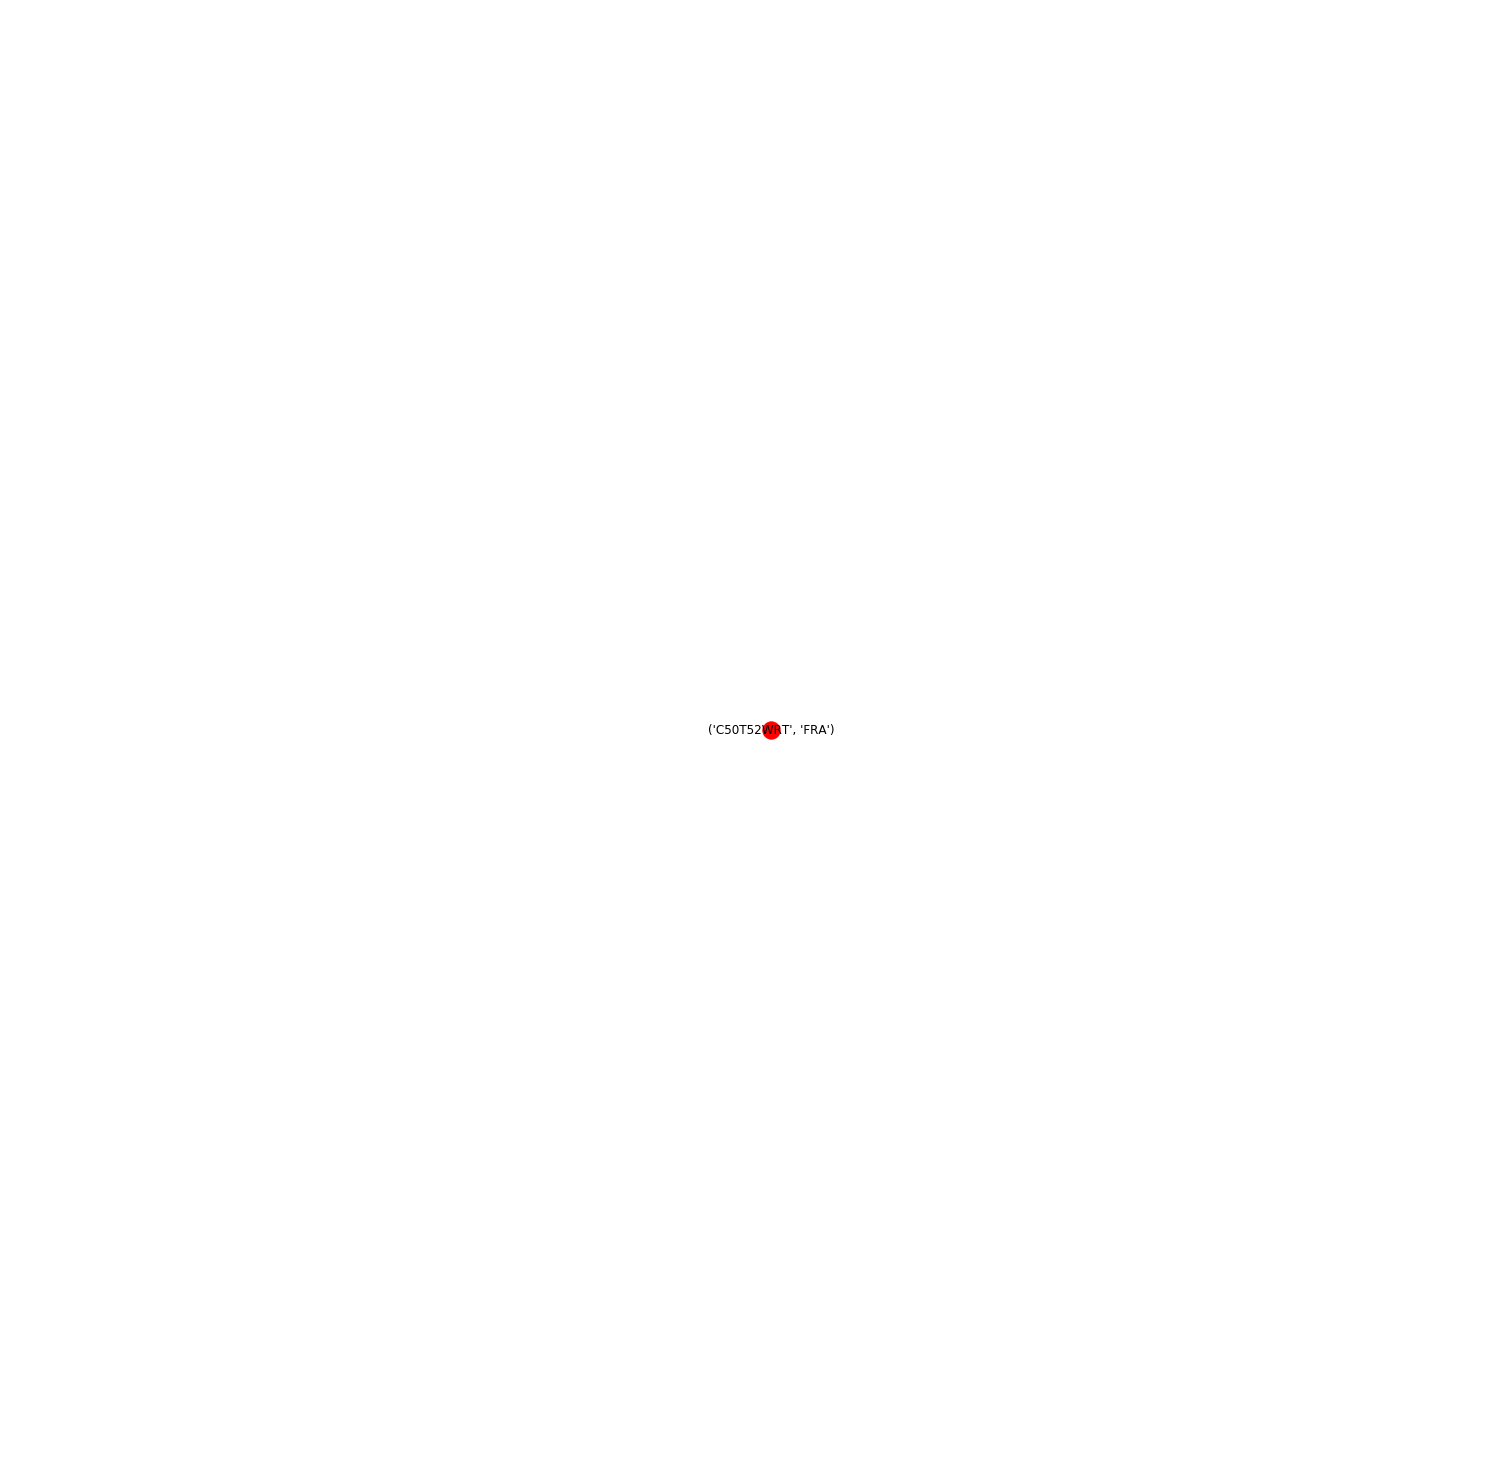

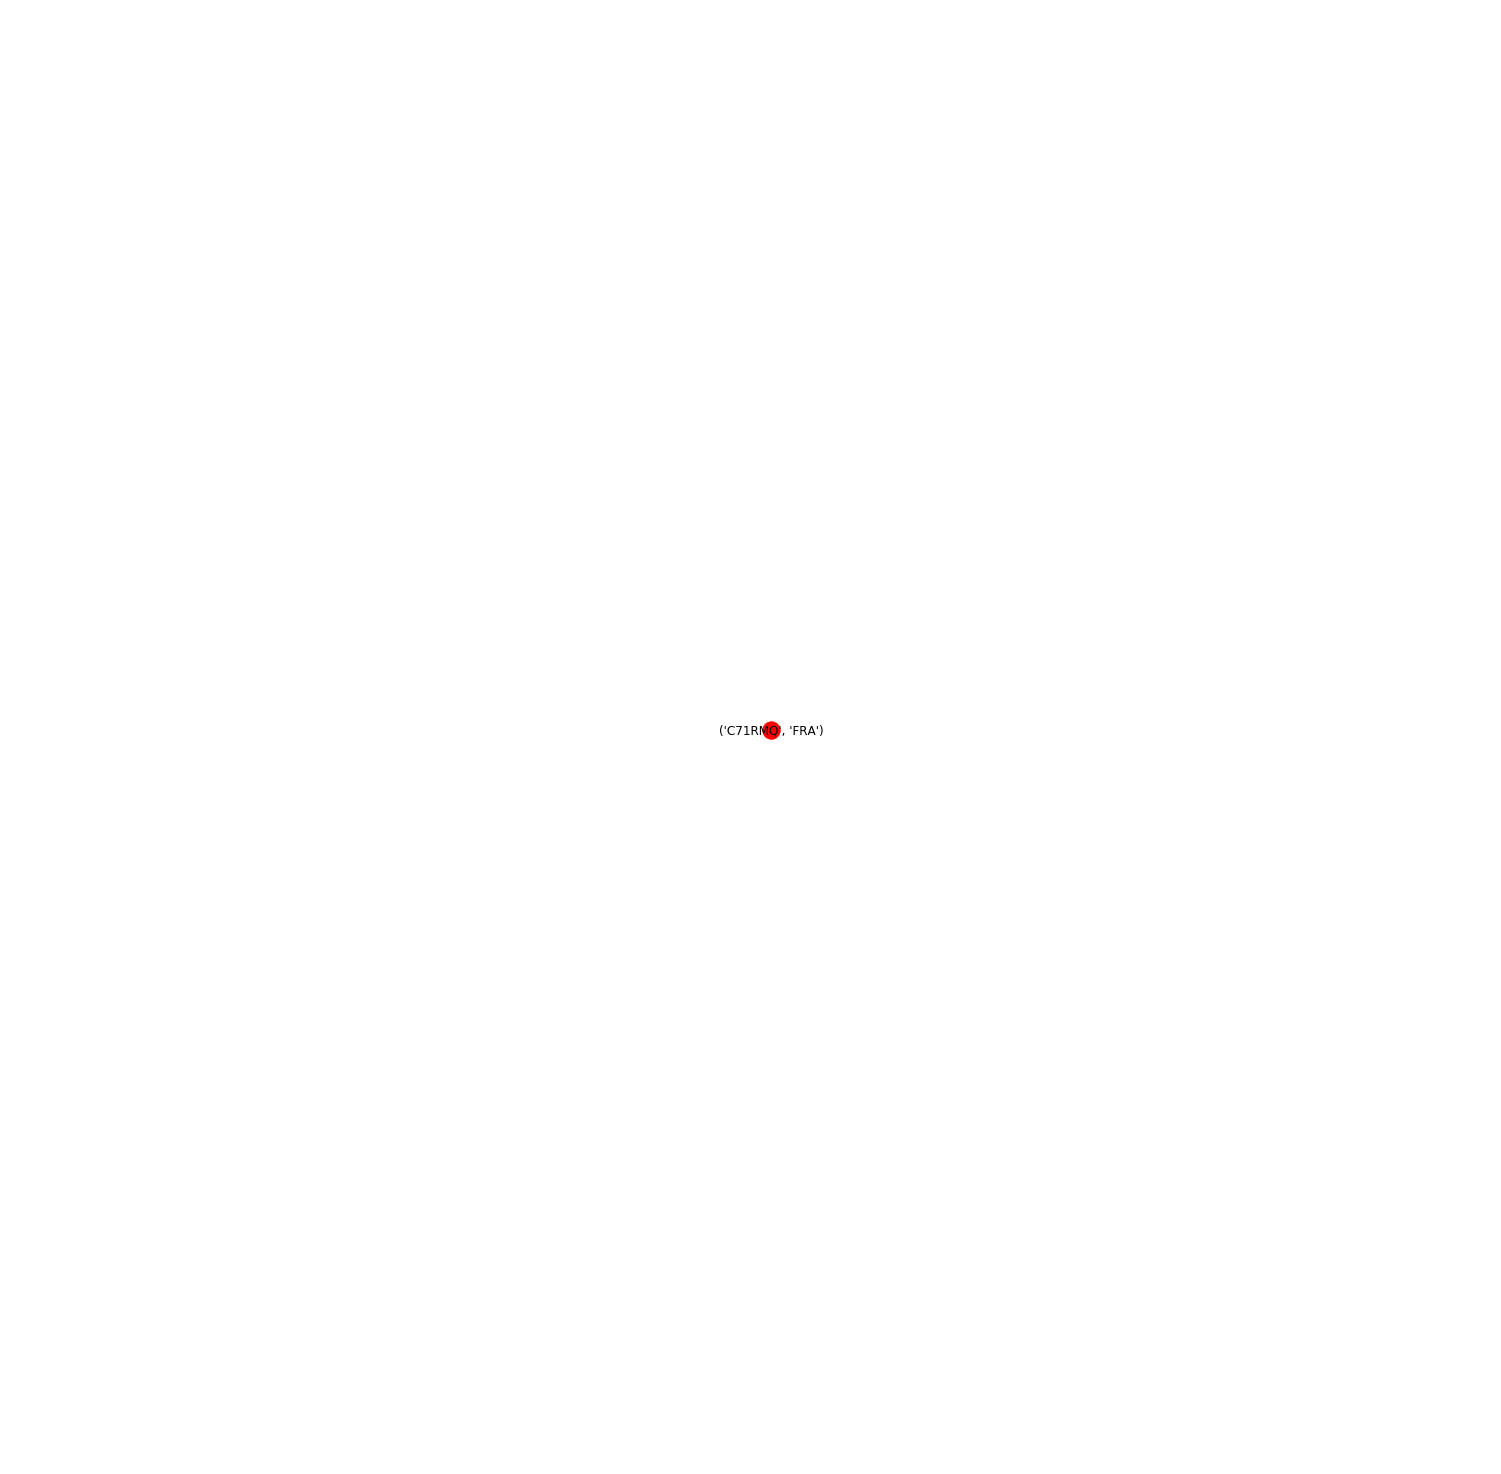

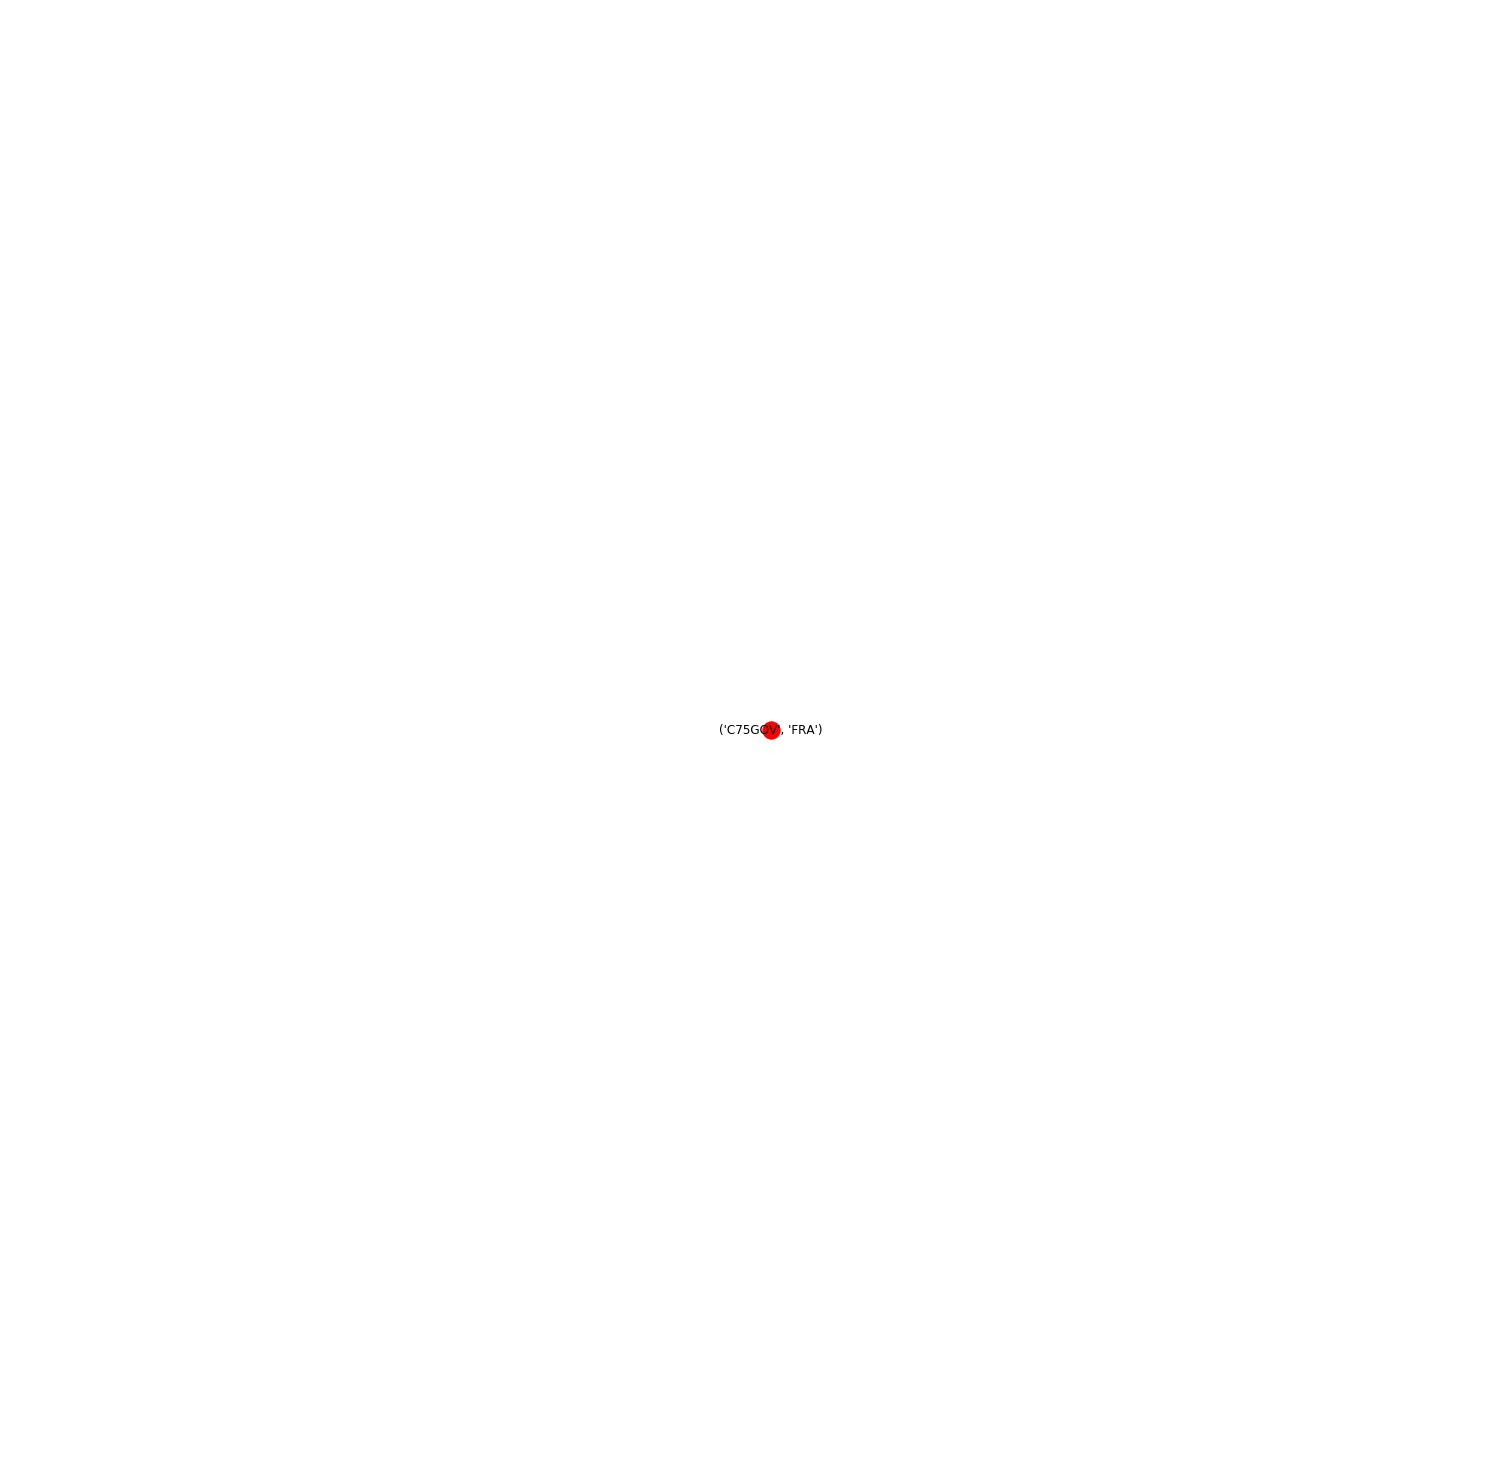

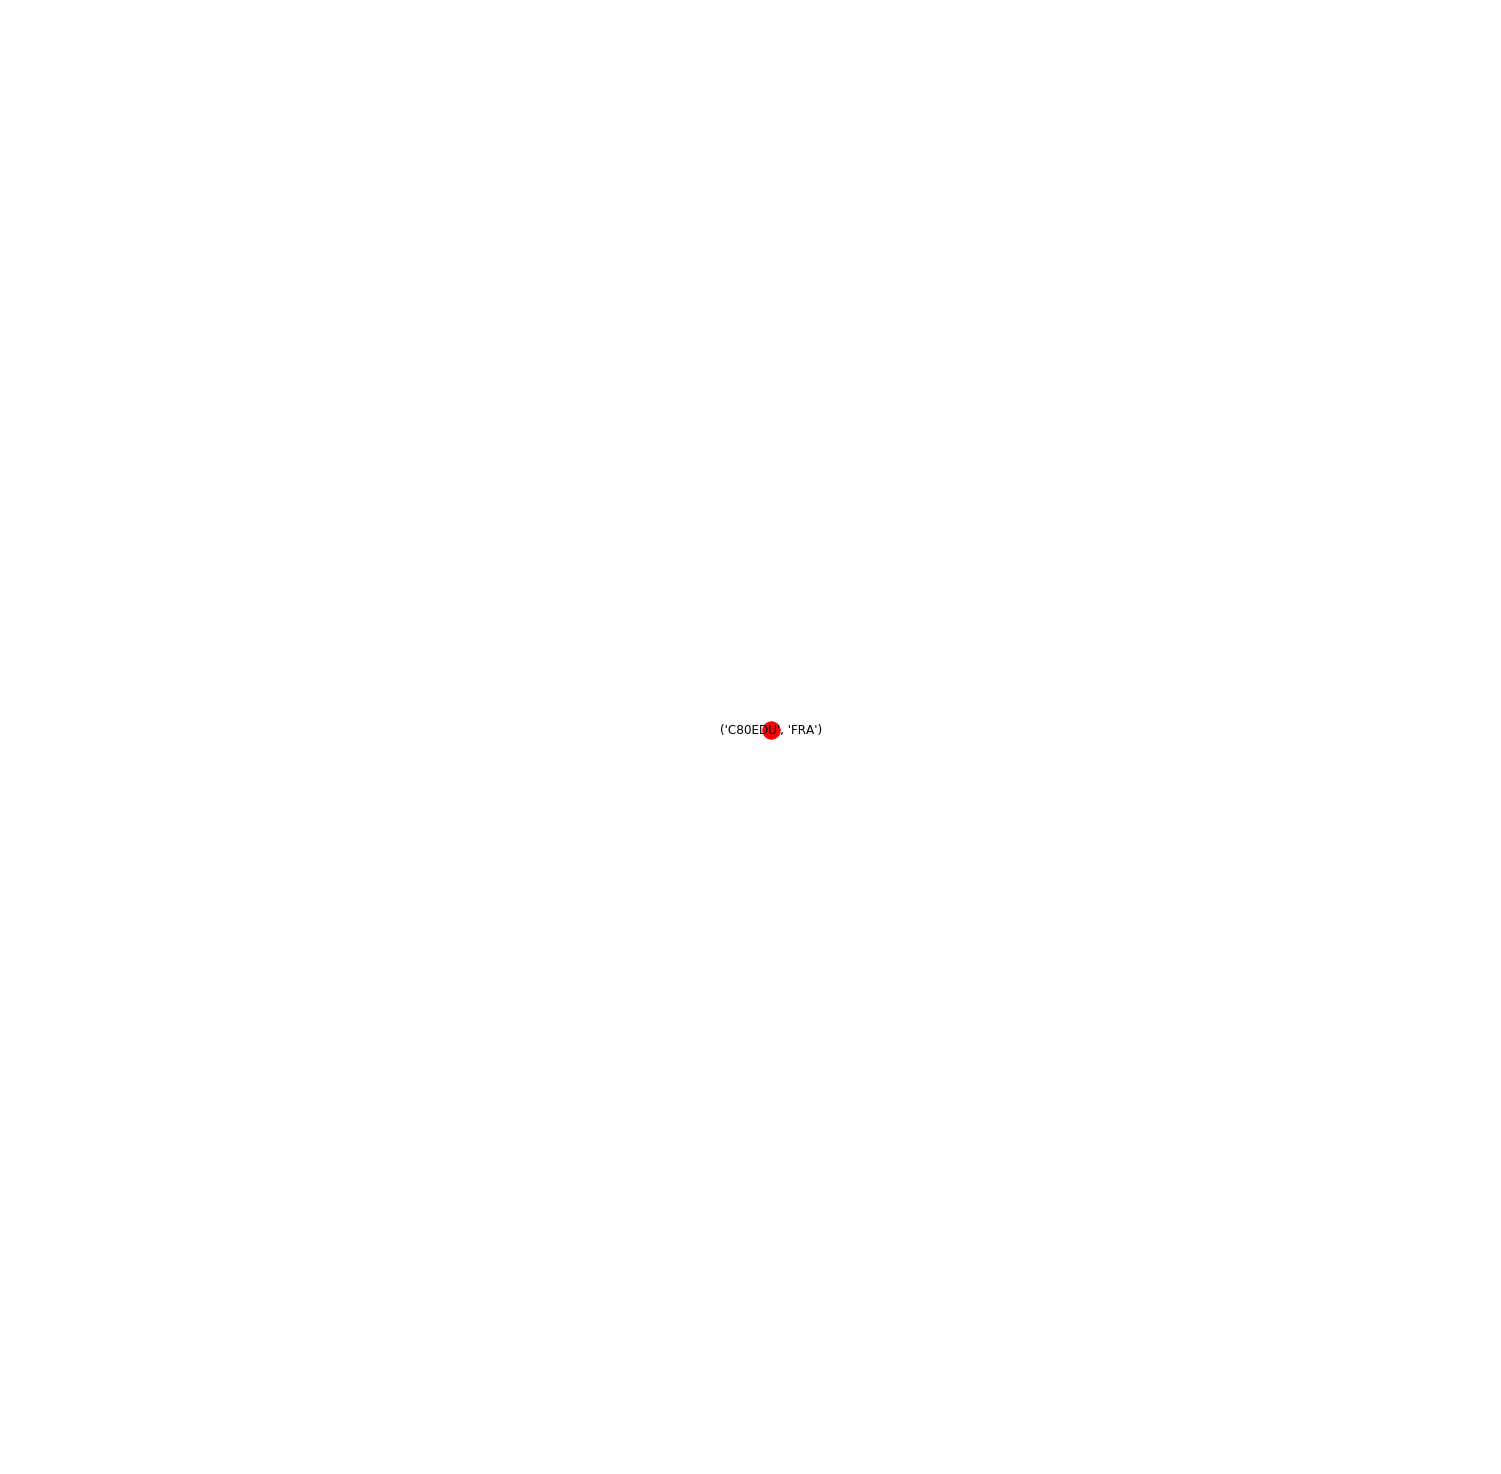

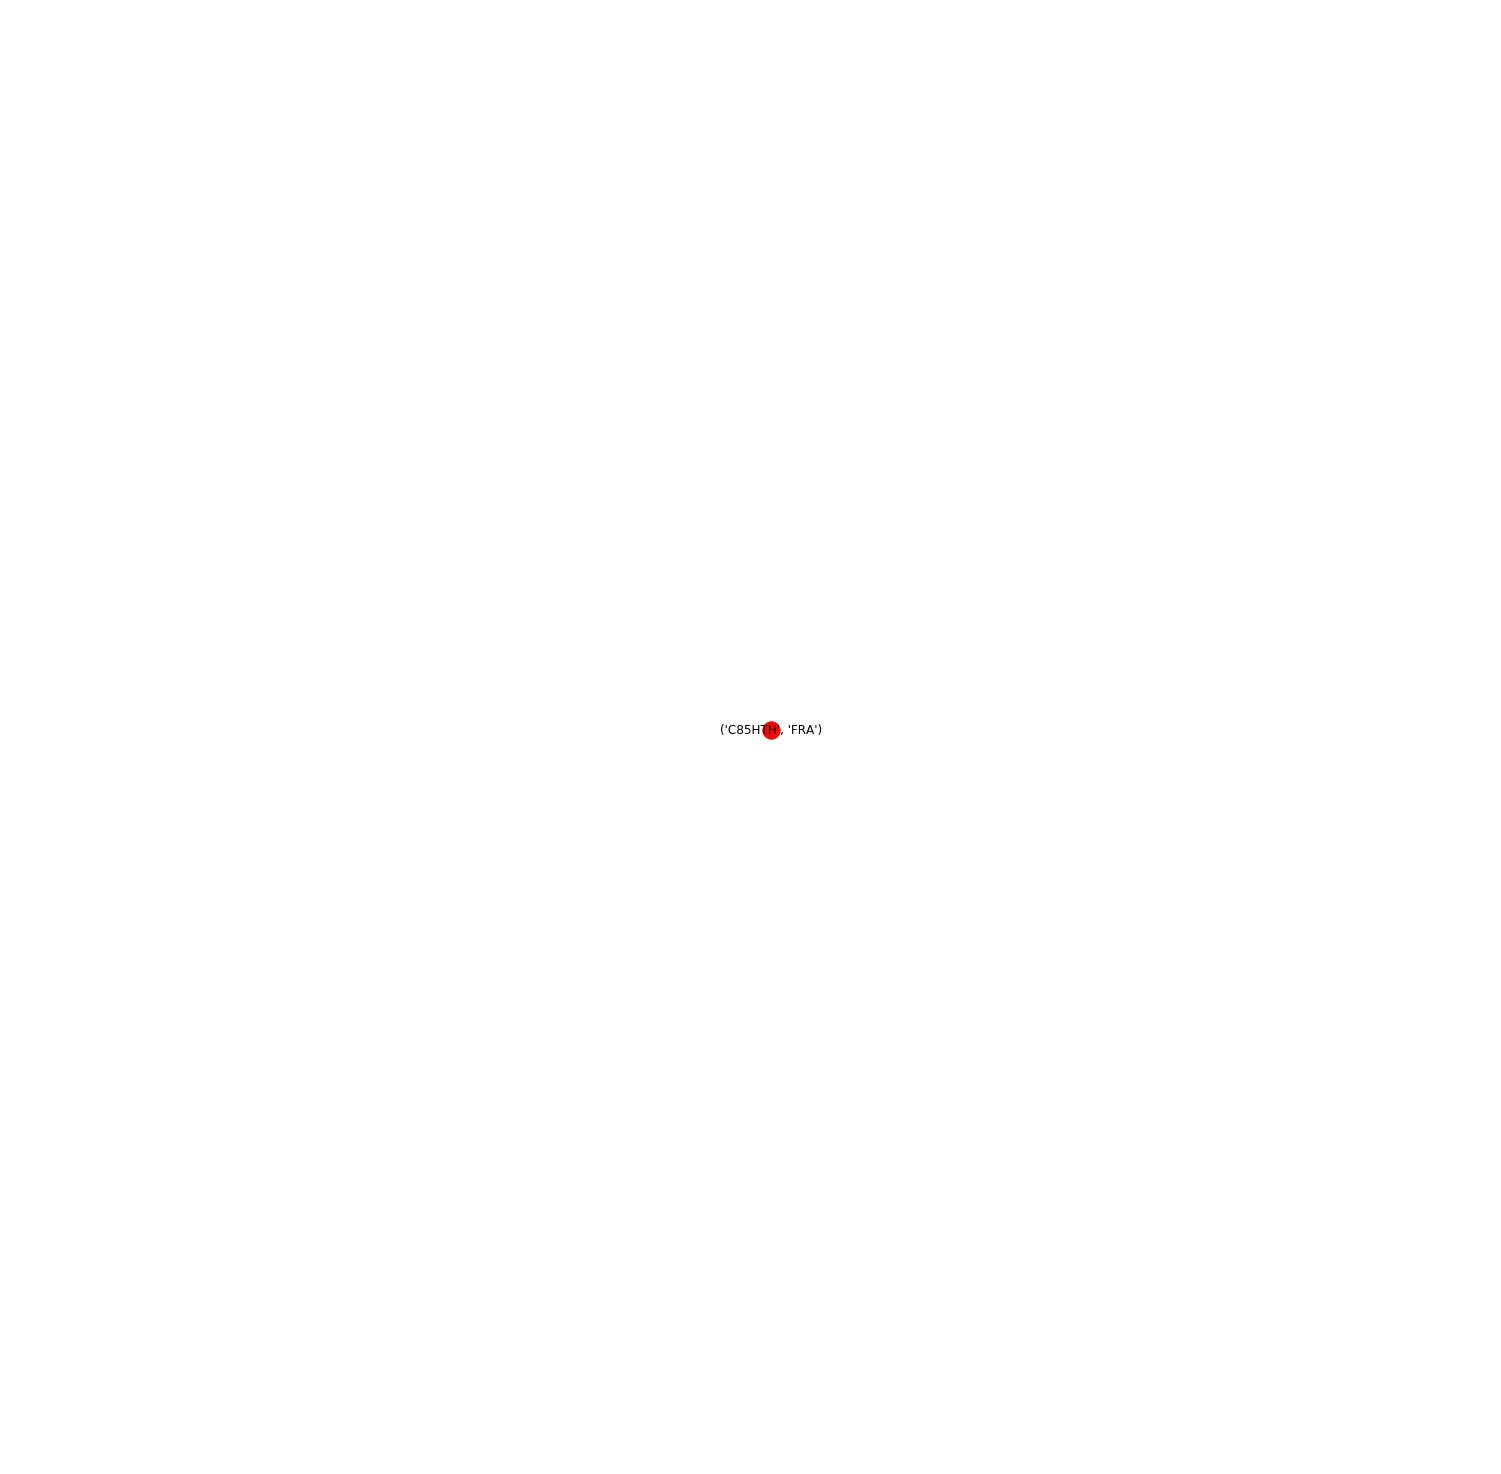

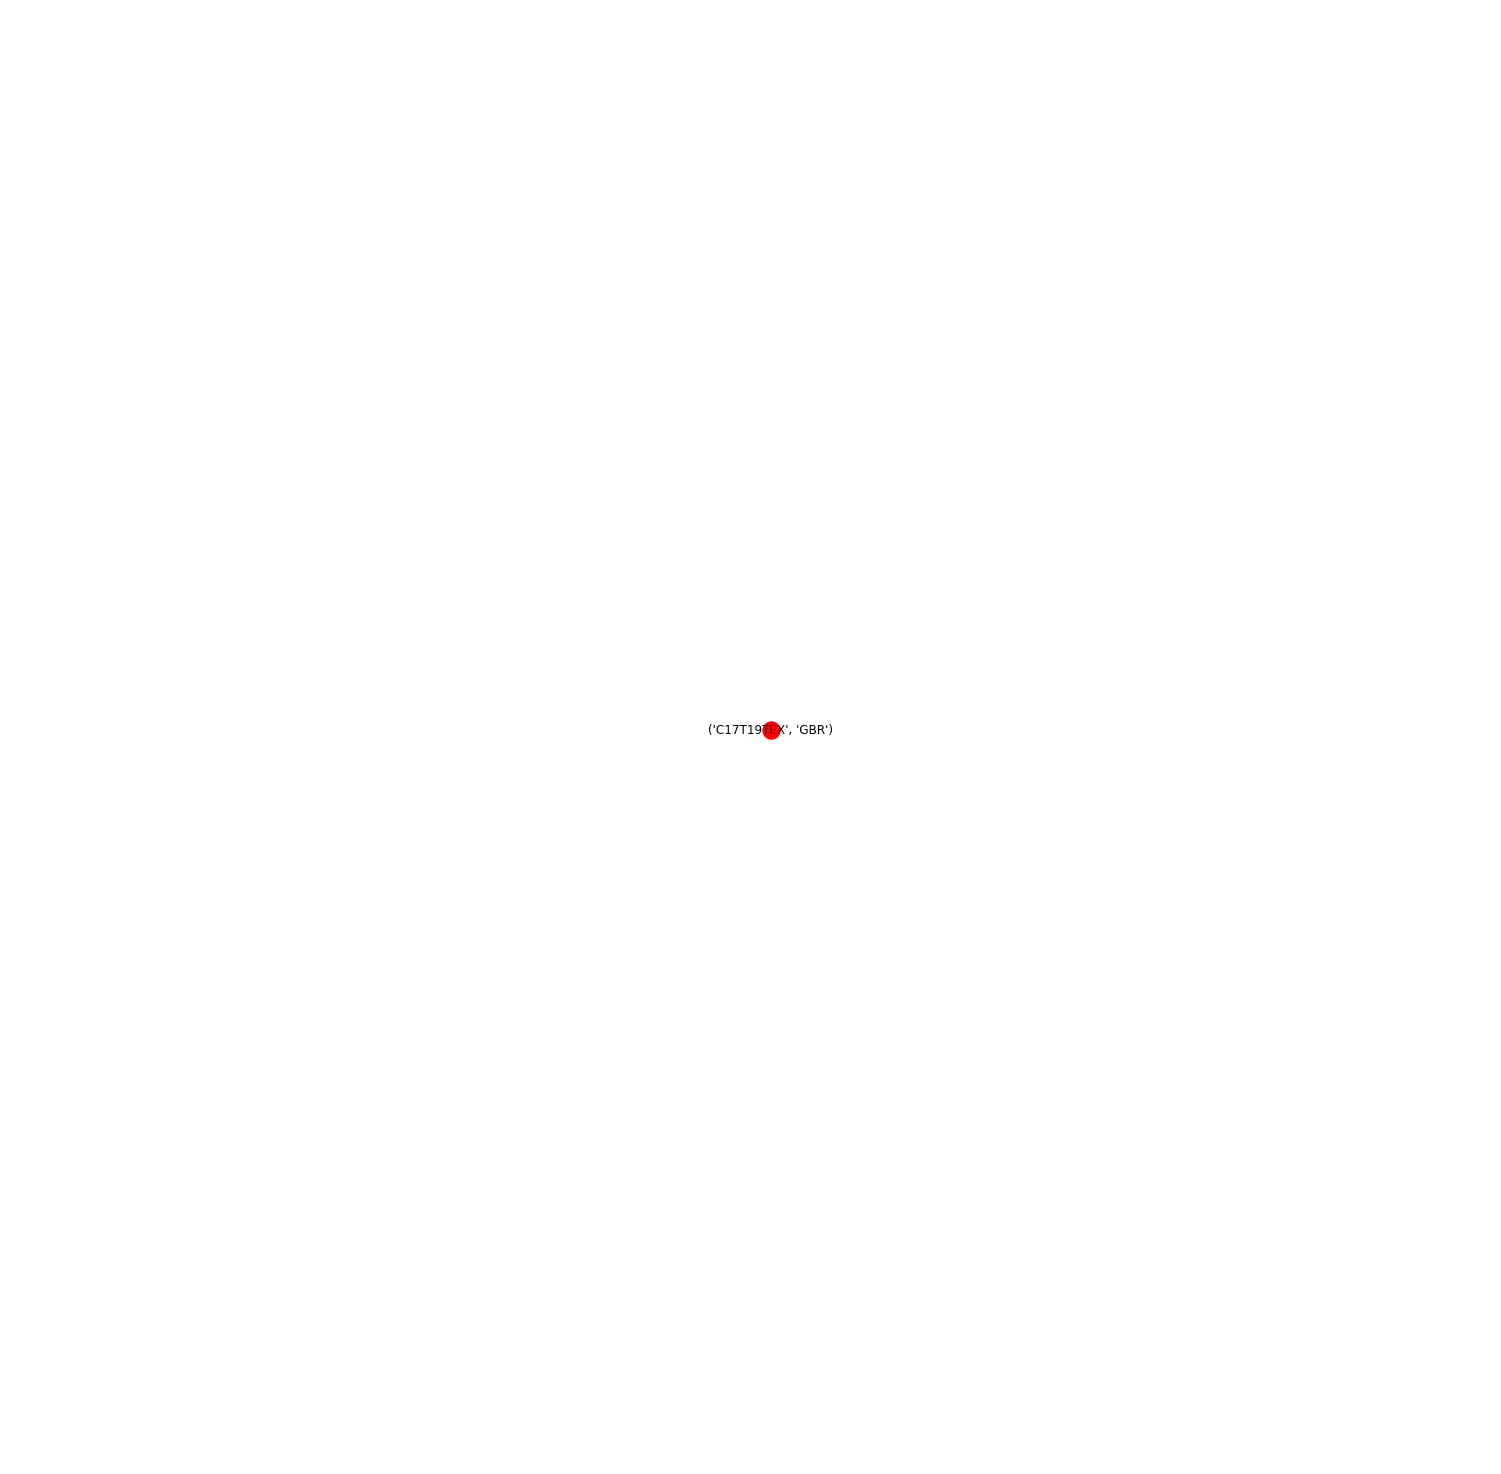

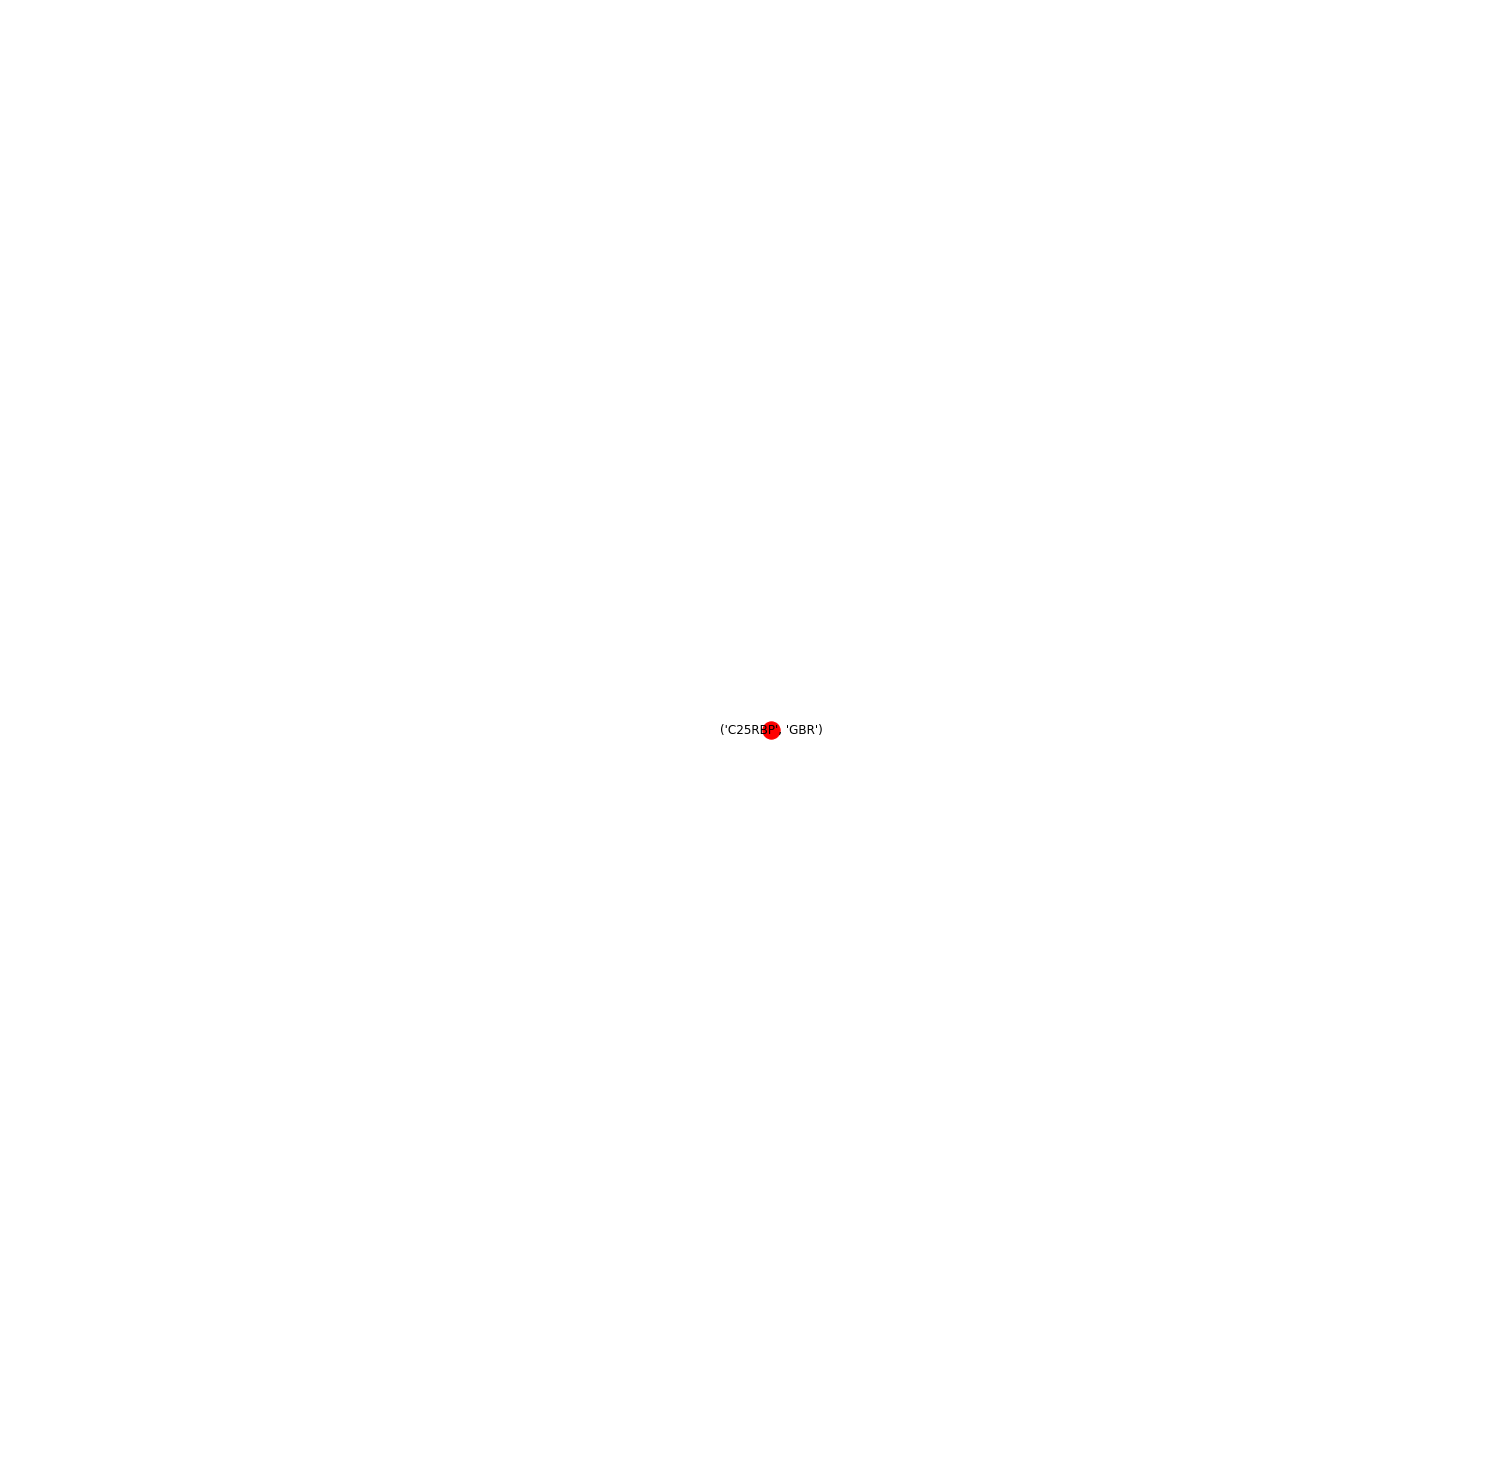

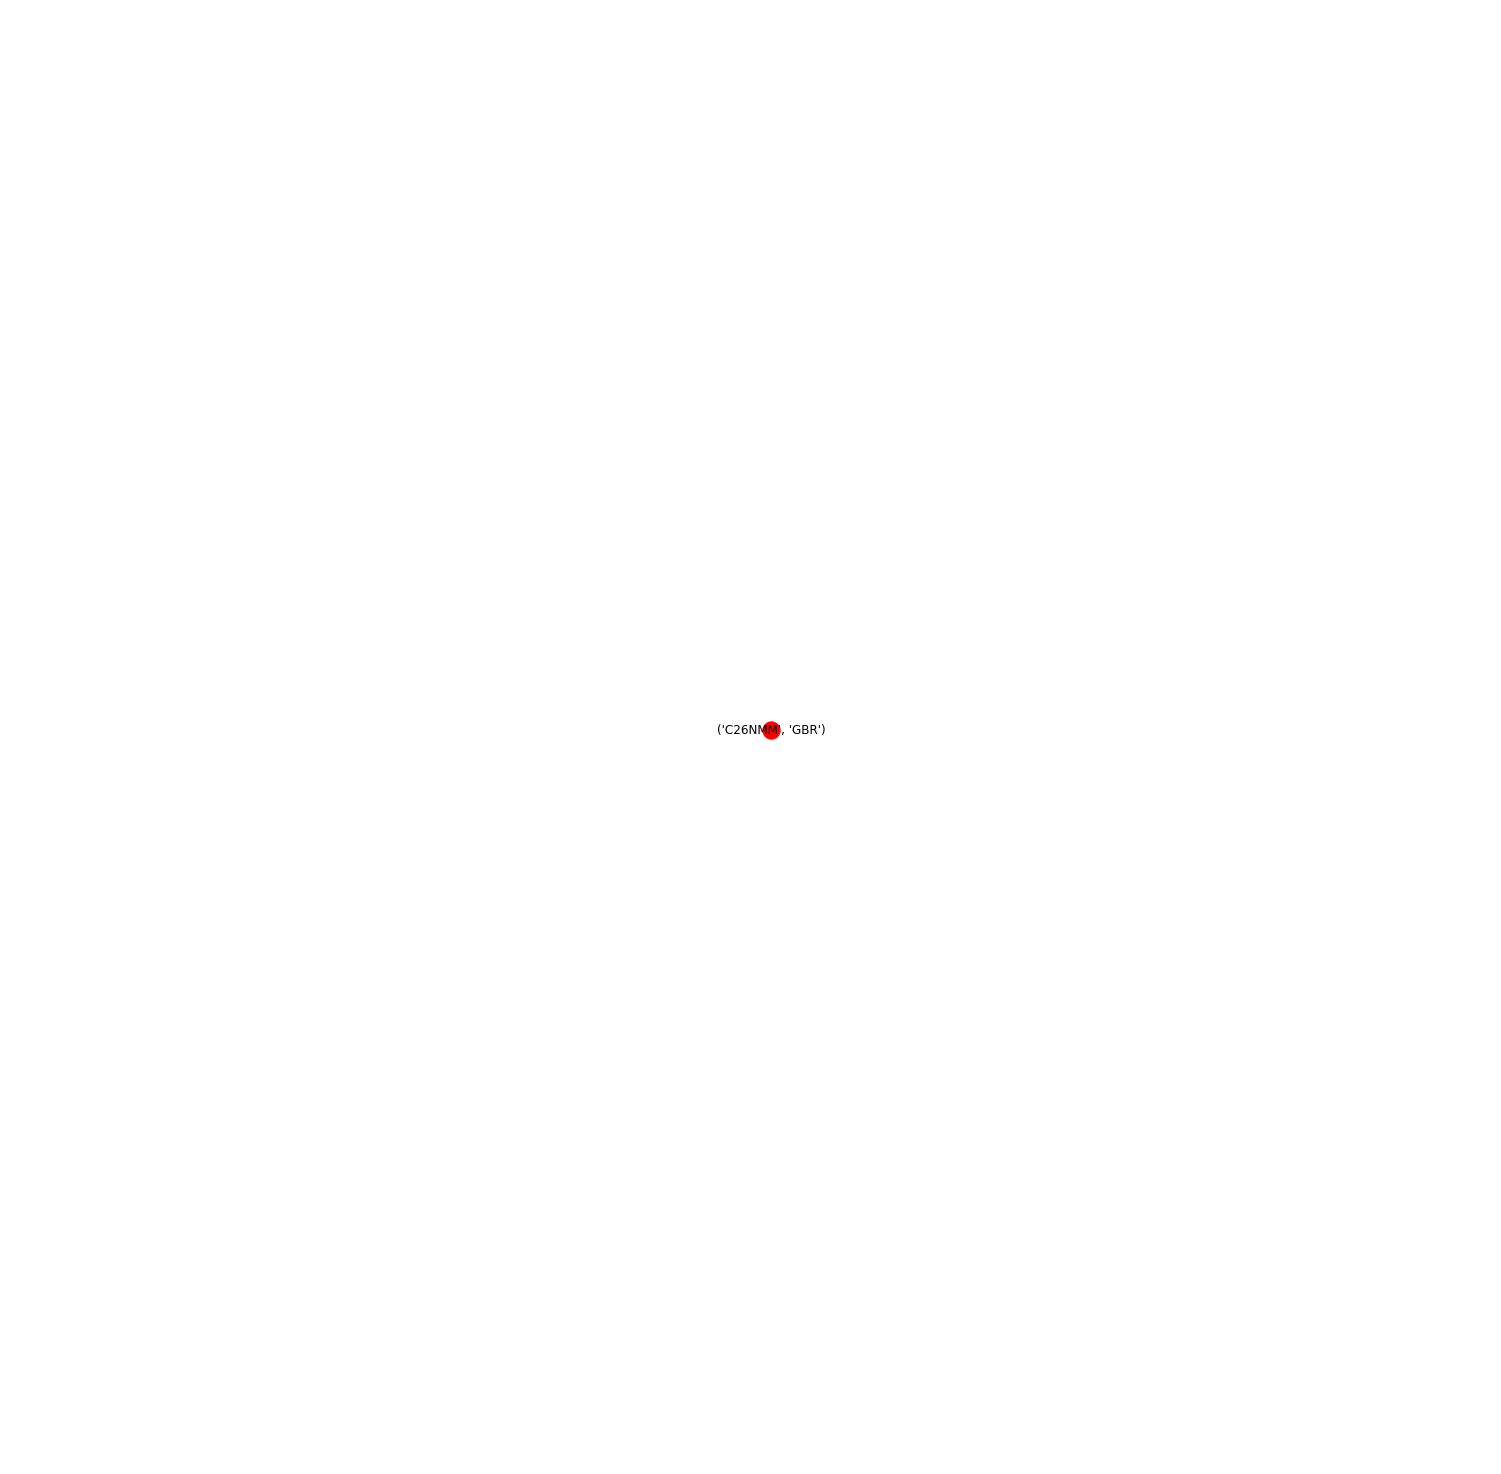

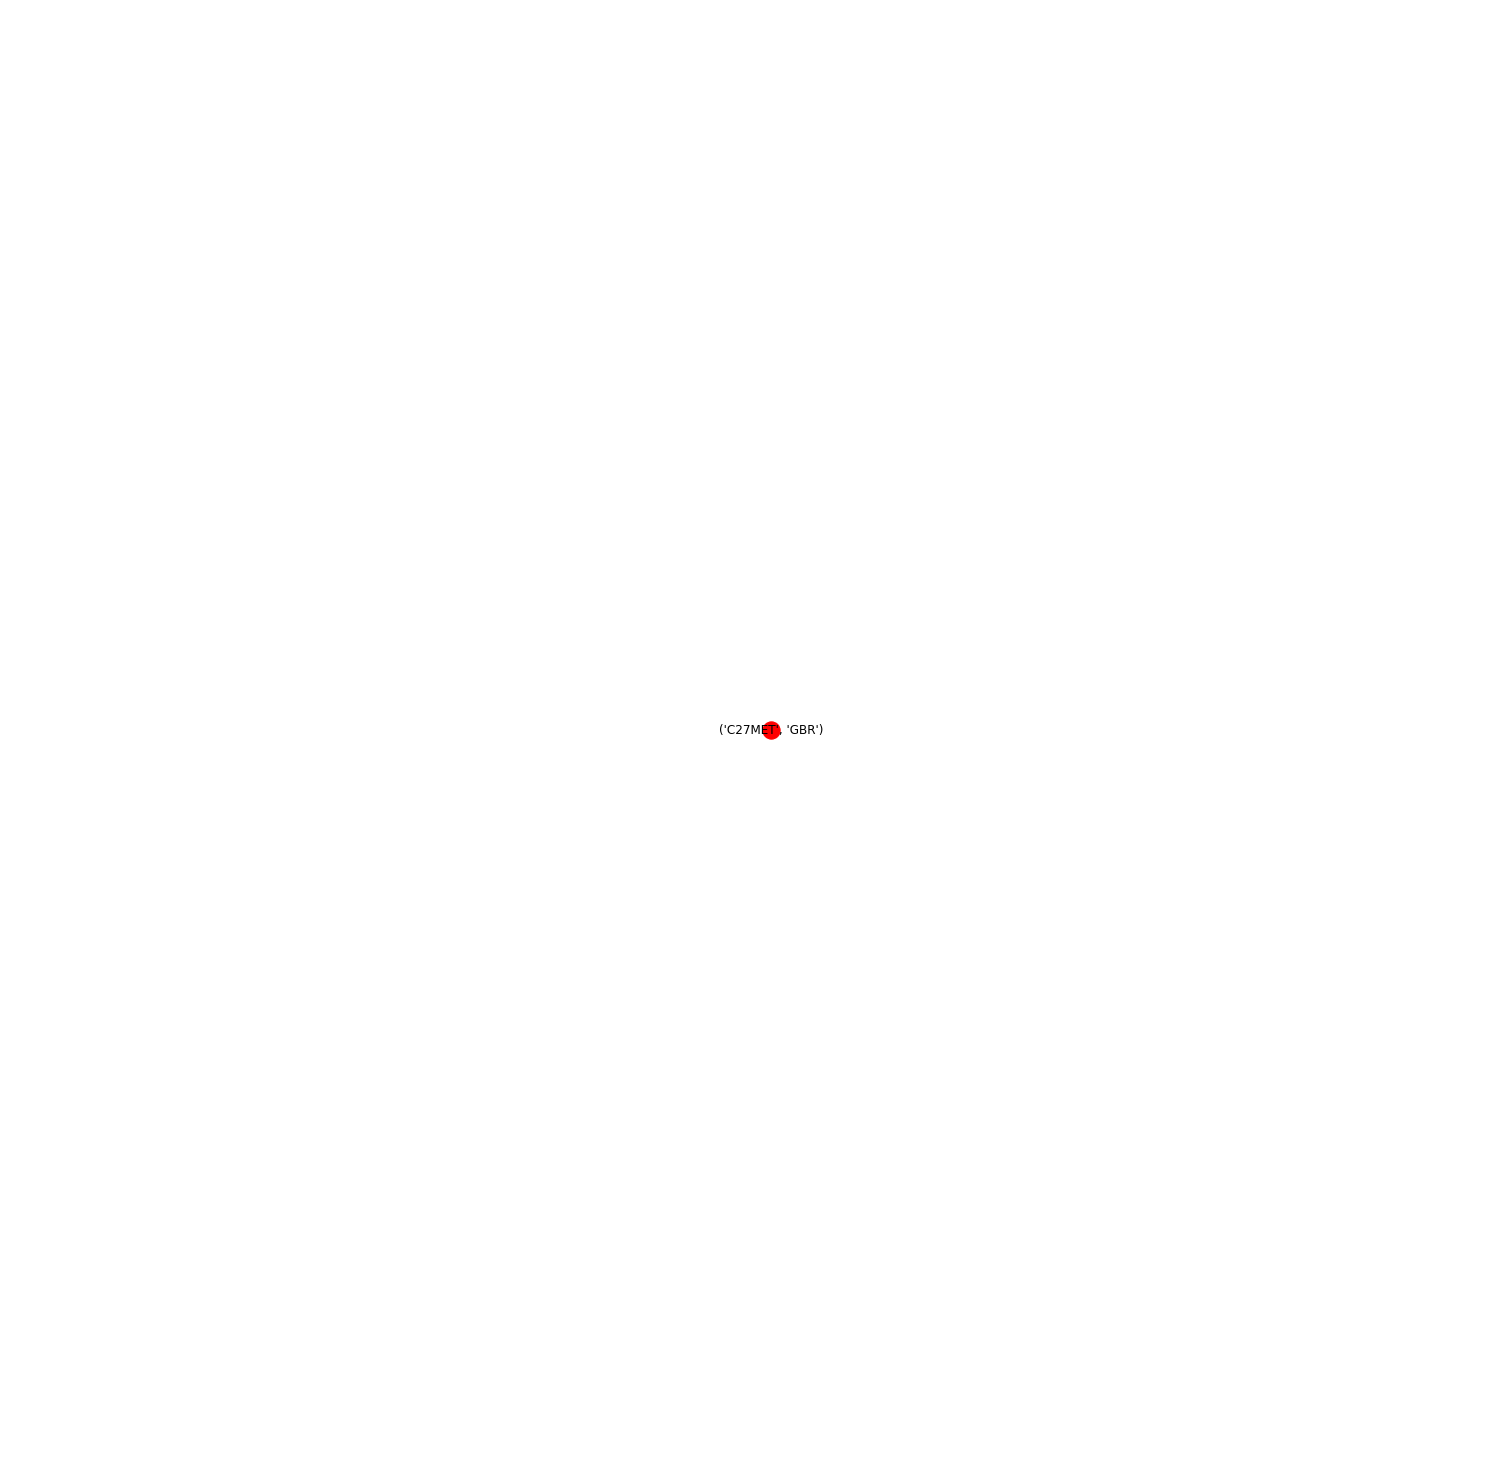

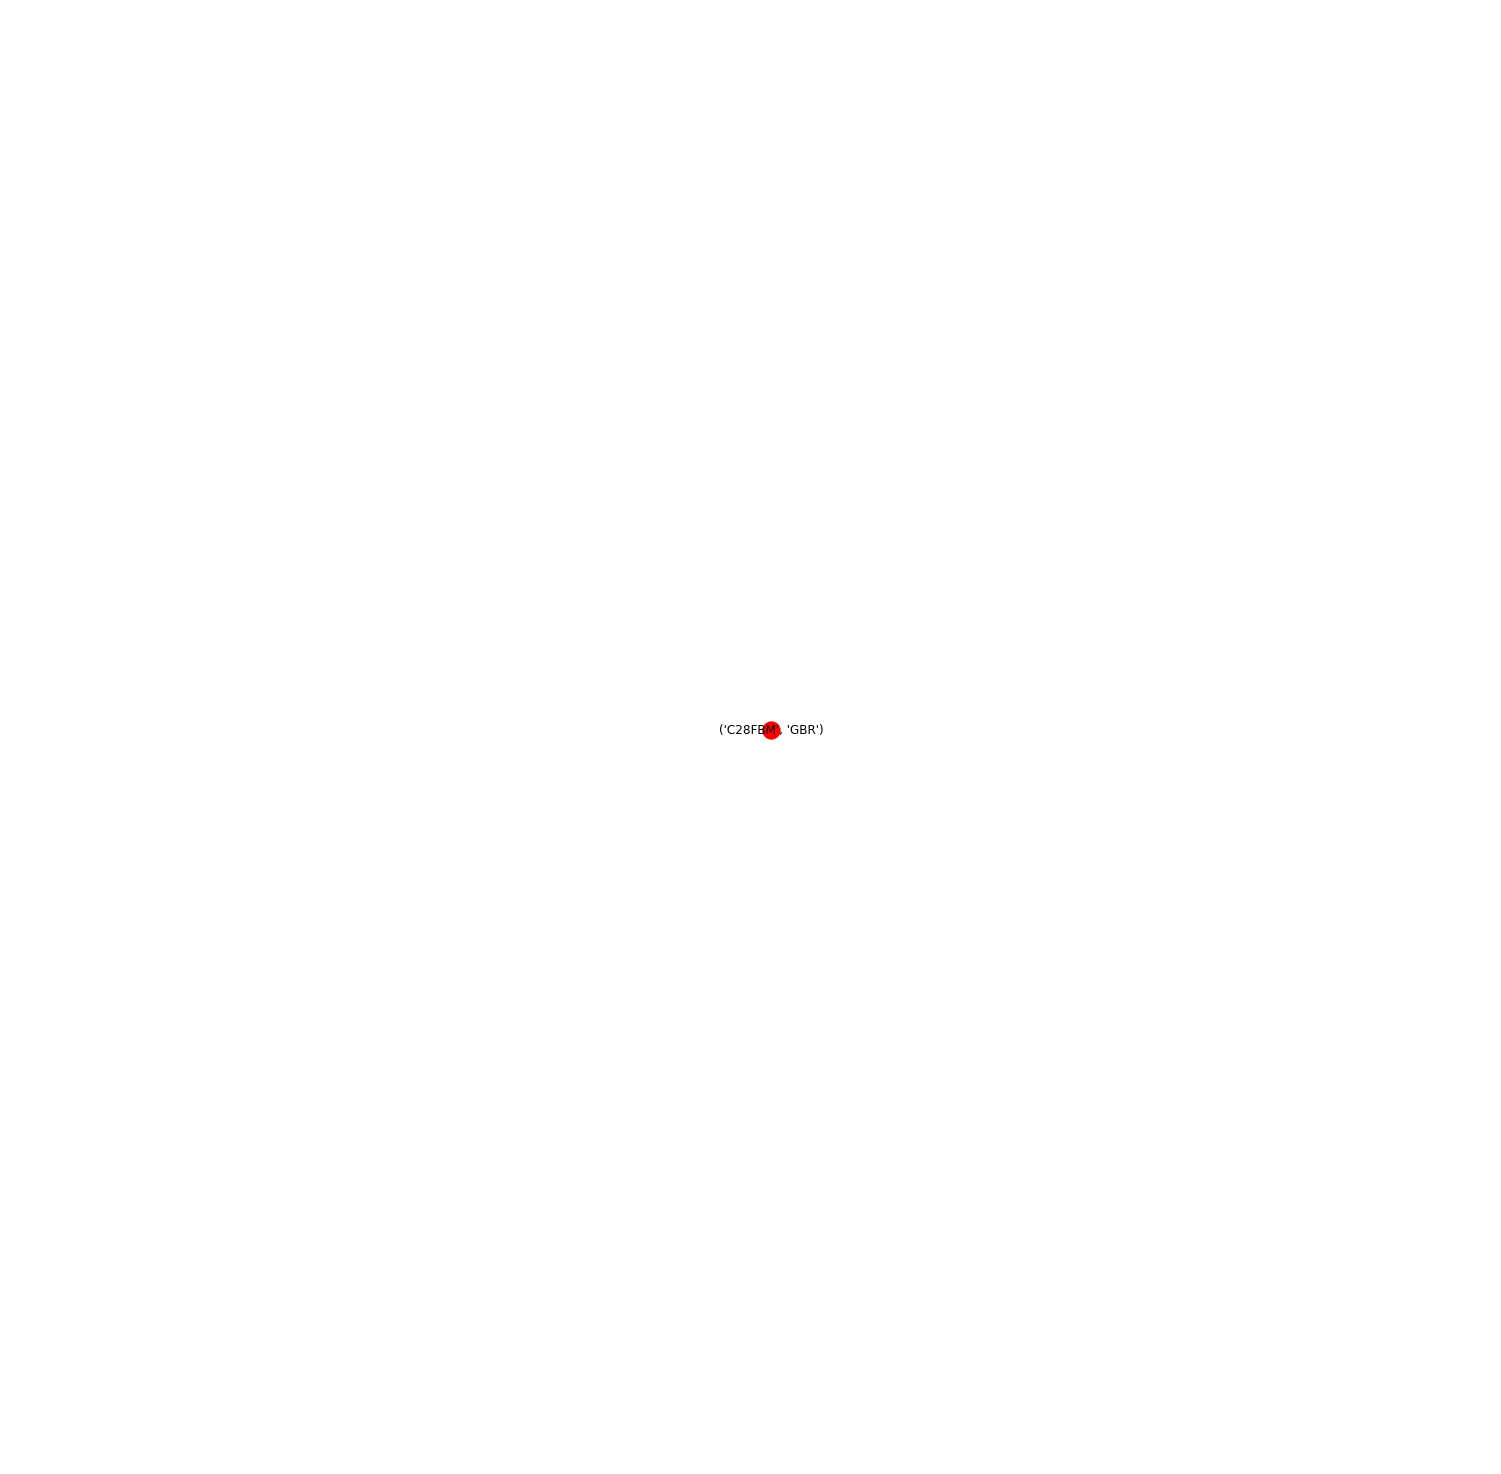

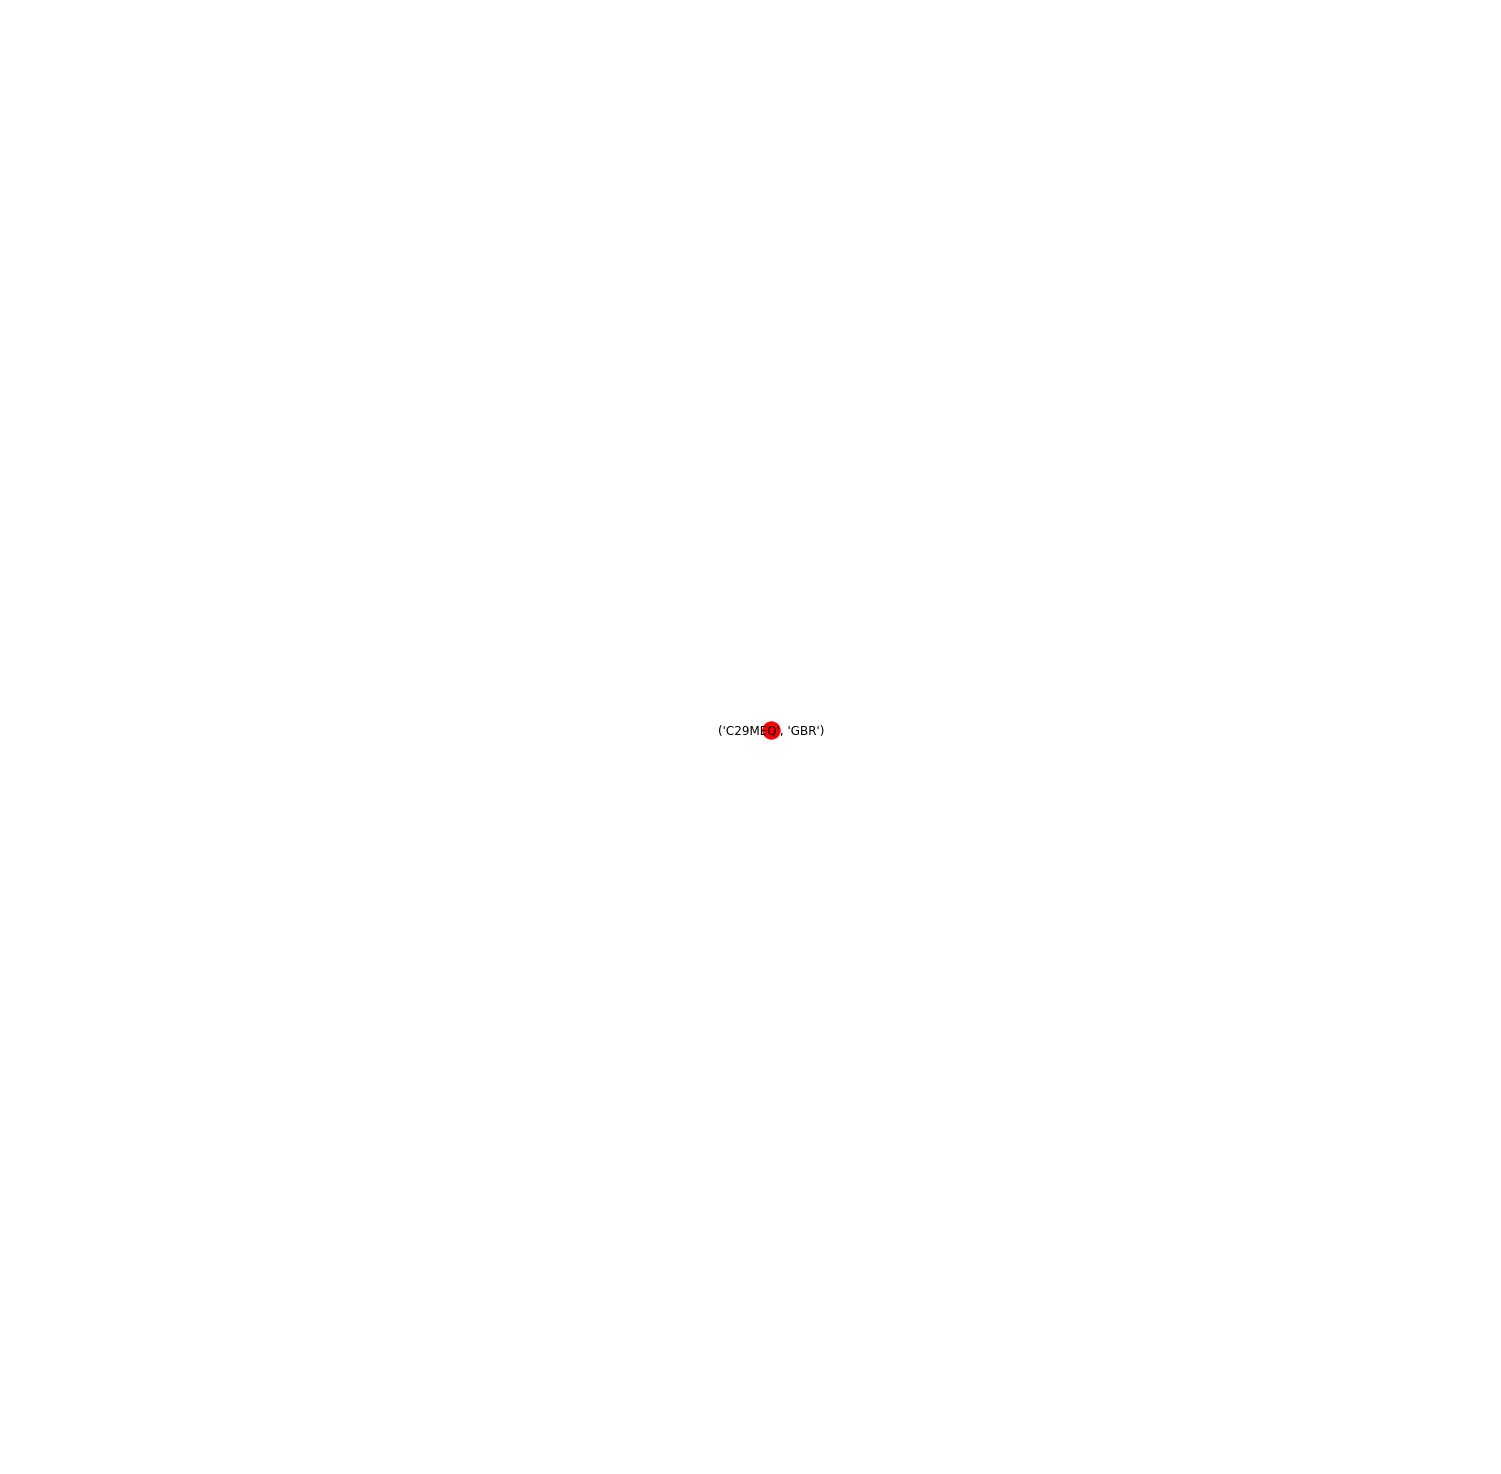

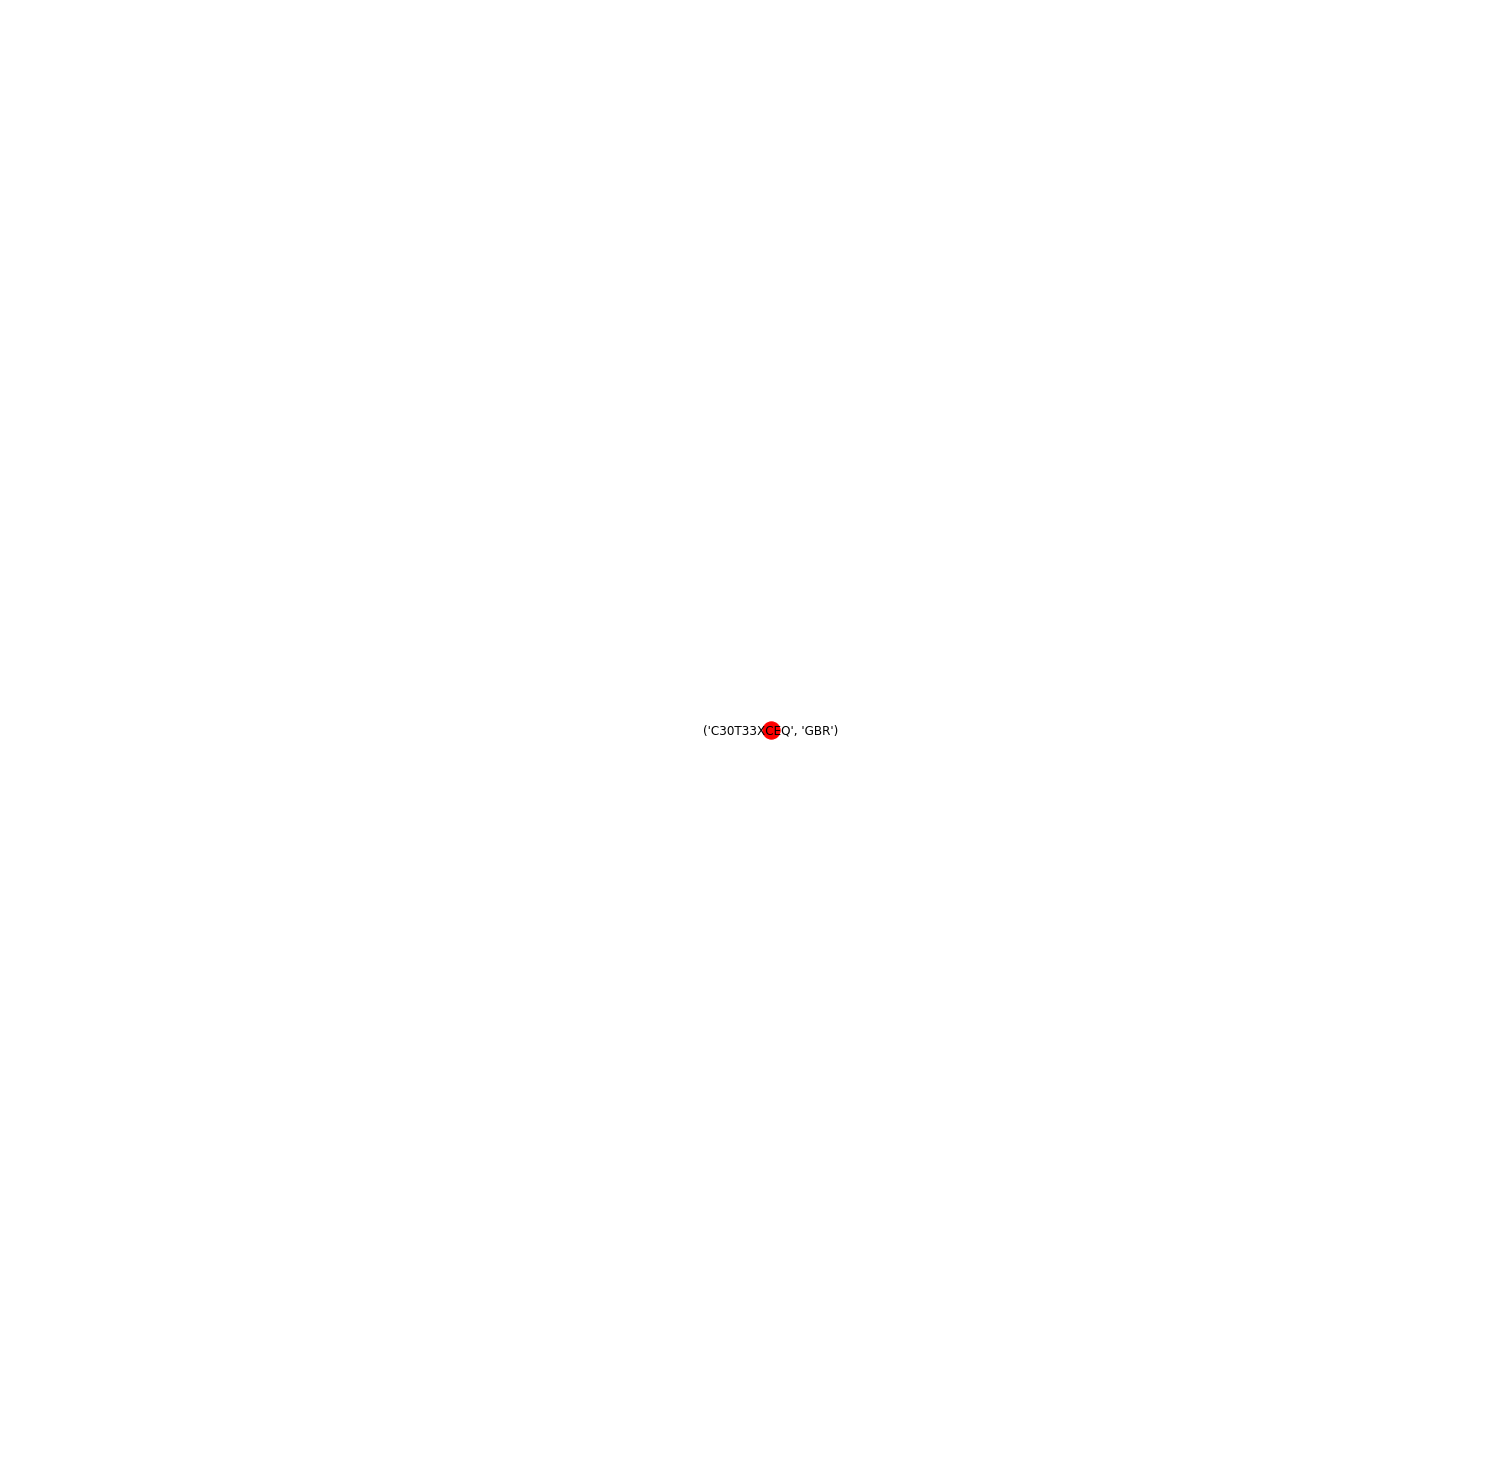

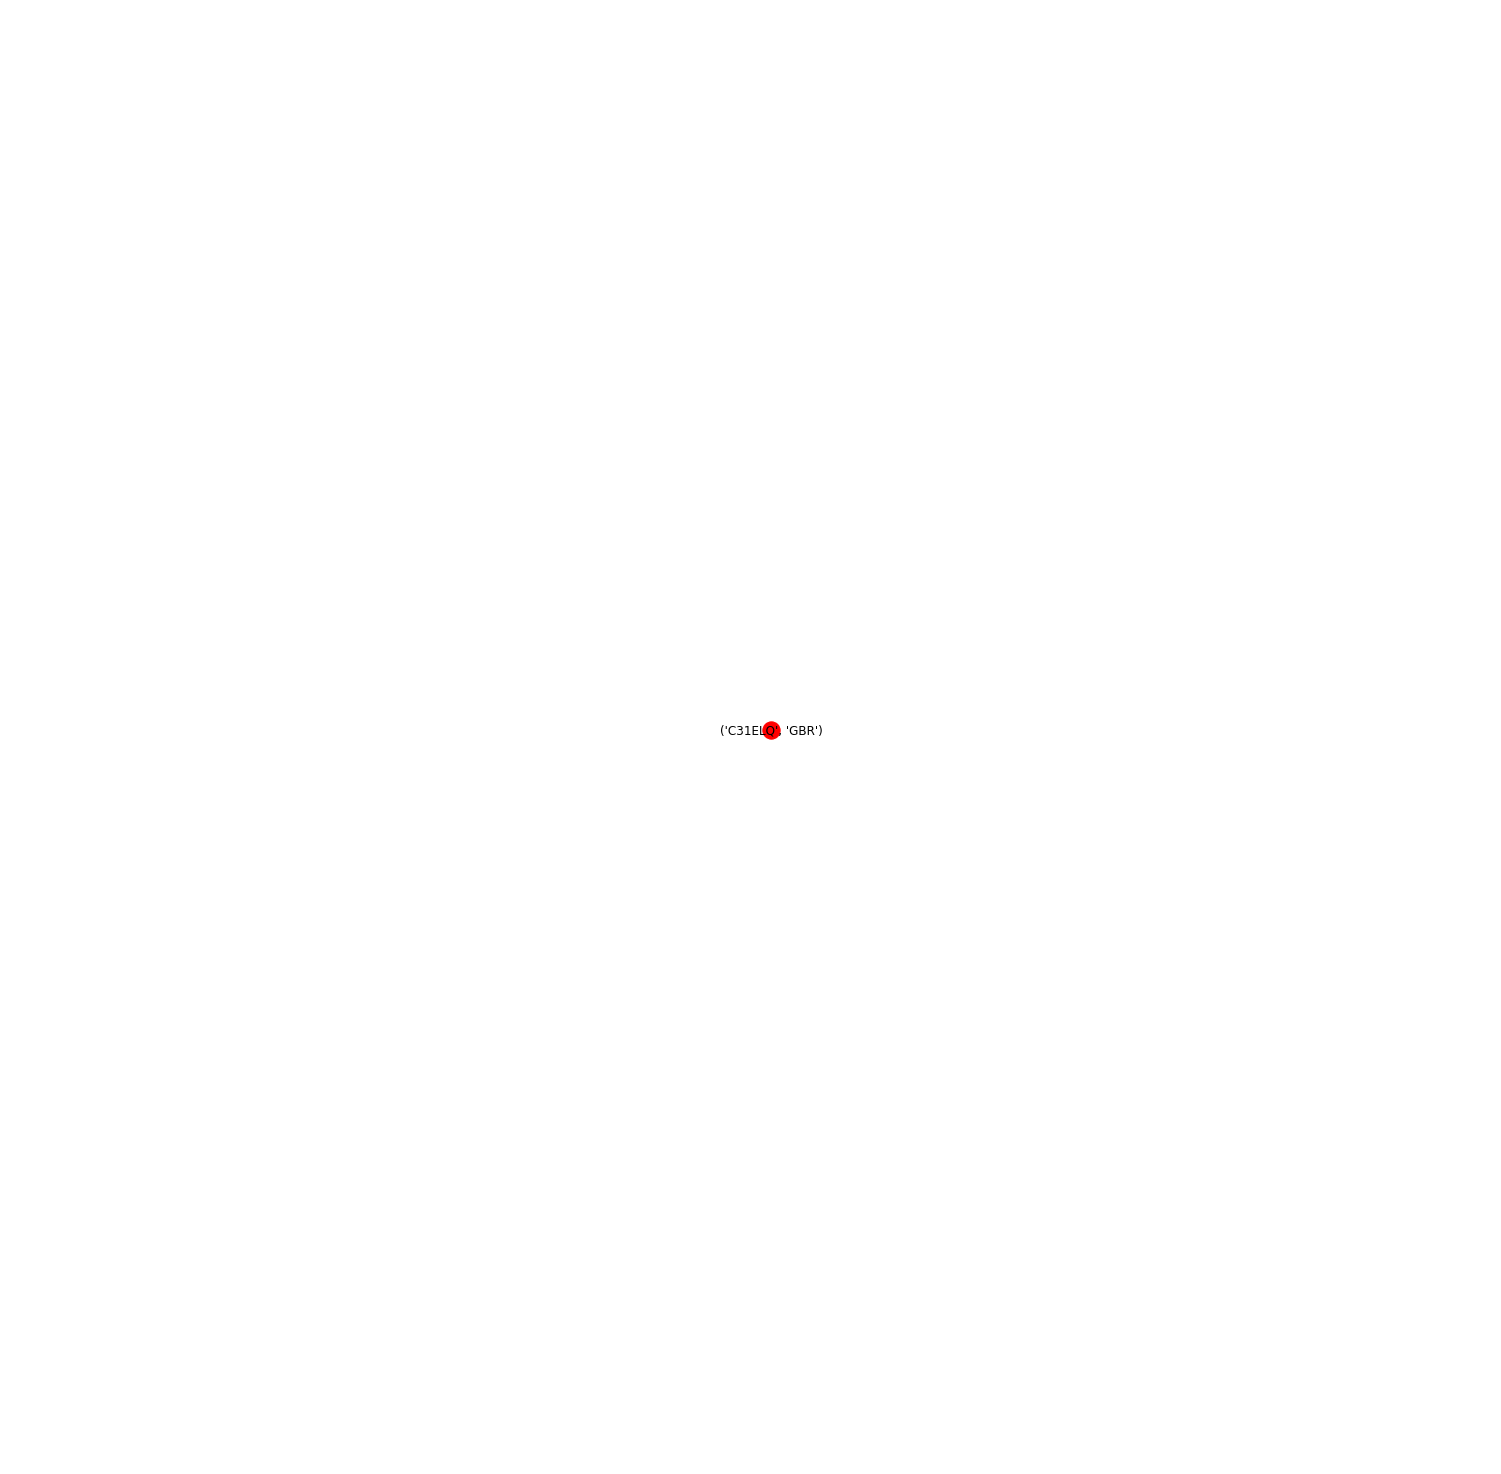

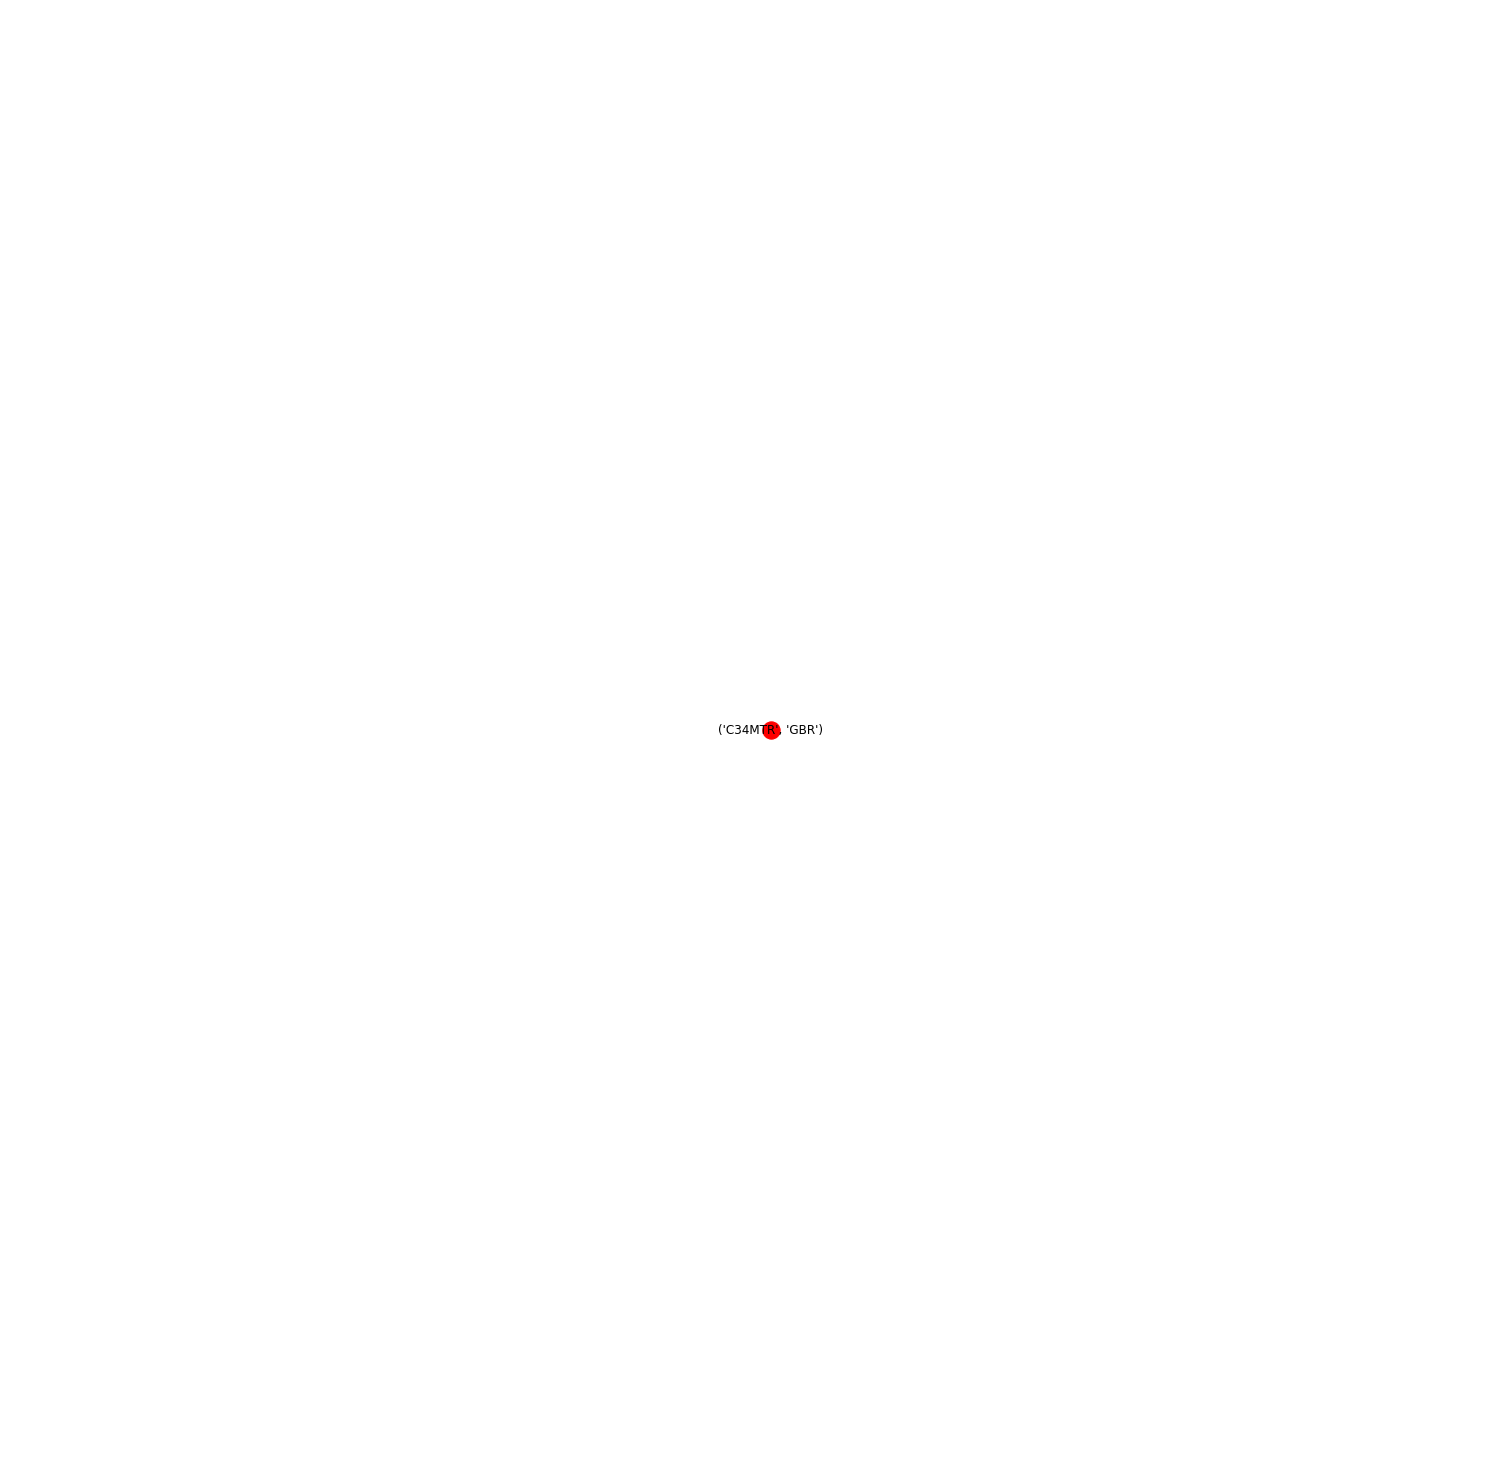

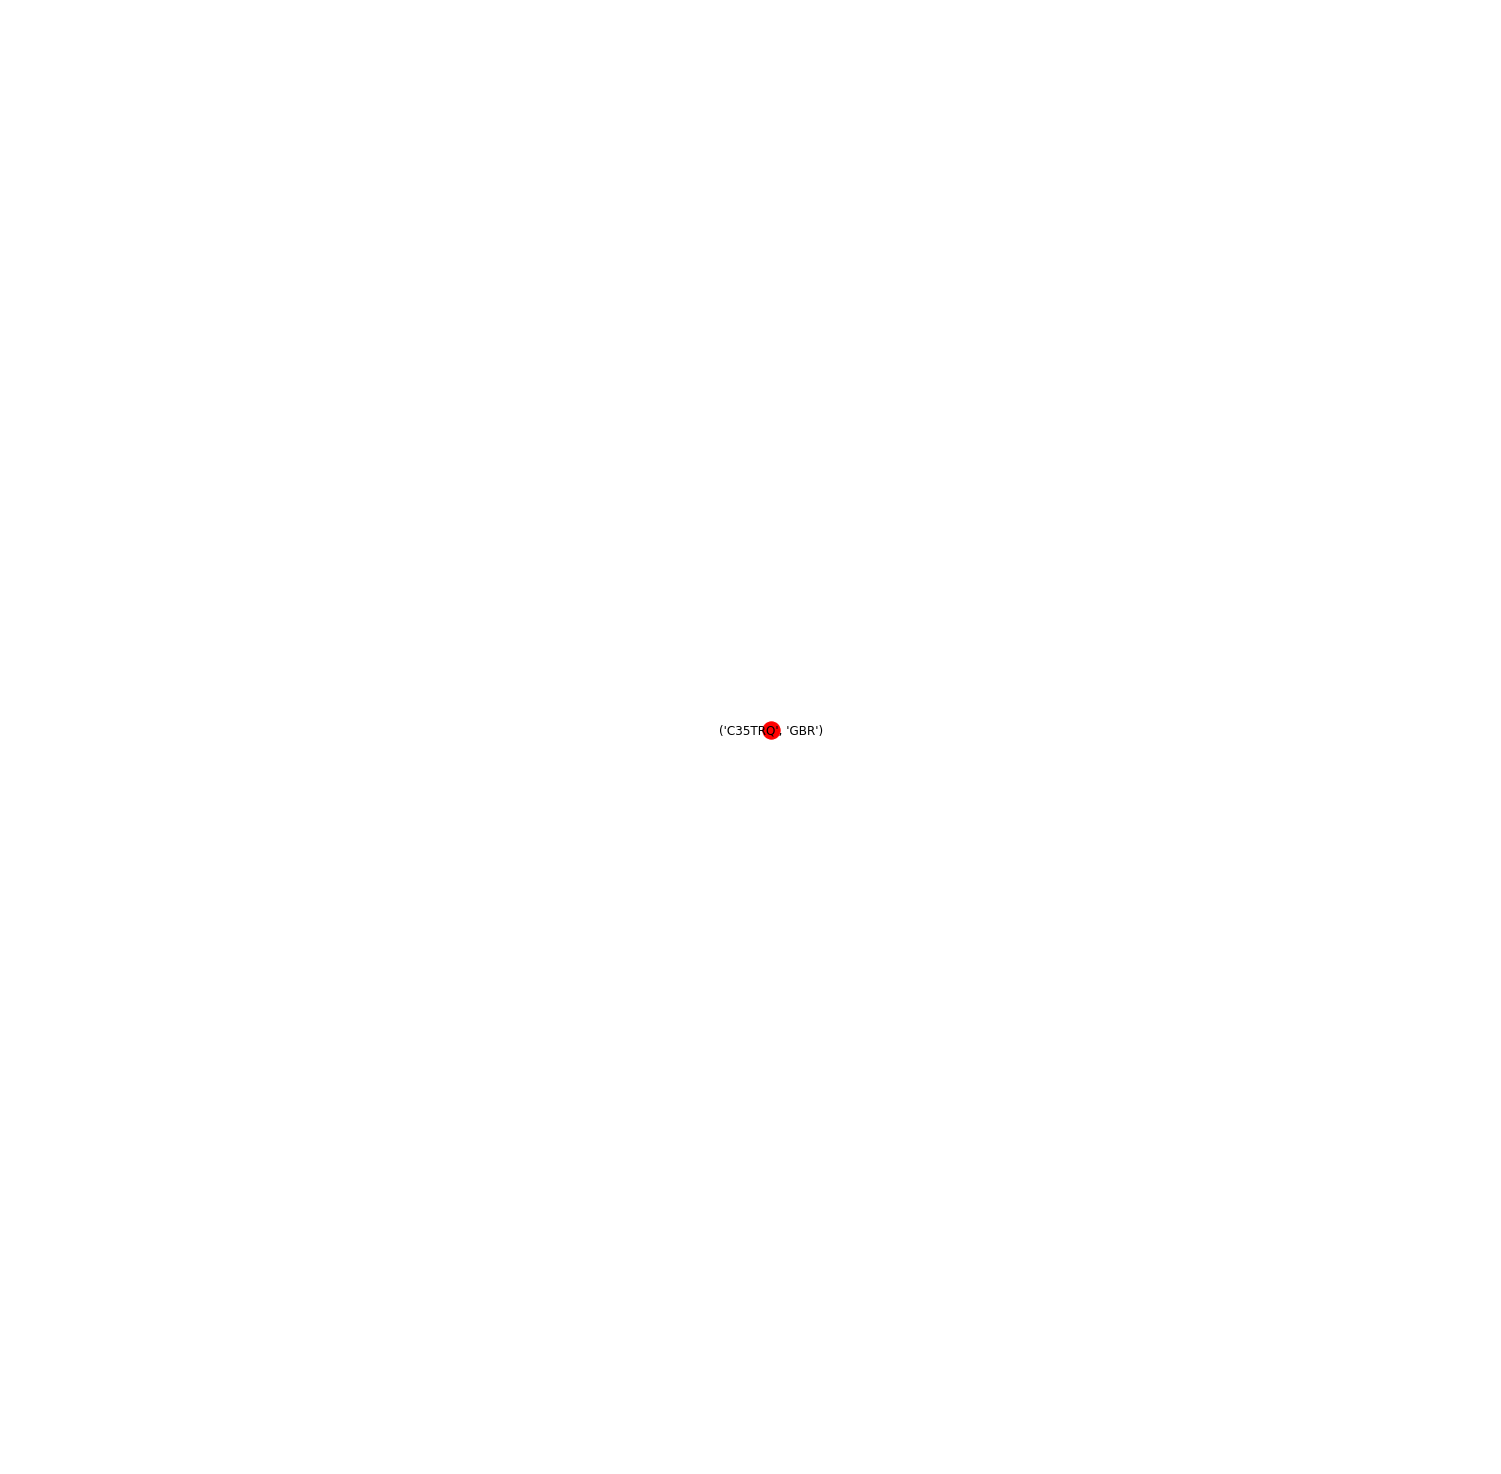

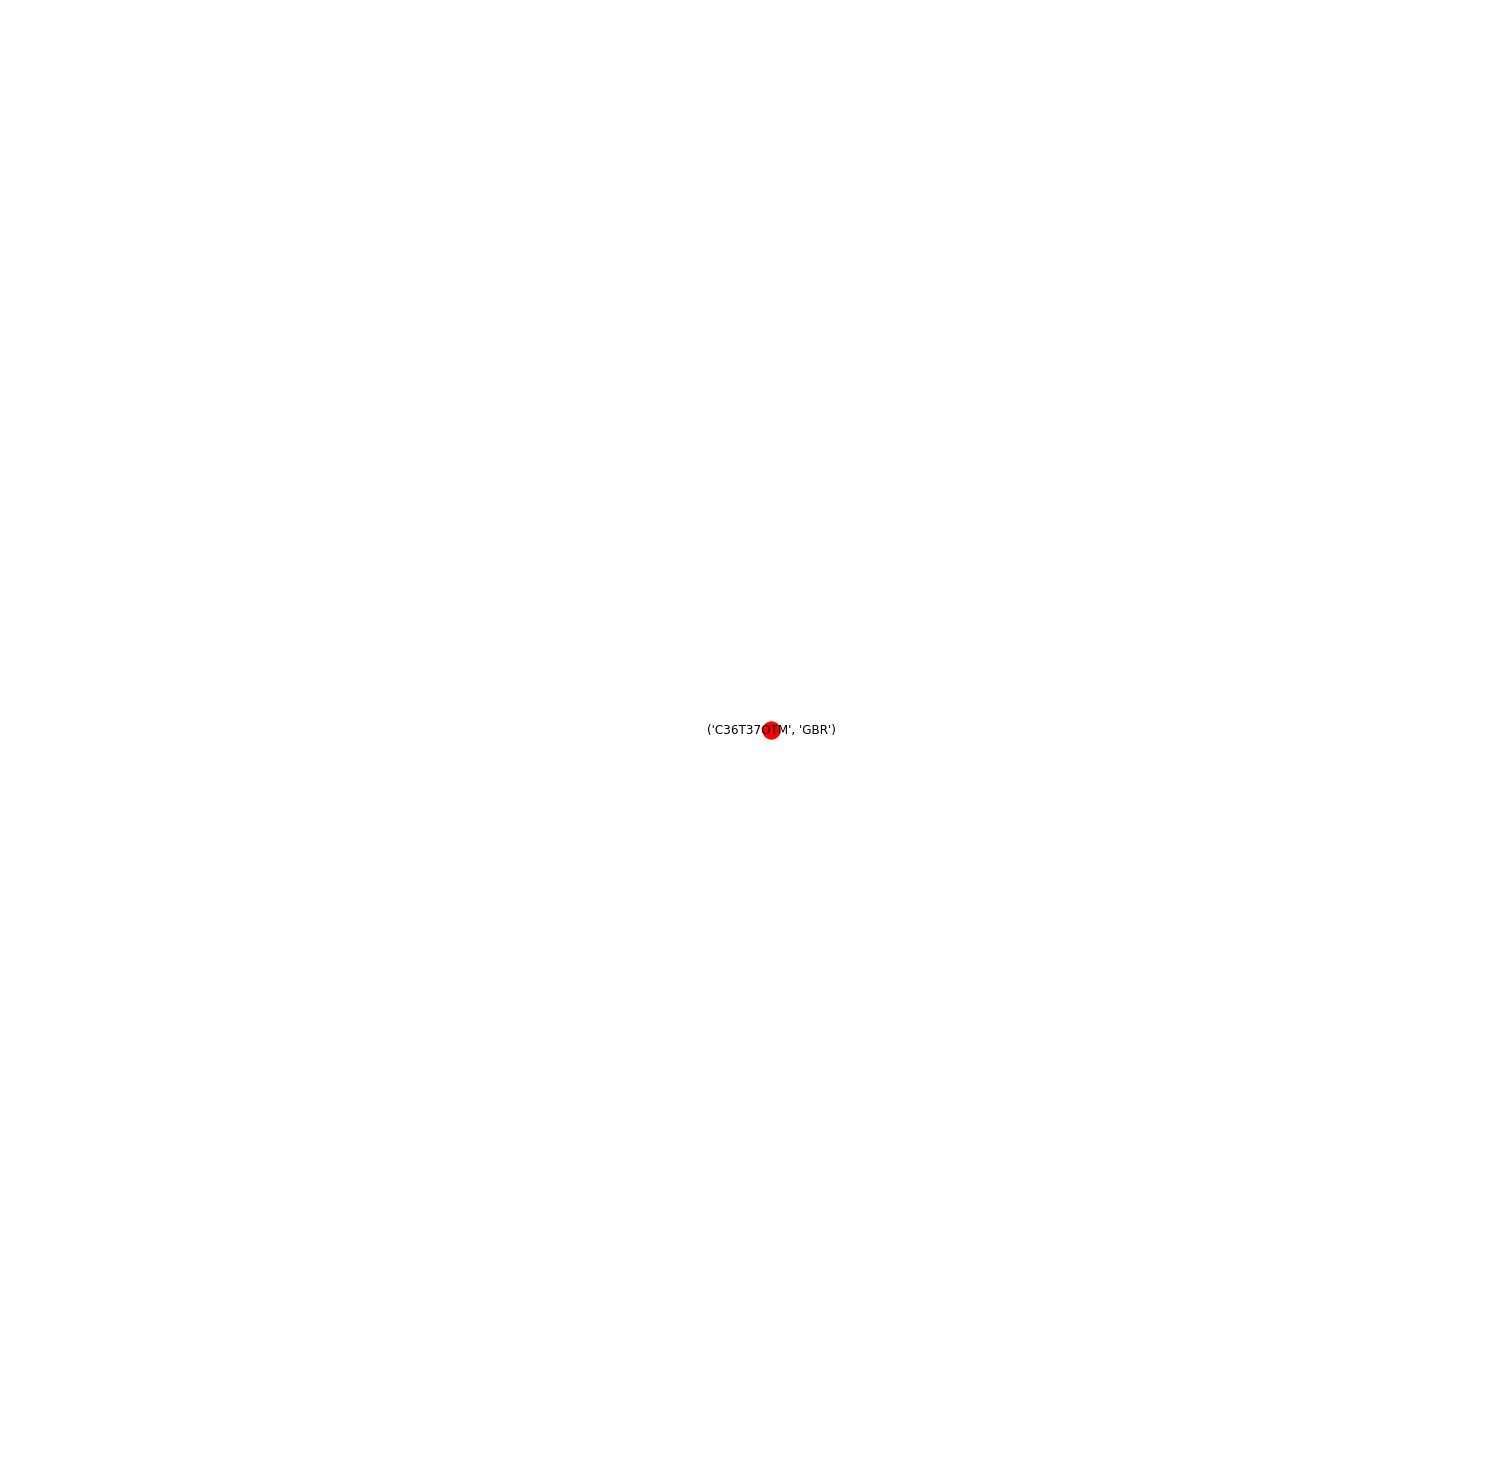

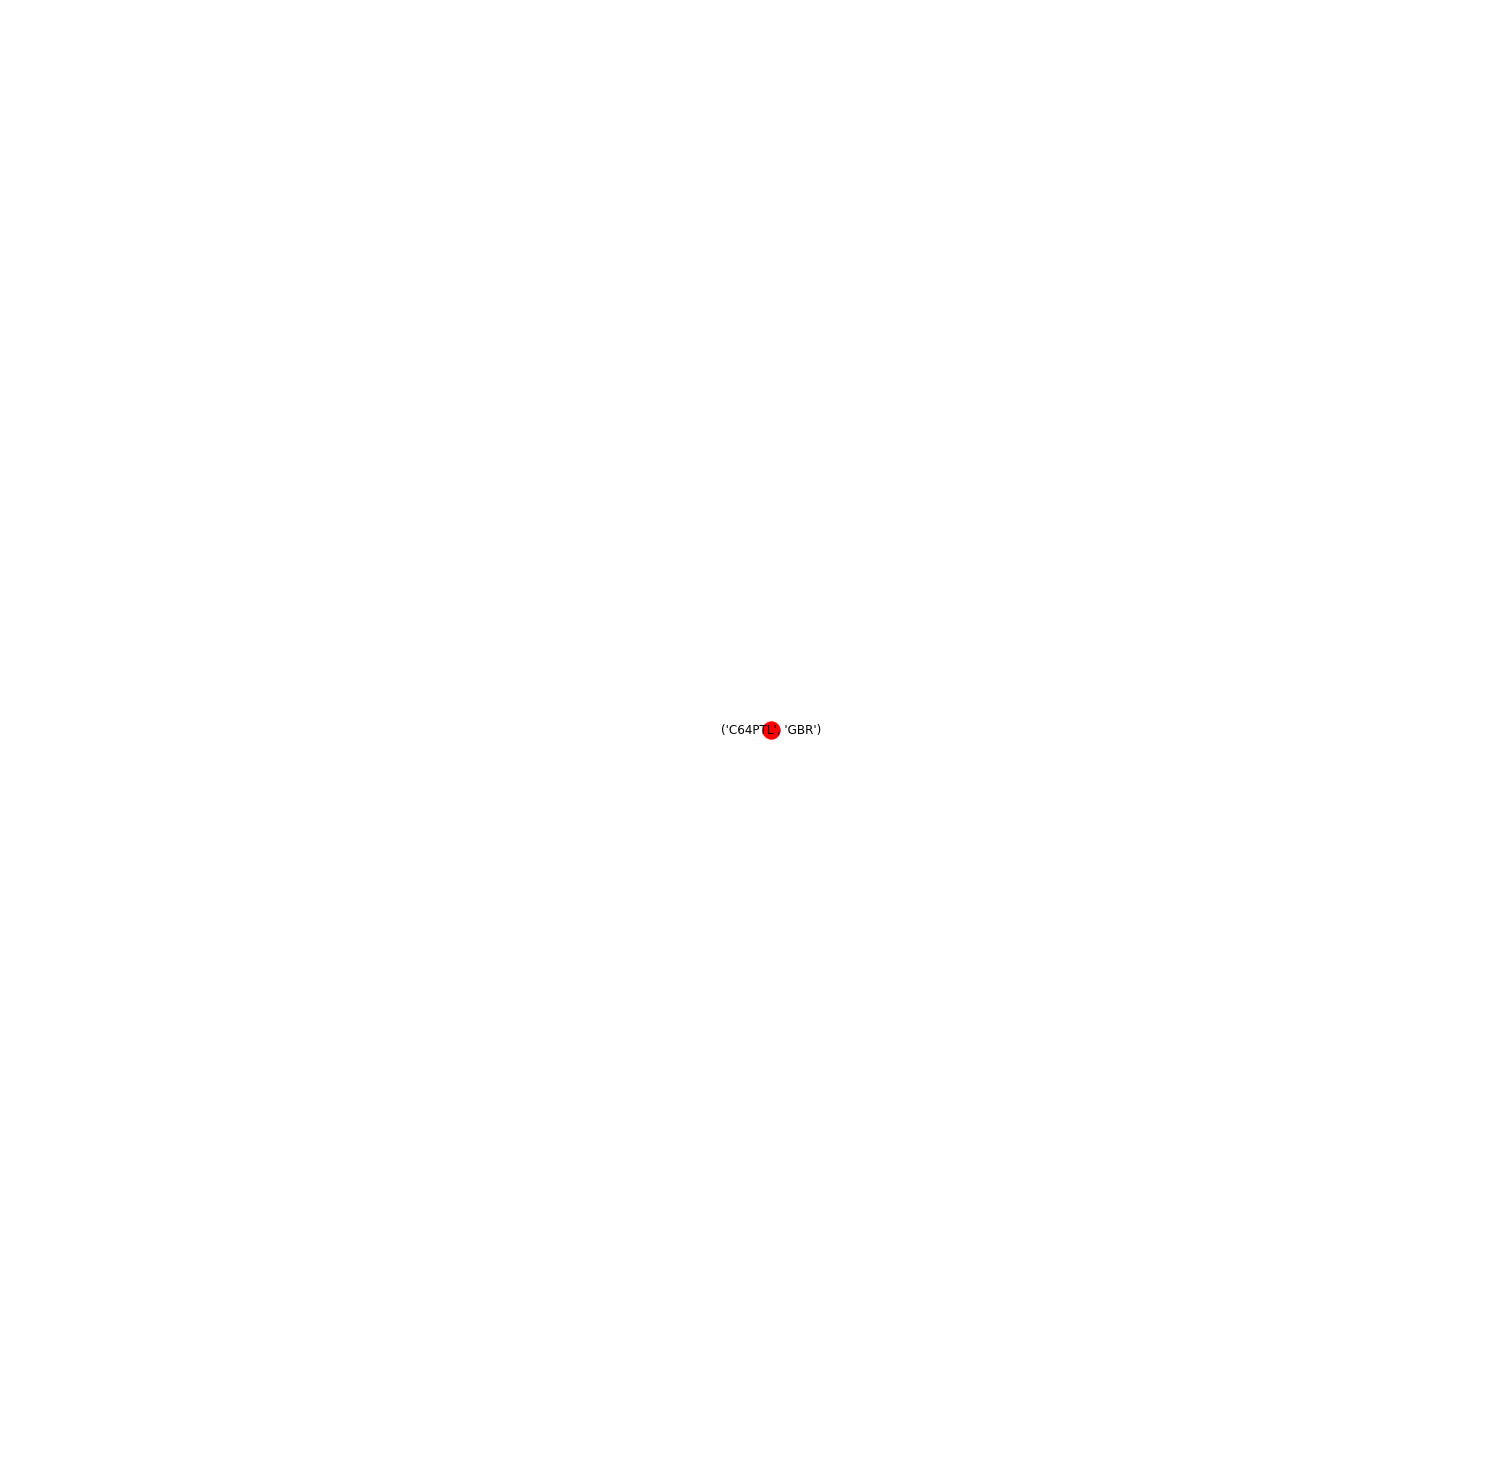

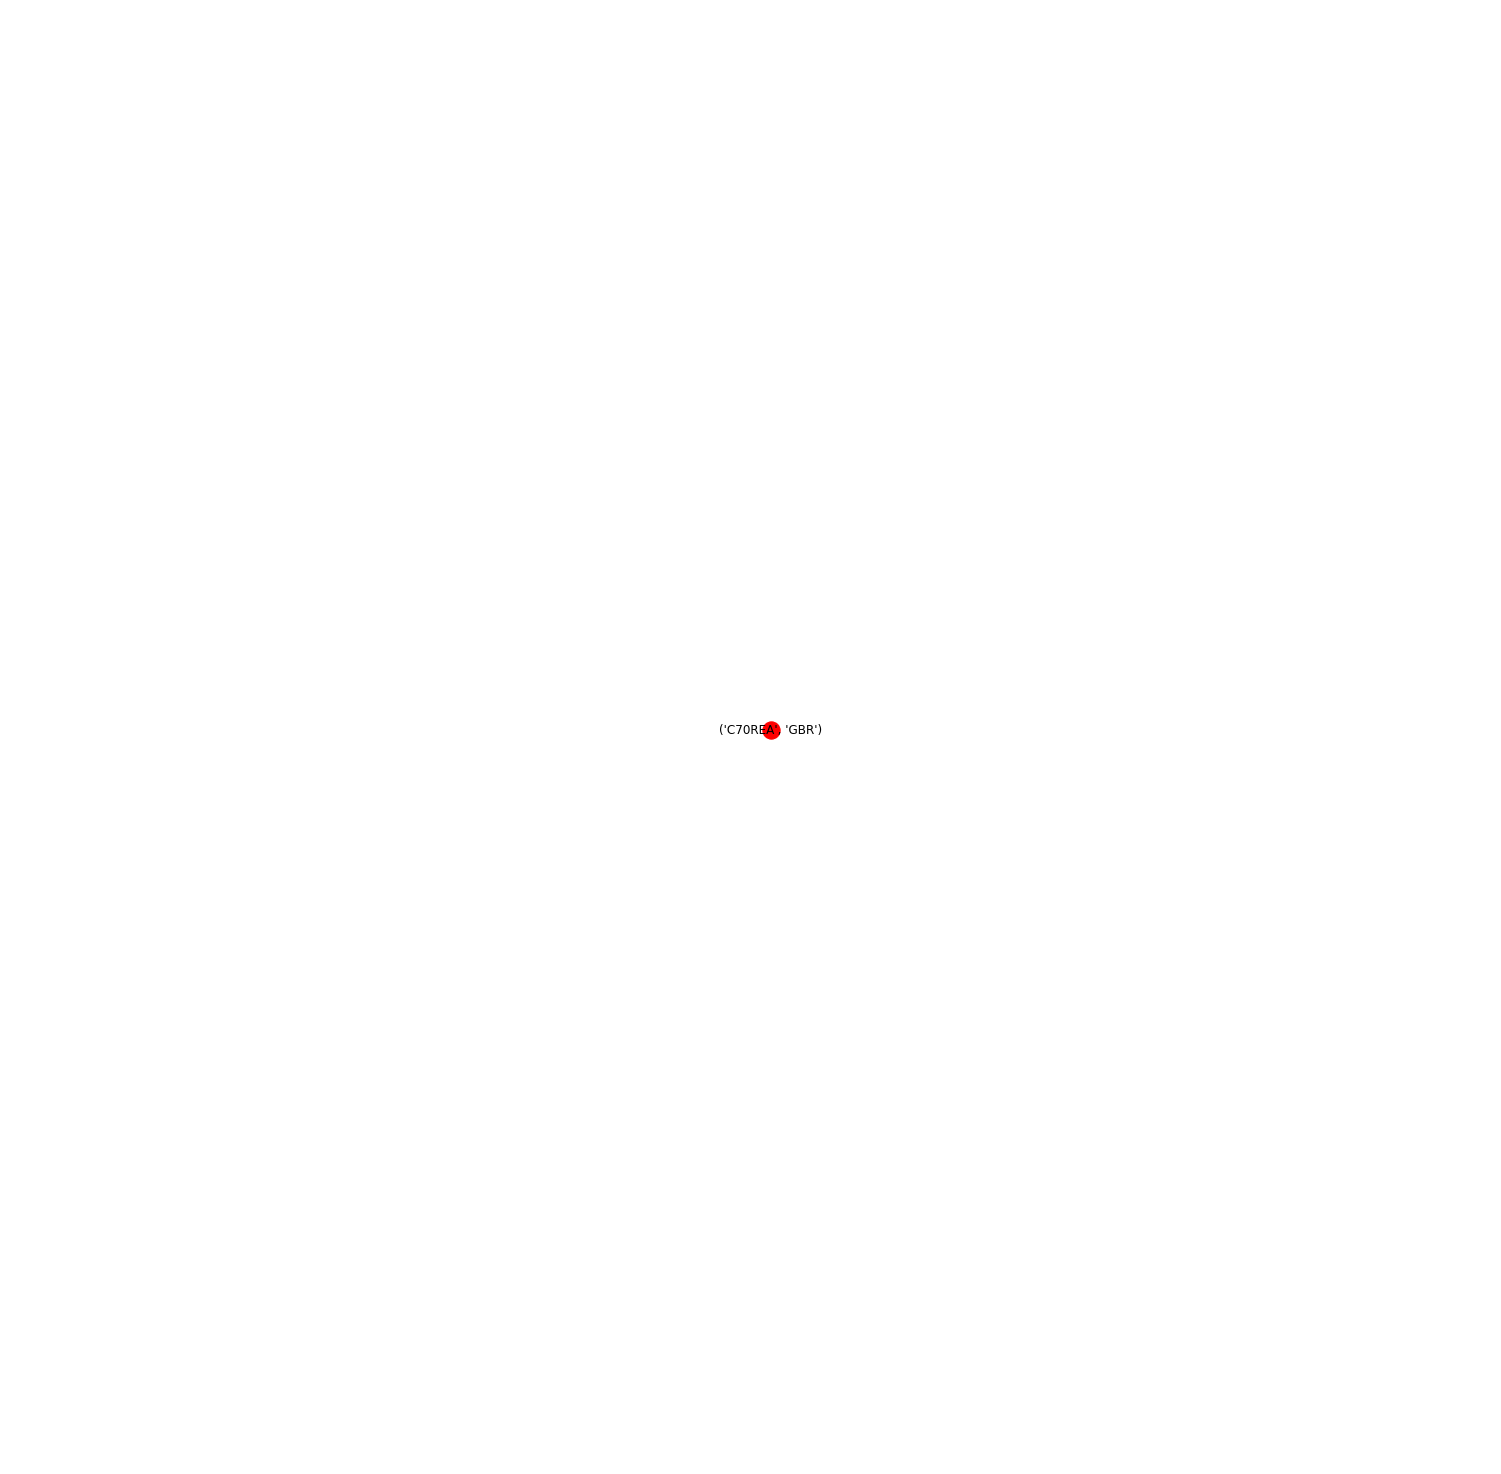

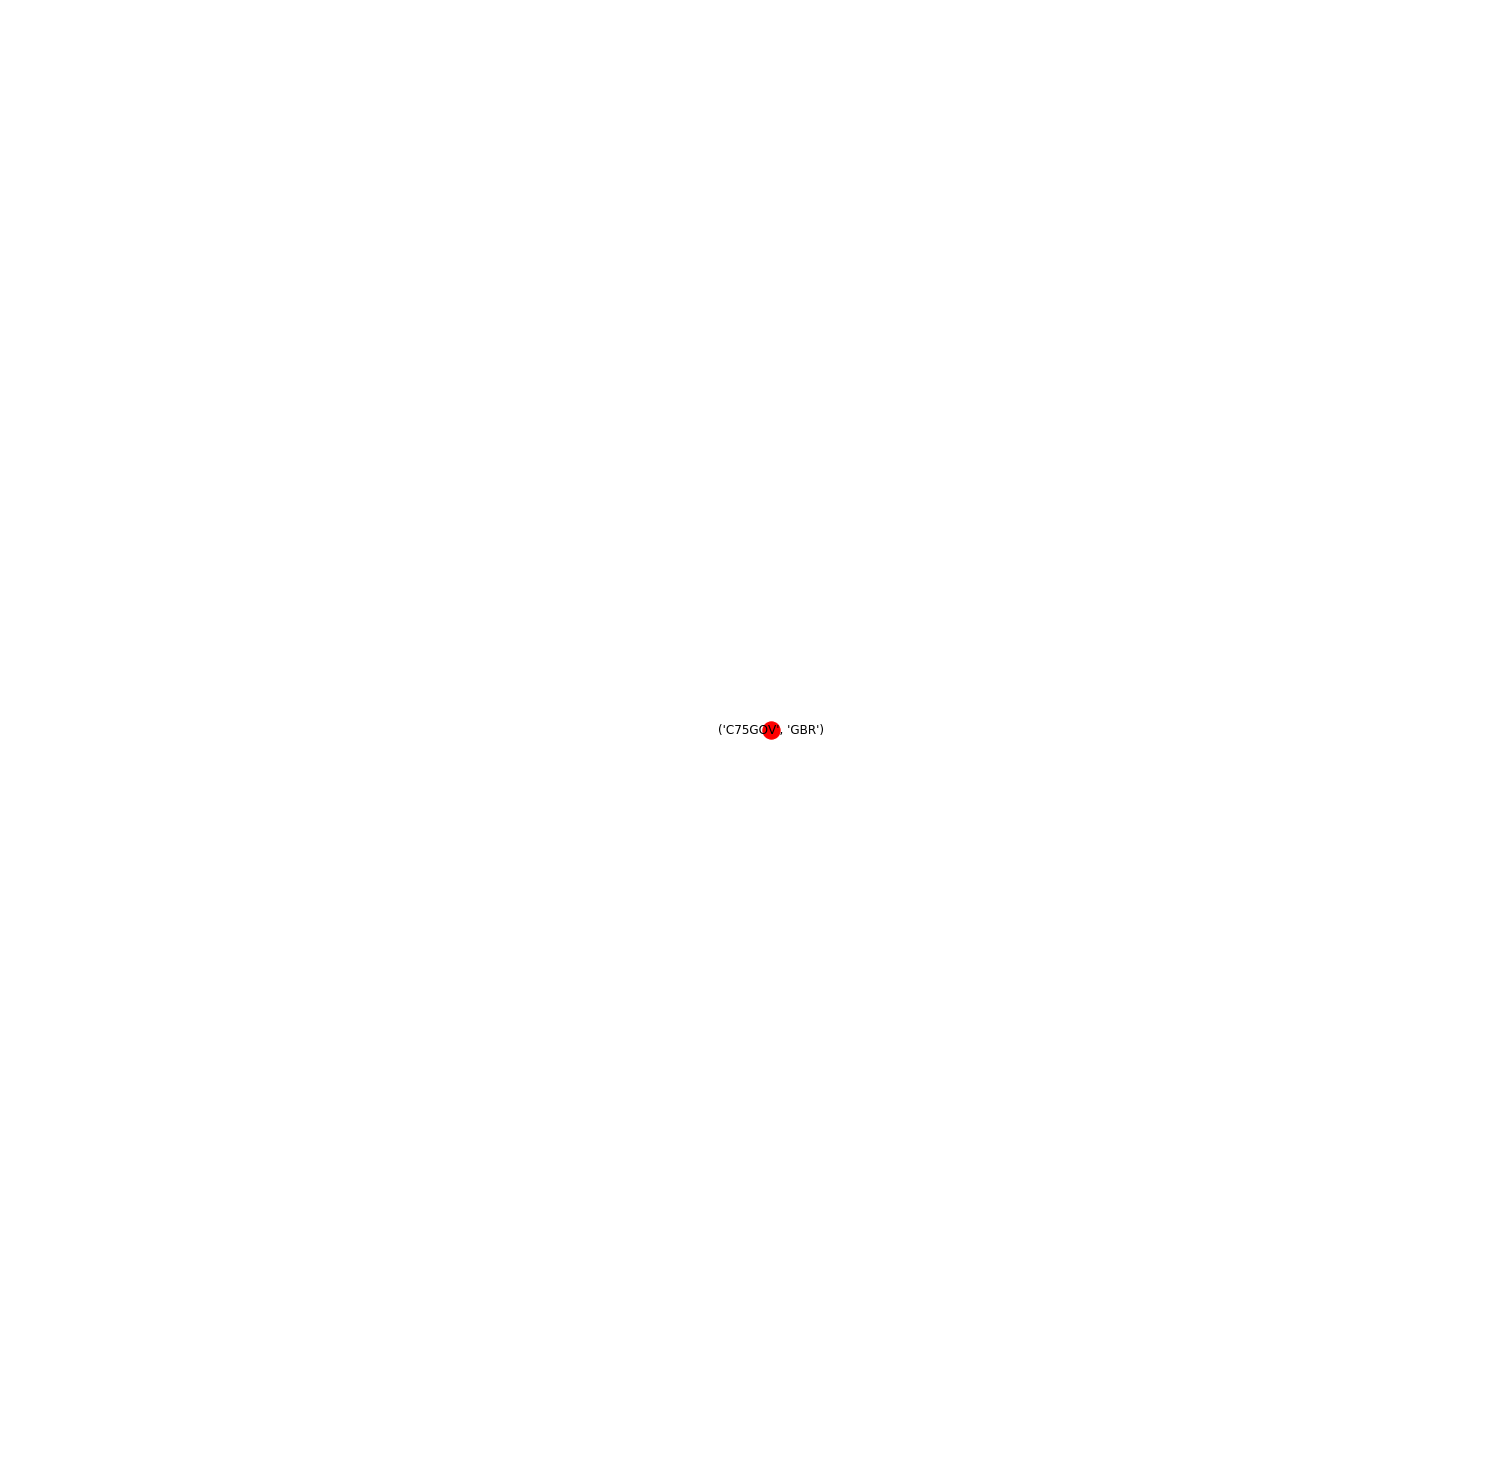

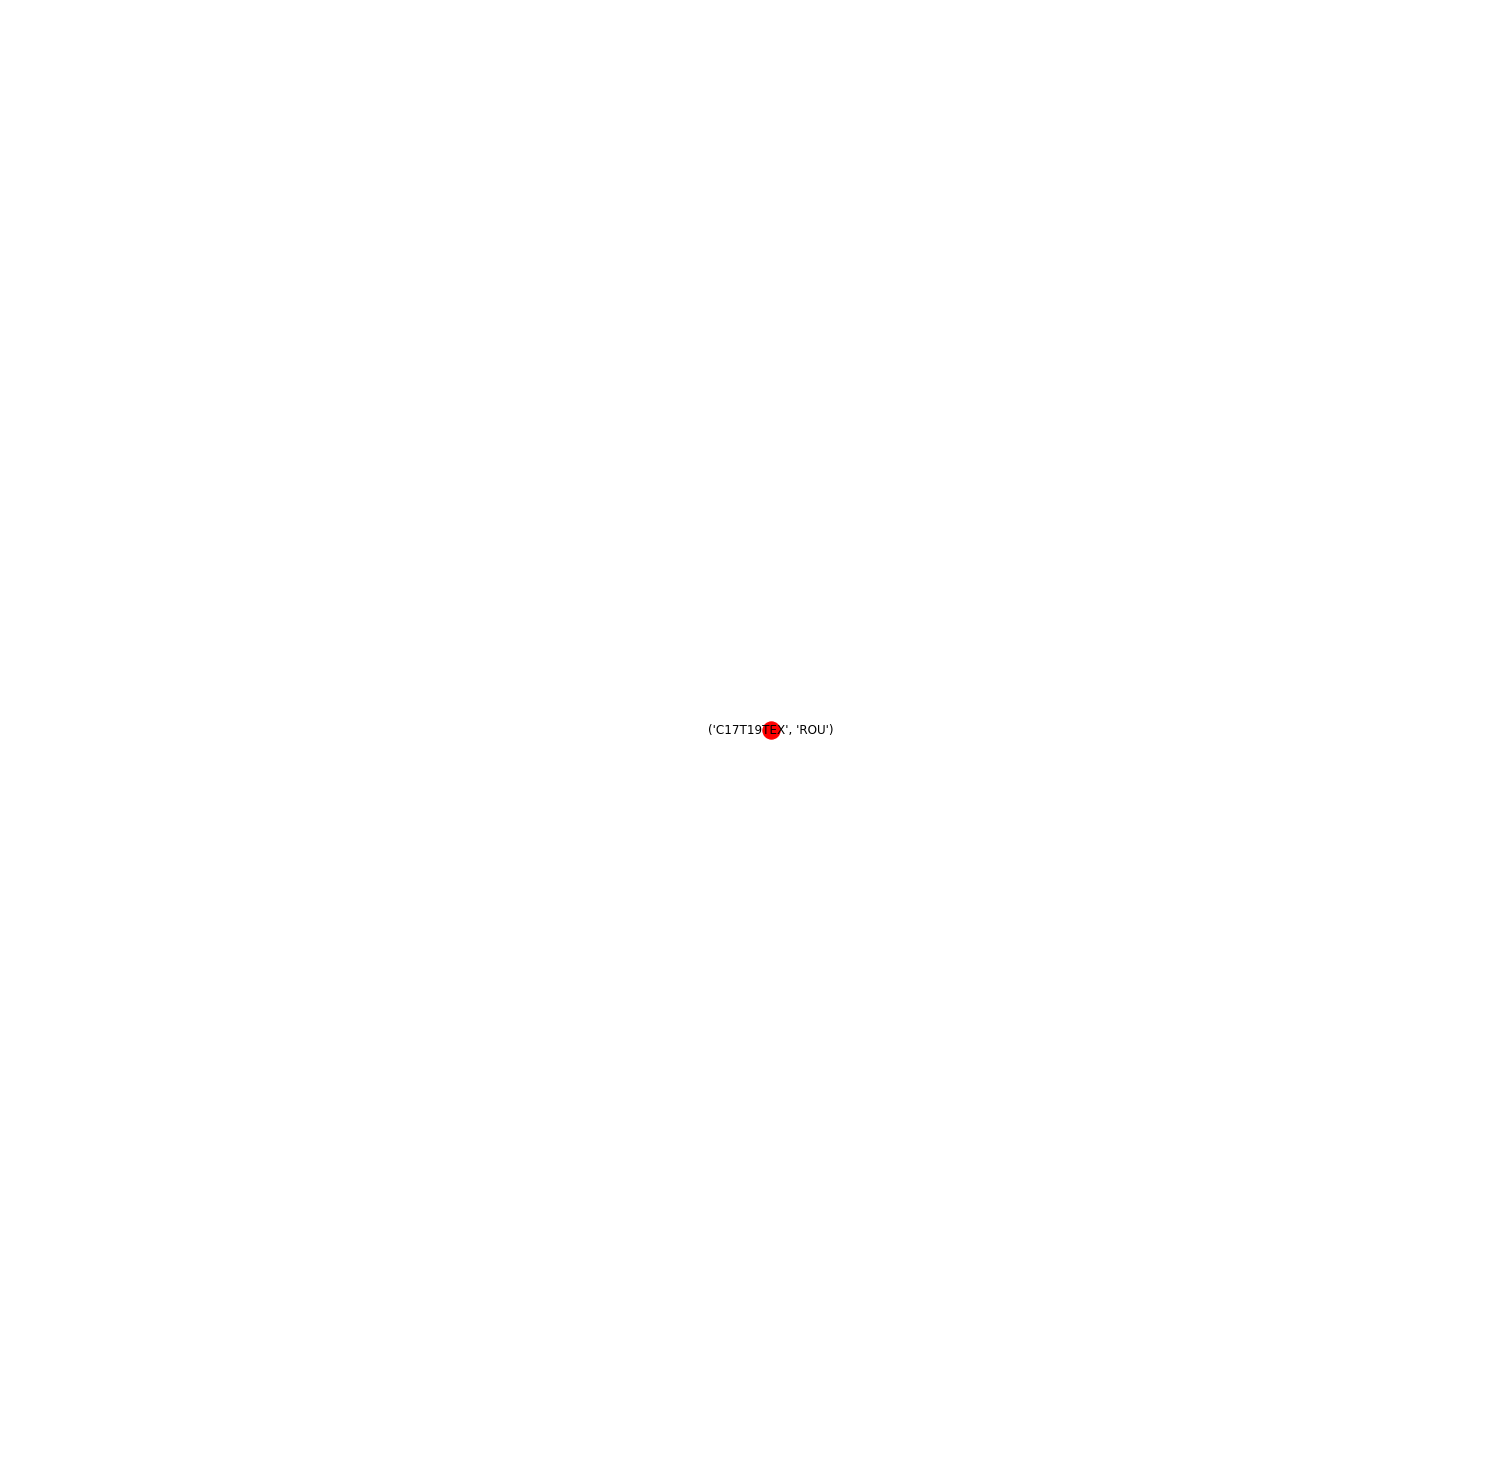

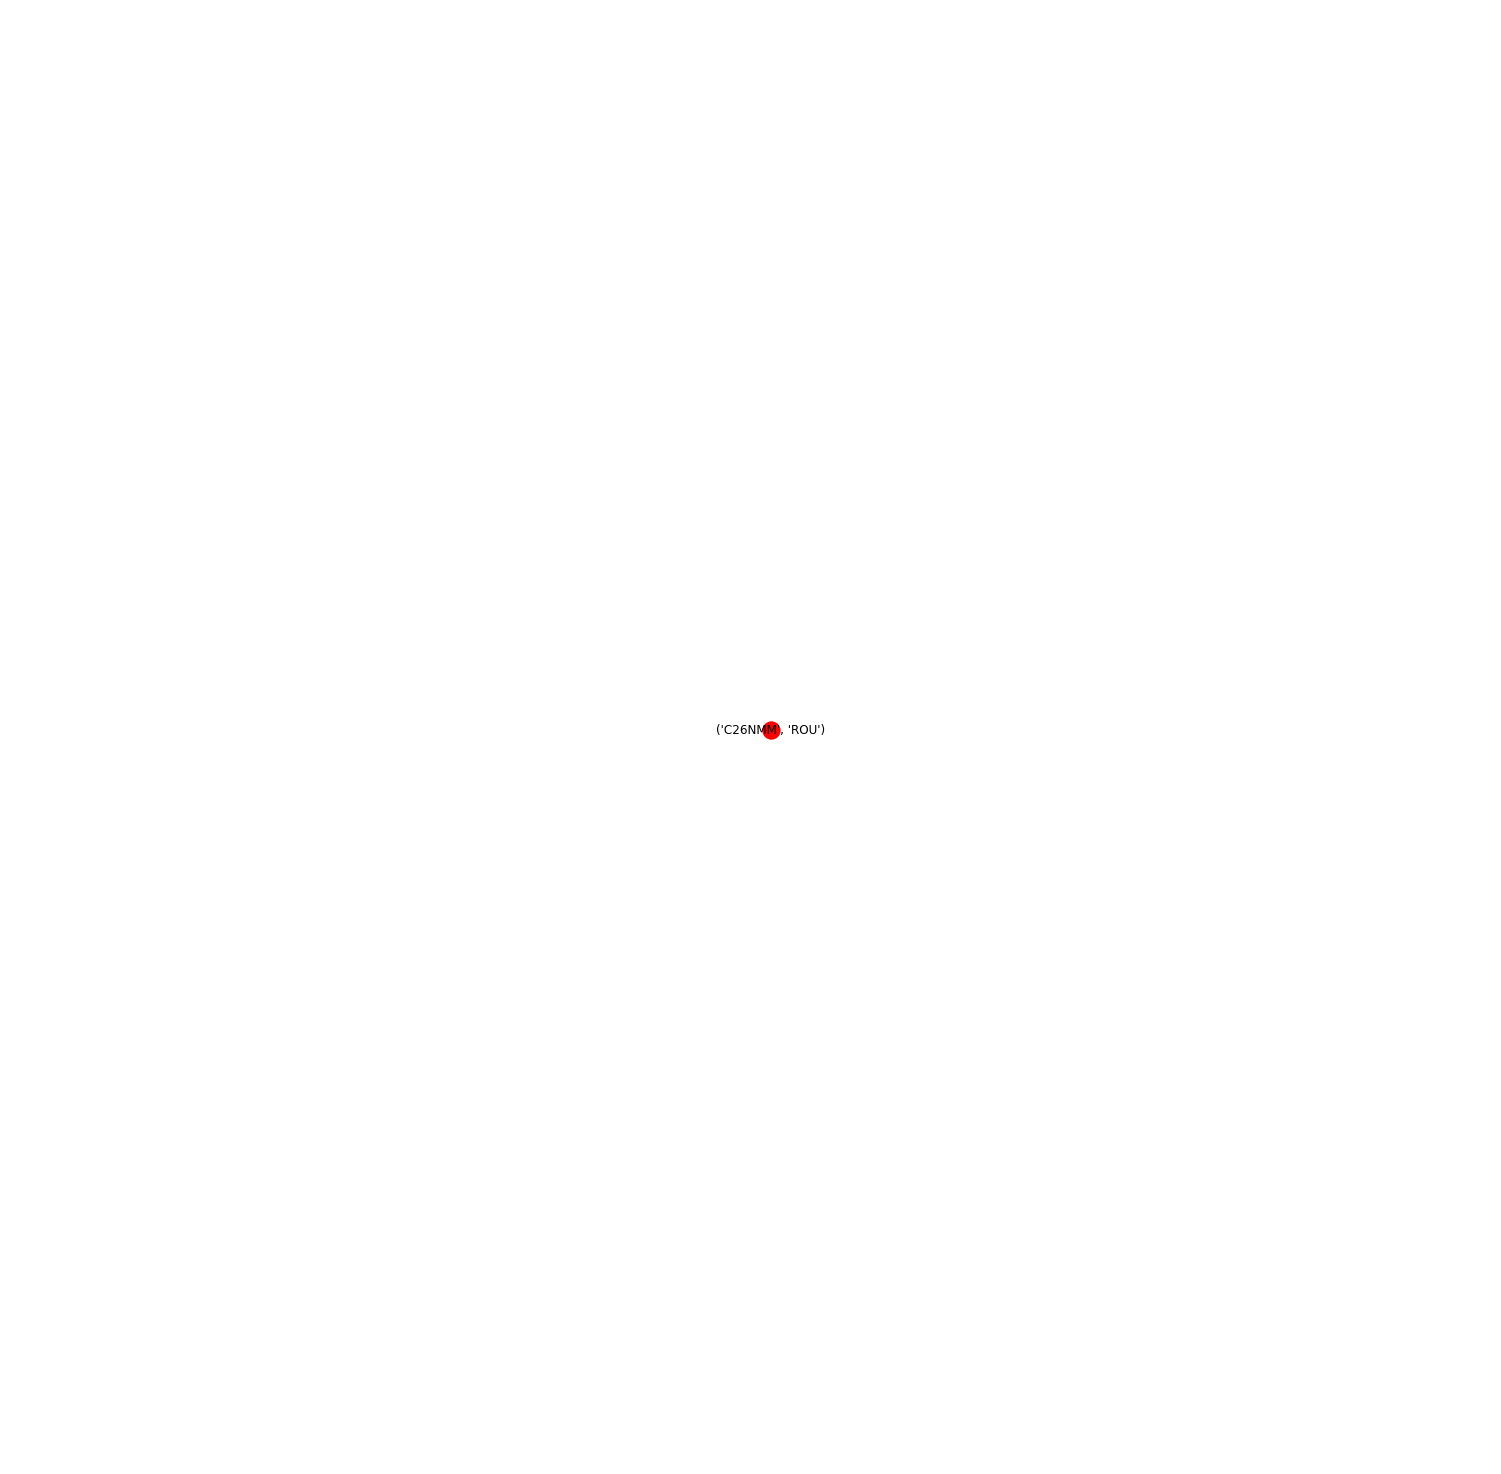

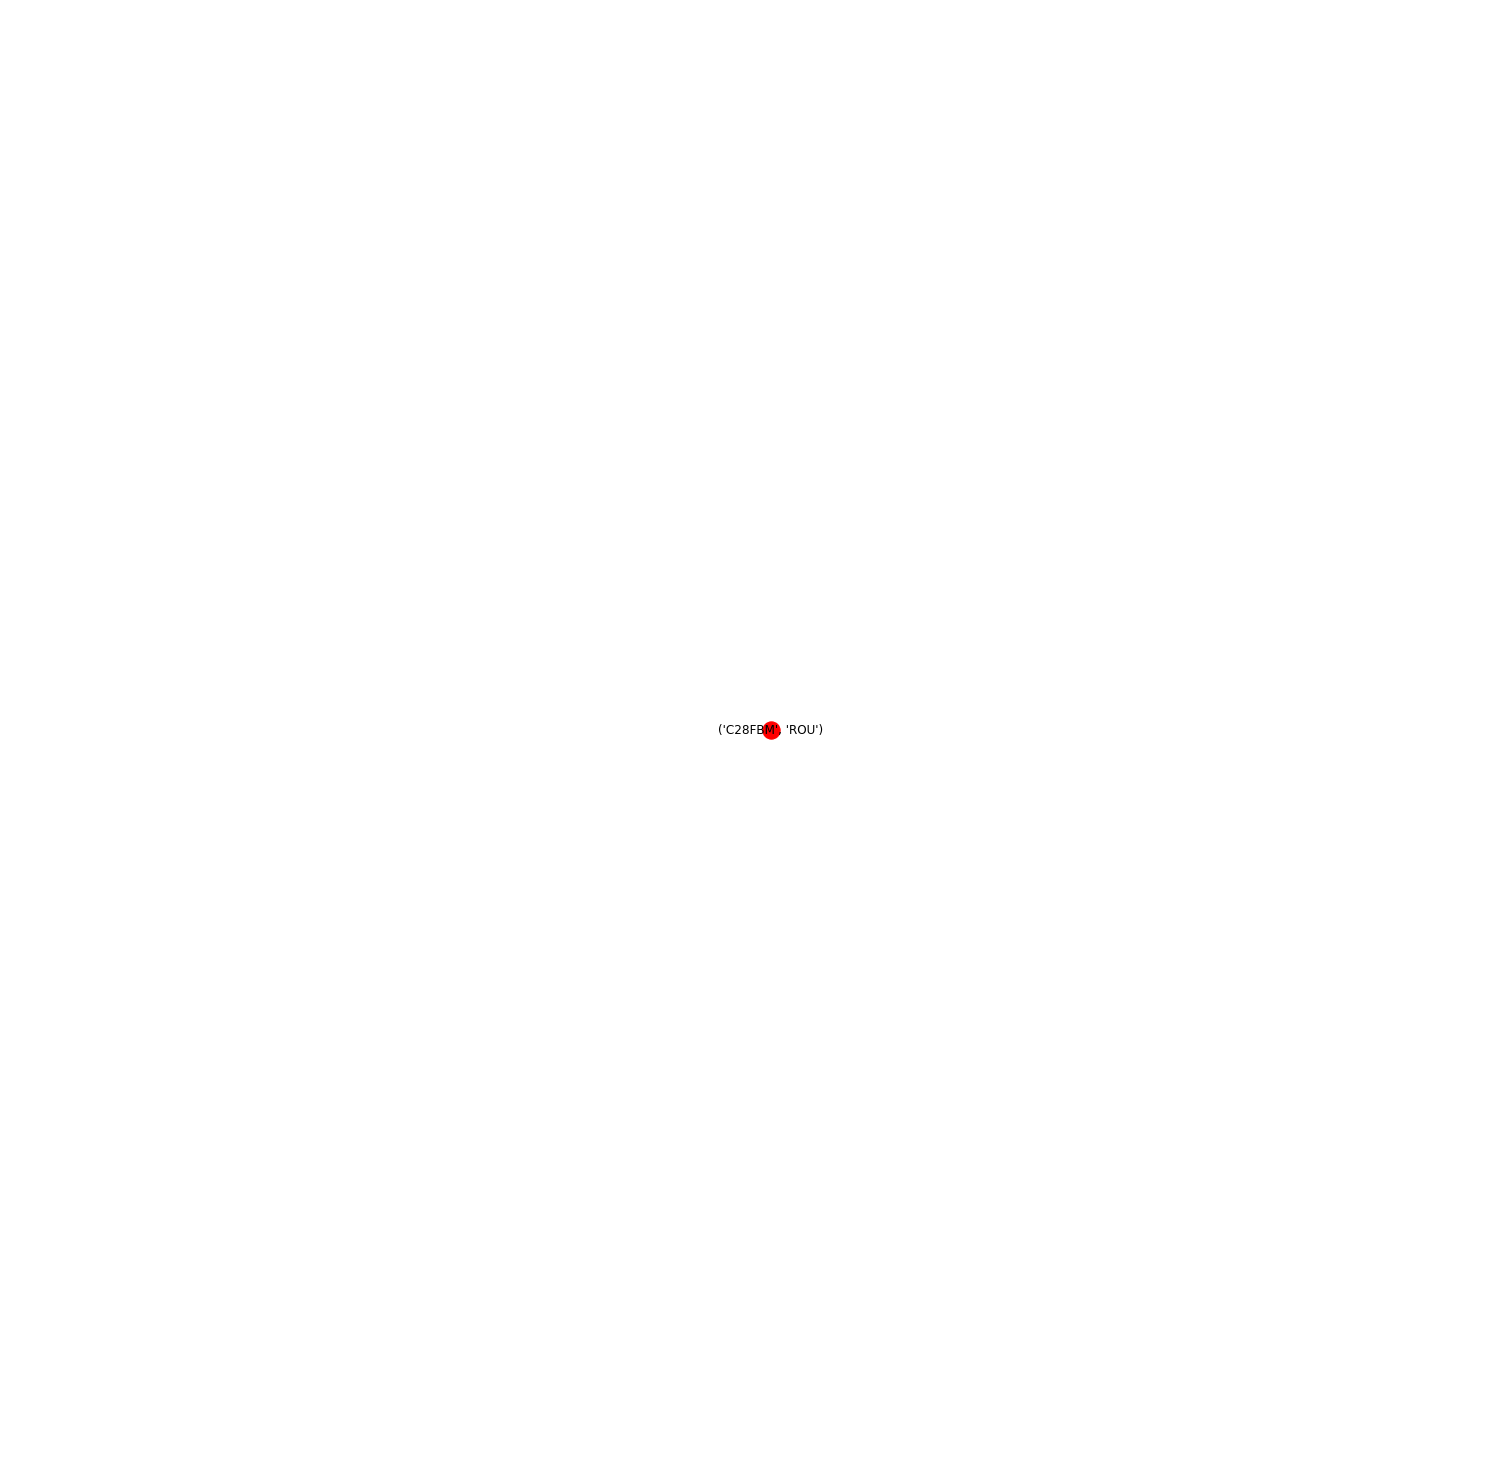

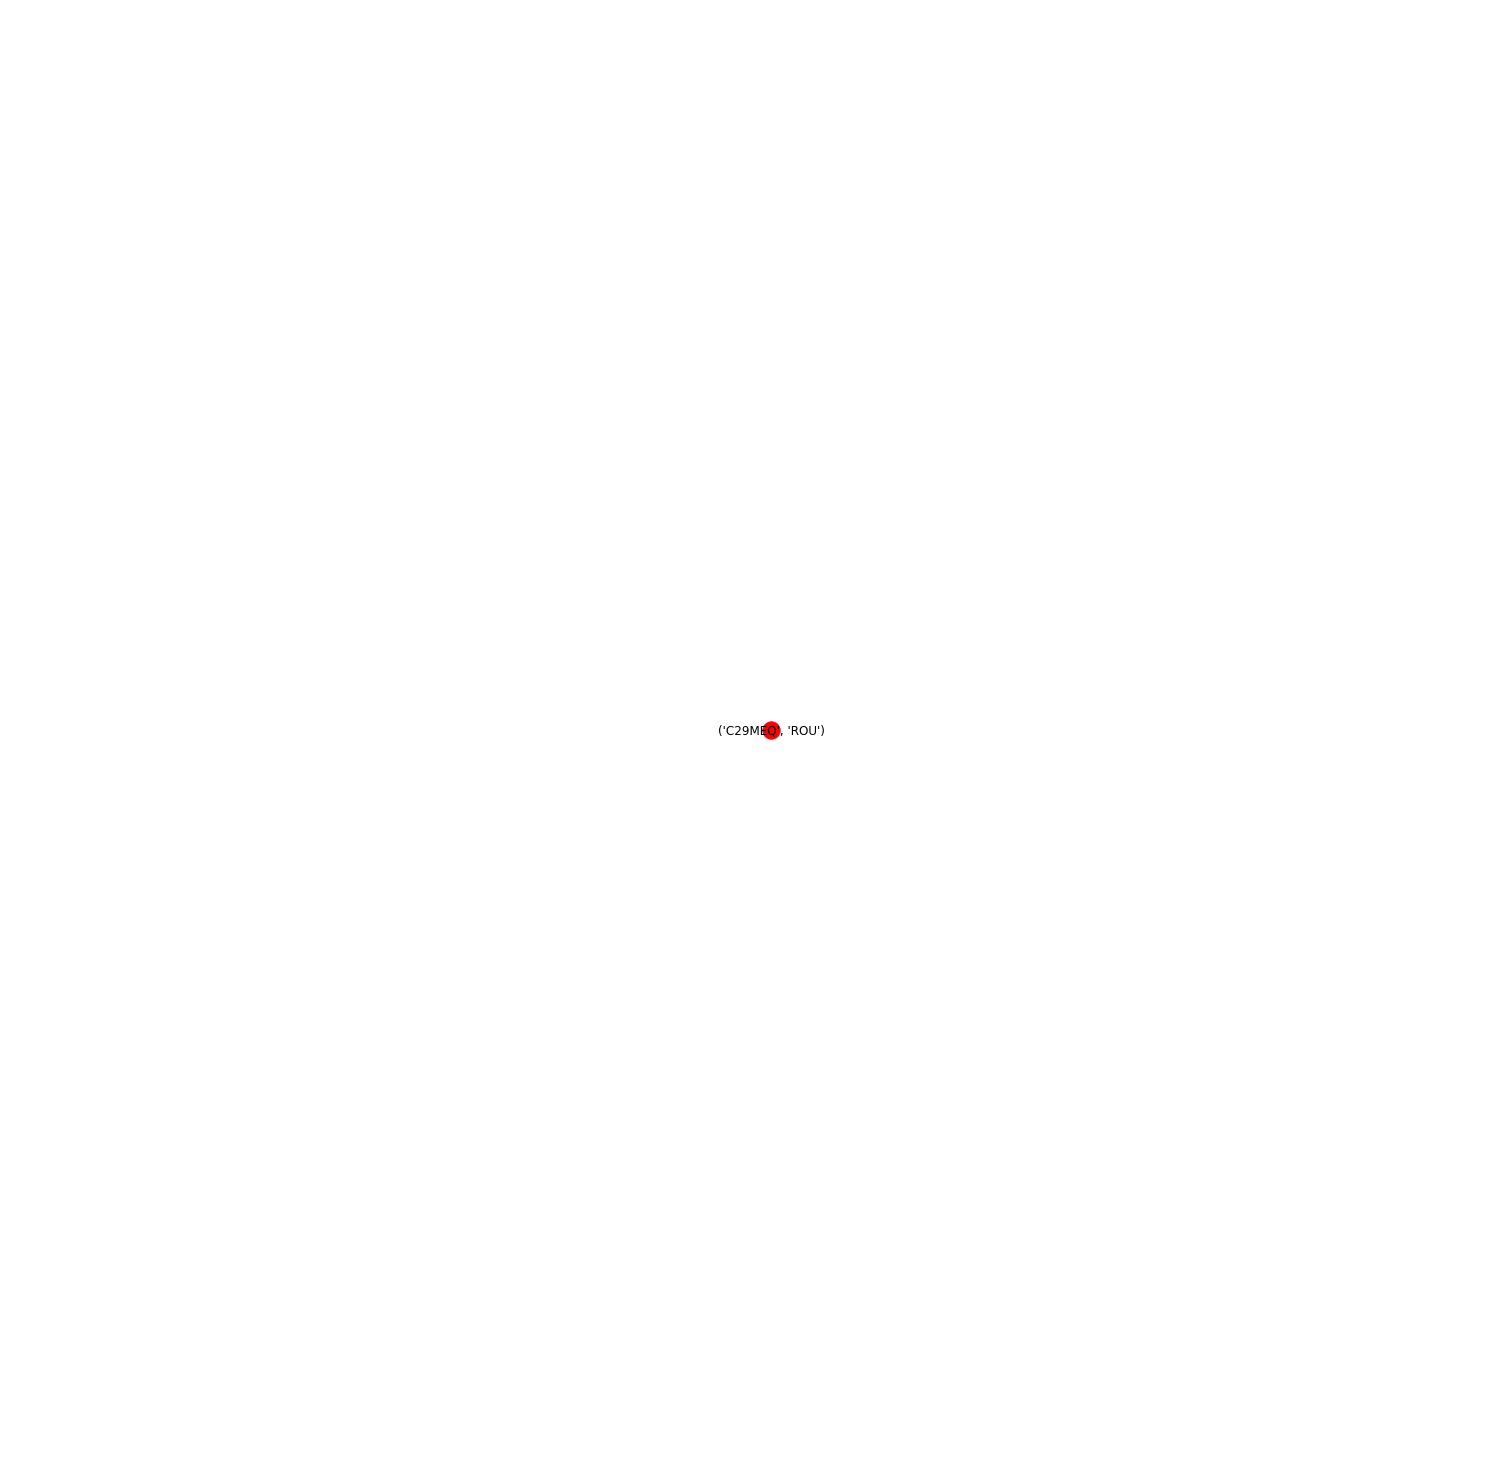

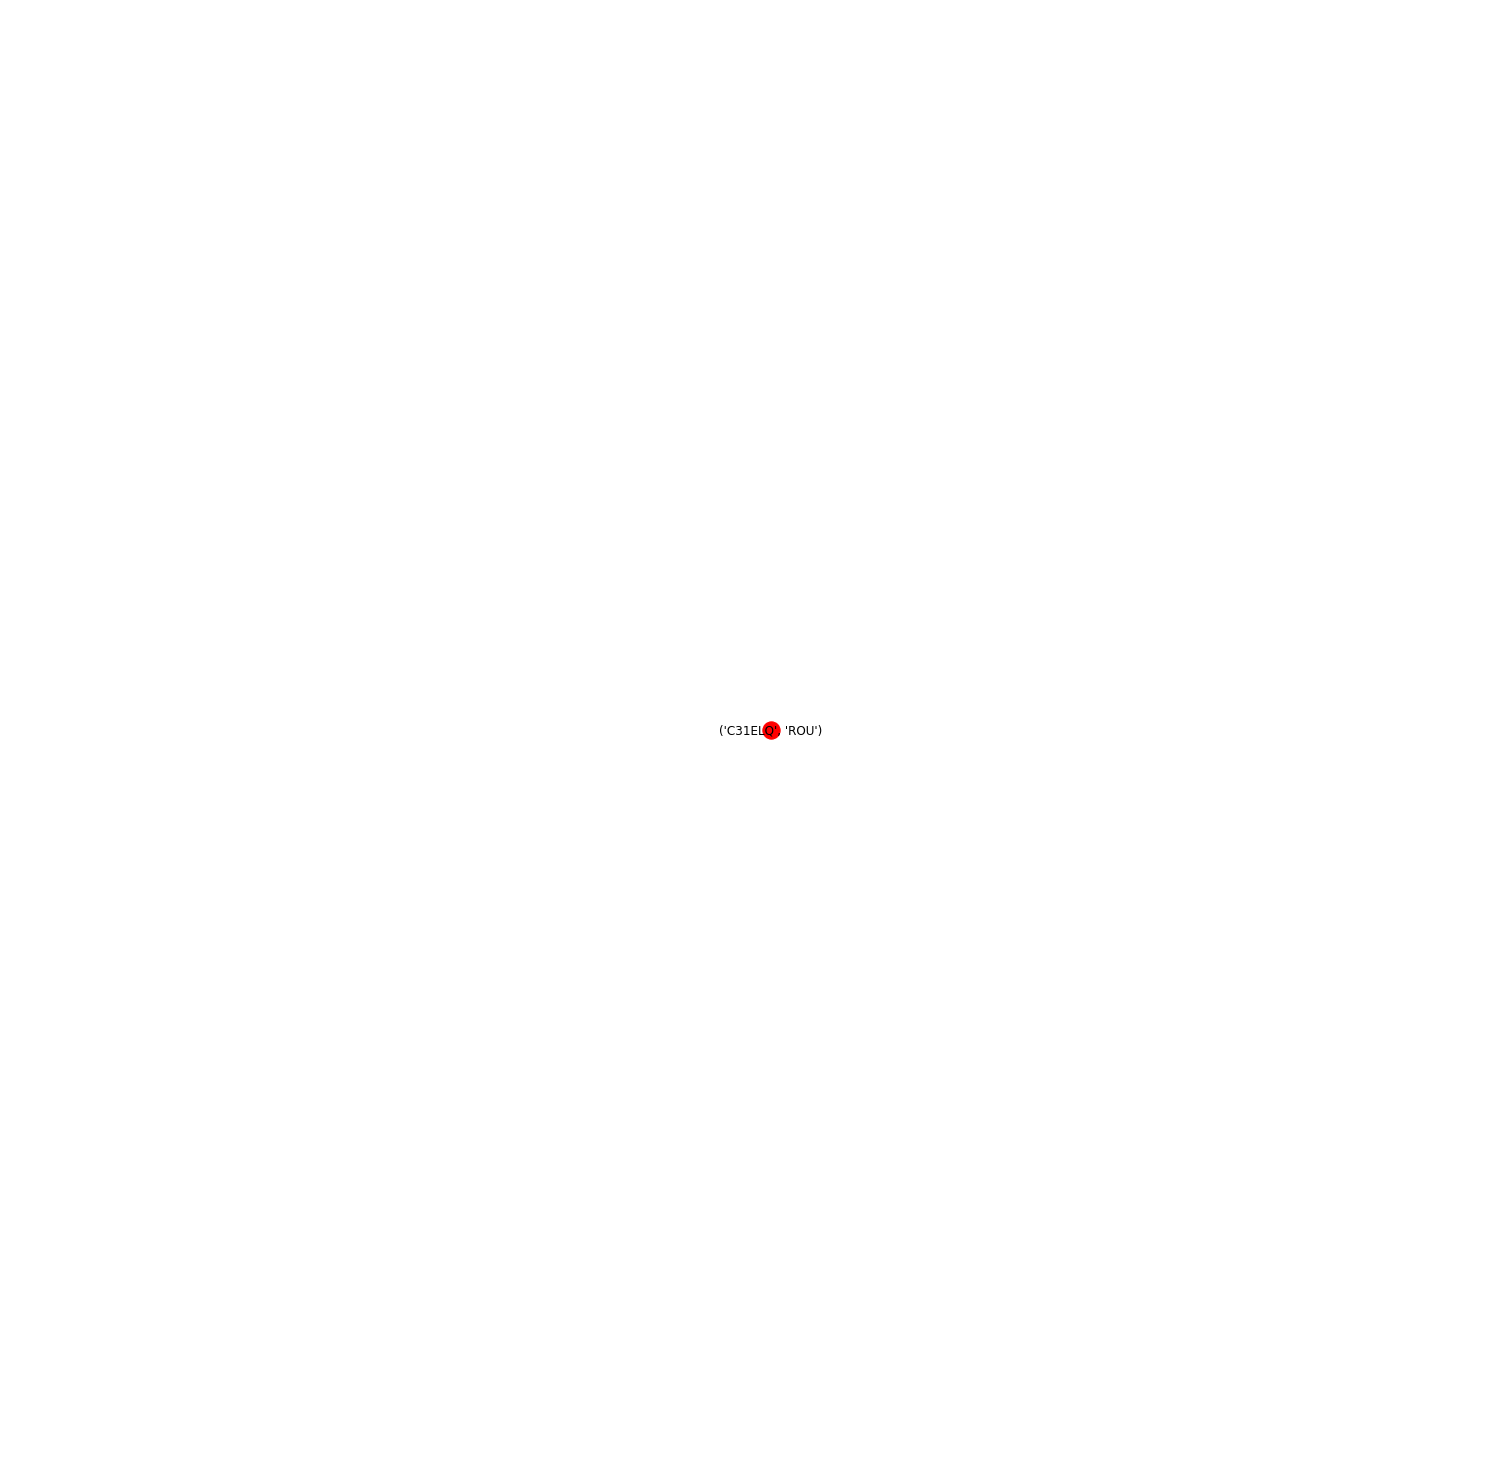

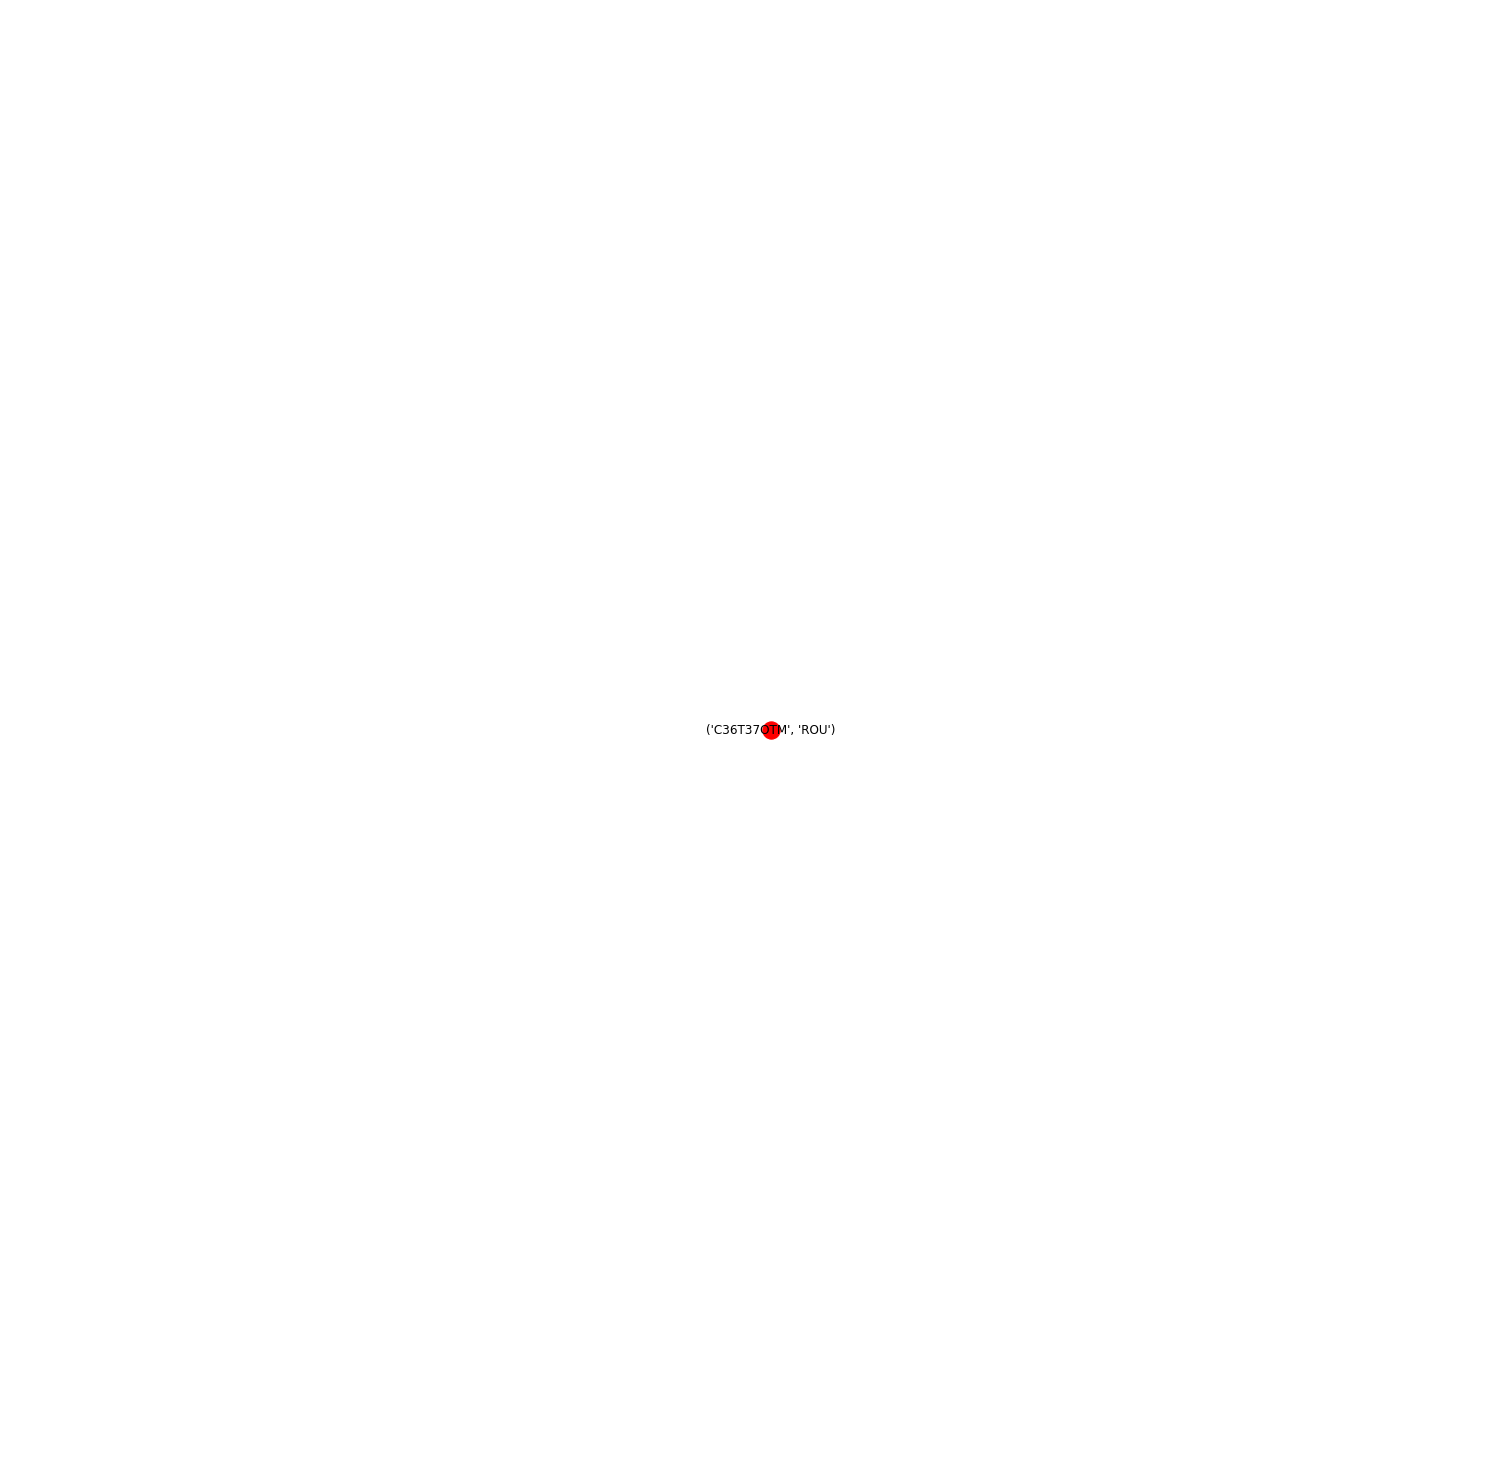

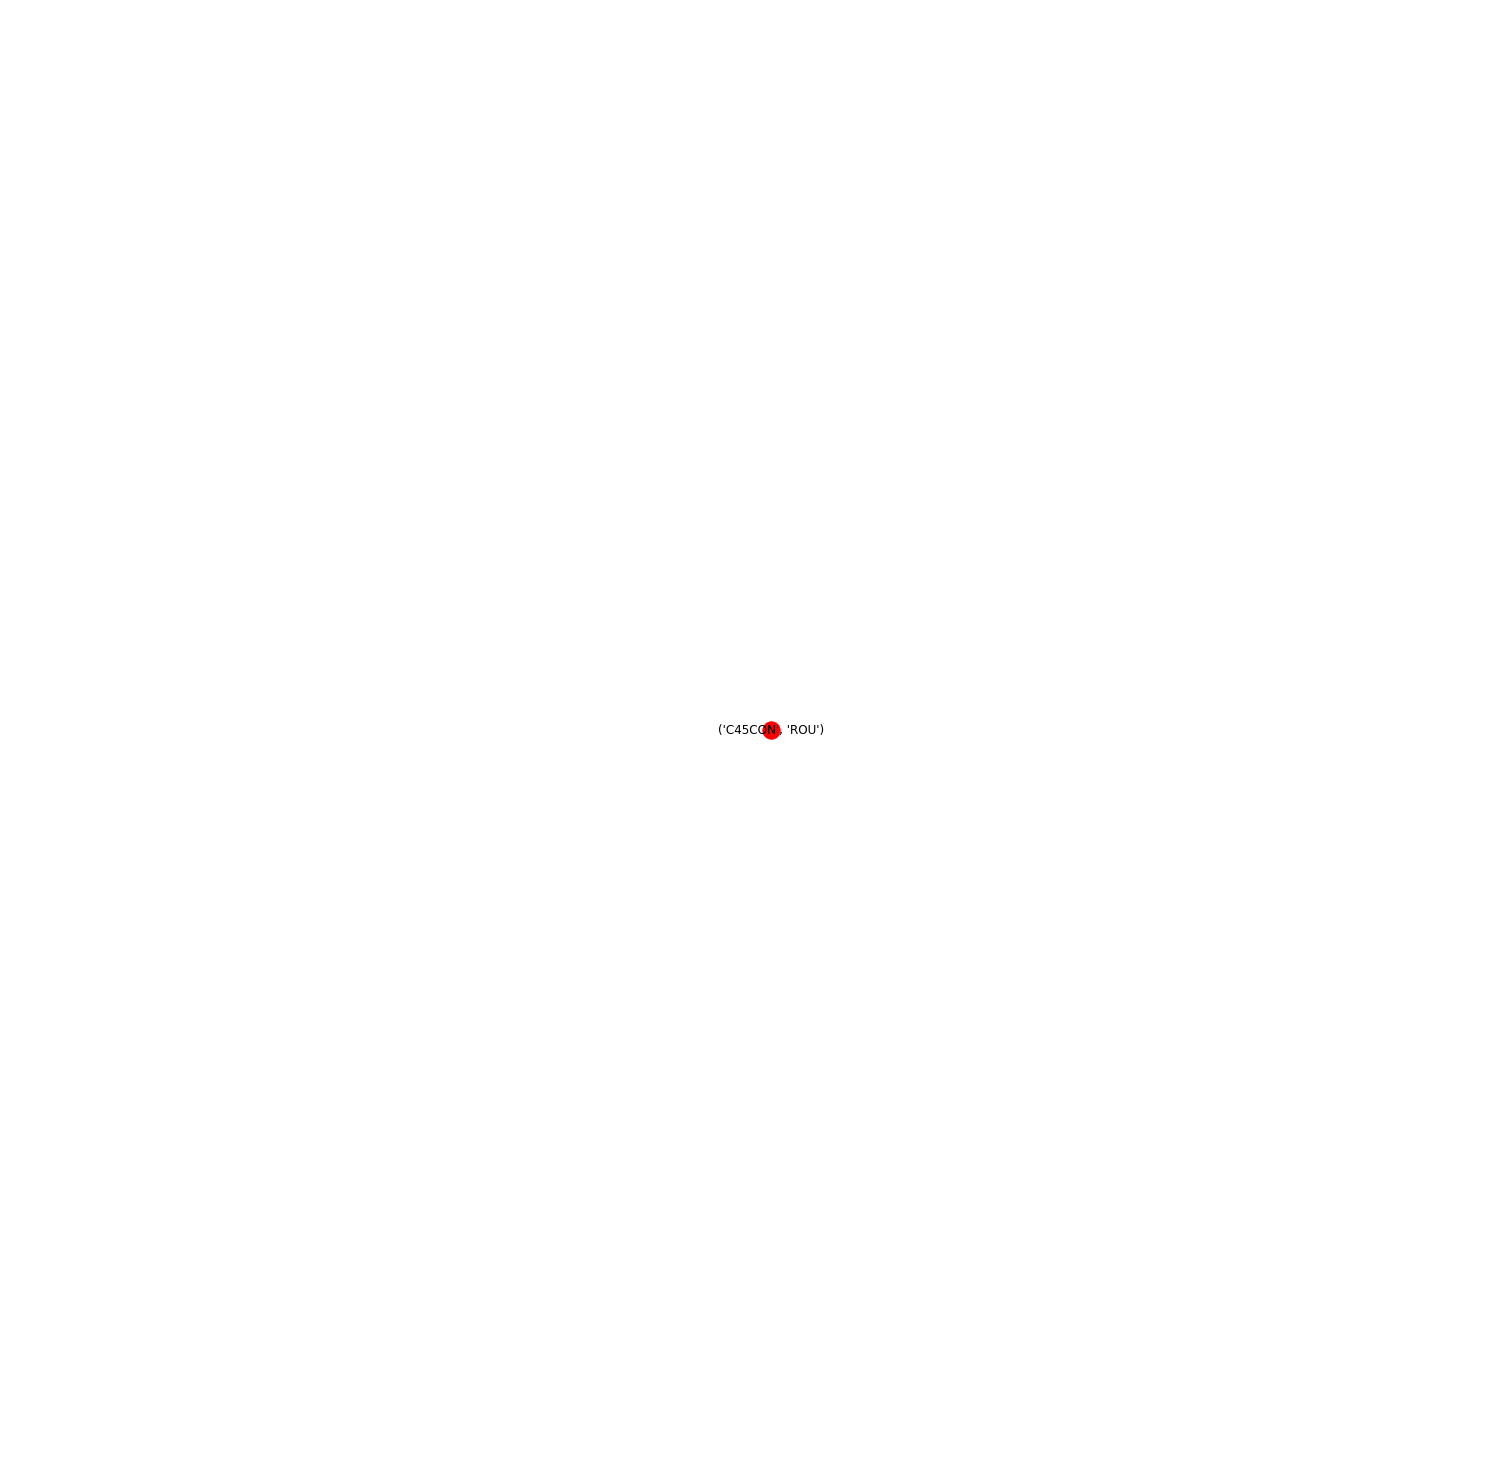

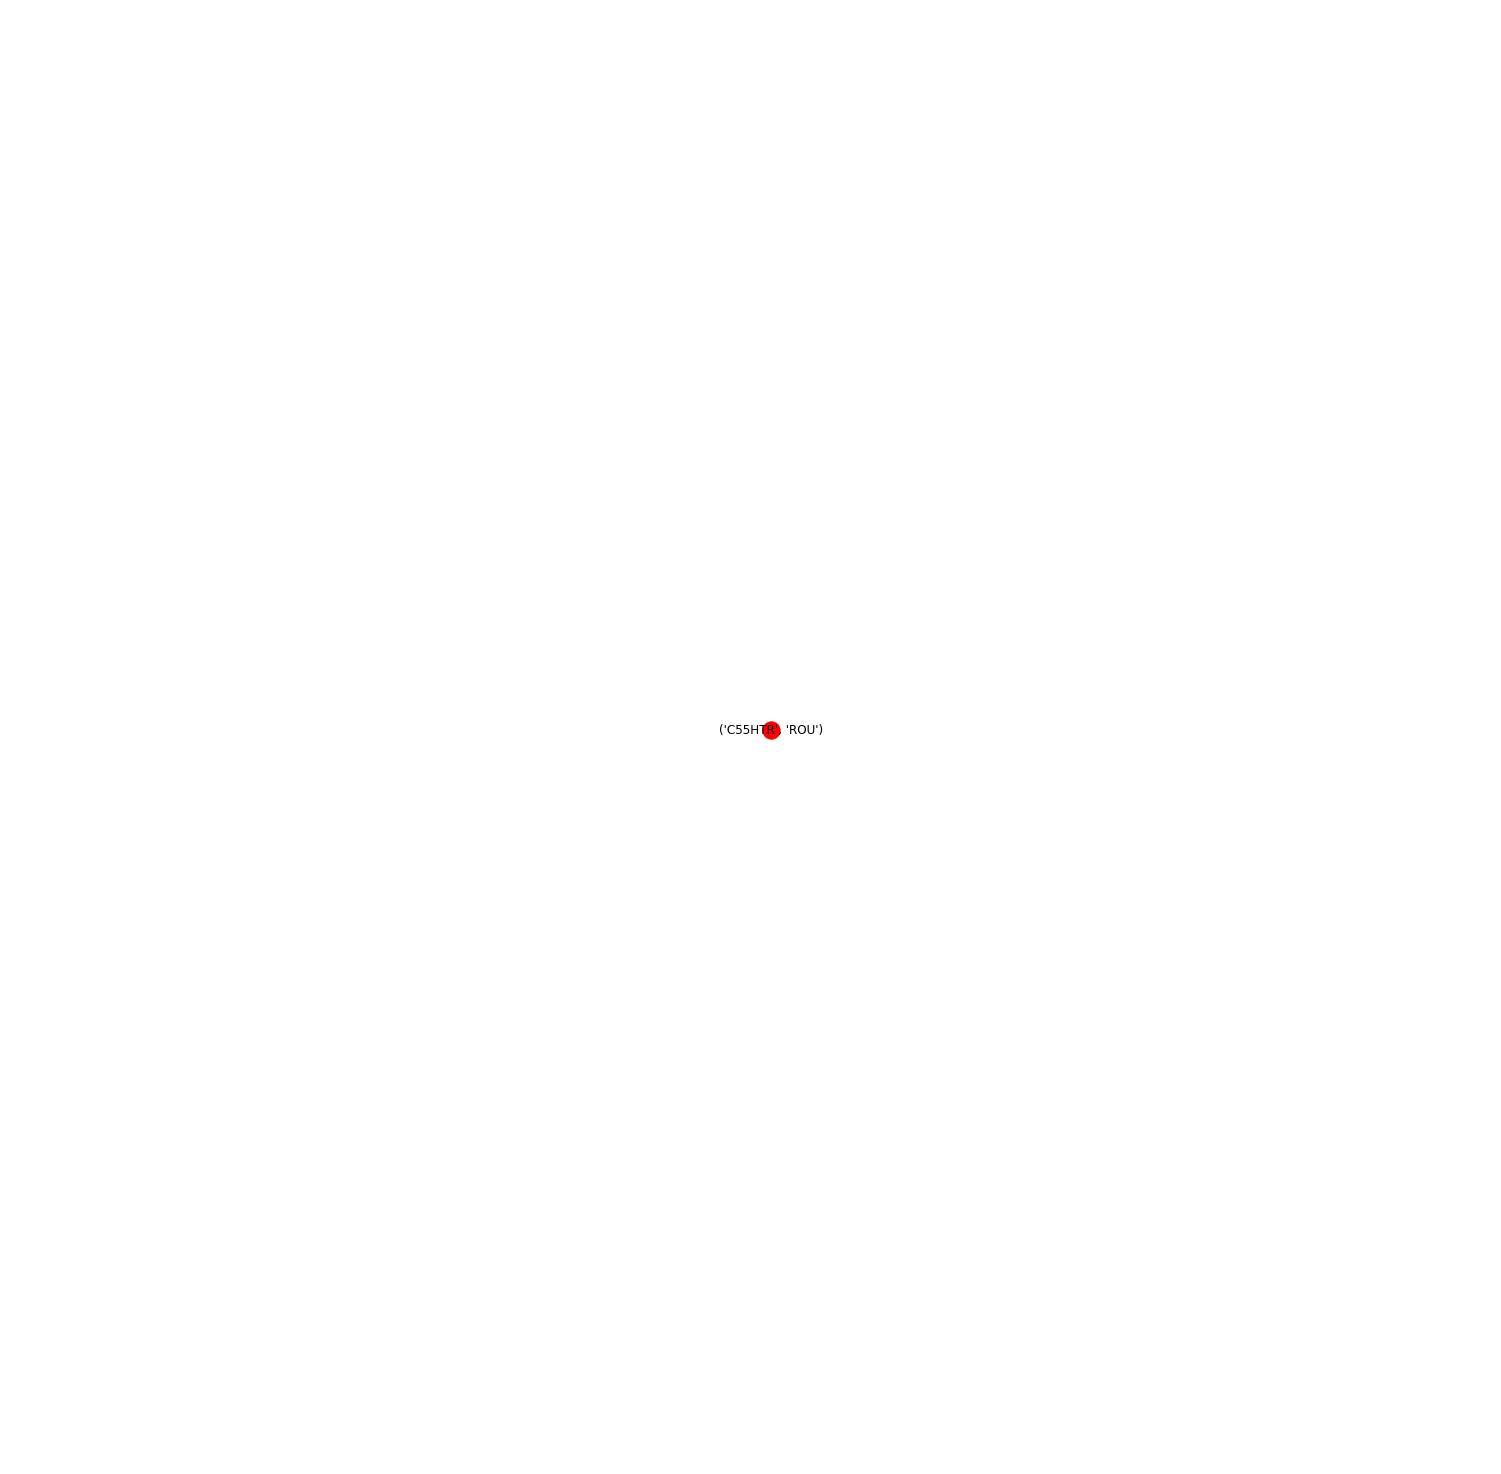

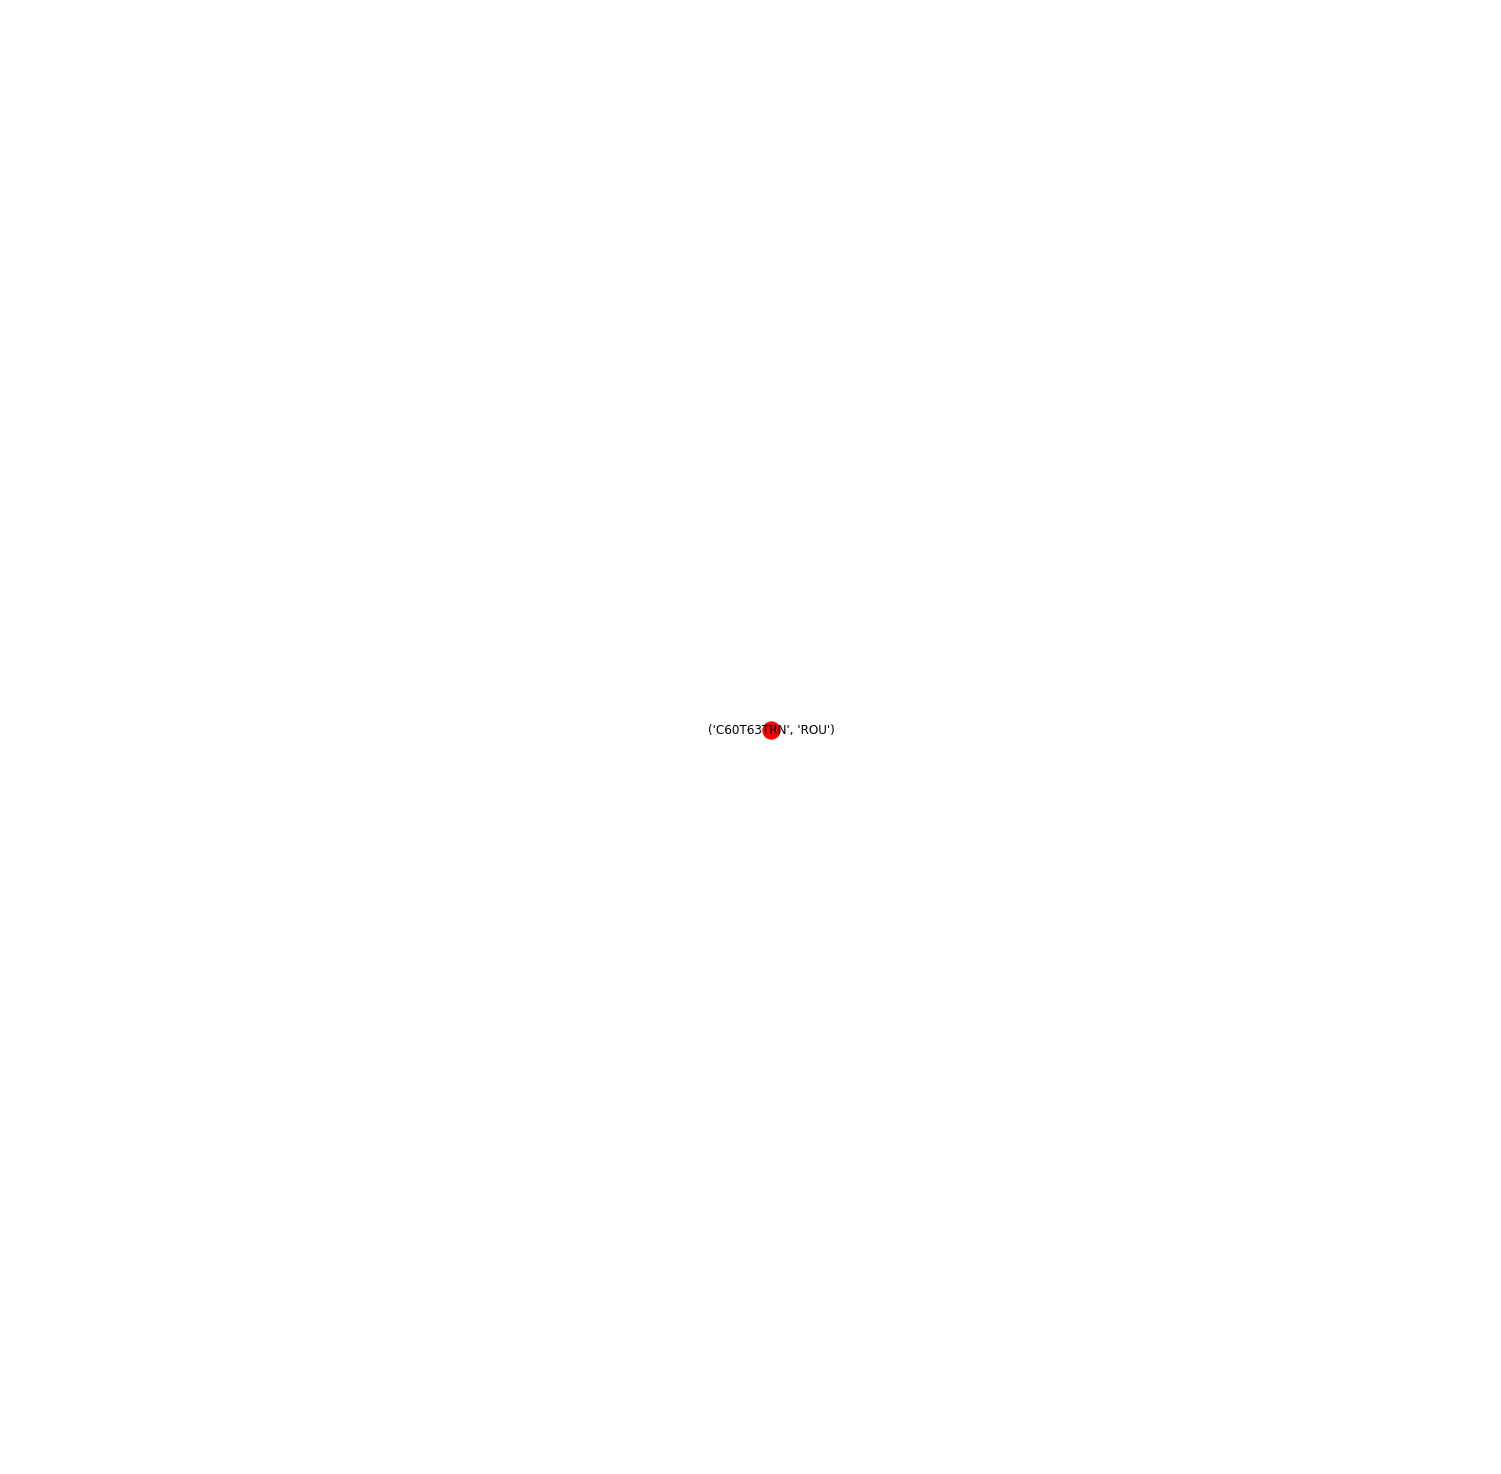

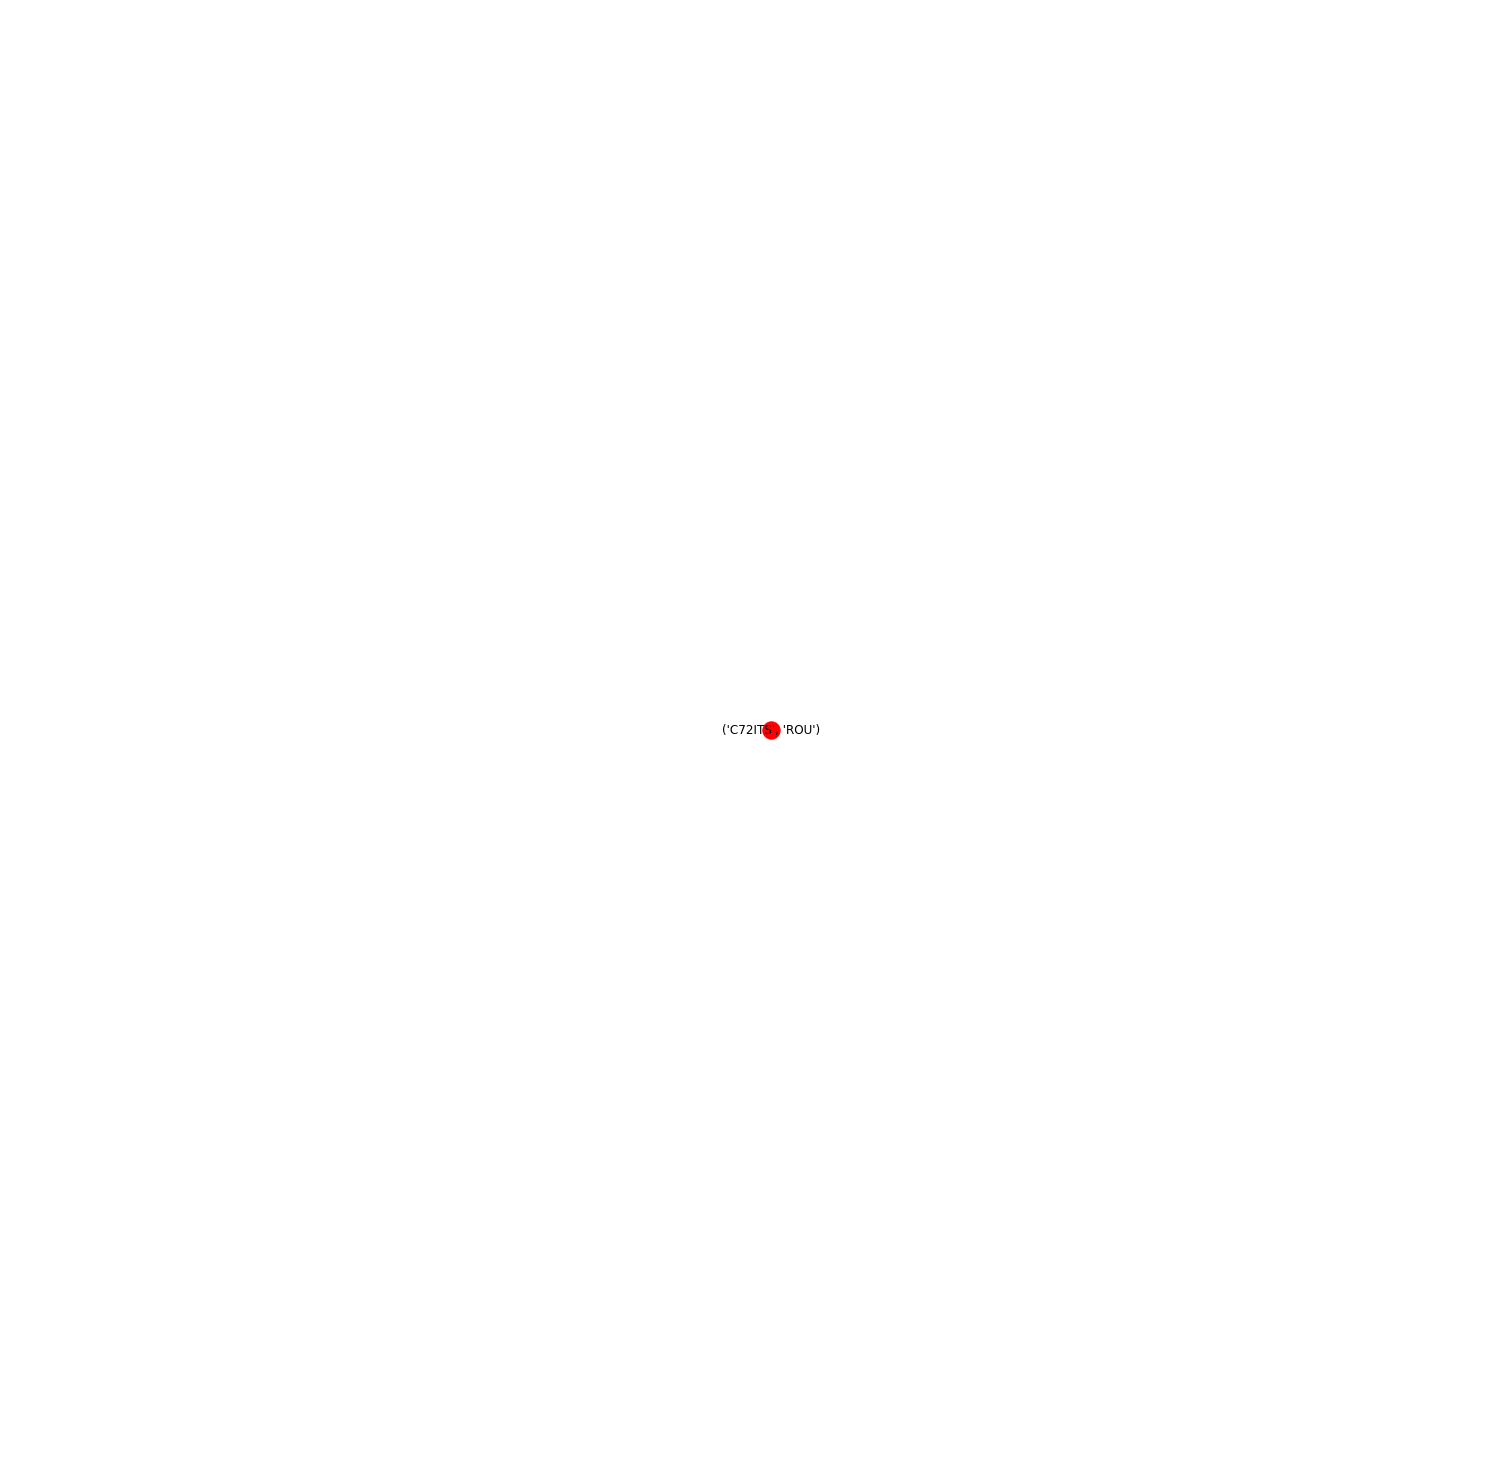

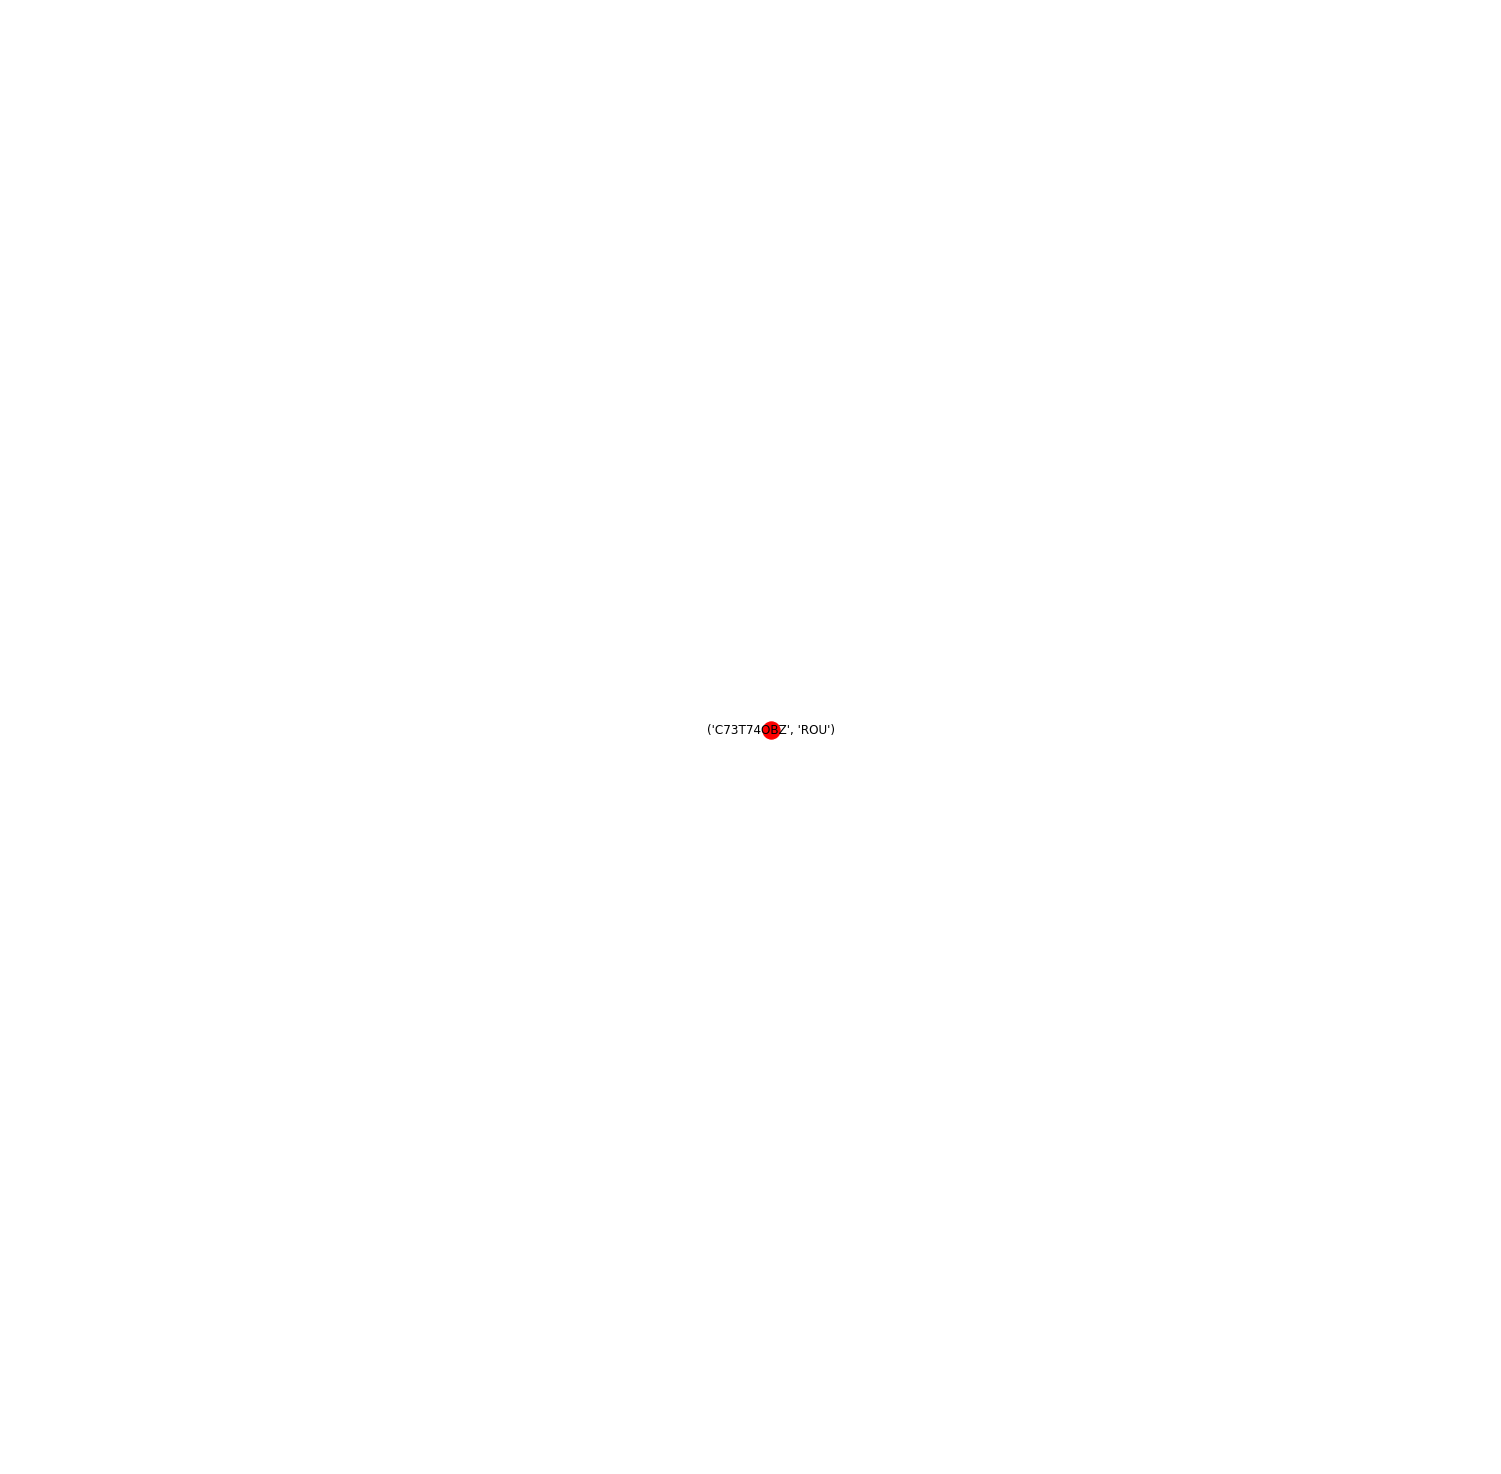

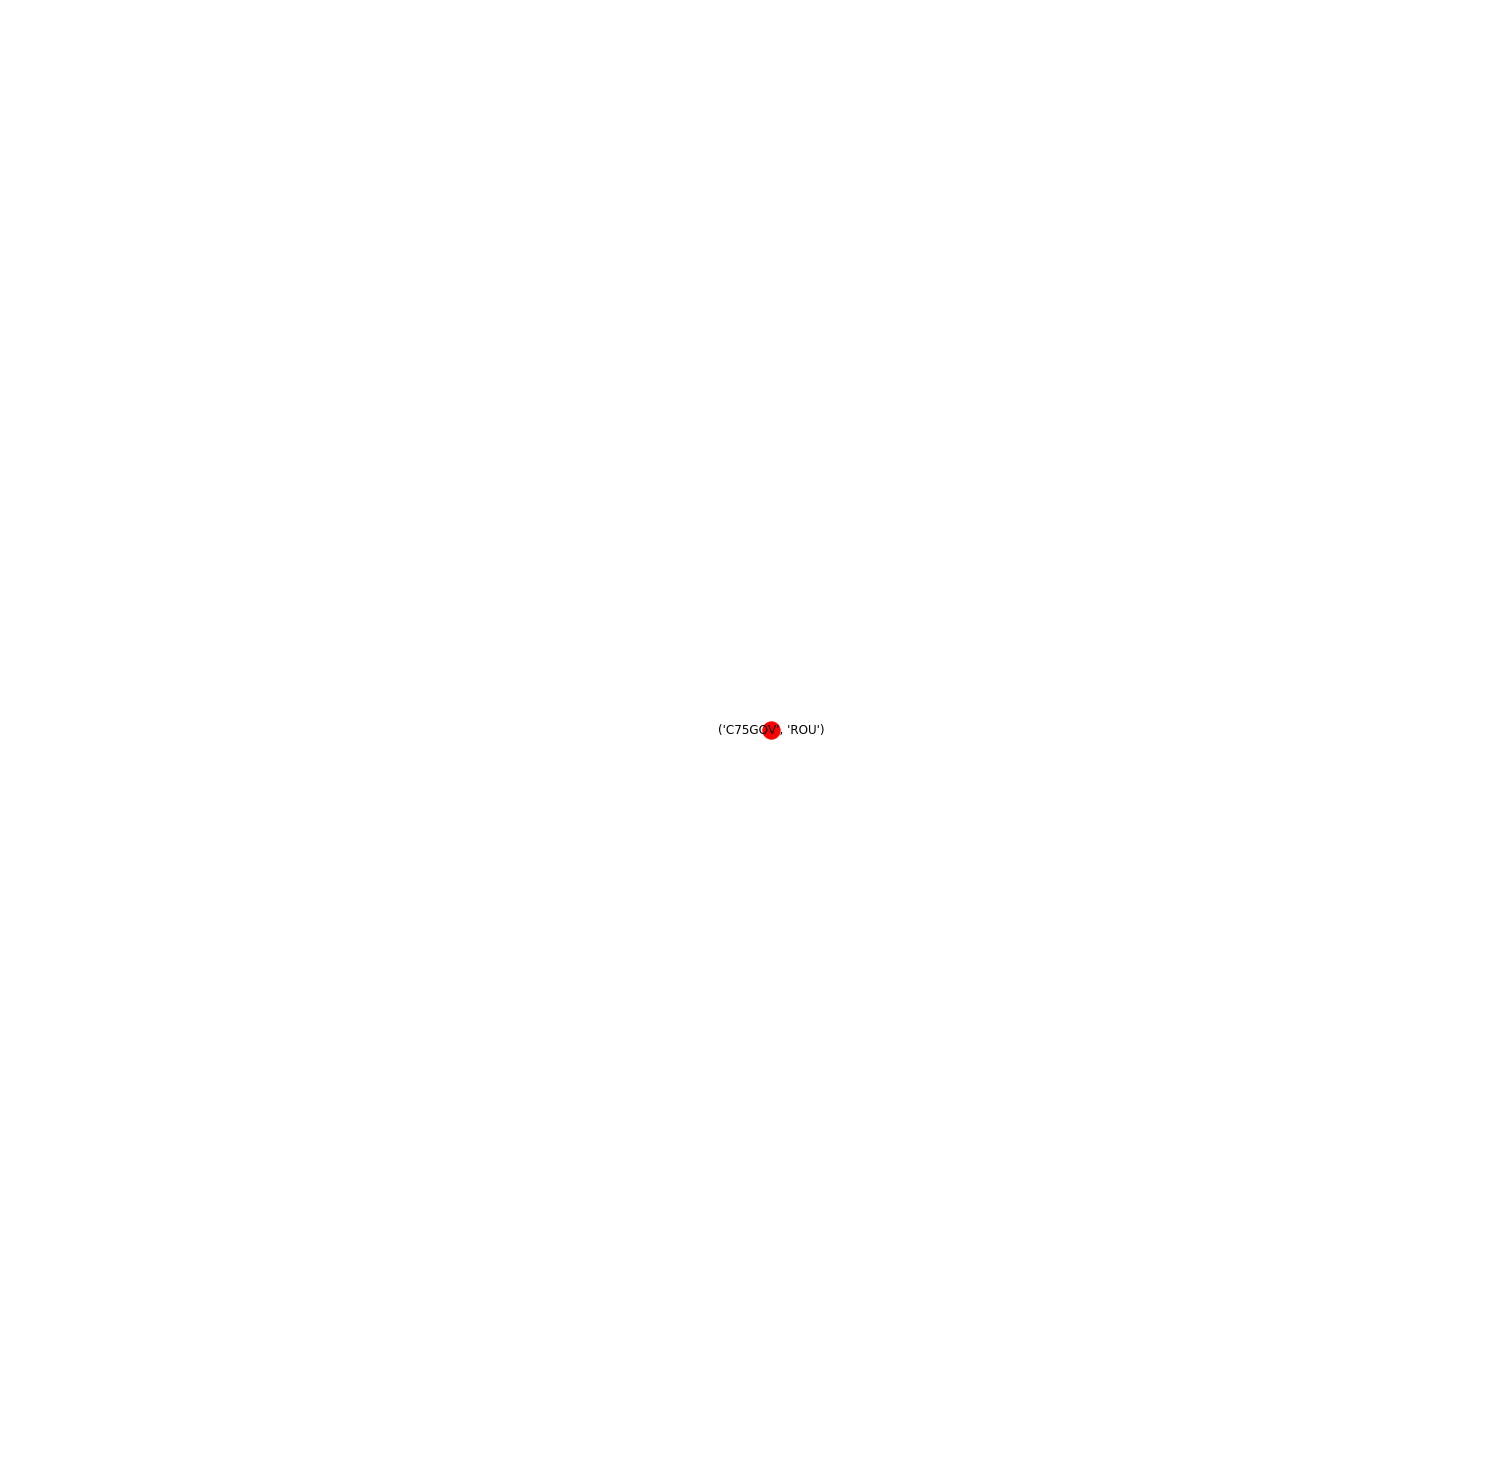

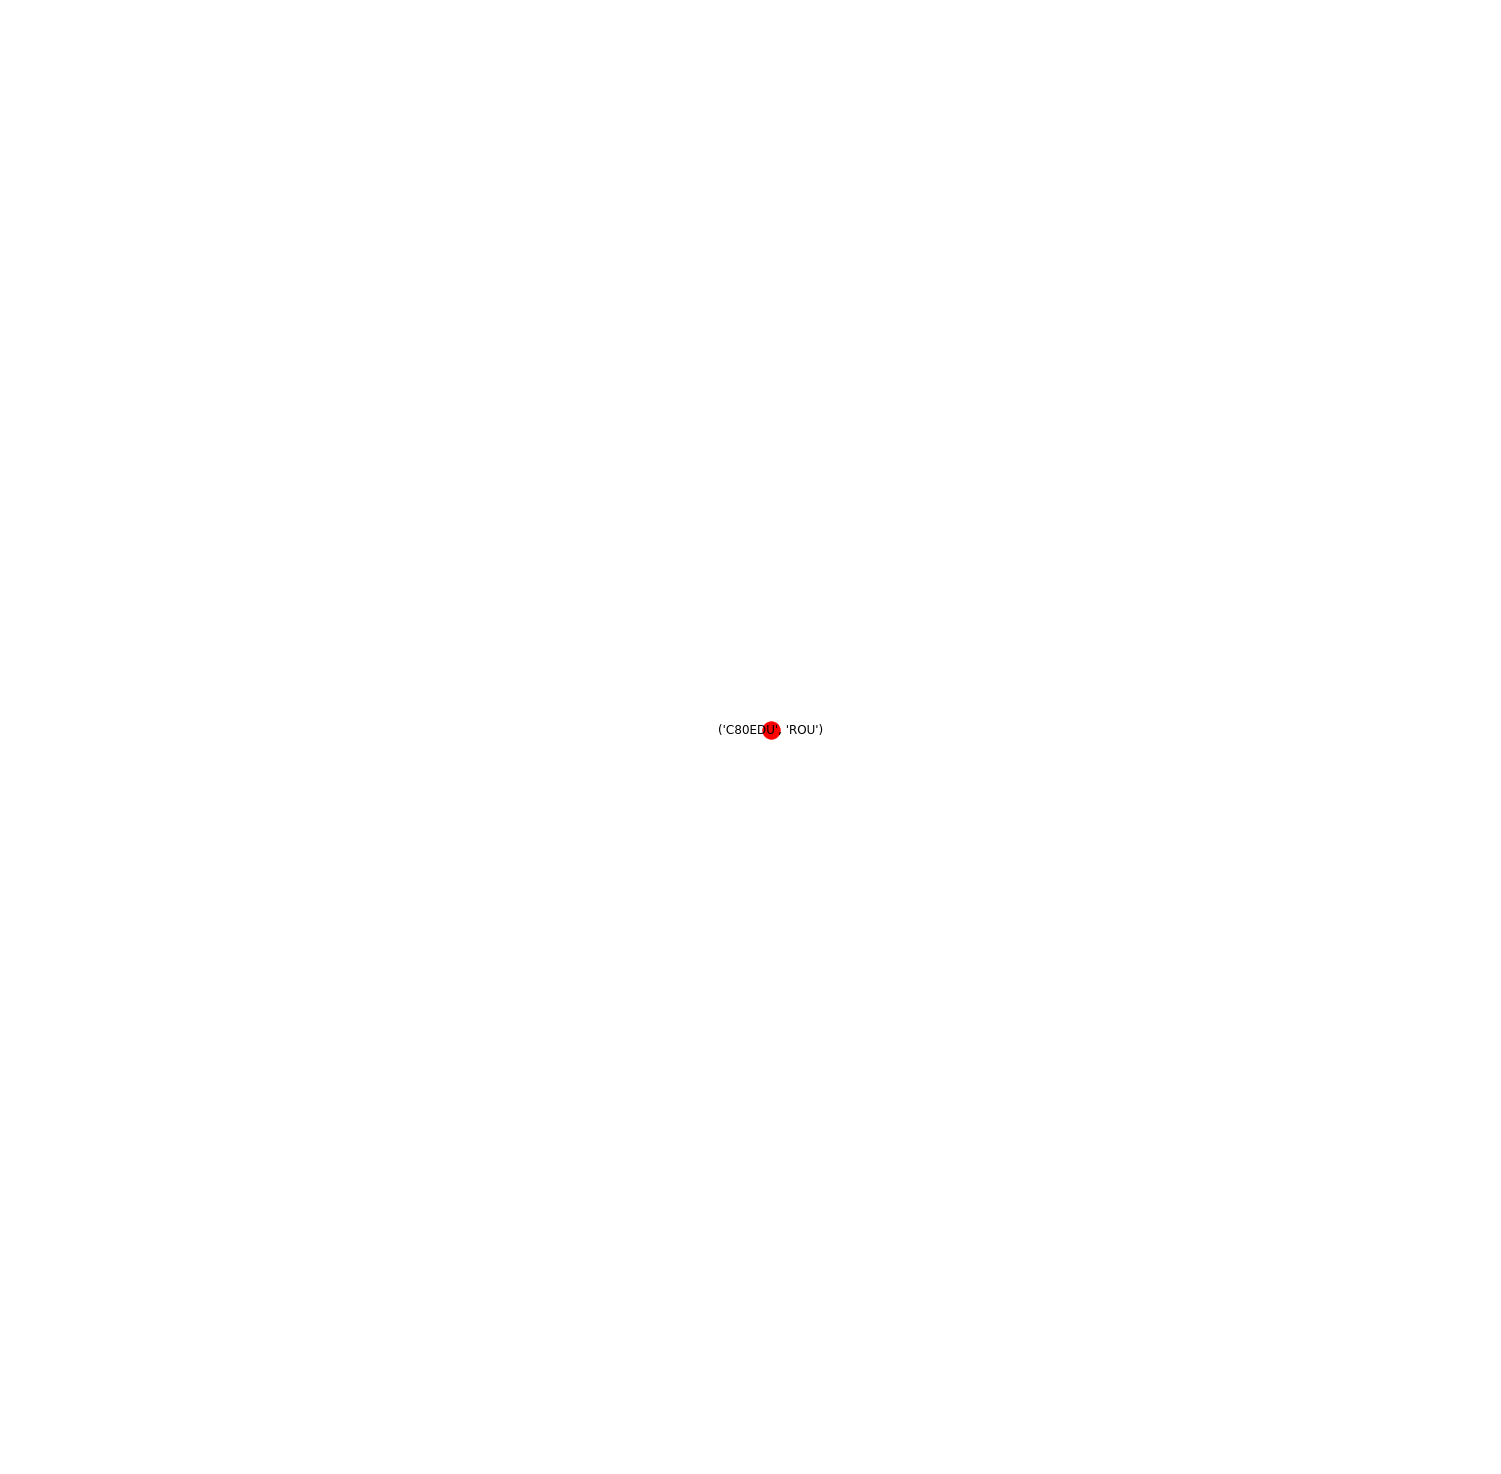

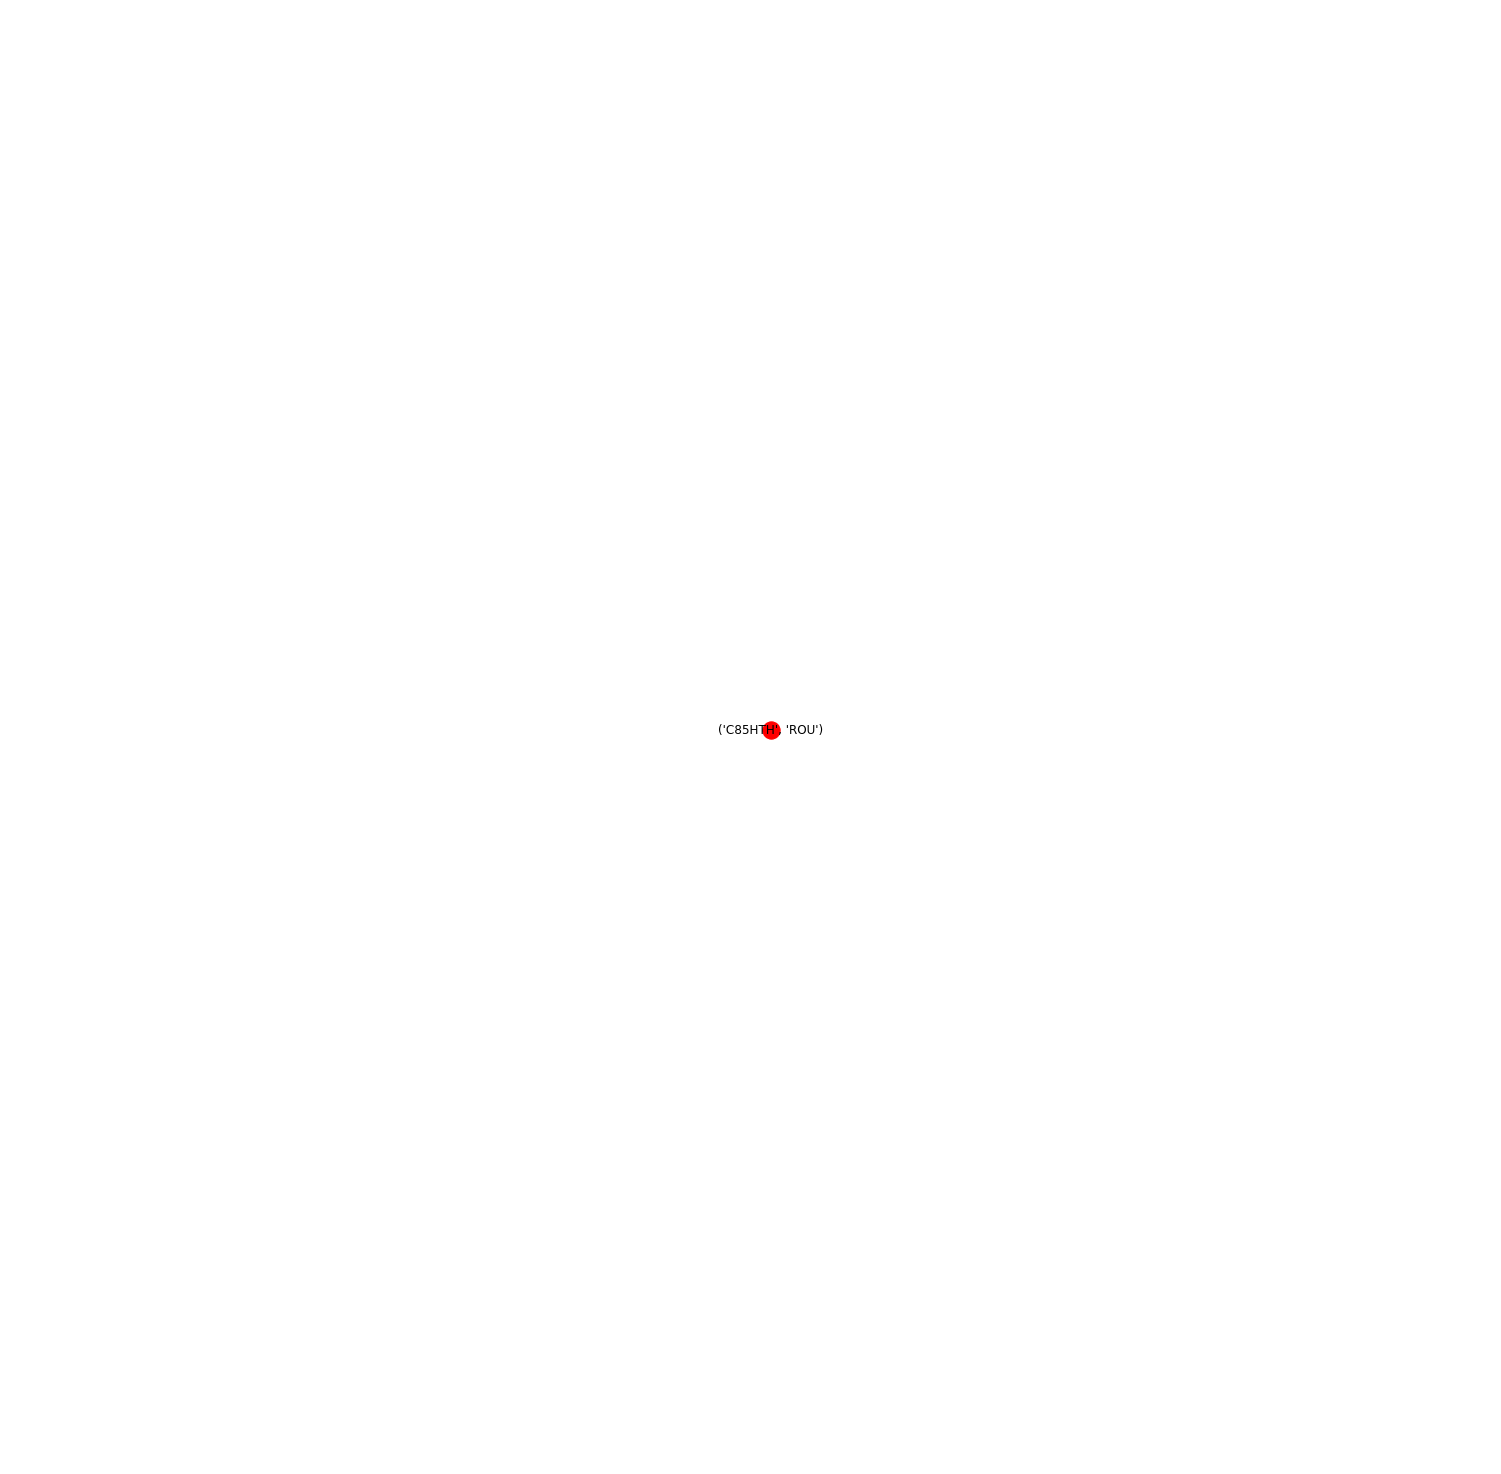

In [125]:
for i in range(len(community_index)):
    nodes_to_draw = []
    for n in list(community_index)[i]:
        nodes_to_draw.append(n)
    community1 = D.subgraph(nodes_to_draw)
    for node in community1.nodes():
        community1.node[node]['sector'] = sectors[node]
    labels_community=dict((n,(d['sector'], d['country'])) for n,d in community1.nodes(data=True))
    plt.figure(figsize = (20,20))
    nx.draw(community1, labels = labels_community)
    plt.show()

In [83]:
len(gn_partitions)

27

In [63]:
node_shape (string, optional (default=’o’)

SyntaxError: invalid syntax (<ipython-input-63-72bf46306113>, line 1)

In [4]:
weights = nx.get_edge_attributes(D, 'weight').values()
#color_map = {'FRA':'b', 'GBR':'#FF0099', 'DEU':'#660066', 'ESP': '#FF33CC', 'ROU':'r', 'CYP':'#996600'} 

color_map = {'FRA':'b', 'GBR':'#FF0099', 'DEU':'#660066' }
d = nx.degree(D)
shapes =  ['o', 'v', 'd',]


plt.figure(figsize = (120,120))

nx.draw(D, width = weights*20,
        node_color = [color_map[D.node[node]['country']] for node in D],
        node_size=[v * 100 for v in d.values()],
        node_shape = [s for s in shapes])


plt.title('Global Value Chains Sample Network')

france = mpatches.Patch(color = 'b', label = 'France')
britain =  mpatches.Patch(color = '#FF0099', label = 'Great Britain')
germany =  mpatches.Patch(color = '#660066', label = 'Germany')

plt.legend(handles=[france, britain, germany], prop={'size':200})
plt.show()

2

In [ ]:
##load from saved array
#np.save(file = 'gn_partition.npy',arr = list(gn_partition))
#gn_partition = np.load('gn_partition.npy')


In [13]:
gn_partition = list(gn_partition)
values = [gn_partition.get(node) for node in D.nodes()]
nx.draw_spring(D, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)

plt.show()

AttributeError: 'list' object has no attribute 'get'

In [20]:
list(gn_partition)[0]

KeyboardInterrupt: 

#### LIST OF Things to do

- for each community to look at the share of edges that connect 2 different countries
- calculate the average across all communities
    * repeat for different sectors
- loop across all years and create a plot indicating change of inter-country/inter-industry transaction

